In [1]:
import h5py

In [17]:
with h5py.File('../../scripts/data/killms_datapack_2.hdf5') as f, h5py.File('../../scripts/data/killms_datapack_3.hdf5') as g:
    g['/sol000/tec000/val'][...] = f['/sol000/tec000/val'][...]
    g['/sol000/tec000/weight'][...] = f['/sol000/tec000/weight'][...]

In [12]:
from bayes_tec.bayes_opt.maximum_likelihood_tec import solve_ml_tec
from bayes_tec.datapack import DataPack
import numpy as np

In [14]:
with DataPack('../../scripts/data/killms_datapack_4.hdf5',readonly=False) as datapack:#'/home/albert/git/IonoTomo/src/ionotomo/data/NsolutionsDDE_2.5Jy_tecandphasePF_correctedlosoto_fulltime_dec27.h5',readonly=True) as datapack:
    datapack.switch_solset('sol000')
    datapack.select(ant="RS*",pol=slice(0,1,1))
    amp, _ = datapack.amplitude

2018-11-01 16:01:28,740 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-01 16:01:28,753 Closing table.
2018-11-01 16:01:28,756 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-01 16:01:30,708 Reference possible only for phase, scalarphase, clock, tec, tec3rd, and rotation solution tables. Ignore referencing.
2018-11-01 16:01:30,727 Closing table.


In [18]:
import pylab as plt
plt.plot(amp[0,0,13,0,:])
plt.show()

In [47]:
Npol,Nd, Na,Nf,Nt = phase.shape
# tec = tec_.reshape((Npol,Nd,Na,Nt))
# sigma = sigma_.reshape((Npol, Nd, Na, Nt))

def wrap(phi):
    return np.angle(np.exp(1j*phi))

# phase_pred = -8.448e9*tec[...,None,:]/freqs[:,None]
# res = (wrap(wrap(phase) - wrap(phase_pred)))
res = tec - tec_ml

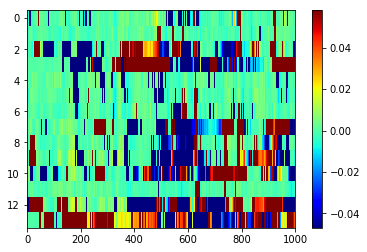

In [48]:
import numpy as np
import pylab as plt

import mpl_toolkits.mplot3d.axes3d as p3







# for l in range(Nt):
    
#     z = phase_pred[0,0,51,:,l]
#     x = times[l].mjd*np.ones(Nf)
#     y = freqs
# #     ax.scatter(x,y,z,c=plt.cm.jet(l/30),marker='+',alpha=0.5)
#     ax.plot(x,y,z,c='k',alpha=0.5)
#     ax.set_xlabel('times (mjd)')
#     ax.set_ylabel('frequency Hz')
#     ax.set_zlabel('phase (rad)')
# #     ax.set_zlim3d([-np.pi,np.pi])

# norm = plt.Normalize(res[0,0,51,:,:].min(),res[0,0,51,:,:].max())
norm = plt.Normalize(np.percentile(res,10),np.percentile(res,90))

c = plt.cm.jet(norm(res[0,0,:,:]))
plt.imshow(res[0,0,:,:], cmap=plt.cm.jet,norm=norm,aspect='auto')
plt.colorbar()
plt.show()

# fig = plt.figure(figsize=(12,12))
# ax = p3.Axes3D(fig)

    
# for l in range(Nf):
#     z = res[0,0,51,l,:]
#     x = times.mjd
#     y = freqs[l]*np.ones(Nt)
#     ax.plot(x,y,z,c='k',marker='+',alpha=0.9)
#     c = plt.cm.jet(norm(z))    
#     ax.scatter(x,y,z,c=c,alpha=0.5)
    
#     ax.set_xlabel('times (mjd)')
#     ax.set_ylabel('frequency Hz')
#     ax.set_zlabel('phase (rad)')
#     ax.set_zlim3d([-np.pi,np.pi])
# plt.show()
# plt.hist(res.flatten(),bins=100)
# plt.show()

In [1]:
from bayes_tec.datapack import DataPack
import numpy as np
import pylab as plt
plt.style.use('ggplot')
import os
        
def plot_solution_residuals(datapack, output_folder, data_solset='sol000', solution_solset='posterior_sol', 
                          ant_sel=None,time_sel=None,dir_sel=None,freq_sel=None,pol_sel=None):
    def _wrap(phi):
        return np.angle(np.exp(1j*phi))
    
    if not isinstance(datapack,str):
        datapack = datapack.filename

    output_folder = os.path.abspath(output_folder)
    os.makedirs(output_folder,exist_ok=True)

    solsets = [data_solset, solution_solset]
    with DataPack(datapack,readonly=True) as datapack:
        datapack.switch_solset(data_solset)
        datapack.select(ant=ant_sel,time=time_sel,dir=dir_sel,freq=freq_sel,pol=pol_sel)
        
        phase,axes = datapack.phase
        timestamps,times = datapack.get_times(axes['time'])
        antenna_labels, antennas = datapack.get_antennas(axes['ant'])
        patch_names, directions = datapack.get_sources(axes['dir'])
        _,freqs = datapack.get_freqs(axes['freq'])
        pols, _ = datapack.get_pols(axes['pol'])
        Npol,Nd,Na,Nf,Nt = phase.shape

        datapack.switch_solset(solution_solset)
        datapack.select(ant=ant_sel,time=time_sel,dir=dir_sel,freq=freq_sel,pol=pol_sel)
        tec,_ = datapack.tec
        phase_pred = -8.448e9*tec[...,None,:]/freqs[:,None]
        
        res = _wrap(_wrap(phase) - _wrap(phase_pred))
        cbar = None  
                
        for p in range(Npol):
            for a in range(Na):
                
                M = int(np.ceil(np.sqrt(Nd)))
                fig,axs = plt.subplots(nrows=2*M,ncols=M,sharex=True,figsize=(M*4,1*M*4),gridspec_kw = {'height_ratios':[1.5,1]*M})
                fig.subplots_adjust(wspace=0., hspace=0.)
                fig.subplots_adjust(right=0.85)
                cbar_ax = fig.add_axes([0.875, 0.15, 0.025, 0.7])
                
                vmin = -1.
                vmax = 1.
                norm = plt.Normalize(vmin, vmax)
                
                for row in range(0,2*M,2):
                    for col in range(M):
                        ax1 = axs[row][col]
                        ax2 = axs[row+1][col]
                        
                        d = col + row//2*M
                        if d >= Nd:
                            continue

                        img = ax1.imshow(res[p,d,a,:,:],origin='lower',aspect='auto',
                                  extent=(times[0].mjd*86400.,times[-1].mjd*86400.,freqs[0],freqs[-1]),
                                 cmap=plt.cm.jet, norm = norm)
                        ax1.text(0.05, 0.95, axes['dir'][d], horizontalalignment='left',verticalalignment='top', transform=ax1.transAxes,backgroundcolor=(1.,1.,1., 0.5))
                    
                        ax1.set_ylabel('frequency [Hz]')
                        ax1.legend()
                    

                        mean = res[p,d,a,:,:].mean(0)
                        ax2.plot(times.mjd*86400, mean,label=r'$\mathbb{E}_\nu[\delta\phi]$')
                        std = res[p,d,a,:,:].std(0)
                        ax2.fill_between(times.mjd*86400, mean - std, mean + std,alpha=0.5,label=r'$\pm\sigma_{\delta\phi}$')
                        ax2.set_xlabel('Time [mjs]')
                        ax2.set_xlim(times[0].mjd*86400.,times[-1].mjd*86400.)
                        ax2.set_ylim(-np.pi,np.pi)
#                         ax2.legend()
                        
                    
                fig.colorbar(img, cax=cbar_ax, orientation='vertical', label='phase dev. [rad]')
                filename = "{}_v_{}_{}_{}.png".format(data_solset,solution_solset, axes['ant'][a], axes['pol'][p])
                plt.savefig(os.path.join(output_folder,filename))
                plt.close('all')
                    
#                     plt.show()
        

In [2]:
plot_solution_residuals('../../scripts/data/killms_datapack_2.hdf5','output_folder_sol000',solution_solset='sol000',ant_sel='RS*',time_sel=slice(1,1000,1),pol_sel=slice(0,1,1),dir_sel=slice(0,None,1))

2018-10-01 11:34:04,183 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_2.hdf5.
2018-10-01 11:34:04,199 Closing table.
2018-10-01 11:34:04,202 Reading from /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_2.hdf5.
2018-10-01 11:37:11,393 Closing table.


In [2]:
from bayes_tec.plotting.plot_datapack import animate_datapack

2018-11-10 19:47:50,994 CACHEDIR=/home/albert/.cache/matplotlib
2018-11-10 19:47:51,002 Using fontManager instance from /home/albert/.cache/matplotlib/fontlist-v300.json
2018-11-10 19:47:51,245 Loaded backend agg version unknown.


In [3]:
animate_datapack('../../scripts/data/killms_datapack_4.hdf5',
                 'figs_gains_Wcon',
                 num_processes=32,
                 ant_sel='RS*',
                 time_sel=slice(0,2000,1),
                 observable='tec', 
                 tec_eval_freq=140e6, 
                 plot_facet_idx=True, 
                 labels_in_radec=True, 
                 plot_screen=False,
                 solset='posterior_sol_gains_Wcon',
                 phase_wrap=True)

2018-11-10 19:47:52,175 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-10 19:47:52,176 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-10 19:47:52,178 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-10 19:47:52,177 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-10 19:47:52,177 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-10 19:47:52,177 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-10 19:47:52,177 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-10 19:47:52,177 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-10 19:47:52,178 Appending to /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_

2018-11-10 19:47:52,214 Reading from /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-10 19:47:52,216 Reading from /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-10 19:47:52,219 Closing table.
2018-11-10 19:47:52,221 Closing table.
2018-11-10 19:47:52,221 Closing table.
2018-11-10 19:47:52,222 Closing table.
2018-11-10 19:47:52,223 Closing table.
2018-11-10 19:47:52,224 turning off display
2018-11-10 19:47:52,224 turning off display
2018-11-10 19:47:52,224 turning off display
2018-11-10 19:47:52,225 turning off display
2018-11-10 19:47:52,224 Closing table.
2018-11-10 19:47:52,225 Closing table.
2018-11-10 19:47:52,224 Closing table.
2018-11-10 19:47:52,226 Reading from /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-10 19:47:52,225 Reading from /net/lofar1/data1/albert/git/bayes_tec/scripts/data/killms_datapack_4.hdf5.
2018-11-10 19:47:52,226 Closing table.
2018-11-10 19:47:52,2

   4.98797153e+09   4.98797178e+09],freq=None,dir=None,pol=None2018-11-10 19:47:52,239 turning off display

2018-11-10 19:47:52,243 Applying selection: ant=RS*,time=[  4.98795624e+09   4.98795650e+09   4.98795675e+09   4.98795701e+09
   4.98795727e+09   4.98795752e+09   4.98795778e+09   4.98795803e+09
   4.98795829e+09   4.98795854e+09   4.98795880e+09   4.98795906e+09
   4.98795931e+09   4.98795957e+09   4.98795982e+09   4.98796008e+09
   4.98796034e+09   4.98796059e+09   4.98796085e+09   4.98796110e+09
   4.98796136e+09   4.98796162e+09   4.98796187e+09   4.98796213e+09
   4.98796238e+09   4.98796264e+09   4.98796290e+09   4.98796315e+09
   4.98796341e+09   4.98796366e+09   4.98796392e+09   4.98796418e+09
   4.98796443e+09   4.98796469e+09   4.98796494e+09   4.98796520e+09
   4.98796546e+09   4.98796571e+09   4.98796597e+09   4.98796622e+09
   4.98796648e+09   4.98796674e+09   4.98796699e+09   4.98796725e+09
   4.98796750e+09   4.98796776e+09   4.98796802e+09   4.98796827e+09
   4.98

2018-11-10 19:47:52,250 Applying selection: ant=RS*,time=[  4.98795609e+09   4.98795635e+09   4.98795660e+09   4.98795686e+09
   4.98795711e+09   4.98795737e+09   4.98795763e+09   4.98795788e+09
   4.98795814e+09   4.98795839e+09   4.98795865e+09   4.98795890e+09
   4.98795916e+09   4.98795942e+09   4.98795967e+09   4.98795993e+09
   4.98796018e+09   4.98796044e+09   4.98796070e+09   4.98796095e+09
   4.98796121e+09   4.98796146e+09   4.98796172e+09   4.98796198e+09
   4.98796223e+09   4.98796249e+09   4.98796274e+09   4.98796300e+09
   4.98796326e+09   4.98796351e+09   4.98796377e+09   4.98796402e+09
   4.98796428e+09   4.98796454e+09   4.98796479e+09   4.98796505e+09
   4.98796530e+09   4.98796556e+09   4.98796582e+09   4.98796607e+09
   4.98796633e+09   4.98796658e+09   4.98796684e+09   4.98796710e+09
   4.98796735e+09   4.98796761e+09   4.98796786e+09   4.98796812e+09
   4.98796838e+09   4.98796863e+09   4.98796889e+09   4.98796914e+09
   4.98796940e+09   4.98796966e+09   4.9879699

   4.98797142e+09   4.98797167e+09   4.98797193e+09],freq=None,dir=None,pol=None


2018-11-10 19:47:52,259 Applying selection: ant=RS*,time=[  4.98795607e+09   4.98795632e+09   4.98795658e+09   4.98795683e+09
   4.98795709e+09   4.98795735e+09   4.98795760e+09   4.98795786e+09
   4.98795811e+09   4.98795837e+09   4.98795862e+09   4.98795888e+09
   4.98795914e+09   4.98795939e+09   4.98795965e+09   4.98795990e+09
   4.98796016e+09   4.98796042e+09   4.98796067e+09   4.98796093e+09
   4.98796118e+09   4.98796144e+09   4.98796170e+09   4.98796195e+09
   4.98796221e+09   4.98796246e+09   4.98796272e+09   4.98796298e+09
   4.98796323e+09   4.98796349e+09   4.98796374e+09   4.98796400e+09
   4.98796426e+09   4.98796451e+09   4.98796477e+09   4.98796502e+09
   4.98796528e+09   4.98796554e+09   4.98796579e+09   4.98796605e+09
   4.98796630e+09   4.98796656e+09   4.98796682e+09   4.98796707e+09
   4.98796733e+09   4.98796758e+09   4.98796784e+09   4.98796810e+09
   4.98796835e+09   4.98796861e+

   4.98797146e+09   4.98797172e+09   4.98797198e+09],freq=None,dir=None,pol=None2018-11-10 19:47:52,271 Applying selection: ant=RS*,time=[  4.98795627e+09   4.98795652e+09   4.98795678e+09   4.98795703e+09
   4.98795729e+09   4.98795755e+09   4.98795780e+09   4.98795806e+09
   4.98795831e+09   4.98795857e+09   4.98795882e+09   4.98795908e+09
   4.98795934e+09   4.98795959e+09   4.98795985e+09   4.98796010e+09
   4.98796036e+09   4.98796062e+09   4.98796087e+09   4.98796113e+09
   4.98796138e+09   4.98796164e+09   4.98796190e+09   4.98796215e+09
   4.98796241e+09   4.98796266e+09   4.98796292e+09   4.98796318e+09
   4.98796343e+09   4.98796369e+09   4.98796394e+09   4.98796420e+09
   4.98796446e+09   4.98796471e+09   4.98796497e+09   4.98796522e+09
   4.98796548e+09   4.98796574e+09   4.98796599e+09   4.98796625e+09
   4.98796650e+09   4.98796676e+09   4.98796702e+09   4.98796727e+09
   4.98796753e+09   4.98796778e+09   4.98796804e+09   4.98796830e+09
   4.98796855e+09   4.98796881e+09 

   4.98797158e+09   4.98797184e+09],freq=None,dir=None,pol=None


2018-11-10 19:47:52,291 Applying selection: ant=RS*,time=[  4.98795610e+09   4.98795635e+09   4.98795661e+09   4.98795687e+09
   4.98795712e+09   4.98795738e+09   4.98795763e+09   4.98795789e+09
   4.98795815e+09   4.98795840e+09   4.98795866e+09   4.98795891e+09
   4.98795917e+09   4.98795942e+09   4.98795968e+09   4.98795994e+09
   4.98796019e+09   4.98796045e+09   4.98796070e+09   4.98796096e+09
   4.98796122e+09   4.98796147e+09   4.98796173e+09   4.98796198e+09
   4.98796224e+09   4.98796250e+09   4.98796275e+09   4.98796301e+09
   4.98796326e+09   4.98796352e+09   4.98796378e+09   4.98796403e+09
   4.98796429e+09   4.98796454e+09   4.98796480e+09   4.98796506e+09
   4.98796531e+09   4.98796557e+09   4.98796582e+09   4.98796608e+09
   4.98796634e+09   4.98796659e+09   4.98796685e+09   4.98796710e+09
   4.98796736e+09   4.98796762e+09   4.98796787e+09   4.98796813e+09
   4.98796838e+09   4.98796864e+09   4.98796890e+

2018-11-10 19:47:52,387 Optimizing selection reading [slice(None, None, None), slice(None, None, None), [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61], [30, 62, 94, 126, 158, 190, 222, 254, 286, 318, 350, 382, 414, 446, 478, 510, 542, 574, 606, 638, 670, 702, 734, 766, 798, 830, 862, 894, 926, 958, 990, 1022, 1054, 1086, 1118, 1150, 1182, 1214, 1246, 1278, 1310, 1342, 1374, 1406, 1438, 1470, 1502, 1534, 1566, 1598, 1630, 1662, 1694, 1726, 1758, 1790, 1822, 1854, 1886, 1918, 1950, 1982]]
2018-11-10 19:47:52,398 Optimizing selection reading [slice(None, None, None), slice(None, None, None), [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61], [28, 60, 92, 124, 156, 188, 220, 252, 284, 316, 348, 380, 412, 444, 476, 508, 540, 572, 604, 636, 668, 700, 732, 764, 796, 828, 860, 892, 924, 956, 988, 1020, 1052, 1084, 1116, 1148, 1180, 1212, 1244, 1276, 1308, 1340, 1372, 1404, 1436, 1468, 1500, 1532, 1564, 1596, 1628, 1660, 1692, 1724, 1756, 1788, 1820, 1852, 1884, 1916, 1948, 198

2018-11-10 19:47:52,425 Optimizing selection reading [slice(None, None, None), slice(None, None, None), [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61], [10, 42, 74, 106, 138, 170, 202, 234, 266, 298, 330, 362, 394, 426, 458, 490, 522, 554, 586, 618, 650, 682, 714, 746, 778, 810, 842, 874, 906, 938, 970, 1002, 1034, 1066, 1098, 1130, 1162, 1194, 1226, 1258, 1290, 1322, 1354, 1386, 1418, 1450, 1482, 1514, 1546, 1578, 1610, 1642, 1674, 1706, 1738, 1770, 1802, 1834, 1866, 1898, 1930, 1962, 1994]]
2018-11-10 19:47:52,452 Optimizing selection reading [slice(None, None, None), slice(None, None, None), [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61], [5, 37, 69, 101, 133, 165, 197, 229, 261, 293, 325, 357, 389, 421, 453, 485, 517, 549, 581, 613, 645, 677, 709, 741, 773, 805, 837, 869, 901, 933, 965, 997, 1029, 1061, 1093, 1125, 1157, 1189, 1221, 1253, 1285, 1317, 1349, 1381, 1413, 1445, 1477, 1509, 1541, 1573, 1605, 1637, 1669, 1701, 1733, 1765, 1797, 1829, 1861, 1893, 1925,

2018-11-10 19:47:52,647 Optimizing selection reading [slice(None, None, None), slice(None, None, None), [0], [24, 56, 88, 120, 152, 184, 216, 248, 280, 312, 344, 376, 408, 440, 472, 504, 536, 568, 600, 632, 664, 696, 728, 760, 792, 824, 856, 888, 920, 952, 984, 1016, 1048, 1080, 1112, 1144, 1176, 1208, 1240, 1272, 1304, 1336, 1368, 1400, 1432, 1464, 1496, 1528, 1560, 1592, 1624, 1656, 1688, 1720, 1752, 1784, 1816, 1848, 1880, 1912, 1944, 1976]]
2018-11-10 19:47:52,654 Closing table.
2018-11-10 19:47:52,661 Optimizing selection reading [slice(None, None, None), slice(None, None, None), [0], [22, 54, 86, 118, 150, 182, 214, 246, 278, 310, 342, 374, 406, 438, 470, 502, 534, 566, 598, 630, 662, 694, 726, 758, 790, 822, 854, 886, 918, 950, 982, 1014, 1046, 1078, 1110, 1142, 1174, 1206, 1238, 1270, 1302, 1334, 1366, 1398, 1430, 1462, 1494, 1526, 1558, 1590, 1622, 1654, 1686, 1718, 1750, 1782, 1814, 1846, 1878, 1910, 1942, 1974]]
2018-11-10 19:47:52,664 Optimizing selection reading [slice(Non

2018-11-10 19:47:52,737 Plotting 62 timestamps
2018-11-10 19:47:52,737 Closing table.
2018-11-10 19:47:52,739 Plotting 45 directions
2018-11-10 19:47:52,740 Closing table.
2018-11-10 19:47:52,754 Closing table.
2018-11-10 19:47:52,743 Optimizing selection reading [slice(None, None, None), slice(None, None, None), [0], [28, 60, 92, 124, 156, 188, 220, 252, 284, 316, 348, 380, 412, 444, 476, 508, 540, 572, 604, 636, 668, 700, 732, 764, 796, 828, 860, 892, 924, 956, 988, 1020, 1052, 1084, 1116, 1148, 1180, 1212, 1244, 1276, 1308, 1340, 1372, 1404, 1436, 1468, 1500, 1532, 1564, 1596, 1628, 1660, 1692, 1724, 1756, 1788, 1820, 1852, 1884, 1916, 1948, 1980]]
2018-11-10 19:47:52,738 Closing table.
2018-11-10 19:47:52,741 Plotting 45 directions
2018-11-10 19:47:52,745 Plotting 45 directions
2018-11-10 19:47:52,751 Closing table.
2018-11-10 19:47:52,736 Plotting 63 timestamps
2018-11-10 19:47:52,752 Closing table.
2018-11-10 19:47:52,744 Plotting 45 directions
2018-11-10 19:47:52,757 Plotting 63

2018-11-10 19:47:57,470 Plotting 2016-12-08T23:22:41.005
2018-11-10 19:47:57,472 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f8f1e8daa90>
2018-11-10 19:47:57,478 Using auto colorbar locator on colorbar
2018-11-10 19:47:57,473 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f8f1e893b38>
2018-11-10 19:47:57,491 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f8f1e8daa90>
2018-11-10 19:47:57,493 Using auto colorbar locator on colorbar
2018-11-10 19:47:57,502 Setting pcolormesh
2018-11-10 19:47:57,504 update_title_pos
2018-11-10 19:47:57,501 update_title_pos
2018-11-10 19:47:57,526 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f8f1e8da940>
2018-11-10 19:47:57,525 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.399999999999999 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_64.egg/matplotlib/

2018-11-10 19:47:57,702 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f8f1e893d30>
2018-11-10 19:47:57,717 Using auto colorbar locator on colorbar
2018-11-10 19:47:57,720 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f8f1e893d30>
2018-11-10 19:47:57,723 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_64.egg/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-11-10 19:47:57,726 Setting pcolormesh
2018-11-10 19:47:57,733 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f8f1e8d3dd8>
2018-11-10 19:47:57,728 update_title_pos
2018-11-10 19:47:57,735 Plotting 2016-12-08T23:20:57.005
2018-11-10 19:47:57,738 Using auto colorbar locator on colorbar
2018-11-10 19:47:57,737 update_title_pos
2018-11-10 19:47:57,756 findfont: Matching :family=sans

2018-11-10 19:47:57,908 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f8f1e8db748>
2018-11-10 19:47:57,909 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f8f1e8e5080>
2018-11-10 19:47:57,909 update_title_pos
2018-11-10 19:47:57,910 Using auto colorbar locator on colorbar
2018-11-10 19:47:57,912 Setting pcolormesh
2018-11-10 19:47:57,912 Setting pcolormesh
2018-11-10 19:47:57,912 locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f8f1e8e20b8>
2018-11-10 19:47:57,908 update_title_pos
2018-11-10 19:47:57,919 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_64.egg/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-11-10 19:47:57,922 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to D

2018-11-10 19:47:58,073 update_title_pos
2018-11-10 19:47:58,075 update_title_pos
2018-11-10 19:47:58,075 Using auto colorbar locator on colorbar
2018-11-10 19:47:58,044 Plotting 2016-12-08T23:24:17.005
2018-11-10 19:47:58,083 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.399999999999999 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_64.egg/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-11-10 19:47:58,083 update_title_pos
2018-11-10 19:47:58,085 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_64.egg/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-11-10 19:47:58,056 Plotting 2016-12-08T23:21:53.005
2018-11-10 19:47:58,0

2018-11-10 19:47:58,203 update_title_pos
2018-11-10 19:47:58,203 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_64.egg/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-11-10 19:47:58,217 update_title_pos
2018-11-10 19:47:58,228 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_64.egg/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-11-10 19:47:58,229 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.399999999999999 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py

2018-11-10 19:47:58,405 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_64.egg/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-11-10 19:47:58,400 update_title_pos
2018-11-10 19:47:58,407 update_title_pos
2018-11-10 19:47:58,406 update_title_pos
2018-11-10 19:47:58,407 update_title_pos
2018-11-10 19:47:58,408 findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=14.399999999999999 to DejaVu Sans ('/net/lofar1/data1/albert/miniconda3/envs/tectf/lib/python3.6/site-packages/matplotlib-3.0.1-py3.6-linux-x86_64.egg/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
2018-11-10 19:47:58,379 update_title_pos
2018-11-10 19:47:58,411 update_title_pos
2018-11-10 19:47:58,415 update_title_pos
2018-11-10 19:47:58,416 update_titl

2018-11-10 19:47:59,169 update_title_pos
2018-11-10 19:47:59,167 update_title_pos
2018-11-10 19:47:59,162 update_title_pos
2018-11-10 19:47:59,177 update_title_pos
2018-11-10 19:47:59,185 update_title_pos
2018-11-10 19:47:59,173 update_title_pos
2018-11-10 19:47:59,215 update_title_pos
2018-11-10 19:47:59,220 update_title_pos
2018-11-10 19:47:59,235 update_title_pos
2018-11-10 19:47:59,235 update_title_pos
2018-11-10 19:47:59,248 update_title_pos
2018-11-10 19:47:59,253 update_title_pos
2018-11-10 19:47:59,219 update_title_pos
2018-11-10 19:47:59,257 update_title_pos
2018-11-10 19:47:59,234 update_title_pos
2018-11-10 19:47:59,269 update_title_pos
2018-11-10 19:47:59,270 update_title_pos
2018-11-10 19:47:59,276 update_title_pos
2018-11-10 19:47:59,271 update_title_pos
2018-11-10 19:47:59,284 update_title_pos
2018-11-10 19:47:59,291 update_title_pos
2018-11-10 19:47:59,294 update_title_pos
2018-11-10 19:47:59,296 update_title_pos
2018-11-10 19:47:59,301 update_title_pos
2018-11-10 19:47

2018-11-10 19:48:00,376 update_title_pos
2018-11-10 19:48:00,415 update_title_pos
2018-11-10 19:48:00,416 update_title_pos
2018-11-10 19:48:00,392 update_title_pos
2018-11-10 19:48:00,422 update_title_pos
2018-11-10 19:48:00,419 update_title_pos
2018-11-10 19:48:00,421 update_title_pos
2018-11-10 19:48:00,429 update_title_pos
2018-11-10 19:48:00,434 update_title_pos
2018-11-10 19:48:00,433 update_title_pos
2018-11-10 19:48:00,437 update_title_pos
2018-11-10 19:48:00,438 update_title_pos
2018-11-10 19:48:00,456 update_title_pos
2018-11-10 19:48:00,468 update_title_pos
2018-11-10 19:48:00,470 update_title_pos
2018-11-10 19:48:00,472 update_title_pos
2018-11-10 19:48:00,473 update_title_pos
2018-11-10 19:48:00,479 update_title_pos
2018-11-10 19:48:00,489 update_title_pos
2018-11-10 19:48:00,499 update_title_pos
2018-11-10 19:48:00,501 update_title_pos
2018-11-10 19:48:00,487 update_title_pos
2018-11-10 19:48:00,508 update_title_pos
2018-11-10 19:48:00,513 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:01,338 update_title_pos
2018-11-10 19:48:01,342 update_title_pos
2018-11-10 19:48:01,338 update_title_pos
2018-11-10 19:48:01,345 update_title_pos
2018-11-10 19:48:01,358 update_title_pos
2018-11-10 19:48:01,360 update_title_pos
2018-11-10 19:48:01,363 update_title_pos
2018-11-10 19:48:01,371 update_title_pos
2018-11-10 19:48:01,361 update_title_pos
2018-11-10 19:48:01,384 update_title_pos
2018-11-10 19:48:01,386 update_title_pos
2018-11-10 19:48:01,404 update_title_pos
2018-11-10 19:48:01,410 update_title_pos
2018-11-10 19:48:01,419 update_title_pos
2018-11-10 19:48:01,427 update_title_pos
2018-11-10 19:48:01,430 update_title_pos
2018-11-10 19:48:01,441 update_title_pos
2018-11-10 19:48:01,442 update_title_pos
2018-11-10 19:48:01,445 update_title_pos
2018-11-10 19:48:01,409 update_title_pos
2018-11-10 19:48:01,442 update_title_pos
2018-11-10 19:48:01,448 update_title_pos
2018-11-10 19:48:01,432 update_title_pos
2018-11-10 19:48:01,451 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:02,235 update_title_pos
2018-11-10 19:48:02,237 update_title_pos
2018-11-10 19:48:02,247 update_title_pos
2018-11-10 19:48:02,248 update_title_pos
2018-11-10 19:48:02,244 update_title_pos
2018-11-10 19:48:02,255 update_title_pos
2018-11-10 19:48:02,263 update_title_pos
2018-11-10 19:48:02,236 update_title_pos
2018-11-10 19:48:02,268 update_title_pos
2018-11-10 19:48:02,282 update_title_pos
2018-11-10 19:48:02,261 update_title_pos
2018-11-10 19:48:02,261 update_title_pos
2018-11-10 19:48:02,271 update_title_pos
2018-11-10 19:48:02,272 update_title_pos
2018-11-10 19:48:02,276 update_title_pos
2018-11-10 19:48:02,283 update_title_pos
2018-11-10 19:48:02,285 update_title_pos
2018-11-10 19:48:02,271 update_title_pos
2018-11-10 19:48:02,303 update_title_pos
2018-11-10 19:48:02,313 update_title_pos
2018-11-10 19:48:02,317 update_title_pos
2018-11-10 19:48:02,322 update_title_pos
2018-11-10 19:48:02,305 update_title_pos
2018-11-10 19:48:02,291 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:03,243 update_title_pos
2018-11-10 19:48:03,246 update_title_pos
2018-11-10 19:48:03,253 update_title_pos
2018-11-10 19:48:03,266 update_title_pos
2018-11-10 19:48:03,278 update_title_pos
2018-11-10 19:48:03,285 update_title_pos
2018-11-10 19:48:03,300 update_title_pos
2018-11-10 19:48:03,295 update_title_pos
2018-11-10 19:48:03,317 update_title_pos
2018-11-10 19:48:03,319 update_title_pos
2018-11-10 19:48:03,319 update_title_pos
2018-11-10 19:48:03,304 update_title_pos
2018-11-10 19:48:03,330 update_title_pos
2018-11-10 19:48:03,337 update_title_pos
2018-11-10 19:48:03,353 update_title_pos
2018-11-10 19:48:03,341 update_title_pos
2018-11-10 19:48:03,364 update_title_pos
2018-11-10 19:48:03,364 update_title_pos
2018-11-10 19:48:03,367 update_title_pos
2018-11-10 19:48:03,364 update_title_pos
2018-11-10 19:48:03,383 update_title_pos
2018-11-10 19:48:03,385 update_title_pos
2018-11-10 19:48:03,389 update_title_pos
2018-11-10 19:48:03,386 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:05,338 update_title_pos
2018-11-10 19:48:05,344 update_title_pos
2018-11-10 19:48:05,365 update_title_pos
2018-11-10 19:48:05,388 update_title_pos
2018-11-10 19:48:05,345 update_title_pos
2018-11-10 19:48:05,385 update_title_pos
2018-11-10 19:48:05,409 update_title_pos
2018-11-10 19:48:05,413 update_title_pos
2018-11-10 19:48:05,419 update_title_pos
2018-11-10 19:48:05,431 update_title_pos
2018-11-10 19:48:05,436 update_title_pos
2018-11-10 19:48:05,446 update_title_pos
2018-11-10 19:48:05,450 update_title_pos
2018-11-10 19:48:05,451 update_title_pos
2018-11-10 19:48:05,455 update_title_pos
2018-11-10 19:48:05,435 update_title_pos
2018-11-10 19:48:05,425 update_title_pos
2018-11-10 19:48:05,456 update_title_pos
2018-11-10 19:48:05,454 update_title_pos
2018-11-10 19:48:05,484 update_title_pos
2018-11-10 19:48:05,487 update_title_pos
2018-11-10 19:48:05,456 update_title_pos
2018-11-10 19:48:05,487 update_title_pos
2018-11-10 19:48:05,437 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:06,517 update_title_pos
2018-11-10 19:48:06,519 update_title_pos
2018-11-10 19:48:06,500 update_title_pos
2018-11-10 19:48:06,520 update_title_pos
2018-11-10 19:48:06,521 update_title_pos
2018-11-10 19:48:06,525 update_title_pos
2018-11-10 19:48:06,526 update_title_pos
2018-11-10 19:48:06,527 update_title_pos
2018-11-10 19:48:06,532 update_title_pos
2018-11-10 19:48:06,539 update_title_pos
2018-11-10 19:48:06,543 update_title_pos
2018-11-10 19:48:06,550 update_title_pos
2018-11-10 19:48:06,549 update_title_pos
2018-11-10 19:48:06,554 update_title_pos
2018-11-10 19:48:06,557 update_title_pos
2018-11-10 19:48:06,558 update_title_pos
2018-11-10 19:48:06,562 update_title_pos
2018-11-10 19:48:06,571 update_title_pos
2018-11-10 19:48:06,578 update_title_pos
2018-11-10 19:48:06,580 update_title_pos
2018-11-10 19:48:06,584 update_title_pos
2018-11-10 19:48:06,586 update_title_pos
2018-11-10 19:48:06,590 update_title_pos
2018-11-10 19:48:06,591 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:07,028 update_title_pos
2018-11-10 19:48:07,031 update_title_pos
2018-11-10 19:48:07,034 update_title_pos
2018-11-10 19:48:07,034 update_title_pos
2018-11-10 19:48:07,038 update_title_pos
2018-11-10 19:48:07,038 update_title_pos
2018-11-10 19:48:07,041 update_title_pos
2018-11-10 19:48:07,041 update_title_pos
2018-11-10 19:48:07,044 Plotting 2016-12-08T23:25:13.005
2018-11-10 19:48:07,045 update_title_pos
2018-11-10 19:48:07,048 update_title_pos
2018-11-10 19:48:07,053 update_title_pos
2018-11-10 19:48:07,055 update_title_pos
2018-11-10 19:48:07,057 update_title_pos
2018-11-10 19:48:07,058 update_title_pos
2018-11-10 19:48:07,062 update_title_pos
2018-11-10 19:48:07,058 update_title_pos
2018-11-10 19:48:07,068 update_title_pos
2018-11-10 19:48:07,088 update_title_pos
2018-11-10 19:48:07,066 update_title_pos
2018-11-10 19:48:07,089 update_title_pos
2018-11-10 19:48:07,093 update_title_pos
2018-11-10 19:48:07,098 update_title_pos
2018-11-10 19:48:07,060 update_title_pos


2018-11-10 19:48:07,821 update_title_pos
2018-11-10 19:48:07,823 update_title_pos
2018-11-10 19:48:07,868 update_title_pos
2018-11-10 19:48:07,866 update_title_pos
2018-11-10 19:48:07,894 update_title_pos
2018-11-10 19:48:07,931 update_title_pos
2018-11-10 19:48:07,921 update_title_pos
2018-11-10 19:48:07,901 update_title_pos
2018-11-10 19:48:07,944 update_title_pos
2018-11-10 19:48:07,944 update_title_pos
2018-11-10 19:48:07,949 update_title_pos
2018-11-10 19:48:07,987 update_title_pos
2018-11-10 19:48:07,979 update_title_pos
2018-11-10 19:48:07,999 update_title_pos
2018-11-10 19:48:08,005 update_title_pos
2018-11-10 19:48:08,006 update_title_pos
2018-11-10 19:48:08,018 update_title_pos
2018-11-10 19:48:08,018 update_title_pos
2018-11-10 19:48:08,009 update_title_pos
2018-11-10 19:48:08,029 update_title_pos
2018-11-10 19:48:08,042 update_title_pos
2018-11-10 19:48:08,056 update_title_pos
2018-11-10 19:48:08,075 update_title_pos
2018-11-10 19:48:08,092 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:09,191 update_title_pos
2018-11-10 19:48:09,201 update_title_pos
2018-11-10 19:48:09,184 update_title_pos
2018-11-10 19:48:09,204 update_title_pos
2018-11-10 19:48:09,215 update_title_pos
2018-11-10 19:48:09,217 update_title_pos
2018-11-10 19:48:09,207 update_title_pos
2018-11-10 19:48:09,228 update_title_pos
2018-11-10 19:48:09,241 update_title_pos
2018-11-10 19:48:09,217 update_title_pos
2018-11-10 19:48:09,221 update_title_pos
2018-11-10 19:48:09,248 update_title_pos
2018-11-10 19:48:09,244 update_title_pos
2018-11-10 19:48:09,246 update_title_pos
2018-11-10 19:48:09,251 update_title_pos
2018-11-10 19:48:09,263 update_title_pos
2018-11-10 19:48:09,264 update_title_pos
2018-11-10 19:48:09,236 update_title_pos
2018-11-10 19:48:09,227 update_title_pos
2018-11-10 19:48:09,241 update_title_pos
2018-11-10 19:48:09,263 update_title_pos
2018-11-10 19:48:09,272 update_title_pos
2018-11-10 19:48:09,277 update_title_pos
2018-11-10 19:48:09,279 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:10,084 update_title_pos
2018-11-10 19:48:10,075 update_title_pos
2018-11-10 19:48:10,090 update_title_pos
2018-11-10 19:48:10,087 update_title_pos
2018-11-10 19:48:10,093 update_title_pos
2018-11-10 19:48:10,095 update_title_pos
2018-11-10 19:48:10,118 update_title_pos
2018-11-10 19:48:10,116 update_title_pos
2018-11-10 19:48:10,117 update_title_pos
2018-11-10 19:48:10,124 update_title_pos
2018-11-10 19:48:10,126 update_title_pos
2018-11-10 19:48:10,098 update_title_pos
2018-11-10 19:48:10,128 update_title_pos
2018-11-10 19:48:10,140 update_title_pos
2018-11-10 19:48:10,123 update_title_pos
2018-11-10 19:48:10,153 update_title_pos
2018-11-10 19:48:10,146 update_title_pos
2018-11-10 19:48:10,164 update_title_pos
2018-11-10 19:48:10,169 update_title_pos
2018-11-10 19:48:10,172 update_title_pos
2018-11-10 19:48:10,172 update_title_pos
2018-11-10 19:48:10,154 update_title_pos
2018-11-10 19:48:10,177 update_title_pos
2018-11-10 19:48:10,166 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:11,129 update_title_pos
2018-11-10 19:48:11,141 update_title_pos
2018-11-10 19:48:11,143 update_title_pos
2018-11-10 19:48:11,145 update_title_pos
2018-11-10 19:48:11,149 update_title_pos
2018-11-10 19:48:11,153 update_title_pos
2018-11-10 19:48:11,154 update_title_pos
2018-11-10 19:48:11,155 update_title_pos
2018-11-10 19:48:11,155 update_title_pos
2018-11-10 19:48:11,157 update_title_pos
2018-11-10 19:48:11,159 update_title_pos
2018-11-10 19:48:11,164 update_title_pos
2018-11-10 19:48:11,168 update_title_pos
2018-11-10 19:48:11,162 update_title_pos
2018-11-10 19:48:11,170 update_title_pos
2018-11-10 19:48:11,177 update_title_pos
2018-11-10 19:48:11,171 update_title_pos
2018-11-10 19:48:11,172 update_title_pos
2018-11-10 19:48:11,178 update_title_pos
2018-11-10 19:48:11,188 update_title_pos
2018-11-10 19:48:11,197 update_title_pos
2018-11-10 19:48:11,209 update_title_pos
2018-11-10 19:48:11,189 update_title_pos
2018-11-10 19:48:11,220 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:12,153 update_title_pos
2018-11-10 19:48:12,166 update_title_pos
2018-11-10 19:48:12,163 update_title_pos
2018-11-10 19:48:12,169 update_title_pos
2018-11-10 19:48:12,177 update_title_pos
2018-11-10 19:48:12,185 update_title_pos
2018-11-10 19:48:12,191 update_title_pos
2018-11-10 19:48:12,204 update_title_pos
2018-11-10 19:48:12,193 update_title_pos
2018-11-10 19:48:12,218 update_title_pos
2018-11-10 19:48:12,219 update_title_pos
2018-11-10 19:48:12,219 update_title_pos
2018-11-10 19:48:12,225 update_title_pos
2018-11-10 19:48:12,228 update_title_pos
2018-11-10 19:48:12,228 update_title_pos
2018-11-10 19:48:12,231 update_title_pos
2018-11-10 19:48:12,223 update_title_pos
2018-11-10 19:48:12,237 update_title_pos
2018-11-10 19:48:12,246 update_title_pos
2018-11-10 19:48:12,262 update_title_pos
2018-11-10 19:48:12,263 update_title_pos
2018-11-10 19:48:12,256 update_title_pos
2018-11-10 19:48:12,268 update_title_pos
2018-11-10 19:48:12,284 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:13,847 update_title_pos
2018-11-10 19:48:13,849 update_title_pos
2018-11-10 19:48:13,861 update_title_pos
2018-11-10 19:48:13,882 update_title_pos
2018-11-10 19:48:13,892 update_title_pos
2018-11-10 19:48:13,870 update_title_pos
2018-11-10 19:48:13,905 update_title_pos
2018-11-10 19:48:13,902 update_title_pos
2018-11-10 19:48:13,921 update_title_pos
2018-11-10 19:48:13,932 update_title_pos
2018-11-10 19:48:13,942 update_title_pos
2018-11-10 19:48:13,947 update_title_pos
2018-11-10 19:48:13,954 update_title_pos
2018-11-10 19:48:13,943 update_title_pos
2018-11-10 19:48:13,975 update_title_pos
2018-11-10 19:48:13,979 update_title_pos
2018-11-10 19:48:13,987 update_title_pos
2018-11-10 19:48:13,989 update_title_pos
2018-11-10 19:48:13,998 update_title_pos
2018-11-10 19:48:13,988 update_title_pos
2018-11-10 19:48:14,000 update_title_pos
2018-11-10 19:48:14,002 update_title_pos
2018-11-10 19:48:14,009 update_title_pos
2018-11-10 19:48:14,016 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:14,722 update_title_pos
2018-11-10 19:48:14,723 update_title_pos
2018-11-10 19:48:14,726 update_title_pos
2018-11-10 19:48:14,741 update_title_pos
2018-11-10 19:48:14,744 update_title_pos
2018-11-10 19:48:14,745 update_title_pos
2018-11-10 19:48:14,748 update_title_pos
2018-11-10 19:48:14,756 update_title_pos
2018-11-10 19:48:14,758 update_title_pos
2018-11-10 19:48:14,755 update_title_pos
2018-11-10 19:48:14,762 update_title_pos
2018-11-10 19:48:14,762 update_title_pos
2018-11-10 19:48:14,765 update_title_pos
2018-11-10 19:48:14,765 update_title_pos
2018-11-10 19:48:14,778 update_title_pos
2018-11-10 19:48:14,778 update_title_pos
2018-11-10 19:48:14,774 update_title_pos
2018-11-10 19:48:14,781 update_title_pos
2018-11-10 19:48:14,787 update_title_pos
2018-11-10 19:48:14,787 update_title_pos
2018-11-10 19:48:14,788 update_title_pos
2018-11-10 19:48:14,792 update_title_pos
2018-11-10 19:48:14,795 update_title_pos
2018-11-10 19:48:14,799 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:15,489 update_title_pos
2018-11-10 19:48:15,493 update_title_pos
2018-11-10 19:48:15,495 update_title_pos
2018-11-10 19:48:15,499 update_title_pos
2018-11-10 19:48:15,502 update_title_pos
2018-11-10 19:48:15,503 update_title_pos
2018-11-10 19:48:15,504 update_title_pos
2018-11-10 19:48:15,506 update_title_pos
2018-11-10 19:48:15,502 update_title_pos
2018-11-10 19:48:15,514 update_title_pos
2018-11-10 19:48:15,517 update_title_pos
2018-11-10 19:48:15,521 Plotting 2016-12-08T23:32:57.004
2018-11-10 19:48:15,525 update_title_pos
2018-11-10 19:48:15,533 update_title_pos
2018-11-10 19:48:15,536 Plotting 2016-12-08T23:30:17.004
2018-11-10 19:48:15,542 update_title_pos
2018-11-10 19:48:15,530 update_title_pos
2018-11-10 19:48:15,551 update_title_pos
2018-11-10 19:48:15,557 update_title_pos
2018-11-10 19:48:15,562 update_title_pos
2018-11-10 19:48:15,567 update_title_pos
2018-11-10 19:48:15,557 update_title_pos
2018-11-10 19:48:15,578 update_title_pos
2018-11-10 19:48:15,577 u

2018-11-10 19:48:16,196 update_title_pos
2018-11-10 19:48:16,198 update_title_pos
2018-11-10 19:48:16,202 update_title_pos
2018-11-10 19:48:16,205 update_title_pos
2018-11-10 19:48:16,208 update_title_pos
2018-11-10 19:48:16,209 update_title_pos
2018-11-10 19:48:16,209 update_title_pos
2018-11-10 19:48:16,211 update_title_pos
2018-11-10 19:48:16,212 Plotting 2016-12-08T23:29:53.004
2018-11-10 19:48:16,217 update_title_pos
2018-11-10 19:48:16,219 update_title_pos
2018-11-10 19:48:16,223 Plotting 2016-12-08T23:29:29.004
2018-11-10 19:48:16,229 Plotting 2016-12-08T23:32:25.004
2018-11-10 19:48:16,230 update_title_pos
2018-11-10 19:48:16,235 update_title_pos
2018-11-10 19:48:16,239 update_title_pos
2018-11-10 19:48:16,241 update_title_pos
2018-11-10 19:48:16,245 update_title_pos
2018-11-10 19:48:16,251 update_title_pos
2018-11-10 19:48:16,253 update_title_pos
2018-11-10 19:48:16,253 update_title_pos
2018-11-10 19:48:16,257 update_title_pos
2018-11-10 19:48:16,257 update_title_pos
2018-11-1

2018-11-10 19:48:16,941 update_title_pos
2018-11-10 19:48:16,922 update_title_pos
2018-11-10 19:48:16,950 update_title_pos
2018-11-10 19:48:16,951 update_title_pos
2018-11-10 19:48:16,961 update_title_pos
2018-11-10 19:48:16,952 update_title_pos
2018-11-10 19:48:16,956 update_title_pos
2018-11-10 19:48:16,960 update_title_pos
2018-11-10 19:48:16,965 update_title_pos
2018-11-10 19:48:16,969 update_title_pos
2018-11-10 19:48:16,971 update_title_pos
2018-11-10 19:48:16,976 update_title_pos
2018-11-10 19:48:16,983 update_title_pos
2018-11-10 19:48:16,983 update_title_pos
2018-11-10 19:48:17,001 update_title_pos
2018-11-10 19:48:16,977 update_title_pos
2018-11-10 19:48:17,014 update_title_pos
2018-11-10 19:48:17,026 update_title_pos
2018-11-10 19:48:17,029 update_title_pos
2018-11-10 19:48:17,030 update_title_pos
2018-11-10 19:48:17,036 update_title_pos
2018-11-10 19:48:17,038 update_title_pos
2018-11-10 19:48:17,041 update_title_pos
2018-11-10 19:48:17,043 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:17,793 update_title_pos
2018-11-10 19:48:17,785 update_title_pos
2018-11-10 19:48:17,802 update_title_pos
2018-11-10 19:48:17,803 update_title_pos
2018-11-10 19:48:17,803 update_title_pos
2018-11-10 19:48:17,808 update_title_pos
2018-11-10 19:48:17,785 update_title_pos
2018-11-10 19:48:17,810 update_title_pos
2018-11-10 19:48:17,816 update_title_pos
2018-11-10 19:48:17,816 update_title_pos
2018-11-10 19:48:17,820 update_title_pos
2018-11-10 19:48:17,820 update_title_pos
2018-11-10 19:48:17,824 update_title_pos
2018-11-10 19:48:17,835 update_title_pos
2018-11-10 19:48:17,837 update_title_pos
2018-11-10 19:48:17,841 update_title_pos
2018-11-10 19:48:17,842 update_title_pos
2018-11-10 19:48:17,843 update_title_pos
2018-11-10 19:48:17,846 update_title_pos
2018-11-10 19:48:17,848 update_title_pos
2018-11-10 19:48:17,854 update_title_pos
2018-11-10 19:48:17,856 update_title_pos
2018-11-10 19:48:17,857 update_title_pos
2018-11-10 19:48:17,857 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:18,422 update_title_pos
2018-11-10 19:48:18,416 update_title_pos
2018-11-10 19:48:18,391 update_title_pos
2018-11-10 19:48:18,428 update_title_pos
2018-11-10 19:48:18,424 update_title_pos
2018-11-10 19:48:18,446 update_title_pos
2018-11-10 19:48:18,474 update_title_pos
2018-11-10 19:48:18,468 update_title_pos
2018-11-10 19:48:18,435 update_title_pos
2018-11-10 19:48:18,497 update_title_pos
2018-11-10 19:48:18,500 update_title_pos
2018-11-10 19:48:18,502 update_title_pos
2018-11-10 19:48:18,511 update_title_pos
2018-11-10 19:48:18,511 update_title_pos
2018-11-10 19:48:18,517 update_title_pos
2018-11-10 19:48:18,517 update_title_pos
2018-11-10 19:48:18,524 update_title_pos
2018-11-10 19:48:18,533 update_title_pos
2018-11-10 19:48:18,537 update_title_pos
2018-11-10 19:48:18,561 update_title_pos
2018-11-10 19:48:18,563 update_title_pos
2018-11-10 19:48:18,567 update_title_pos
2018-11-10 19:48:18,571 update_title_pos
2018-11-10 19:48:18,577 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:19,370 update_title_pos
2018-11-10 19:48:19,376 update_title_pos
2018-11-10 19:48:19,378 update_title_pos
2018-11-10 19:48:19,379 update_title_pos
2018-11-10 19:48:19,394 update_title_pos
2018-11-10 19:48:19,413 update_title_pos
2018-11-10 19:48:19,383 update_title_pos
2018-11-10 19:48:19,419 update_title_pos
2018-11-10 19:48:19,424 update_title_pos
2018-11-10 19:48:19,406 update_title_pos
2018-11-10 19:48:19,429 update_title_pos
2018-11-10 19:48:19,406 update_title_pos
2018-11-10 19:48:19,432 update_title_pos
2018-11-10 19:48:19,433 update_title_pos
2018-11-10 19:48:19,442 update_title_pos
2018-11-10 19:48:19,448 update_title_pos
2018-11-10 19:48:19,438 update_title_pos
2018-11-10 19:48:19,445 update_title_pos
2018-11-10 19:48:19,452 update_title_pos
2018-11-10 19:48:19,454 update_title_pos
2018-11-10 19:48:19,453 update_title_pos
2018-11-10 19:48:19,463 update_title_pos
2018-11-10 19:48:19,470 update_title_pos
2018-11-10 19:48:19,474 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:20,477 update_title_pos
2018-11-10 19:48:20,489 update_title_pos
2018-11-10 19:48:20,505 update_title_pos
2018-11-10 19:48:20,500 update_title_pos
2018-11-10 19:48:20,522 update_title_pos
2018-11-10 19:48:20,529 update_title_pos
2018-11-10 19:48:20,546 update_title_pos
2018-11-10 19:48:20,552 update_title_pos
2018-11-10 19:48:20,564 update_title_pos
2018-11-10 19:48:20,558 update_title_pos
2018-11-10 19:48:20,570 update_title_pos
2018-11-10 19:48:20,574 update_title_pos
2018-11-10 19:48:20,596 update_title_pos
2018-11-10 19:48:20,619 update_title_pos
2018-11-10 19:48:20,600 update_title_pos
2018-11-10 19:48:20,643 update_title_pos
2018-11-10 19:48:20,633 update_title_pos
2018-11-10 19:48:20,620 update_title_pos
2018-11-10 19:48:20,672 update_title_pos
2018-11-10 19:48:20,697 update_title_pos
2018-11-10 19:48:20,707 update_title_pos
2018-11-10 19:48:20,737 update_title_pos
2018-11-10 19:48:20,738 update_title_pos
2018-11-10 19:48:20,757 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:22,116 update_title_pos
2018-11-10 19:48:22,117 update_title_pos
2018-11-10 19:48:22,122 update_title_pos
2018-11-10 19:48:22,128 update_title_pos
2018-11-10 19:48:22,129 update_title_pos
2018-11-10 19:48:22,133 update_title_pos
2018-11-10 19:48:22,139 update_title_pos
2018-11-10 19:48:22,138 update_title_pos
2018-11-10 19:48:22,141 update_title_pos
2018-11-10 19:48:22,147 update_title_pos
2018-11-10 19:48:22,151 update_title_pos
2018-11-10 19:48:22,154 update_title_pos
2018-11-10 19:48:22,156 update_title_pos
2018-11-10 19:48:22,162 update_title_pos
2018-11-10 19:48:22,171 update_title_pos
2018-11-10 19:48:22,172 update_title_pos
2018-11-10 19:48:22,174 update_title_pos
2018-11-10 19:48:22,174 update_title_pos
2018-11-10 19:48:22,174 update_title_pos
2018-11-10 19:48:22,176 update_title_pos
2018-11-10 19:48:22,183 update_title_pos
2018-11-10 19:48:22,185 update_title_pos
2018-11-10 19:48:22,188 update_title_pos
2018-11-10 19:48:22,189 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:23,020 update_title_pos
2018-11-10 19:48:23,023 update_title_pos
2018-11-10 19:48:23,023 update_title_pos
2018-11-10 19:48:23,024 update_title_pos
2018-11-10 19:48:23,025 update_title_pos
2018-11-10 19:48:23,025 update_title_pos
2018-11-10 19:48:23,026 Plotting 2016-12-08T23:36:57.003
2018-11-10 19:48:23,027 update_title_pos
2018-11-10 19:48:23,031 update_title_pos
2018-11-10 19:48:23,038 update_title_pos
2018-11-10 19:48:23,039 update_title_pos
2018-11-10 19:48:23,045 update_title_pos
2018-11-10 19:48:23,043 update_title_pos
2018-11-10 19:48:23,041 update_title_pos
2018-11-10 19:48:23,041 update_title_pos
2018-11-10 19:48:23,052 update_title_pos
2018-11-10 19:48:23,052 Plotting 2016-12-08T23:33:53.004
2018-11-10 19:48:23,057 Plotting 2016-12-08T23:36:33.003
2018-11-10 19:48:23,068 update_title_pos
2018-11-10 19:48:23,077 update_title_pos
2018-11-10 19:48:23,078 update_title_pos
2018-11-10 19:48:23,079 update_title_pos
2018-11-10 19:48:23,085 update_title_pos
2018-11-1

2018-11-10 19:48:23,769 update_title_pos
2018-11-10 19:48:23,775 update_title_pos
2018-11-10 19:48:23,781 update_title_pos
2018-11-10 19:48:23,782 Plotting 2016-12-08T23:34:49.003
2018-11-10 19:48:23,784 update_title_pos
2018-11-10 19:48:23,779 update_title_pos
2018-11-10 19:48:23,790 update_title_pos
2018-11-10 19:48:23,803 update_title_pos
2018-11-10 19:48:23,801 update_title_pos
2018-11-10 19:48:23,803 update_title_pos
2018-11-10 19:48:23,775 Plotting 2016-12-08T23:34:01.004
2018-11-10 19:48:23,805 update_title_pos
2018-11-10 19:48:23,805 update_title_pos
2018-11-10 19:48:23,813 update_title_pos
2018-11-10 19:48:23,813 Plotting 2016-12-08T23:36:49.003
2018-11-10 19:48:23,827 update_title_pos
2018-11-10 19:48:23,831 update_title_pos
2018-11-10 19:48:23,832 update_title_pos
2018-11-10 19:48:23,833 update_title_pos
2018-11-10 19:48:23,834 update_title_pos
2018-11-10 19:48:23,834 update_title_pos
2018-11-10 19:48:23,835 update_title_pos
2018-11-10 19:48:23,837 update_title_pos
2018-11-1

2018-11-10 19:48:24,564 update_title_pos
2018-11-10 19:48:24,554 update_title_pos
2018-11-10 19:48:24,568 update_title_pos
2018-11-10 19:48:24,569 update_title_pos
2018-11-10 19:48:24,577 update_title_pos
2018-11-10 19:48:24,581 update_title_pos
2018-11-10 19:48:24,584 update_title_pos
2018-11-10 19:48:24,586 update_title_pos
2018-11-10 19:48:24,586 update_title_pos
2018-11-10 19:48:24,587 update_title_pos
2018-11-10 19:48:24,598 update_title_pos
2018-11-10 19:48:24,612 update_title_pos
2018-11-10 19:48:24,616 update_title_pos
2018-11-10 19:48:24,603 update_title_pos
2018-11-10 19:48:24,637 update_title_pos
2018-11-10 19:48:24,606 update_title_pos
2018-11-10 19:48:24,640 update_title_pos
2018-11-10 19:48:24,645 update_title_pos
2018-11-10 19:48:24,647 update_title_pos
2018-11-10 19:48:24,648 update_title_pos
2018-11-10 19:48:24,652 update_title_pos
2018-11-10 19:48:24,654 update_title_pos
2018-11-10 19:48:24,648 update_title_pos
2018-11-10 19:48:24,663 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:25,443 update_title_pos
2018-11-10 19:48:25,446 update_title_pos
2018-11-10 19:48:25,450 update_title_pos
2018-11-10 19:48:25,450 update_title_pos
2018-11-10 19:48:25,470 update_title_pos
2018-11-10 19:48:25,461 update_title_pos
2018-11-10 19:48:25,463 update_title_pos
2018-11-10 19:48:25,468 update_title_pos
2018-11-10 19:48:25,495 update_title_pos
2018-11-10 19:48:25,498 update_title_pos
2018-11-10 19:48:25,500 update_title_pos
2018-11-10 19:48:25,511 update_title_pos
2018-11-10 19:48:25,482 update_title_pos
2018-11-10 19:48:25,520 update_title_pos
2018-11-10 19:48:25,512 update_title_pos
2018-11-10 19:48:25,521 update_title_pos
2018-11-10 19:48:25,530 update_title_pos
2018-11-10 19:48:25,536 update_title_pos
2018-11-10 19:48:25,542 update_title_pos
2018-11-10 19:48:25,539 update_title_pos
2018-11-10 19:48:25,557 update_title_pos
2018-11-10 19:48:25,556 update_title_pos
2018-11-10 19:48:25,558 update_title_pos
2018-11-10 19:48:25,559 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:26,361 update_title_pos
2018-11-10 19:48:26,364 update_title_pos
2018-11-10 19:48:26,379 update_title_pos
2018-11-10 19:48:26,373 update_title_pos
2018-11-10 19:48:26,369 update_title_pos
2018-11-10 19:48:26,359 update_title_pos
2018-11-10 19:48:26,382 update_title_pos
2018-11-10 19:48:26,381 update_title_pos
2018-11-10 19:48:26,386 update_title_pos
2018-11-10 19:48:26,391 update_title_pos
2018-11-10 19:48:26,392 update_title_pos
2018-11-10 19:48:26,394 update_title_pos
2018-11-10 19:48:26,398 update_title_pos
2018-11-10 19:48:26,397 update_title_pos
2018-11-10 19:48:26,395 update_title_pos
2018-11-10 19:48:26,407 update_title_pos
2018-11-10 19:48:26,405 update_title_pos
2018-11-10 19:48:26,416 update_title_pos
2018-11-10 19:48:26,427 update_title_pos
2018-11-10 19:48:26,427 update_title_pos
2018-11-10 19:48:26,447 update_title_pos
2018-11-10 19:48:26,449 update_title_pos
2018-11-10 19:48:26,436 update_title_pos
2018-11-10 19:48:26,440 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:27,279 update_title_pos
2018-11-10 19:48:27,272 update_title_pos
2018-11-10 19:48:27,266 update_title_pos
2018-11-10 19:48:27,304 update_title_pos
2018-11-10 19:48:27,305 update_title_pos
2018-11-10 19:48:27,284 update_title_pos
2018-11-10 19:48:27,313 update_title_pos
2018-11-10 19:48:27,316 update_title_pos
2018-11-10 19:48:27,309 update_title_pos
2018-11-10 19:48:27,317 update_title_pos
2018-11-10 19:48:27,323 update_title_pos
2018-11-10 19:48:27,303 update_title_pos
2018-11-10 19:48:27,331 update_title_pos
2018-11-10 19:48:27,334 update_title_pos
2018-11-10 19:48:27,339 update_title_pos
2018-11-10 19:48:27,348 update_title_pos
2018-11-10 19:48:27,350 update_title_pos
2018-11-10 19:48:27,359 update_title_pos
2018-11-10 19:48:27,382 update_title_pos
2018-11-10 19:48:27,406 update_title_pos
2018-11-10 19:48:27,416 update_title_pos
2018-11-10 19:48:27,420 update_title_pos
2018-11-10 19:48:27,425 update_title_pos
2018-11-10 19:48:27,448 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:28,286 update_title_pos
2018-11-10 19:48:28,290 update_title_pos
2018-11-10 19:48:28,308 update_title_pos
2018-11-10 19:48:28,320 update_title_pos
2018-11-10 19:48:28,321 update_title_pos
2018-11-10 19:48:28,322 update_title_pos
2018-11-10 19:48:28,314 update_title_pos
2018-11-10 19:48:28,318 update_title_pos
2018-11-10 19:48:28,322 update_title_pos
2018-11-10 19:48:28,333 update_title_pos
2018-11-10 19:48:28,334 update_title_pos
2018-11-10 19:48:28,300 update_title_pos
2018-11-10 19:48:28,353 update_title_pos
2018-11-10 19:48:28,360 update_title_pos
2018-11-10 19:48:28,366 update_title_pos
2018-11-10 19:48:28,363 update_title_pos
2018-11-10 19:48:28,372 update_title_pos
2018-11-10 19:48:28,378 update_title_pos
2018-11-10 19:48:28,379 update_title_pos
2018-11-10 19:48:28,381 update_title_pos
2018-11-10 19:48:28,374 update_title_pos
2018-11-10 19:48:28,381 update_title_pos
2018-11-10 19:48:28,383 update_title_pos
2018-11-10 19:48:28,394 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:30,400 update_title_pos
2018-11-10 19:48:30,401 update_title_pos
2018-11-10 19:48:30,402 update_title_pos
2018-11-10 19:48:30,401 update_title_pos
2018-11-10 19:48:30,405 update_title_pos
2018-11-10 19:48:30,413 update_title_pos
2018-11-10 19:48:30,413 update_title_pos
2018-11-10 19:48:30,416 update_title_pos
2018-11-10 19:48:30,416 update_title_pos
2018-11-10 19:48:30,417 update_title_pos
2018-11-10 19:48:30,418 update_title_pos
2018-11-10 19:48:30,426 update_title_pos
2018-11-10 19:48:30,427 update_title_pos
2018-11-10 19:48:30,428 update_title_pos
2018-11-10 19:48:30,437 update_title_pos
2018-11-10 19:48:30,445 update_title_pos
2018-11-10 19:48:30,453 update_title_pos
2018-11-10 19:48:30,458 update_title_pos
2018-11-10 19:48:30,465 update_title_pos
2018-11-10 19:48:30,466 update_title_pos
2018-11-10 19:48:30,471 update_title_pos
2018-11-10 19:48:30,473 update_title_pos
2018-11-10 19:48:30,479 update_title_pos
2018-11-10 19:48:30,481 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:31,104 update_title_pos
2018-11-10 19:48:31,101 update_title_pos
2018-11-10 19:48:31,110 update_title_pos
2018-11-10 19:48:31,115 update_title_pos
2018-11-10 19:48:31,112 update_title_pos
2018-11-10 19:48:31,128 update_title_pos
2018-11-10 19:48:31,117 update_title_pos
2018-11-10 19:48:31,128 update_title_pos
2018-11-10 19:48:31,132 update_title_pos
2018-11-10 19:48:31,135 update_title_pos
2018-11-10 19:48:31,141 update_title_pos
2018-11-10 19:48:31,152 update_title_pos
2018-11-10 19:48:31,117 update_title_pos
2018-11-10 19:48:31,158 update_title_pos
2018-11-10 19:48:31,161 update_title_pos
2018-11-10 19:48:31,163 update_title_pos
2018-11-10 19:48:31,166 update_title_pos
2018-11-10 19:48:31,169 update_title_pos
2018-11-10 19:48:31,173 update_title_pos
2018-11-10 19:48:31,191 update_title_pos
2018-11-10 19:48:31,198 update_title_pos
2018-11-10 19:48:31,203 update_title_pos
2018-11-10 19:48:31,220 update_title_pos
2018-11-10 19:48:31,226 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:31,955 update_title_pos
2018-11-10 19:48:31,996 update_title_pos
2018-11-10 19:48:31,992 update_title_pos
2018-11-10 19:48:32,012 update_title_pos
2018-11-10 19:48:31,985 update_title_pos
2018-11-10 19:48:32,010 update_title_pos
2018-11-10 19:48:32,016 update_title_pos
2018-11-10 19:48:31,999 update_title_pos
2018-11-10 19:48:31,989 update_title_pos
2018-11-10 19:48:32,033 update_title_pos
2018-11-10 19:48:32,012 Plotting 2016-12-08T23:38:49.003
2018-11-10 19:48:32,057 update_title_pos
2018-11-10 19:48:32,060 Plotting 2016-12-08T23:41:29.002
2018-11-10 19:48:32,072 Plotting 2016-12-08T23:40:17.003
2018-11-10 19:48:32,083 update_title_pos
2018-11-10 19:48:32,083 update_title_pos
2018-11-10 19:48:32,107 update_title_pos
2018-11-10 19:48:32,103 update_title_pos
2018-11-10 19:48:32,099 Plotting 2016-12-08T23:38:17.003
2018-11-10 19:48:32,083 update_title_pos
2018-11-10 19:48:32,098 update_title_pos
2018-11-10 19:48:32,110 update_title_pos
2018-11-10 19:48:32,113 update_tit

2018-11-10 19:48:33,046 update_title_pos
2018-11-10 19:48:33,057 update_title_pos
2018-11-10 19:48:33,048 update_title_pos
2018-11-10 19:48:33,063 update_title_pos
2018-11-10 19:48:33,058 update_title_pos
2018-11-10 19:48:33,074 update_title_pos
2018-11-10 19:48:33,053 update_title_pos
2018-11-10 19:48:33,092 update_title_pos
2018-11-10 19:48:33,082 update_title_pos
2018-11-10 19:48:33,100 update_title_pos
2018-11-10 19:48:33,112 update_title_pos
2018-11-10 19:48:33,123 Plotting 2016-12-08T23:39:29.003
2018-11-10 19:48:33,128 update_title_pos
2018-11-10 19:48:33,130 update_title_pos
2018-11-10 19:48:33,138 update_title_pos
2018-11-10 19:48:33,134 update_title_pos
2018-11-10 19:48:33,160 update_title_pos
2018-11-10 19:48:33,160 update_title_pos
2018-11-10 19:48:33,136 update_title_pos
2018-11-10 19:48:33,170 update_title_pos
2018-11-10 19:48:33,149 update_title_pos
2018-11-10 19:48:33,162 update_title_pos
2018-11-10 19:48:33,186 update_title_pos
2018-11-10 19:48:33,192 update_title_pos


2018-11-10 19:48:34,255 update_title_pos
2018-11-10 19:48:34,237 update_title_pos
2018-11-10 19:48:34,264 update_title_pos
2018-11-10 19:48:34,268 update_title_pos
2018-11-10 19:48:34,284 update_title_pos
2018-11-10 19:48:34,242 update_title_pos
2018-11-10 19:48:34,296 update_title_pos
2018-11-10 19:48:34,300 update_title_pos
2018-11-10 19:48:34,310 update_title_pos
2018-11-10 19:48:34,324 update_title_pos
2018-11-10 19:48:34,297 update_title_pos
2018-11-10 19:48:34,328 update_title_pos
2018-11-10 19:48:34,303 update_title_pos
2018-11-10 19:48:34,332 update_title_pos
2018-11-10 19:48:34,334 update_title_pos
2018-11-10 19:48:34,344 update_title_pos
2018-11-10 19:48:34,351 update_title_pos
2018-11-10 19:48:34,355 update_title_pos
2018-11-10 19:48:34,343 update_title_pos
2018-11-10 19:48:34,333 update_title_pos
2018-11-10 19:48:34,358 update_title_pos
2018-11-10 19:48:34,365 update_title_pos
2018-11-10 19:48:34,334 update_title_pos
2018-11-10 19:48:34,397 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:35,106 update_title_pos
2018-11-10 19:48:35,108 update_title_pos
2018-11-10 19:48:35,111 update_title_pos
2018-11-10 19:48:35,120 update_title_pos
2018-11-10 19:48:35,120 update_title_pos
2018-11-10 19:48:35,121 update_title_pos
2018-11-10 19:48:35,121 update_title_pos
2018-11-10 19:48:35,123 update_title_pos
2018-11-10 19:48:35,123 update_title_pos
2018-11-10 19:48:35,127 update_title_pos
2018-11-10 19:48:35,126 update_title_pos
2018-11-10 19:48:35,127 update_title_pos
2018-11-10 19:48:35,127 update_title_pos
2018-11-10 19:48:35,130 update_title_pos
2018-11-10 19:48:35,135 update_title_pos
2018-11-10 19:48:35,138 update_title_pos
2018-11-10 19:48:35,140 update_title_pos
2018-11-10 19:48:35,145 update_title_pos
2018-11-10 19:48:35,150 update_title_pos
2018-11-10 19:48:35,150 update_title_pos
2018-11-10 19:48:35,152 update_title_pos
2018-11-10 19:48:35,156 update_title_pos
2018-11-10 19:48:35,156 update_title_pos
2018-11-10 19:48:35,160 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:36,015 update_title_pos
2018-11-10 19:48:36,016 update_title_pos
2018-11-10 19:48:36,018 update_title_pos
2018-11-10 19:48:36,019 update_title_pos
2018-11-10 19:48:36,021 update_title_pos
2018-11-10 19:48:36,026 update_title_pos
2018-11-10 19:48:36,028 update_title_pos
2018-11-10 19:48:36,033 update_title_pos
2018-11-10 19:48:36,034 update_title_pos
2018-11-10 19:48:36,036 update_title_pos
2018-11-10 19:48:36,037 update_title_pos
2018-11-10 19:48:36,039 update_title_pos
2018-11-10 19:48:36,040 update_title_pos
2018-11-10 19:48:36,041 update_title_pos
2018-11-10 19:48:36,041 update_title_pos
2018-11-10 19:48:36,042 update_title_pos
2018-11-10 19:48:36,048 update_title_pos
2018-11-10 19:48:36,053 update_title_pos
2018-11-10 19:48:36,081 update_title_pos
2018-11-10 19:48:36,050 update_title_pos
2018-11-10 19:48:36,088 update_title_pos
2018-11-10 19:48:36,087 update_title_pos
2018-11-10 19:48:36,058 update_title_pos
2018-11-10 19:48:36,063 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:37,052 update_title_pos
2018-11-10 19:48:37,061 update_title_pos
2018-11-10 19:48:37,054 update_title_pos
2018-11-10 19:48:37,027 update_title_pos
2018-11-10 19:48:37,067 update_title_pos
2018-11-10 19:48:37,048 update_title_pos
2018-11-10 19:48:37,074 update_title_pos
2018-11-10 19:48:37,083 update_title_pos
2018-11-10 19:48:37,083 update_title_pos
2018-11-10 19:48:37,086 update_title_pos
2018-11-10 19:48:37,075 update_title_pos
2018-11-10 19:48:37,087 update_title_pos
2018-11-10 19:48:37,122 update_title_pos
2018-11-10 19:48:37,124 update_title_pos
2018-11-10 19:48:37,126 update_title_pos
2018-11-10 19:48:37,098 update_title_pos
2018-11-10 19:48:37,109 update_title_pos
2018-11-10 19:48:37,145 update_title_pos
2018-11-10 19:48:37,159 update_title_pos
2018-11-10 19:48:37,176 update_title_pos
2018-11-10 19:48:37,155 update_title_pos
2018-11-10 19:48:37,178 update_title_pos
2018-11-10 19:48:37,169 update_title_pos
2018-11-10 19:48:37,185 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:38,563 update_title_pos
2018-11-10 19:48:38,605 update_title_pos
2018-11-10 19:48:38,605 update_title_pos
2018-11-10 19:48:38,616 update_title_pos
2018-11-10 19:48:38,628 update_title_pos
2018-11-10 19:48:38,664 update_title_pos
2018-11-10 19:48:38,667 update_title_pos
2018-11-10 19:48:38,663 update_title_pos
2018-11-10 19:48:38,670 update_title_pos
2018-11-10 19:48:38,688 update_title_pos
2018-11-10 19:48:38,694 update_title_pos
2018-11-10 19:48:38,673 update_title_pos
2018-11-10 19:48:38,701 update_title_pos
2018-11-10 19:48:38,711 update_title_pos
2018-11-10 19:48:38,701 update_title_pos
2018-11-10 19:48:38,723 update_title_pos
2018-11-10 19:48:38,770 update_title_pos
2018-11-10 19:48:38,764 update_title_pos
2018-11-10 19:48:38,790 update_title_pos
2018-11-10 19:48:38,799 update_title_pos
2018-11-10 19:48:38,819 update_title_pos
2018-11-10 19:48:38,838 update_title_pos
2018-11-10 19:48:38,846 update_title_pos
2018-11-10 19:48:38,820 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:39,673 update_title_pos
2018-11-10 19:48:39,673 update_title_pos
2018-11-10 19:48:39,674 update_title_pos
2018-11-10 19:48:39,683 update_title_pos
2018-11-10 19:48:39,687 update_title_pos
2018-11-10 19:48:39,698 update_title_pos
2018-11-10 19:48:39,704 update_title_pos
2018-11-10 19:48:39,706 update_title_pos
2018-11-10 19:48:39,699 update_title_pos
2018-11-10 19:48:39,686 update_title_pos
2018-11-10 19:48:39,708 update_title_pos
2018-11-10 19:48:39,714 update_title_pos
2018-11-10 19:48:39,719 update_title_pos
2018-11-10 19:48:39,720 update_title_pos
2018-11-10 19:48:39,722 update_title_pos
2018-11-10 19:48:39,722 update_title_pos
2018-11-10 19:48:39,726 update_title_pos
2018-11-10 19:48:39,731 update_title_pos
2018-11-10 19:48:39,732 update_title_pos
2018-11-10 19:48:39,741 update_title_pos
2018-11-10 19:48:39,716 update_title_pos
2018-11-10 19:48:39,718 update_title_pos
2018-11-10 19:48:39,752 update_title_pos
2018-11-10 19:48:39,757 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:40,388 update_title_pos
2018-11-10 19:48:40,410 update_title_pos
2018-11-10 19:48:40,403 update_title_pos
2018-11-10 19:48:40,422 update_title_pos
2018-11-10 19:48:40,427 update_title_pos
2018-11-10 19:48:40,436 update_title_pos
2018-11-10 19:48:40,428 update_title_pos
2018-11-10 19:48:40,452 update_title_pos
2018-11-10 19:48:40,460 update_title_pos
2018-11-10 19:48:40,463 update_title_pos
2018-11-10 19:48:40,465 update_title_pos
2018-11-10 19:48:40,475 update_title_pos
2018-11-10 19:48:40,478 update_title_pos
2018-11-10 19:48:40,478 update_title_pos
2018-11-10 19:48:40,481 update_title_pos
2018-11-10 19:48:40,486 update_title_pos
2018-11-10 19:48:40,486 update_title_pos
2018-11-10 19:48:40,480 update_title_pos
2018-11-10 19:48:40,492 update_title_pos
2018-11-10 19:48:40,495 update_title_pos
2018-11-10 19:48:40,481 update_title_pos
2018-11-10 19:48:40,496 update_title_pos
2018-11-10 19:48:40,487 update_title_pos
2018-11-10 19:48:40,500 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:41,093 update_title_pos
2018-11-10 19:48:41,112 update_title_pos
2018-11-10 19:48:41,112 update_title_pos
2018-11-10 19:48:41,113 Plotting 2016-12-08T23:42:57.002
2018-11-10 19:48:41,112 update_title_pos
2018-11-10 19:48:41,115 update_title_pos
2018-11-10 19:48:41,113 update_title_pos
2018-11-10 19:48:41,118 Plotting 2016-12-08T23:44:17.002
2018-11-10 19:48:41,121 Plotting 2016-12-08T23:42:17.002
2018-11-10 19:48:41,117 update_title_pos
2018-11-10 19:48:41,125 update_title_pos
2018-11-10 19:48:41,127 update_title_pos
2018-11-10 19:48:41,134 update_title_pos
2018-11-10 19:48:41,134 update_title_pos
2018-11-10 19:48:41,137 update_title_pos
2018-11-10 19:48:41,137 Plotting 2016-12-08T23:45:21.002
2018-11-10 19:48:41,137 update_title_pos
2018-11-10 19:48:41,137 update_title_pos
2018-11-10 19:48:41,139 update_title_pos
2018-11-10 19:48:41,145 update_title_pos
2018-11-10 19:48:41,149 update_title_pos
2018-11-10 19:48:41,153 update_title_pos
2018-11-10 19:48:41,153 update_tit

2018-11-10 19:48:41,813 update_title_pos
2018-11-10 19:48:41,833 update_title_pos
2018-11-10 19:48:41,831 update_title_pos
2018-11-10 19:48:41,841 update_title_pos
2018-11-10 19:48:41,843 update_title_pos
2018-11-10 19:48:41,843 update_title_pos
2018-11-10 19:48:41,849 update_title_pos
2018-11-10 19:48:41,850 update_title_pos
2018-11-10 19:48:41,855 update_title_pos
2018-11-10 19:48:41,855 update_title_pos
2018-11-10 19:48:41,861 update_title_pos
2018-11-10 19:48:41,864 update_title_pos
2018-11-10 19:48:41,865 update_title_pos
2018-11-10 19:48:41,864 update_title_pos
2018-11-10 19:48:41,867 update_title_pos
2018-11-10 19:48:41,876 update_title_pos
2018-11-10 19:48:41,880 update_title_pos
2018-11-10 19:48:41,880 update_title_pos
2018-11-10 19:48:41,889 update_title_pos
2018-11-10 19:48:41,867 update_title_pos
2018-11-10 19:48:41,893 update_title_pos
2018-11-10 19:48:41,895 update_title_pos
2018-11-10 19:48:41,897 update_title_pos
2018-11-10 19:48:41,907 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:42,531 update_title_pos
2018-11-10 19:48:42,535 update_title_pos
2018-11-10 19:48:42,531 update_title_pos
2018-11-10 19:48:42,540 update_title_pos
2018-11-10 19:48:42,543 update_title_pos
2018-11-10 19:48:42,553 update_title_pos
2018-11-10 19:48:42,539 update_title_pos
2018-11-10 19:48:42,555 update_title_pos
2018-11-10 19:48:42,564 update_title_pos
2018-11-10 19:48:42,552 update_title_pos
2018-11-10 19:48:42,566 update_title_pos
2018-11-10 19:48:42,567 update_title_pos
2018-11-10 19:48:42,570 update_title_pos
2018-11-10 19:48:42,575 update_title_pos
2018-11-10 19:48:42,579 update_title_pos
2018-11-10 19:48:42,585 update_title_pos
2018-11-10 19:48:42,564 update_title_pos
2018-11-10 19:48:42,588 update_title_pos
2018-11-10 19:48:42,587 update_title_pos
2018-11-10 19:48:42,591 update_title_pos
2018-11-10 19:48:42,594 update_title_pos
2018-11-10 19:48:42,594 update_title_pos
2018-11-10 19:48:42,612 update_title_pos
2018-11-10 19:48:42,618 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:43,434 update_title_pos
2018-11-10 19:48:43,428 update_title_pos
2018-11-10 19:48:43,437 update_title_pos
2018-11-10 19:48:43,441 update_title_pos
2018-11-10 19:48:43,457 update_title_pos
2018-11-10 19:48:43,460 update_title_pos
2018-11-10 19:48:43,459 update_title_pos
2018-11-10 19:48:43,460 update_title_pos
2018-11-10 19:48:43,466 update_title_pos
2018-11-10 19:48:43,467 update_title_pos
2018-11-10 19:48:43,462 update_title_pos
2018-11-10 19:48:43,471 update_title_pos
2018-11-10 19:48:43,491 update_title_pos
2018-11-10 19:48:43,475 update_title_pos
2018-11-10 19:48:43,480 update_title_pos
2018-11-10 19:48:43,504 update_title_pos
2018-11-10 19:48:43,503 update_title_pos
2018-11-10 19:48:43,511 update_title_pos
2018-11-10 19:48:43,498 update_title_pos
2018-11-10 19:48:43,522 update_title_pos
2018-11-10 19:48:43,532 update_title_pos
2018-11-10 19:48:43,526 update_title_pos
2018-11-10 19:48:43,536 update_title_pos
2018-11-10 19:48:43,541 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:44,364 update_title_pos
2018-11-10 19:48:44,370 update_title_pos
2018-11-10 19:48:44,347 update_title_pos
2018-11-10 19:48:44,375 update_title_pos
2018-11-10 19:48:44,369 update_title_pos
2018-11-10 19:48:44,376 update_title_pos
2018-11-10 19:48:44,394 update_title_pos
2018-11-10 19:48:44,391 update_title_pos
2018-11-10 19:48:44,399 update_title_pos
2018-11-10 19:48:44,405 update_title_pos
2018-11-10 19:48:44,406 update_title_pos
2018-11-10 19:48:44,412 update_title_pos
2018-11-10 19:48:44,414 update_title_pos
2018-11-10 19:48:44,416 update_title_pos
2018-11-10 19:48:44,417 update_title_pos
2018-11-10 19:48:44,418 update_title_pos
2018-11-10 19:48:44,421 update_title_pos
2018-11-10 19:48:44,423 update_title_pos
2018-11-10 19:48:44,424 update_title_pos
2018-11-10 19:48:44,425 update_title_pos
2018-11-10 19:48:44,436 update_title_pos
2018-11-10 19:48:44,437 update_title_pos
2018-11-10 19:48:44,438 update_title_pos
2018-11-10 19:48:44,441 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:45,437 update_title_pos
2018-11-10 19:48:45,438 update_title_pos
2018-11-10 19:48:45,445 update_title_pos
2018-11-10 19:48:45,452 update_title_pos
2018-11-10 19:48:45,454 update_title_pos
2018-11-10 19:48:45,455 update_title_pos
2018-11-10 19:48:45,456 update_title_pos
2018-11-10 19:48:45,458 update_title_pos
2018-11-10 19:48:45,462 update_title_pos
2018-11-10 19:48:45,501 update_title_pos
2018-11-10 19:48:45,499 update_title_pos
2018-11-10 19:48:45,502 update_title_pos
2018-11-10 19:48:45,502 update_title_pos
2018-11-10 19:48:45,531 update_title_pos
2018-11-10 19:48:45,539 update_title_pos
2018-11-10 19:48:45,502 update_title_pos
2018-11-10 19:48:45,555 update_title_pos
2018-11-10 19:48:45,560 update_title_pos
2018-11-10 19:48:45,569 update_title_pos
2018-11-10 19:48:45,573 update_title_pos
2018-11-10 19:48:45,632 update_title_pos
2018-11-10 19:48:45,647 update_title_pos
2018-11-10 19:48:45,664 update_title_pos
2018-11-10 19:48:45,713 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:46,990 update_title_pos
2018-11-10 19:48:46,994 update_title_pos
2018-11-10 19:48:47,002 update_title_pos
2018-11-10 19:48:46,997 update_title_pos
2018-11-10 19:48:47,003 update_title_pos
2018-11-10 19:48:47,010 update_title_pos
2018-11-10 19:48:47,016 update_title_pos
2018-11-10 19:48:47,019 update_title_pos
2018-11-10 19:48:47,020 update_title_pos
2018-11-10 19:48:47,011 update_title_pos
2018-11-10 19:48:46,992 update_title_pos
2018-11-10 19:48:47,031 update_title_pos
2018-11-10 19:48:47,034 update_title_pos
2018-11-10 19:48:47,029 update_title_pos
2018-11-10 19:48:47,056 update_title_pos
2018-11-10 19:48:47,057 update_title_pos
2018-11-10 19:48:47,058 update_title_pos
2018-11-10 19:48:47,062 update_title_pos
2018-11-10 19:48:47,058 update_title_pos
2018-11-10 19:48:47,058 update_title_pos
2018-11-10 19:48:47,042 update_title_pos
2018-11-10 19:48:47,099 update_title_pos
2018-11-10 19:48:47,105 update_title_pos
2018-11-10 19:48:47,082 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:47,982 update_title_pos
2018-11-10 19:48:47,989 update_title_pos
2018-11-10 19:48:47,996 update_title_pos
2018-11-10 19:48:47,997 update_title_pos
2018-11-10 19:48:47,998 update_title_pos
2018-11-10 19:48:48,007 update_title_pos
2018-11-10 19:48:48,007 update_title_pos
2018-11-10 19:48:48,014 update_title_pos
2018-11-10 19:48:48,016 update_title_pos
2018-11-10 19:48:48,016 update_title_pos
2018-11-10 19:48:48,019 update_title_pos
2018-11-10 19:48:48,020 update_title_pos
2018-11-10 19:48:48,026 Plotting 2016-12-08T23:49:21.001
2018-11-10 19:48:48,029 update_title_pos
2018-11-10 19:48:48,043 update_title_pos
2018-11-10 19:48:48,047 update_title_pos
2018-11-10 19:48:48,049 update_title_pos
2018-11-10 19:48:48,058 update_title_pos
2018-11-10 19:48:48,034 update_title_pos
2018-11-10 19:48:48,062 update_title_pos
2018-11-10 19:48:48,062 update_title_pos
2018-11-10 19:48:48,077 update_title_pos
2018-11-10 19:48:48,082 update_title_pos
2018-11-10 19:48:48,083 update_title_pos


2018-11-10 19:48:48,790 update_title_pos
2018-11-10 19:48:48,790 update_title_pos
2018-11-10 19:48:48,790 update_title_pos
2018-11-10 19:48:48,797 update_title_pos
2018-11-10 19:48:48,800 update_title_pos
2018-11-10 19:48:48,793 update_title_pos
2018-11-10 19:48:48,804 update_title_pos
2018-11-10 19:48:48,794 update_title_pos
2018-11-10 19:48:48,804 update_title_pos
2018-11-10 19:48:48,804 update_title_pos
2018-11-10 19:48:48,808 update_title_pos
2018-11-10 19:48:48,819 update_title_pos
2018-11-10 19:48:48,822 Plotting 2016-12-08T23:47:05.002
2018-11-10 19:48:48,829 update_title_pos
2018-11-10 19:48:48,829 update_title_pos
2018-11-10 19:48:48,844 update_title_pos
2018-11-10 19:48:48,845 update_title_pos
2018-11-10 19:48:48,851 update_title_pos
2018-11-10 19:48:48,851 update_title_pos
2018-11-10 19:48:48,839 Plotting 2016-12-08T23:48:09.001
2018-11-10 19:48:48,860 update_title_pos
2018-11-10 19:48:48,858 update_title_pos
2018-11-10 19:48:48,880 update_title_pos
2018-11-10 19:48:48,875 u

2018-11-10 19:48:49,550 update_title_pos
2018-11-10 19:48:49,556 update_title_pos
2018-11-10 19:48:49,560 update_title_pos
2018-11-10 19:48:49,561 update_title_pos
2018-11-10 19:48:49,581 update_title_pos
2018-11-10 19:48:49,586 update_title_pos
2018-11-10 19:48:49,588 update_title_pos
2018-11-10 19:48:49,598 update_title_pos
2018-11-10 19:48:49,608 update_title_pos
2018-11-10 19:48:49,587 update_title_pos
2018-11-10 19:48:49,620 update_title_pos
2018-11-10 19:48:49,621 update_title_pos
2018-11-10 19:48:49,629 update_title_pos
2018-11-10 19:48:49,634 update_title_pos
2018-11-10 19:48:49,638 update_title_pos
2018-11-10 19:48:49,640 update_title_pos
2018-11-10 19:48:49,628 update_title_pos
2018-11-10 19:48:49,652 update_title_pos
2018-11-10 19:48:49,666 update_title_pos
2018-11-10 19:48:49,661 update_title_pos
2018-11-10 19:48:49,669 update_title_pos
2018-11-10 19:48:49,670 update_title_pos
2018-11-10 19:48:49,678 update_title_pos
2018-11-10 19:48:49,679 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:50,539 update_title_pos
2018-11-10 19:48:50,545 update_title_pos
2018-11-10 19:48:50,545 update_title_pos
2018-11-10 19:48:50,554 update_title_pos
2018-11-10 19:48:50,556 update_title_pos
2018-11-10 19:48:50,560 update_title_pos
2018-11-10 19:48:50,563 update_title_pos
2018-11-10 19:48:50,565 update_title_pos
2018-11-10 19:48:50,573 update_title_pos
2018-11-10 19:48:50,574 update_title_pos
2018-11-10 19:48:50,576 update_title_pos
2018-11-10 19:48:50,585 update_title_pos
2018-11-10 19:48:50,590 update_title_pos
2018-11-10 19:48:50,590 update_title_pos
2018-11-10 19:48:50,592 update_title_pos
2018-11-10 19:48:50,597 update_title_pos
2018-11-10 19:48:50,599 update_title_pos
2018-11-10 19:48:50,600 update_title_pos
2018-11-10 19:48:50,621 update_title_pos
2018-11-10 19:48:50,605 update_title_pos
2018-11-10 19:48:50,637 update_title_pos
2018-11-10 19:48:50,643 update_title_pos
2018-11-10 19:48:50,639 update_title_pos
2018-11-10 19:48:50,641 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:51,384 update_title_pos
2018-11-10 19:48:51,395 update_title_pos
2018-11-10 19:48:51,399 update_title_pos
2018-11-10 19:48:51,401 update_title_pos
2018-11-10 19:48:51,402 update_title_pos
2018-11-10 19:48:51,407 update_title_pos
2018-11-10 19:48:51,384 update_title_pos
2018-11-10 19:48:51,415 update_title_pos
2018-11-10 19:48:51,415 update_title_pos
2018-11-10 19:48:51,416 update_title_pos
2018-11-10 19:48:51,417 update_title_pos
2018-11-10 19:48:51,421 update_title_pos
2018-11-10 19:48:51,430 update_title_pos
2018-11-10 19:48:51,419 update_title_pos
2018-11-10 19:48:51,446 update_title_pos
2018-11-10 19:48:51,451 update_title_pos
2018-11-10 19:48:51,452 update_title_pos
2018-11-10 19:48:51,452 update_title_pos
2018-11-10 19:48:51,456 update_title_pos
2018-11-10 19:48:51,468 update_title_pos
2018-11-10 19:48:51,469 update_title_pos
2018-11-10 19:48:51,471 update_title_pos
2018-11-10 19:48:51,475 update_title_pos
2018-11-10 19:48:51,476 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:52,286 update_title_pos
2018-11-10 19:48:52,288 update_title_pos
2018-11-10 19:48:52,289 update_title_pos
2018-11-10 19:48:52,289 update_title_pos
2018-11-10 19:48:52,265 update_title_pos
2018-11-10 19:48:52,292 update_title_pos
2018-11-10 19:48:52,302 update_title_pos
2018-11-10 19:48:52,293 update_title_pos
2018-11-10 19:48:52,308 update_title_pos
2018-11-10 19:48:52,310 update_title_pos
2018-11-10 19:48:52,314 update_title_pos
2018-11-10 19:48:52,333 update_title_pos
2018-11-10 19:48:52,341 update_title_pos
2018-11-10 19:48:52,332 update_title_pos
2018-11-10 19:48:52,349 update_title_pos
2018-11-10 19:48:52,335 update_title_pos
2018-11-10 19:48:52,350 update_title_pos
2018-11-10 19:48:52,353 update_title_pos
2018-11-10 19:48:52,360 update_title_pos
2018-11-10 19:48:52,359 update_title_pos
2018-11-10 19:48:52,369 update_title_pos
2018-11-10 19:48:52,372 update_title_pos
2018-11-10 19:48:52,377 update_title_pos
2018-11-10 19:48:52,351 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:53,331 update_title_pos
2018-11-10 19:48:53,334 update_title_pos
2018-11-10 19:48:53,334 update_title_pos
2018-11-10 19:48:53,344 update_title_pos
2018-11-10 19:48:53,343 update_title_pos
2018-11-10 19:48:53,366 update_title_pos
2018-11-10 19:48:53,366 update_title_pos
2018-11-10 19:48:53,372 update_title_pos
2018-11-10 19:48:53,343 update_title_pos
2018-11-10 19:48:53,390 update_title_pos
2018-11-10 19:48:53,408 update_title_pos
2018-11-10 19:48:53,418 update_title_pos
2018-11-10 19:48:53,431 update_title_pos
2018-11-10 19:48:53,385 update_title_pos
2018-11-10 19:48:53,448 update_title_pos
2018-11-10 19:48:53,452 update_title_pos
2018-11-10 19:48:53,445 update_title_pos
2018-11-10 19:48:53,479 update_title_pos
2018-11-10 19:48:53,483 update_title_pos
2018-11-10 19:48:53,488 update_title_pos
2018-11-10 19:48:53,498 update_title_pos
2018-11-10 19:48:53,547 update_title_pos
2018-11-10 19:48:53,538 update_title_pos
2018-11-10 19:48:53,572 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:55,181 update_title_pos
2018-11-10 19:48:55,204 update_title_pos
2018-11-10 19:48:55,211 update_title_pos
2018-11-10 19:48:55,219 update_title_pos
2018-11-10 19:48:55,220 update_title_pos
2018-11-10 19:48:55,221 update_title_pos
2018-11-10 19:48:55,222 update_title_pos
2018-11-10 19:48:55,228 update_title_pos
2018-11-10 19:48:55,230 update_title_pos
2018-11-10 19:48:55,229 update_title_pos
2018-11-10 19:48:55,230 update_title_pos
2018-11-10 19:48:55,237 update_title_pos
2018-11-10 19:48:55,244 update_title_pos
2018-11-10 19:48:55,246 update_title_pos
2018-11-10 19:48:55,246 update_title_pos
2018-11-10 19:48:55,250 update_title_pos
2018-11-10 19:48:55,256 update_title_pos
2018-11-10 19:48:55,258 update_title_pos
2018-11-10 19:48:55,261 update_title_pos
2018-11-10 19:48:55,266 update_title_pos
2018-11-10 19:48:55,280 update_title_pos
2018-11-10 19:48:55,283 update_title_pos
2018-11-10 19:48:55,295 update_title_pos
2018-11-10 19:48:55,298 update_title_pos
2018-11-10 19:48

2018-11-10 19:48:56,249 update_title_pos
2018-11-10 19:48:56,234 update_title_pos
2018-11-10 19:48:56,255 Plotting 2016-12-08T23:50:57.001
2018-11-10 19:48:56,263 update_title_pos
2018-11-10 19:48:56,250 update_title_pos
2018-11-10 19:48:56,276 update_title_pos
2018-11-10 19:48:56,274 update_title_pos
2018-11-10 19:48:56,277 update_title_pos
2018-11-10 19:48:56,271 update_title_pos
2018-11-10 19:48:56,294 update_title_pos
2018-11-10 19:48:56,300 update_title_pos
2018-11-10 19:48:56,292 update_title_pos
2018-11-10 19:48:56,297 update_title_pos
2018-11-10 19:48:56,320 update_title_pos
2018-11-10 19:48:56,326 update_title_pos
2018-11-10 19:48:56,328 update_title_pos
2018-11-10 19:48:56,337 update_title_pos
2018-11-10 19:48:56,326 update_title_pos
2018-11-10 19:48:56,350 update_title_pos
2018-11-10 19:48:56,356 update_title_pos
2018-11-10 19:48:56,323 update_title_pos
2018-11-10 19:48:56,347 update_title_pos
2018-11-10 19:48:56,334 update_title_pos
2018-11-10 19:48:56,338 update_title_pos


2018-11-10 19:48:57,496 update_title_pos
2018-11-10 19:48:57,493 update_title_pos
2018-11-10 19:48:57,480 update_title_pos
2018-11-10 19:48:57,516 update_title_pos
2018-11-10 19:48:57,524 update_title_pos
2018-11-10 19:48:57,510 update_title_pos
2018-11-10 19:48:57,534 update_title_pos
2018-11-10 19:48:57,536 update_title_pos
2018-11-10 19:48:57,550 update_title_pos
2018-11-10 19:48:57,555 update_title_pos
2018-11-10 19:48:57,556 Plotting 2016-12-08T23:51:13.001
2018-11-10 19:48:57,563 update_title_pos
2018-11-10 19:48:57,564 update_title_pos
2018-11-10 19:48:57,560 update_title_pos
2018-11-10 19:48:57,596 update_title_pos
2018-11-10 19:48:57,601 update_title_pos
2018-11-10 19:48:57,575 update_title_pos
2018-11-10 19:48:57,602 update_title_pos
2018-11-10 19:48:57,626 update_title_pos
2018-11-10 19:48:57,628 update_title_pos
2018-11-10 19:48:57,632 update_title_pos
2018-11-10 19:48:57,633 update_title_pos
2018-11-10 19:48:57,638 update_title_pos
2018-11-10 19:48:57,643 update_title_pos


2018-11-10 19:48:58,308 update_title_pos
2018-11-10 19:48:58,309 update_title_pos
2018-11-10 19:48:58,310 update_title_pos
2018-11-10 19:48:58,313 update_title_pos
2018-11-10 19:48:58,316 update_title_pos
2018-11-10 19:48:58,317 update_title_pos
2018-11-10 19:48:58,320 update_title_pos
2018-11-10 19:48:58,322 update_title_pos
2018-11-10 19:48:58,324 update_title_pos
2018-11-10 19:48:58,327 update_title_pos
2018-11-10 19:48:58,331 update_title_pos
2018-11-10 19:48:58,333 update_title_pos
2018-11-10 19:48:58,340 update_title_pos
2018-11-10 19:48:58,340 update_title_pos
2018-11-10 19:48:58,365 update_title_pos
2018-11-10 19:48:58,367 Plotting 2016-12-08T23:50:49.001
2018-11-10 19:48:58,372 update_title_pos
2018-11-10 19:48:58,372 update_title_pos
2018-11-10 19:48:58,373 Plotting 2016-12-08T23:52:01.001
2018-11-10 19:48:58,378 update_title_pos
2018-11-10 19:48:58,381 update_title_pos
2018-11-10 19:48:58,382 update_title_pos
2018-11-10 19:48:58,383 update_title_pos
2018-11-10 19:48:58,390 u

2018-11-10 19:48:59,242 update_title_pos
2018-11-10 19:48:59,259 Plotting 2016-12-08T23:54:09.001
2018-11-10 19:48:59,260 update_title_pos
2018-11-10 19:48:59,258 update_title_pos
2018-11-10 19:48:59,252 update_title_pos
2018-11-10 19:48:59,268 update_title_pos
2018-11-10 19:48:59,276 update_title_pos
2018-11-10 19:48:59,275 update_title_pos
2018-11-10 19:48:59,269 update_title_pos
2018-11-10 19:48:59,265 update_title_pos
2018-11-10 19:48:59,280 update_title_pos
2018-11-10 19:48:59,283 update_title_pos
2018-11-10 19:48:59,266 update_title_pos
2018-11-10 19:48:59,277 update_title_pos
2018-11-10 19:48:59,294 update_title_pos
2018-11-10 19:48:59,291 update_title_pos
2018-11-10 19:48:59,305 update_title_pos
2018-11-10 19:48:59,311 update_title_pos
2018-11-10 19:48:59,312 update_title_pos
2018-11-10 19:48:59,314 update_title_pos
2018-11-10 19:48:59,330 update_title_pos
2018-11-10 19:48:59,339 update_title_pos
2018-11-10 19:48:59,342 update_title_pos
2018-11-10 19:48:59,316 update_title_pos


2018-11-10 19:49:00,241 update_title_pos
2018-11-10 19:49:00,247 update_title_pos
2018-11-10 19:49:00,220 update_title_pos
2018-11-10 19:49:00,214 update_title_pos
2018-11-10 19:49:00,241 update_title_pos
2018-11-10 19:49:00,244 update_title_pos
2018-11-10 19:49:00,256 update_title_pos
2018-11-10 19:49:00,255 update_title_pos
2018-11-10 19:49:00,258 update_title_pos
2018-11-10 19:49:00,236 update_title_pos
2018-11-10 19:49:00,262 update_title_pos
2018-11-10 19:49:00,272 update_title_pos
2018-11-10 19:49:00,267 update_title_pos
2018-11-10 19:49:00,284 update_title_pos
2018-11-10 19:49:00,287 update_title_pos
2018-11-10 19:49:00,292 update_title_pos
2018-11-10 19:49:00,278 update_title_pos
2018-11-10 19:49:00,289 update_title_pos
2018-11-10 19:49:00,289 update_title_pos
2018-11-10 19:49:00,297 update_title_pos
2018-11-10 19:49:00,326 update_title_pos
2018-11-10 19:49:00,305 update_title_pos
2018-11-10 19:49:00,325 update_title_pos
2018-11-10 19:49:00,358 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:01,157 update_title_pos
2018-11-10 19:49:01,146 update_title_pos
2018-11-10 19:49:01,178 update_title_pos
2018-11-10 19:49:01,179 update_title_pos
2018-11-10 19:49:01,196 update_title_pos
2018-11-10 19:49:01,202 update_title_pos
2018-11-10 19:49:01,198 update_title_pos
2018-11-10 19:49:01,216 update_title_pos
2018-11-10 19:49:01,227 update_title_pos
2018-11-10 19:49:01,232 update_title_pos
2018-11-10 19:49:01,205 update_title_pos
2018-11-10 19:49:01,247 update_title_pos
2018-11-10 19:49:01,255 update_title_pos
2018-11-10 19:49:01,260 update_title_pos
2018-11-10 19:49:01,262 update_title_pos
2018-11-10 19:49:01,282 update_title_pos
2018-11-10 19:49:01,300 update_title_pos
2018-11-10 19:49:01,276 update_title_pos
2018-11-10 19:49:01,322 update_title_pos
2018-11-10 19:49:01,323 update_title_pos
2018-11-10 19:49:01,319 update_title_pos
2018-11-10 19:49:01,331 update_title_pos
2018-11-10 19:49:01,336 update_title_pos
2018-11-10 19:49:01,323 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:02,260 update_title_pos
2018-11-10 19:49:02,269 update_title_pos
2018-11-10 19:49:02,272 update_title_pos
2018-11-10 19:49:02,276 update_title_pos
2018-11-10 19:49:02,289 update_title_pos
2018-11-10 19:49:02,289 update_title_pos
2018-11-10 19:49:02,290 update_title_pos
2018-11-10 19:49:02,303 update_title_pos
2018-11-10 19:49:02,304 update_title_pos
2018-11-10 19:49:02,303 update_title_pos
2018-11-10 19:49:02,336 update_title_pos
2018-11-10 19:49:02,342 update_title_pos
2018-11-10 19:49:02,346 update_title_pos
2018-11-10 19:49:02,349 update_title_pos
2018-11-10 19:49:02,348 update_title_pos
2018-11-10 19:49:02,349 update_title_pos
2018-11-10 19:49:02,354 update_title_pos
2018-11-10 19:49:02,347 update_title_pos
2018-11-10 19:49:02,356 update_title_pos
2018-11-10 19:49:02,355 update_title_pos
2018-11-10 19:49:02,362 update_title_pos
2018-11-10 19:49:02,362 update_title_pos
2018-11-10 19:49:02,368 update_title_pos
2018-11-10 19:49:02,368 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:03,556 update_title_pos
2018-11-10 19:49:03,532 update_title_pos
2018-11-10 19:49:03,567 update_title_pos
2018-11-10 19:49:03,574 update_title_pos
2018-11-10 19:49:03,581 update_title_pos
2018-11-10 19:49:03,584 update_title_pos
2018-11-10 19:49:03,587 update_title_pos
2018-11-10 19:49:03,589 update_title_pos
2018-11-10 19:49:03,595 update_title_pos
2018-11-10 19:49:03,595 update_title_pos
2018-11-10 19:49:03,628 update_title_pos
2018-11-10 19:49:03,635 update_title_pos
2018-11-10 19:49:03,643 update_title_pos
2018-11-10 19:49:03,646 update_title_pos
2018-11-10 19:49:03,657 update_title_pos
2018-11-10 19:49:03,662 update_title_pos
2018-11-10 19:49:03,676 update_title_pos
2018-11-10 19:49:03,686 update_title_pos
2018-11-10 19:49:03,688 update_title_pos
2018-11-10 19:49:03,689 update_title_pos
2018-11-10 19:49:03,703 update_title_pos
2018-11-10 19:49:03,722 update_title_pos
2018-11-10 19:49:03,727 update_title_pos
2018-11-10 19:49:03,730 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:04,686 update_title_pos
2018-11-10 19:49:04,686 update_title_pos
2018-11-10 19:49:04,695 update_title_pos
2018-11-10 19:49:04,699 update_title_pos
2018-11-10 19:49:04,702 update_title_pos
2018-11-10 19:49:04,702 update_title_pos
2018-11-10 19:49:04,705 update_title_pos
2018-11-10 19:49:04,710 update_title_pos
2018-11-10 19:49:04,713 update_title_pos
2018-11-10 19:49:04,714 update_title_pos
2018-11-10 19:49:04,723 update_title_pos
2018-11-10 19:49:04,723 update_title_pos
2018-11-10 19:49:04,724 update_title_pos
2018-11-10 19:49:04,727 update_title_pos
2018-11-10 19:49:04,727 update_title_pos
2018-11-10 19:49:04,727 update_title_pos
2018-11-10 19:49:04,730 update_title_pos
2018-11-10 19:49:04,730 update_title_pos
2018-11-10 19:49:04,733 update_title_pos
2018-11-10 19:49:04,738 update_title_pos
2018-11-10 19:49:04,741 update_title_pos
2018-11-10 19:49:04,752 update_title_pos
2018-11-10 19:49:04,759 update_title_pos
2018-11-10 19:49:04,760 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:05,512 update_title_pos
2018-11-10 19:49:05,493 update_title_pos
2018-11-10 19:49:05,497 update_title_pos
2018-11-10 19:49:05,500 update_title_pos
2018-11-10 19:49:05,534 Plotting 2016-12-08T23:58:33.000
2018-11-10 19:49:05,534 update_title_pos
2018-11-10 19:49:05,526 update_title_pos
2018-11-10 19:49:05,550 update_title_pos
2018-11-10 19:49:05,552 update_title_pos
2018-11-10 19:49:05,552 update_title_pos
2018-11-10 19:49:05,552 update_title_pos
2018-11-10 19:49:05,558 update_title_pos
2018-11-10 19:49:05,560 update_title_pos
2018-11-10 19:49:05,559 update_title_pos
2018-11-10 19:49:05,574 Plotting 2016-12-08T23:57:53.000
2018-11-10 19:49:05,575 Plotting 2016-12-08T23:57:37.000
2018-11-10 19:49:05,559 update_title_pos
2018-11-10 19:49:05,569 update_title_pos
2018-11-10 19:49:05,579 update_title_pos
2018-11-10 19:49:05,559 update_title_pos
2018-11-10 19:49:05,585 update_title_pos
2018-11-10 19:49:05,588 update_title_pos
2018-11-10 19:49:05,589 update_title_pos
2018-11-1

2018-11-10 19:49:06,230 update_title_pos
2018-11-10 19:49:06,243 update_title_pos
2018-11-10 19:49:06,236 update_title_pos
2018-11-10 19:49:06,255 update_title_pos
2018-11-10 19:49:06,246 update_title_pos
2018-11-10 19:49:06,264 update_title_pos
2018-11-10 19:49:06,269 update_title_pos
2018-11-10 19:49:06,270 update_title_pos
2018-11-10 19:49:06,270 update_title_pos
2018-11-10 19:49:06,267 update_title_pos
2018-11-10 19:49:06,256 update_title_pos
2018-11-10 19:49:06,279 update_title_pos
2018-11-10 19:49:06,284 Plotting 2016-12-08T23:56:17.000
2018-11-10 19:49:06,284 update_title_pos
2018-11-10 19:49:06,286 update_title_pos
2018-11-10 19:49:06,295 Plotting 2016-12-08T23:56:01.000
2018-11-10 19:49:06,305 update_title_pos
2018-11-10 19:49:06,274 update_title_pos
2018-11-10 19:49:06,315 update_title_pos
2018-11-10 19:49:06,318 update_title_pos
2018-11-10 19:49:06,308 update_title_pos
2018-11-10 19:49:06,323 update_title_pos
2018-11-10 19:49:06,323 update_title_pos
2018-11-10 19:49:06,327 u

2018-11-10 19:49:06,890 update_title_pos
2018-11-10 19:49:06,891 update_title_pos
2018-11-10 19:49:06,892 update_title_pos
2018-11-10 19:49:06,897 update_title_pos
2018-11-10 19:49:06,897 Plotting 2016-12-08T23:57:05.000
2018-11-10 19:49:06,900 update_title_pos
2018-11-10 19:49:06,905 update_title_pos
2018-11-10 19:49:06,907 update_title_pos
2018-11-10 19:49:06,910 update_title_pos
2018-11-10 19:49:06,910 update_title_pos
2018-11-10 19:49:06,913 update_title_pos
2018-11-10 19:49:06,914 update_title_pos
2018-11-10 19:49:06,915 update_title_pos
2018-11-10 19:49:06,921 update_title_pos
2018-11-10 19:49:06,921 update_title_pos
2018-11-10 19:49:06,938 update_title_pos
2018-11-10 19:49:06,946 update_title_pos
2018-11-10 19:49:06,949 update_title_pos
2018-11-10 19:49:06,953 update_title_pos
2018-11-10 19:49:06,955 update_title_pos
2018-11-10 19:49:06,955 update_title_pos
2018-11-10 19:49:06,956 update_title_pos
2018-11-10 19:49:06,957 update_title_pos
2018-11-10 19:49:06,958 update_title_pos


2018-11-10 19:49:07,793 update_title_pos
2018-11-10 19:49:07,796 update_title_pos
2018-11-10 19:49:07,788 update_title_pos
2018-11-10 19:49:07,801 update_title_pos
2018-11-10 19:49:07,772 update_title_pos
2018-11-10 19:49:07,804 update_title_pos
2018-11-10 19:49:07,810 update_title_pos
2018-11-10 19:49:07,798 update_title_pos
2018-11-10 19:49:07,813 update_title_pos
2018-11-10 19:49:07,819 update_title_pos
2018-11-10 19:49:07,828 update_title_pos
2018-11-10 19:49:07,829 update_title_pos
2018-11-10 19:49:07,825 update_title_pos
2018-11-10 19:49:07,842 update_title_pos
2018-11-10 19:49:07,846 update_title_pos
2018-11-10 19:49:07,857 update_title_pos
2018-11-10 19:49:07,860 update_title_pos
2018-11-10 19:49:07,862 update_title_pos
2018-11-10 19:49:07,868 update_title_pos
2018-11-10 19:49:07,837 update_title_pos
2018-11-10 19:49:07,874 update_title_pos
2018-11-10 19:49:07,851 update_title_pos
2018-11-10 19:49:07,887 update_title_pos
2018-11-10 19:49:07,873 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:08,611 update_title_pos
2018-11-10 19:49:08,614 update_title_pos
2018-11-10 19:49:08,615 update_title_pos
2018-11-10 19:49:08,626 update_title_pos
2018-11-10 19:49:08,617 update_title_pos
2018-11-10 19:49:08,631 update_title_pos
2018-11-10 19:49:08,635 update_title_pos
2018-11-10 19:49:08,637 update_title_pos
2018-11-10 19:49:08,638 update_title_pos
2018-11-10 19:49:08,618 update_title_pos
2018-11-10 19:49:08,647 update_title_pos
2018-11-10 19:49:08,647 update_title_pos
2018-11-10 19:49:08,662 update_title_pos
2018-11-10 19:49:08,667 update_title_pos
2018-11-10 19:49:08,674 update_title_pos
2018-11-10 19:49:08,678 update_title_pos
2018-11-10 19:49:08,681 update_title_pos
2018-11-10 19:49:08,683 update_title_pos
2018-11-10 19:49:08,687 update_title_pos
2018-11-10 19:49:08,687 update_title_pos
2018-11-10 19:49:08,690 update_title_pos
2018-11-10 19:49:08,695 update_title_pos
2018-11-10 19:49:08,695 update_title_pos
2018-11-10 19:49:08,697 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:09,512 update_title_pos
2018-11-10 19:49:09,525 update_title_pos
2018-11-10 19:49:09,537 update_title_pos
2018-11-10 19:49:09,543 update_title_pos
2018-11-10 19:49:09,549 update_title_pos
2018-11-10 19:49:09,551 update_title_pos
2018-11-10 19:49:09,553 update_title_pos
2018-11-10 19:49:09,554 update_title_pos
2018-11-10 19:49:09,556 update_title_pos
2018-11-10 19:49:09,559 update_title_pos
2018-11-10 19:49:09,568 update_title_pos
2018-11-10 19:49:09,569 update_title_pos
2018-11-10 19:49:09,587 update_title_pos
2018-11-10 19:49:09,589 update_title_pos
2018-11-10 19:49:09,588 update_title_pos
2018-11-10 19:49:09,597 update_title_pos
2018-11-10 19:49:09,600 update_title_pos
2018-11-10 19:49:09,603 update_title_pos
2018-11-10 19:49:09,604 update_title_pos
2018-11-10 19:49:09,603 update_title_pos
2018-11-10 19:49:09,608 update_title_pos
2018-11-10 19:49:09,608 update_title_pos
2018-11-10 19:49:09,610 update_title_pos
2018-11-10 19:49:09,611 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:10,654 update_title_pos
2018-11-10 19:49:10,654 update_title_pos
2018-11-10 19:49:10,664 update_title_pos
2018-11-10 19:49:10,645 update_title_pos
2018-11-10 19:49:10,655 update_title_pos
2018-11-10 19:49:10,665 update_title_pos
2018-11-10 19:49:10,683 update_title_pos
2018-11-10 19:49:10,684 update_title_pos
2018-11-10 19:49:10,673 update_title_pos
2018-11-10 19:49:10,695 update_title_pos
2018-11-10 19:49:10,686 update_title_pos
2018-11-10 19:49:10,698 update_title_pos
2018-11-10 19:49:10,700 update_title_pos
2018-11-10 19:49:10,689 update_title_pos
2018-11-10 19:49:10,723 update_title_pos
2018-11-10 19:49:10,703 update_title_pos
2018-11-10 19:49:10,725 update_title_pos
2018-11-10 19:49:10,757 update_title_pos
2018-11-10 19:49:10,750 update_title_pos
2018-11-10 19:49:10,771 update_title_pos
2018-11-10 19:49:10,777 update_title_pos
2018-11-10 19:49:10,771 update_title_pos
2018-11-10 19:49:10,758 update_title_pos
2018-11-10 19:49:10,754 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:12,126 update_title_pos
2018-11-10 19:49:12,147 update_title_pos
2018-11-10 19:49:12,134 update_title_pos
2018-11-10 19:49:12,157 update_title_pos
2018-11-10 19:49:12,141 update_title_pos
2018-11-10 19:49:12,171 update_title_pos
2018-11-10 19:49:12,179 update_title_pos
2018-11-10 19:49:12,150 update_title_pos
2018-11-10 19:49:12,179 update_title_pos
2018-11-10 19:49:12,164 update_title_pos
2018-11-10 19:49:12,186 update_title_pos
2018-11-10 19:49:12,187 update_title_pos
2018-11-10 19:49:12,206 update_title_pos
2018-11-10 19:49:12,222 update_title_pos
2018-11-10 19:49:12,209 update_title_pos
2018-11-10 19:49:12,243 update_title_pos
2018-11-10 19:49:12,244 update_title_pos
2018-11-10 19:49:12,223 update_title_pos
2018-11-10 19:49:12,244 update_title_pos
2018-11-10 19:49:12,247 update_title_pos
2018-11-10 19:49:12,259 update_title_pos
2018-11-10 19:49:12,246 update_title_pos
2018-11-10 19:49:12,264 update_title_pos
2018-11-10 19:49:12,268 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:13,146 update_title_pos
2018-11-10 19:49:13,155 update_title_pos
2018-11-10 19:49:13,160 update_title_pos
2018-11-10 19:49:13,165 update_title_pos
2018-11-10 19:49:13,156 update_title_pos
2018-11-10 19:49:13,161 update_title_pos
2018-11-10 19:49:13,189 update_title_pos
2018-11-10 19:49:13,171 update_title_pos
2018-11-10 19:49:13,208 update_title_pos
2018-11-10 19:49:13,207 update_title_pos
2018-11-10 19:49:13,196 update_title_pos
2018-11-10 19:49:13,214 update_title_pos
2018-11-10 19:49:13,227 update_title_pos
2018-11-10 19:49:13,195 update_title_pos
2018-11-10 19:49:13,226 update_title_pos
2018-11-10 19:49:13,240 update_title_pos
2018-11-10 19:49:13,252 update_title_pos
2018-11-10 19:49:13,232 update_title_pos
2018-11-10 19:49:13,255 update_title_pos
2018-11-10 19:49:13,262 update_title_pos
2018-11-10 19:49:13,272 update_title_pos
2018-11-10 19:49:13,277 update_title_pos
2018-11-10 19:49:13,284 update_title_pos
2018-11-10 19:49:13,288 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:13,986 update_title_pos
2018-11-10 19:49:13,956 update_title_pos
2018-11-10 19:49:13,990 update_title_pos
2018-11-10 19:49:14,005 update_title_pos
2018-11-10 19:49:14,010 update_title_pos
2018-11-10 19:49:14,011 update_title_pos
2018-11-10 19:49:14,012 update_title_pos
2018-11-10 19:49:14,026 update_title_pos
2018-11-10 19:49:14,024 update_title_pos
2018-11-10 19:49:14,008 update_title_pos
2018-11-10 19:49:14,032 update_title_pos
2018-11-10 19:49:14,023 update_title_pos
2018-11-10 19:49:14,027 update_title_pos
2018-11-10 19:49:14,048 update_title_pos
2018-11-10 19:49:14,052 update_title_pos
2018-11-10 19:49:14,053 update_title_pos
2018-11-10 19:49:14,054 update_title_pos
2018-11-10 19:49:14,059 update_title_pos
2018-11-10 19:49:14,057 update_title_pos
2018-11-10 19:49:14,052 update_title_pos
2018-11-10 19:49:14,060 update_title_pos
2018-11-10 19:49:14,048 update_title_pos
2018-11-10 19:49:14,060 update_title_pos
2018-11-10 19:49:14,063 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:14,843 update_title_pos
2018-11-10 19:49:14,847 update_title_pos
2018-11-10 19:49:14,852 update_title_pos
2018-11-10 19:49:14,856 update_title_pos
2018-11-10 19:49:14,857 update_title_pos
2018-11-10 19:49:14,858 update_title_pos
2018-11-10 19:49:14,867 update_title_pos
2018-11-10 19:49:14,871 update_title_pos
2018-11-10 19:49:14,873 update_title_pos
2018-11-10 19:49:14,858 update_title_pos
2018-11-10 19:49:14,856 update_title_pos
2018-11-10 19:49:14,877 update_title_pos
2018-11-10 19:49:14,879 update_title_pos
2018-11-10 19:49:14,882 update_title_pos
2018-11-10 19:49:14,902 update_title_pos
2018-11-10 19:49:14,906 update_title_pos
2018-11-10 19:49:14,891 update_title_pos
2018-11-10 19:49:14,927 update_title_pos
2018-11-10 19:49:14,925 update_title_pos
2018-11-10 19:49:14,930 update_title_pos
2018-11-10 19:49:14,920 update_title_pos
2018-11-10 19:49:14,931 update_title_pos
2018-11-10 19:49:14,946 update_title_pos
2018-11-10 19:49:14,944 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:15,690 update_title_pos
2018-11-10 19:49:15,688 update_title_pos
2018-11-10 19:49:15,694 update_title_pos
2018-11-10 19:49:15,698 update_title_pos
2018-11-10 19:49:15,717 update_title_pos
2018-11-10 19:49:15,695 update_title_pos
2018-11-10 19:49:15,719 update_title_pos
2018-11-10 19:49:15,722 update_title_pos
2018-11-10 19:49:15,726 update_title_pos
2018-11-10 19:49:15,727 update_title_pos
2018-11-10 19:49:15,730 update_title_pos
2018-11-10 19:49:15,732 update_title_pos
2018-11-10 19:49:15,747 update_title_pos
2018-11-10 19:49:15,735 update_title_pos
2018-11-10 19:49:15,737 update_title_pos
2018-11-10 19:49:15,741 update_title_pos
2018-11-10 19:49:15,742 update_title_pos
2018-11-10 19:49:15,743 update_title_pos
2018-11-10 19:49:15,730 update_title_pos
2018-11-10 19:49:15,765 update_title_pos
2018-11-10 19:49:15,755 update_title_pos
2018-11-10 19:49:15,762 update_title_pos
2018-11-10 19:49:15,788 update_title_pos
2018-11-10 19:49:15,797 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:16,552 update_title_pos
2018-11-10 19:49:16,558 update_title_pos
2018-11-10 19:49:16,560 update_title_pos
2018-11-10 19:49:16,562 update_title_pos
2018-11-10 19:49:16,563 update_title_pos
2018-11-10 19:49:16,567 update_title_pos
2018-11-10 19:49:16,555 update_title_pos
2018-11-10 19:49:16,577 update_title_pos
2018-11-10 19:49:16,583 update_title_pos
2018-11-10 19:49:16,589 update_title_pos
2018-11-10 19:49:16,589 update_title_pos
2018-11-10 19:49:16,592 update_title_pos
2018-11-10 19:49:16,595 update_title_pos
2018-11-10 19:49:16,596 update_title_pos
2018-11-10 19:49:16,603 update_title_pos
2018-11-10 19:49:16,604 update_title_pos
2018-11-10 19:49:16,604 update_title_pos
2018-11-10 19:49:16,613 update_title_pos
2018-11-10 19:49:16,615 update_title_pos
2018-11-10 19:49:16,603 update_title_pos
2018-11-10 19:49:16,620 update_title_pos
2018-11-10 19:49:16,620 update_title_pos
2018-11-10 19:49:16,624 update_title_pos
2018-11-10 19:49:16,632 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:17,499 update_title_pos
2018-11-10 19:49:17,484 update_title_pos
2018-11-10 19:49:17,494 update_title_pos
2018-11-10 19:49:17,505 update_title_pos
2018-11-10 19:49:17,514 update_title_pos
2018-11-10 19:49:17,497 update_title_pos
2018-11-10 19:49:17,477 update_title_pos
2018-11-10 19:49:17,553 update_title_pos
2018-11-10 19:49:17,565 update_title_pos
2018-11-10 19:49:17,543 update_title_pos
2018-11-10 19:49:17,575 update_title_pos
2018-11-10 19:49:17,579 update_title_pos
2018-11-10 19:49:17,589 update_title_pos
2018-11-10 19:49:17,555 update_title_pos
2018-11-10 19:49:17,589 update_title_pos
2018-11-10 19:49:17,598 update_title_pos
2018-11-10 19:49:17,576 update_title_pos
2018-11-10 19:49:17,604 update_title_pos
2018-11-10 19:49:17,604 update_title_pos
2018-11-10 19:49:17,623 update_title_pos
2018-11-10 19:49:17,623 update_title_pos
2018-11-10 19:49:17,623 update_title_pos
2018-11-10 19:49:17,631 update_title_pos
2018-11-10 19:49:17,629 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:19,148 update_title_pos
2018-11-10 19:49:19,154 update_title_pos
2018-11-10 19:49:19,158 update_title_pos
2018-11-10 19:49:19,160 update_title_pos
2018-11-10 19:49:19,160 update_title_pos
2018-11-10 19:49:19,165 update_title_pos
2018-11-10 19:49:19,131 update_title_pos
2018-11-10 19:49:19,154 update_title_pos
2018-11-10 19:49:19,169 update_title_pos
2018-11-10 19:49:19,171 update_title_pos
2018-11-10 19:49:19,171 update_title_pos
2018-11-10 19:49:19,172 update_title_pos
2018-11-10 19:49:19,176 update_title_pos
2018-11-10 19:49:19,182 update_title_pos
2018-11-10 19:49:19,196 update_title_pos
2018-11-10 19:49:19,197 update_title_pos
2018-11-10 19:49:19,197 update_title_pos
2018-11-10 19:49:19,204 update_title_pos
2018-11-10 19:49:19,205 update_title_pos
2018-11-10 19:49:19,210 update_title_pos
2018-11-10 19:49:19,210 update_title_pos
2018-11-10 19:49:19,221 update_title_pos
2018-11-10 19:49:19,223 update_title_pos
2018-11-10 19:49:19,240 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:20,334 update_title_pos
2018-11-10 19:49:20,342 update_title_pos
2018-11-10 19:49:20,339 update_title_pos
2018-11-10 19:49:20,358 update_title_pos
2018-11-10 19:49:20,362 update_title_pos
2018-11-10 19:49:20,349 update_title_pos
2018-11-10 19:49:20,372 update_title_pos
2018-11-10 19:49:20,350 update_title_pos
2018-11-10 19:49:20,395 update_title_pos
2018-11-10 19:49:20,396 update_title_pos
2018-11-10 19:49:20,398 update_title_pos
2018-11-10 19:49:20,399 update_title_pos
2018-11-10 19:49:20,364 update_title_pos
2018-11-10 19:49:20,402 update_title_pos
2018-11-10 19:49:20,407 update_title_pos
2018-11-10 19:49:20,416 update_title_pos
2018-11-10 19:49:20,417 update_title_pos
2018-11-10 19:49:20,422 update_title_pos
2018-11-10 19:49:20,436 update_title_pos
2018-11-10 19:49:20,435 update_title_pos
2018-11-10 19:49:20,465 update_title_pos
2018-11-10 19:49:20,465 update_title_pos
2018-11-10 19:49:20,456 update_title_pos
2018-11-10 19:49:20,469 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:21,926 update_title_pos
2018-11-10 19:49:21,965 update_title_pos
2018-11-10 19:49:21,973 update_title_pos
2018-11-10 19:49:21,969 update_title_pos
2018-11-10 19:49:21,947 update_title_pos
2018-11-10 19:49:21,977 update_title_pos
2018-11-10 19:49:21,977 update_title_pos
2018-11-10 19:49:21,978 update_title_pos
2018-11-10 19:49:21,990 update_title_pos
2018-11-10 19:49:22,028 update_title_pos
2018-11-10 19:49:22,018 update_title_pos
2018-11-10 19:49:22,031 update_title_pos
2018-11-10 19:49:22,006 update_title_pos
2018-11-10 19:49:22,027 update_title_pos
2018-11-10 19:49:22,036 update_title_pos
2018-11-10 19:49:22,104 update_title_pos
2018-11-10 19:49:22,134 update_title_pos
2018-11-10 19:49:22,129 update_title_pos
2018-11-10 19:49:22,136 update_title_pos
2018-11-10 19:49:22,148 update_title_pos
2018-11-10 19:49:22,135 update_title_pos
2018-11-10 19:49:22,151 update_title_pos
2018-11-10 19:49:22,155 update_title_pos
2018-11-10 19:49:22,176 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:22,896 update_title_pos
2018-11-10 19:49:22,918 update_title_pos
2018-11-10 19:49:22,927 update_title_pos
2018-11-10 19:49:22,915 update_title_pos
2018-11-10 19:49:22,930 update_title_pos
2018-11-10 19:49:22,928 update_title_pos
2018-11-10 19:49:22,930 update_title_pos
2018-11-10 19:49:22,936 update_title_pos
2018-11-10 19:49:22,937 update_title_pos
2018-11-10 19:49:22,946 update_title_pos
2018-11-10 19:49:22,949 update_title_pos
2018-11-10 19:49:22,951 update_title_pos
2018-11-10 19:49:22,955 update_title_pos
2018-11-10 19:49:22,965 update_title_pos
2018-11-10 19:49:22,967 update_title_pos
2018-11-10 19:49:22,970 update_title_pos
2018-11-10 19:49:22,972 update_title_pos
2018-11-10 19:49:22,981 update_title_pos
2018-11-10 19:49:22,991 update_title_pos
2018-11-10 19:49:22,993 Plotting 2016-12-09T00:06:08.999
2018-11-10 19:49:22,984 update_title_pos
2018-11-10 19:49:23,015 update_title_pos
2018-11-10 19:49:23,030 update_title_pos
2018-11-10 19:49:23,031 update_title_pos


2018-11-10 19:49:23,856 Plotting 2016-12-09T00:03:20.999
2018-11-10 19:49:23,822 update_title_pos
2018-11-10 19:49:23,857 update_title_pos
2018-11-10 19:49:23,833 update_title_pos
2018-11-10 19:49:23,864 update_title_pos
2018-11-10 19:49:23,852 update_title_pos
2018-11-10 19:49:23,864 update_title_pos
2018-11-10 19:49:23,877 update_title_pos
2018-11-10 19:49:23,895 update_title_pos
2018-11-10 19:49:23,893 update_title_pos
2018-11-10 19:49:23,900 Plotting 2016-12-09T00:07:20.999
2018-11-10 19:49:23,910 update_title_pos
2018-11-10 19:49:23,905 update_title_pos
2018-11-10 19:49:23,913 Plotting 2016-12-09T00:05:12.999
2018-11-10 19:49:23,933 update_title_pos
2018-11-10 19:49:23,945 update_title_pos
2018-11-10 19:49:23,955 update_title_pos
2018-11-10 19:49:23,956 update_title_pos
2018-11-10 19:49:23,961 update_title_pos
2018-11-10 19:49:23,963 update_title_pos
2018-11-10 19:49:23,963 update_title_pos
2018-11-10 19:49:23,967 update_title_pos
2018-11-10 19:49:23,967 update_title_pos
2018-11-1

2018-11-10 19:49:24,712 update_title_pos
2018-11-10 19:49:24,760 update_title_pos
2018-11-10 19:49:24,779 update_title_pos
2018-11-10 19:49:24,741 update_title_pos
2018-11-10 19:49:24,763 update_title_pos
2018-11-10 19:49:24,769 update_title_pos
2018-11-10 19:49:24,785 update_title_pos
2018-11-10 19:49:24,788 update_title_pos
2018-11-10 19:49:24,749 update_title_pos
2018-11-10 19:49:24,822 update_title_pos
2018-11-10 19:49:24,825 update_title_pos
2018-11-10 19:49:24,831 update_title_pos
2018-11-10 19:49:24,845 update_title_pos
2018-11-10 19:49:24,819 update_title_pos
2018-11-10 19:49:24,852 update_title_pos
2018-11-10 19:49:24,859 update_title_pos
2018-11-10 19:49:24,864 update_title_pos
2018-11-10 19:49:24,866 update_title_pos
2018-11-10 19:49:24,871 update_title_pos
2018-11-10 19:49:24,876 update_title_pos
2018-11-10 19:49:24,873 update_title_pos
2018-11-10 19:49:24,882 update_title_pos
2018-11-10 19:49:24,888 update_title_pos
2018-11-10 19:49:24,885 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:25,838 update_title_pos
2018-11-10 19:49:25,826 update_title_pos
2018-11-10 19:49:25,840 update_title_pos
2018-11-10 19:49:25,845 update_title_pos
2018-11-10 19:49:25,847 update_title_pos
2018-11-10 19:49:25,857 update_title_pos
2018-11-10 19:49:25,863 update_title_pos
2018-11-10 19:49:25,863 update_title_pos
2018-11-10 19:49:25,876 update_title_pos
2018-11-10 19:49:25,873 update_title_pos
2018-11-10 19:49:25,875 update_title_pos
2018-11-10 19:49:25,876 update_title_pos
2018-11-10 19:49:25,858 update_title_pos
2018-11-10 19:49:25,885 update_title_pos
2018-11-10 19:49:25,888 update_title_pos
2018-11-10 19:49:25,892 update_title_pos
2018-11-10 19:49:25,893 update_title_pos
2018-11-10 19:49:25,899 update_title_pos
2018-11-10 19:49:25,885 update_title_pos
2018-11-10 19:49:25,910 update_title_pos
2018-11-10 19:49:25,895 update_title_pos
2018-11-10 19:49:25,911 update_title_pos
2018-11-10 19:49:25,899 update_title_pos
2018-11-10 19:49:25,916 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:26,600 update_title_pos
2018-11-10 19:49:26,599 update_title_pos
2018-11-10 19:49:26,604 update_title_pos
2018-11-10 19:49:26,594 update_title_pos
2018-11-10 19:49:26,617 update_title_pos
2018-11-10 19:49:26,633 update_title_pos
2018-11-10 19:49:26,615 update_title_pos
2018-11-10 19:49:26,614 update_title_pos
2018-11-10 19:49:26,642 update_title_pos
2018-11-10 19:49:26,645 update_title_pos
2018-11-10 19:49:26,653 update_title_pos
2018-11-10 19:49:26,644 update_title_pos
2018-11-10 19:49:26,654 update_title_pos
2018-11-10 19:49:26,659 update_title_pos
2018-11-10 19:49:26,662 update_title_pos
2018-11-10 19:49:26,668 update_title_pos
2018-11-10 19:49:26,647 update_title_pos
2018-11-10 19:49:26,683 update_title_pos
2018-11-10 19:49:26,648 update_title_pos
2018-11-10 19:49:26,701 update_title_pos
2018-11-10 19:49:26,698 update_title_pos
2018-11-10 19:49:26,684 update_title_pos
2018-11-10 19:49:26,704 update_title_pos
2018-11-10 19:49:26,717 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:27,431 update_title_pos
2018-11-10 19:49:27,436 update_title_pos
2018-11-10 19:49:27,438 update_title_pos
2018-11-10 19:49:27,440 update_title_pos
2018-11-10 19:49:27,445 update_title_pos
2018-11-10 19:49:27,448 update_title_pos
2018-11-10 19:49:27,450 update_title_pos
2018-11-10 19:49:27,454 update_title_pos
2018-11-10 19:49:27,458 update_title_pos
2018-11-10 19:49:27,461 update_title_pos
2018-11-10 19:49:27,465 update_title_pos
2018-11-10 19:49:27,468 update_title_pos
2018-11-10 19:49:27,469 update_title_pos
2018-11-10 19:49:27,471 update_title_pos
2018-11-10 19:49:27,474 update_title_pos
2018-11-10 19:49:27,476 update_title_pos
2018-11-10 19:49:27,477 update_title_pos
2018-11-10 19:49:27,478 update_title_pos
2018-11-10 19:49:27,479 update_title_pos
2018-11-10 19:49:27,485 update_title_pos
2018-11-10 19:49:27,486 update_title_pos
2018-11-10 19:49:27,495 update_title_pos
2018-11-10 19:49:27,502 update_title_pos
2018-11-10 19:49:27,509 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:28,546 update_title_pos
2018-11-10 19:49:28,554 update_title_pos
2018-11-10 19:49:28,559 update_title_pos
2018-11-10 19:49:28,583 update_title_pos
2018-11-10 19:49:28,584 update_title_pos
2018-11-10 19:49:28,608 update_title_pos
2018-11-10 19:49:28,608 update_title_pos
2018-11-10 19:49:28,609 update_title_pos
2018-11-10 19:49:28,607 update_title_pos
2018-11-10 19:49:28,615 update_title_pos
2018-11-10 19:49:28,617 update_title_pos
2018-11-10 19:49:28,626 update_title_pos
2018-11-10 19:49:28,632 update_title_pos
2018-11-10 19:49:28,637 update_title_pos
2018-11-10 19:49:28,650 update_title_pos
2018-11-10 19:49:28,650 update_title_pos
2018-11-10 19:49:28,653 update_title_pos
2018-11-10 19:49:28,660 update_title_pos
2018-11-10 19:49:28,662 update_title_pos
2018-11-10 19:49:28,658 update_title_pos
2018-11-10 19:49:28,684 update_title_pos
2018-11-10 19:49:28,685 update_title_pos
2018-11-10 19:49:28,697 update_title_pos
2018-11-10 19:49:28,696 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:29,751 update_title_pos
2018-11-10 19:49:29,751 update_title_pos
2018-11-10 19:49:29,753 update_title_pos
2018-11-10 19:49:29,759 update_title_pos
2018-11-10 19:49:29,766 update_title_pos
2018-11-10 19:49:29,767 update_title_pos
2018-11-10 19:49:29,768 update_title_pos
2018-11-10 19:49:29,767 update_title_pos
2018-11-10 19:49:29,770 update_title_pos
2018-11-10 19:49:29,776 update_title_pos
2018-11-10 19:49:29,778 update_title_pos
2018-11-10 19:49:29,789 update_title_pos
2018-11-10 19:49:29,783 update_title_pos
2018-11-10 19:49:29,793 update_title_pos
2018-11-10 19:49:29,799 update_title_pos
2018-11-10 19:49:29,803 update_title_pos
2018-11-10 19:49:29,806 update_title_pos
2018-11-10 19:49:29,810 update_title_pos
2018-11-10 19:49:29,812 update_title_pos
2018-11-10 19:49:29,816 update_title_pos
2018-11-10 19:49:29,825 update_title_pos
2018-11-10 19:49:29,833 update_title_pos
2018-11-10 19:49:29,837 update_title_pos
2018-11-10 19:49:29,840 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:30,606 update_title_pos
2018-11-10 19:49:30,608 update_title_pos
2018-11-10 19:49:30,609 update_title_pos
2018-11-10 19:49:30,615 update_title_pos
2018-11-10 19:49:30,627 update_title_pos
2018-11-10 19:49:30,629 update_title_pos
2018-11-10 19:49:30,631 update_title_pos
2018-11-10 19:49:30,635 update_title_pos
2018-11-10 19:49:30,641 update_title_pos
2018-11-10 19:49:30,642 update_title_pos
2018-11-10 19:49:30,643 update_title_pos
2018-11-10 19:49:30,651 update_title_pos
2018-11-10 19:49:30,652 update_title_pos
2018-11-10 19:49:30,653 update_title_pos
2018-11-10 19:49:30,657 update_title_pos
2018-11-10 19:49:30,657 update_title_pos
2018-11-10 19:49:30,658 update_title_pos
2018-11-10 19:49:30,662 update_title_pos
2018-11-10 19:49:30,662 update_title_pos
2018-11-10 19:49:30,663 update_title_pos
2018-11-10 19:49:30,665 update_title_pos
2018-11-10 19:49:30,665 update_title_pos
2018-11-10 19:49:30,667 Plotting 2016-12-09T00:11:20.998
2018-11-10 19:49:30,668 update_title_pos


2018-11-10 19:49:31,365 update_title_pos
2018-11-10 19:49:31,369 update_title_pos
2018-11-10 19:49:31,370 update_title_pos
2018-11-10 19:49:31,372 update_title_pos
2018-11-10 19:49:31,376 Plotting 2016-12-09T00:07:52.998
2018-11-10 19:49:31,387 update_title_pos
2018-11-10 19:49:31,395 update_title_pos
2018-11-10 19:49:31,405 update_title_pos
2018-11-10 19:49:31,413 update_title_pos
2018-11-10 19:49:31,417 update_title_pos
2018-11-10 19:49:31,423 update_title_pos
2018-11-10 19:49:31,423 update_title_pos
2018-11-10 19:49:31,421 update_title_pos
2018-11-10 19:49:31,431 update_title_pos
2018-11-10 19:49:31,438 update_title_pos
2018-11-10 19:49:31,417 update_title_pos
2018-11-10 19:49:31,436 update_title_pos
2018-11-10 19:49:31,453 update_title_pos
2018-11-10 19:49:31,444 update_title_pos
2018-11-10 19:49:31,440 update_title_pos
2018-11-10 19:49:31,427 update_title_pos
2018-11-10 19:49:31,471 update_title_pos
2018-11-10 19:49:31,470 update_title_pos
2018-11-10 19:49:31,477 update_title_pos


2018-11-10 19:49:32,152 update_title_pos
2018-11-10 19:49:32,156 update_title_pos
2018-11-10 19:49:32,160 update_title_pos
2018-11-10 19:49:32,160 update_title_pos
2018-11-10 19:49:32,164 update_title_pos
2018-11-10 19:49:32,172 update_title_pos
2018-11-10 19:49:32,174 update_title_pos
2018-11-10 19:49:32,175 update_title_pos
2018-11-10 19:49:32,177 update_title_pos
2018-11-10 19:49:32,178 update_title_pos
2018-11-10 19:49:32,184 update_title_pos
2018-11-10 19:49:32,185 update_title_pos
2018-11-10 19:49:32,188 update_title_pos
2018-11-10 19:49:32,190 update_title_pos
2018-11-10 19:49:32,190 update_title_pos
2018-11-10 19:49:32,198 update_title_pos
2018-11-10 19:49:32,199 update_title_pos
2018-11-10 19:49:32,199 update_title_pos
2018-11-10 19:49:32,201 update_title_pos
2018-11-10 19:49:32,203 update_title_pos
2018-11-10 19:49:32,207 update_title_pos
2018-11-10 19:49:32,211 update_title_pos
2018-11-10 19:49:32,219 update_title_pos
2018-11-10 19:49:32,220 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:33,077 update_title_pos
2018-11-10 19:49:33,091 update_title_pos
2018-11-10 19:49:33,099 update_title_pos
2018-11-10 19:49:33,060 update_title_pos
2018-11-10 19:49:33,102 update_title_pos
2018-11-10 19:49:33,080 update_title_pos
2018-11-10 19:49:33,110 update_title_pos
2018-11-10 19:49:33,109 update_title_pos
2018-11-10 19:49:33,116 update_title_pos
2018-11-10 19:49:33,125 update_title_pos
2018-11-10 19:49:33,132 update_title_pos
2018-11-10 19:49:33,133 update_title_pos
2018-11-10 19:49:33,138 update_title_pos
2018-11-10 19:49:33,138 update_title_pos
2018-11-10 19:49:33,145 update_title_pos
2018-11-10 19:49:33,147 update_title_pos
2018-11-10 19:49:33,155 update_title_pos
2018-11-10 19:49:33,157 update_title_pos
2018-11-10 19:49:33,162 update_title_pos
2018-11-10 19:49:33,162 update_title_pos
2018-11-10 19:49:33,163 update_title_pos
2018-11-10 19:49:33,166 update_title_pos
2018-11-10 19:49:33,167 update_title_pos
2018-11-10 19:49:33,167 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:33,960 update_title_pos
2018-11-10 19:49:33,962 update_title_pos
2018-11-10 19:49:33,964 update_title_pos
2018-11-10 19:49:33,967 update_title_pos
2018-11-10 19:49:33,970 update_title_pos
2018-11-10 19:49:33,972 update_title_pos
2018-11-10 19:49:33,977 update_title_pos
2018-11-10 19:49:33,981 update_title_pos
2018-11-10 19:49:33,986 update_title_pos
2018-11-10 19:49:33,997 update_title_pos
2018-11-10 19:49:34,002 update_title_pos
2018-11-10 19:49:34,003 update_title_pos
2018-11-10 19:49:34,003 update_title_pos
2018-11-10 19:49:34,008 update_title_pos
2018-11-10 19:49:34,025 update_title_pos
2018-11-10 19:49:34,028 update_title_pos
2018-11-10 19:49:34,029 update_title_pos
2018-11-10 19:49:34,001 update_title_pos
2018-11-10 19:49:34,032 update_title_pos
2018-11-10 19:49:34,034 update_title_pos
2018-11-10 19:49:34,036 update_title_pos
2018-11-10 19:49:34,036 update_title_pos
2018-11-10 19:49:34,042 update_title_pos
2018-11-10 19:49:34,048 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:34,861 update_title_pos
2018-11-10 19:49:34,855 update_title_pos
2018-11-10 19:49:34,876 update_title_pos
2018-11-10 19:49:34,894 update_title_pos
2018-11-10 19:49:34,910 update_title_pos
2018-11-10 19:49:34,884 update_title_pos
2018-11-10 19:49:34,917 update_title_pos
2018-11-10 19:49:34,919 update_title_pos
2018-11-10 19:49:34,920 update_title_pos
2018-11-10 19:49:34,925 update_title_pos
2018-11-10 19:49:34,917 update_title_pos
2018-11-10 19:49:34,940 update_title_pos
2018-11-10 19:49:34,941 update_title_pos
2018-11-10 19:49:34,948 update_title_pos
2018-11-10 19:49:34,910 update_title_pos
2018-11-10 19:49:34,955 update_title_pos
2018-11-10 19:49:34,948 update_title_pos
2018-11-10 19:49:34,934 update_title_pos
2018-11-10 19:49:34,954 update_title_pos
2018-11-10 19:49:34,975 update_title_pos
2018-11-10 19:49:34,983 update_title_pos
2018-11-10 19:49:34,986 update_title_pos
2018-11-10 19:49:35,009 update_title_pos
2018-11-10 19:49:35,018 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:35,983 update_title_pos
2018-11-10 19:49:35,984 update_title_pos
2018-11-10 19:49:35,989 update_title_pos
2018-11-10 19:49:35,995 update_title_pos
2018-11-10 19:49:35,999 update_title_pos
2018-11-10 19:49:36,001 update_title_pos
2018-11-10 19:49:36,002 update_title_pos
2018-11-10 19:49:36,004 update_title_pos
2018-11-10 19:49:36,029 update_title_pos
2018-11-10 19:49:36,030 update_title_pos
2018-11-10 19:49:36,024 update_title_pos
2018-11-10 19:49:36,034 update_title_pos
2018-11-10 19:49:36,040 update_title_pos
2018-11-10 19:49:36,055 update_title_pos
2018-11-10 19:49:36,072 update_title_pos
2018-11-10 19:49:36,055 update_title_pos
2018-11-10 19:49:36,092 update_title_pos
2018-11-10 19:49:36,091 update_title_pos
2018-11-10 19:49:36,095 update_title_pos
2018-11-10 19:49:36,096 update_title_pos
2018-11-10 19:49:36,100 update_title_pos
2018-11-10 19:49:36,104 update_title_pos
2018-11-10 19:49:36,115 update_title_pos
2018-11-10 19:49:36,119 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:37,429 update_title_pos
2018-11-10 19:49:37,449 update_title_pos
2018-11-10 19:49:37,443 update_title_pos
2018-11-10 19:49:37,459 update_title_pos
2018-11-10 19:49:37,423 update_title_pos
2018-11-10 19:49:37,474 update_title_pos
2018-11-10 19:49:37,481 update_title_pos
2018-11-10 19:49:37,507 update_title_pos
2018-11-10 19:49:37,507 update_title_pos
2018-11-10 19:49:37,514 update_title_pos
2018-11-10 19:49:37,504 update_title_pos
2018-11-10 19:49:37,520 update_title_pos
2018-11-10 19:49:37,532 update_title_pos
2018-11-10 19:49:37,541 update_title_pos
2018-11-10 19:49:37,528 update_title_pos
2018-11-10 19:49:37,529 update_title_pos
2018-11-10 19:49:37,556 update_title_pos
2018-11-10 19:49:37,555 update_title_pos
2018-11-10 19:49:37,557 update_title_pos
2018-11-10 19:49:37,559 update_title_pos
2018-11-10 19:49:37,570 update_title_pos
2018-11-10 19:49:37,556 update_title_pos
2018-11-10 19:49:37,585 update_title_pos
2018-11-10 19:49:37,602 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:38,548 update_title_pos
2018-11-10 19:49:38,551 update_title_pos
2018-11-10 19:49:38,559 update_title_pos
2018-11-10 19:49:38,571 update_title_pos
2018-11-10 19:49:38,569 update_title_pos
2018-11-10 19:49:38,576 update_title_pos
2018-11-10 19:49:38,581 update_title_pos
2018-11-10 19:49:38,584 update_title_pos
2018-11-10 19:49:38,587 update_title_pos
2018-11-10 19:49:38,590 update_title_pos
2018-11-10 19:49:38,590 update_title_pos
2018-11-10 19:49:38,606 update_title_pos
2018-11-10 19:49:38,596 update_title_pos
2018-11-10 19:49:38,606 update_title_pos
2018-11-10 19:49:38,609 update_title_pos
2018-11-10 19:49:38,609 update_title_pos
2018-11-10 19:49:38,615 update_title_pos
2018-11-10 19:49:38,618 update_title_pos
2018-11-10 19:49:38,593 update_title_pos
2018-11-10 19:49:38,627 update_title_pos
2018-11-10 19:49:38,627 Plotting 2016-12-09T00:13:12.998
2018-11-10 19:49:38,645 update_title_pos
2018-11-10 19:49:38,635 update_title_pos
2018-11-10 19:49:38,643 update_title_pos


2018-11-10 19:49:39,429 update_title_pos
2018-11-10 19:49:39,438 update_title_pos
2018-11-10 19:49:39,452 update_title_pos
2018-11-10 19:49:39,454 update_title_pos
2018-11-10 19:49:39,456 Plotting 2016-12-09T00:12:24.998
2018-11-10 19:49:39,456 update_title_pos
2018-11-10 19:49:39,460 update_title_pos
2018-11-10 19:49:39,463 update_title_pos
2018-11-10 19:49:39,463 update_title_pos
2018-11-10 19:49:39,466 update_title_pos
2018-11-10 19:49:39,466 update_title_pos
2018-11-10 19:49:39,471 update_title_pos
2018-11-10 19:49:39,452 update_title_pos
2018-11-10 19:49:39,474 update_title_pos
2018-11-10 19:49:39,475 update_title_pos
2018-11-10 19:49:39,489 Plotting 2016-12-09T00:13:20.998
2018-11-10 19:49:39,494 update_title_pos
2018-11-10 19:49:39,508 update_title_pos
2018-11-10 19:49:39,510 update_title_pos
2018-11-10 19:49:39,511 update_title_pos
2018-11-10 19:49:39,514 update_title_pos
2018-11-10 19:49:39,517 update_title_pos
2018-11-10 19:49:39,519 update_title_pos
2018-11-10 19:49:39,522 u

2018-11-10 19:49:40,274 update_title_pos
2018-11-10 19:49:40,314 update_title_pos
2018-11-10 19:49:40,317 update_title_pos
2018-11-10 19:49:40,321 update_title_pos
2018-11-10 19:49:40,325 update_title_pos
2018-11-10 19:49:40,331 update_title_pos
2018-11-10 19:49:40,340 update_title_pos
2018-11-10 19:49:40,348 update_title_pos
2018-11-10 19:49:40,350 update_title_pos
2018-11-10 19:49:40,351 update_title_pos
2018-11-10 19:49:40,357 update_title_pos
2018-11-10 19:49:40,360 update_title_pos
2018-11-10 19:49:40,359 update_title_pos
2018-11-10 19:49:40,362 update_title_pos
2018-11-10 19:49:40,365 update_title_pos
2018-11-10 19:49:40,365 update_title_pos
2018-11-10 19:49:40,365 update_title_pos
2018-11-10 19:49:40,362 update_title_pos
2018-11-10 19:49:40,371 update_title_pos
2018-11-10 19:49:40,374 update_title_pos
2018-11-10 19:49:40,377 update_title_pos
2018-11-10 19:49:40,386 update_title_pos
2018-11-10 19:49:40,389 update_title_pos
2018-11-10 19:49:40,397 Plotting 2016-12-09T00:13:44.998


2018-11-10 19:49:41,365 update_title_pos
2018-11-10 19:49:41,368 update_title_pos
2018-11-10 19:49:41,371 update_title_pos
2018-11-10 19:49:41,374 update_title_pos
2018-11-10 19:49:41,374 update_title_pos
2018-11-10 19:49:41,383 update_title_pos
2018-11-10 19:49:41,385 update_title_pos
2018-11-10 19:49:41,390 update_title_pos
2018-11-10 19:49:41,397 update_title_pos
2018-11-10 19:49:41,399 update_title_pos
2018-11-10 19:49:41,400 update_title_pos
2018-11-10 19:49:41,409 update_title_pos
2018-11-10 19:49:41,411 update_title_pos
2018-11-10 19:49:41,412 update_title_pos
2018-11-10 19:49:41,413 update_title_pos
2018-11-10 19:49:41,414 update_title_pos
2018-11-10 19:49:41,423 update_title_pos
2018-11-10 19:49:41,425 update_title_pos
2018-11-10 19:49:41,425 update_title_pos
2018-11-10 19:49:41,426 update_title_pos
2018-11-10 19:49:41,429 update_title_pos
2018-11-10 19:49:41,430 update_title_pos
2018-11-10 19:49:41,431 update_title_pos
2018-11-10 19:49:41,433 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:42,628 update_title_pos
2018-11-10 19:49:42,697 update_title_pos
2018-11-10 19:49:42,707 update_title_pos
2018-11-10 19:49:42,712 update_title_pos
2018-11-10 19:49:42,677 update_title_pos
2018-11-10 19:49:42,718 update_title_pos
2018-11-10 19:49:42,719 update_title_pos
2018-11-10 19:49:42,739 update_title_pos
2018-11-10 19:49:42,745 update_title_pos
2018-11-10 19:49:42,754 update_title_pos
2018-11-10 19:49:42,743 update_title_pos
2018-11-10 19:49:42,757 update_title_pos
2018-11-10 19:49:42,761 update_title_pos
2018-11-10 19:49:42,770 update_title_pos
2018-11-10 19:49:42,773 update_title_pos
2018-11-10 19:49:42,773 update_title_pos
2018-11-10 19:49:42,792 update_title_pos
2018-11-10 19:49:42,777 update_title_pos
2018-11-10 19:49:42,792 update_title_pos
2018-11-10 19:49:42,789 update_title_pos
2018-11-10 19:49:42,801 update_title_pos
2018-11-10 19:49:42,814 update_title_pos
2018-11-10 19:49:42,796 update_title_pos
2018-11-10 19:49:42,828 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:43,400 update_title_pos
2018-11-10 19:49:43,402 update_title_pos
2018-11-10 19:49:43,404 update_title_pos
2018-11-10 19:49:43,406 update_title_pos
2018-11-10 19:49:43,409 update_title_pos
2018-11-10 19:49:43,409 update_title_pos
2018-11-10 19:49:43,410 update_title_pos
2018-11-10 19:49:43,412 update_title_pos
2018-11-10 19:49:43,414 update_title_pos
2018-11-10 19:49:43,418 update_title_pos
2018-11-10 19:49:43,421 update_title_pos
2018-11-10 19:49:43,422 update_title_pos
2018-11-10 19:49:43,424 update_title_pos
2018-11-10 19:49:43,425 update_title_pos
2018-11-10 19:49:43,427 update_title_pos
2018-11-10 19:49:43,429 update_title_pos
2018-11-10 19:49:43,445 update_title_pos
2018-11-10 19:49:43,445 update_title_pos
2018-11-10 19:49:43,447 update_title_pos
2018-11-10 19:49:43,449 update_title_pos
2018-11-10 19:49:43,452 update_title_pos
2018-11-10 19:49:43,453 update_title_pos
2018-11-10 19:49:43,475 update_title_pos
2018-11-10 19:49:43,464 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:44,427 update_title_pos
2018-11-10 19:49:44,404 update_title_pos
2018-11-10 19:49:44,430 update_title_pos
2018-11-10 19:49:44,449 update_title_pos
2018-11-10 19:49:44,424 update_title_pos
2018-11-10 19:49:44,453 update_title_pos
2018-11-10 19:49:44,457 update_title_pos
2018-11-10 19:49:44,423 update_title_pos
2018-11-10 19:49:44,440 update_title_pos
2018-11-10 19:49:44,460 update_title_pos
2018-11-10 19:49:44,478 update_title_pos
2018-11-10 19:49:44,481 update_title_pos
2018-11-10 19:49:44,483 update_title_pos
2018-11-10 19:49:44,483 update_title_pos
2018-11-10 19:49:44,491 update_title_pos
2018-11-10 19:49:44,491 update_title_pos
2018-11-10 19:49:44,486 update_title_pos
2018-11-10 19:49:44,516 update_title_pos
2018-11-10 19:49:44,517 update_title_pos
2018-11-10 19:49:44,523 update_title_pos
2018-11-10 19:49:44,528 update_title_pos
2018-11-10 19:49:44,532 update_title_pos
2018-11-10 19:49:44,536 update_title_pos
2018-11-10 19:49:44,549 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:46,191 update_title_pos
2018-11-10 19:49:46,264 update_title_pos
2018-11-10 19:49:46,272 update_title_pos
2018-11-10 19:49:46,281 update_title_pos
2018-11-10 19:49:46,290 update_title_pos
2018-11-10 19:49:46,298 update_title_pos
2018-11-10 19:49:46,313 update_title_pos
2018-11-10 19:49:46,296 update_title_pos
2018-11-10 19:49:46,304 update_title_pos
2018-11-10 19:49:46,331 update_title_pos
2018-11-10 19:49:46,331 update_title_pos
2018-11-10 19:49:46,341 update_title_pos
2018-11-10 19:49:46,339 update_title_pos
2018-11-10 19:49:46,307 update_title_pos
2018-11-10 19:49:46,332 update_title_pos
2018-11-10 19:49:46,358 update_title_pos
2018-11-10 19:49:46,386 update_title_pos
2018-11-10 19:49:46,394 update_title_pos
2018-11-10 19:49:46,397 update_title_pos
2018-11-10 19:49:46,407 update_title_pos
2018-11-10 19:49:46,409 update_title_pos
2018-11-10 19:49:46,424 update_title_pos
2018-11-10 19:49:46,445 update_title_pos
2018-11-10 19:49:46,449 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:47,746 update_title_pos
2018-11-10 19:49:47,746 update_title_pos
2018-11-10 19:49:47,734 update_title_pos
2018-11-10 19:49:47,742 update_title_pos
2018-11-10 19:49:47,779 update_title_pos
2018-11-10 19:49:47,784 update_title_pos
2018-11-10 19:49:47,762 update_title_pos
2018-11-10 19:49:47,764 update_title_pos
2018-11-10 19:49:47,781 update_title_pos
2018-11-10 19:49:47,800 update_title_pos
2018-11-10 19:49:47,818 update_title_pos
2018-11-10 19:49:47,803 update_title_pos
2018-11-10 19:49:47,815 update_title_pos
2018-11-10 19:49:47,812 update_title_pos
2018-11-10 19:49:47,812 update_title_pos
2018-11-10 19:49:47,827 update_title_pos
2018-11-10 19:49:47,846 update_title_pos
2018-11-10 19:49:47,830 update_title_pos
2018-11-10 19:49:47,856 update_title_pos
2018-11-10 19:49:47,845 update_title_pos
2018-11-10 19:49:47,874 update_title_pos
2018-11-10 19:49:47,874 update_title_pos
2018-11-10 19:49:47,891 update_title_pos
2018-11-10 19:49:47,873 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:48,680 update_title_pos
2018-11-10 19:49:48,658 update_title_pos
2018-11-10 19:49:48,687 update_title_pos
2018-11-10 19:49:48,681 update_title_pos
2018-11-10 19:49:48,685 update_title_pos
2018-11-10 19:49:48,696 update_title_pos
2018-11-10 19:49:48,664 Plotting 2016-12-09T00:19:20.997
2018-11-10 19:49:48,695 update_title_pos
2018-11-10 19:49:48,683 update_title_pos
2018-11-10 19:49:48,707 update_title_pos
2018-11-10 19:49:48,713 update_title_pos
2018-11-10 19:49:48,715 update_title_pos
2018-11-10 19:49:48,720 update_title_pos
2018-11-10 19:49:48,733 update_title_pos
2018-11-10 19:49:48,742 update_title_pos
2018-11-10 19:49:48,743 update_title_pos
2018-11-10 19:49:48,751 update_title_pos
2018-11-10 19:49:48,755 update_title_pos
2018-11-10 19:49:48,756 update_title_pos
2018-11-10 19:49:48,761 update_title_pos
2018-11-10 19:49:48,748 update_title_pos
2018-11-10 19:49:48,768 update_title_pos
2018-11-10 19:49:48,771 update_title_pos
2018-11-10 19:49:48,775 update_title_pos


2018-11-10 19:49:49,619 update_title_pos
2018-11-10 19:49:49,639 update_title_pos
2018-11-10 19:49:49,643 update_title_pos
2018-11-10 19:49:49,649 update_title_pos
2018-11-10 19:49:49,649 update_title_pos
2018-11-10 19:49:49,653 update_title_pos
2018-11-10 19:49:49,658 update_title_pos
2018-11-10 19:49:49,661 update_title_pos
2018-11-10 19:49:49,665 update_title_pos
2018-11-10 19:49:49,666 update_title_pos
2018-11-10 19:49:49,667 Plotting 2016-12-09T00:16:08.997
2018-11-10 19:49:49,672 update_title_pos
2018-11-10 19:49:49,659 update_title_pos
2018-11-10 19:49:49,682 update_title_pos
2018-11-10 19:49:49,683 update_title_pos
2018-11-10 19:49:49,688 Plotting 2016-12-09T00:19:28.997
2018-11-10 19:49:49,699 update_title_pos
2018-11-10 19:49:49,706 update_title_pos
2018-11-10 19:49:49,709 update_title_pos
2018-11-10 19:49:49,711 update_title_pos
2018-11-10 19:49:49,722 update_title_pos
2018-11-10 19:49:49,725 update_title_pos
2018-11-10 19:49:49,732 update_title_pos
2018-11-10 19:49:49,737 u

2018-11-10 19:49:50,440 update_title_pos
2018-11-10 19:49:50,441 update_title_pos
2018-11-10 19:49:50,445 update_title_pos
2018-11-10 19:49:50,448 update_title_pos
2018-11-10 19:49:50,451 Plotting 2016-12-09T00:18:08.997
2018-11-10 19:49:50,454 update_title_pos
2018-11-10 19:49:50,457 update_title_pos
2018-11-10 19:49:50,459 update_title_pos
2018-11-10 19:49:50,464 update_title_pos
2018-11-10 19:49:50,464 update_title_pos
2018-11-10 19:49:50,468 update_title_pos
2018-11-10 19:49:50,471 Plotting 2016-12-09T00:18:24.997
2018-11-10 19:49:50,471 update_title_pos
2018-11-10 19:49:50,472 update_title_pos
2018-11-10 19:49:50,474 update_title_pos
2018-11-10 19:49:50,482 update_title_pos
2018-11-10 19:49:50,486 update_title_pos
2018-11-10 19:49:50,486 update_title_pos
2018-11-10 19:49:50,487 update_title_pos
2018-11-10 19:49:50,488 update_title_pos
2018-11-10 19:49:50,491 update_title_pos
2018-11-10 19:49:50,493 update_title_pos
2018-11-10 19:49:50,493 update_title_pos
2018-11-10 19:49:50,493 u

2018-11-10 19:49:51,268 update_title_pos
2018-11-10 19:49:51,271 update_title_pos
2018-11-10 19:49:51,292 Plotting 2016-12-09T00:19:44.997
2018-11-10 19:49:51,297 update_title_pos
2018-11-10 19:49:51,298 update_title_pos
2018-11-10 19:49:51,298 update_title_pos
2018-11-10 19:49:51,303 update_title_pos
2018-11-10 19:49:51,304 update_title_pos
2018-11-10 19:49:51,304 update_title_pos
2018-11-10 19:49:51,307 update_title_pos
2018-11-10 19:49:51,308 update_title_pos
2018-11-10 19:49:51,311 update_title_pos
2018-11-10 19:49:51,312 update_title_pos
2018-11-10 19:49:51,312 update_title_pos
2018-11-10 19:49:51,312 update_title_pos
2018-11-10 19:49:51,317 update_title_pos
2018-11-10 19:49:51,319 update_title_pos
2018-11-10 19:49:51,322 update_title_pos
2018-11-10 19:49:51,326 update_title_pos
2018-11-10 19:49:51,329 update_title_pos
2018-11-10 19:49:51,330 update_title_pos
2018-11-10 19:49:51,330 update_title_pos
2018-11-10 19:49:51,331 update_title_pos
2018-11-10 19:49:51,332 update_title_pos


2018-11-10 19:49:52,050 update_title_pos
2018-11-10 19:49:52,052 update_title_pos
2018-11-10 19:49:52,053 update_title_pos
2018-11-10 19:49:52,054 update_title_pos
2018-11-10 19:49:52,056 update_title_pos
2018-11-10 19:49:52,058 update_title_pos
2018-11-10 19:49:52,061 update_title_pos
2018-11-10 19:49:52,065 update_title_pos
2018-11-10 19:49:52,068 update_title_pos
2018-11-10 19:49:52,069 update_title_pos
2018-11-10 19:49:52,077 update_title_pos
2018-11-10 19:49:52,077 update_title_pos
2018-11-10 19:49:52,078 update_title_pos
2018-11-10 19:49:52,080 update_title_pos
2018-11-10 19:49:52,080 update_title_pos
2018-11-10 19:49:52,083 update_title_pos
2018-11-10 19:49:52,084 update_title_pos
2018-11-10 19:49:52,088 update_title_pos
2018-11-10 19:49:52,089 update_title_pos
2018-11-10 19:49:52,090 update_title_pos
2018-11-10 19:49:52,097 update_title_pos
2018-11-10 19:49:52,099 update_title_pos
2018-11-10 19:49:52,099 update_title_pos
2018-11-10 19:49:52,104 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:52,892 update_title_pos
2018-11-10 19:49:52,895 update_title_pos
2018-11-10 19:49:52,902 update_title_pos
2018-11-10 19:49:52,909 update_title_pos
2018-11-10 19:49:52,913 update_title_pos
2018-11-10 19:49:52,915 update_title_pos
2018-11-10 19:49:52,918 update_title_pos
2018-11-10 19:49:52,919 update_title_pos
2018-11-10 19:49:52,920 update_title_pos
2018-11-10 19:49:52,924 update_title_pos
2018-11-10 19:49:52,925 update_title_pos
2018-11-10 19:49:52,933 update_title_pos
2018-11-10 19:49:52,935 update_title_pos
2018-11-10 19:49:52,940 update_title_pos
2018-11-10 19:49:52,942 update_title_pos
2018-11-10 19:49:52,948 update_title_pos
2018-11-10 19:49:52,953 update_title_pos
2018-11-10 19:49:52,954 update_title_pos
2018-11-10 19:49:52,954 update_title_pos
2018-11-10 19:49:52,955 update_title_pos
2018-11-10 19:49:52,957 update_title_pos
2018-11-10 19:49:52,969 update_title_pos
2018-11-10 19:49:52,970 update_title_pos
2018-11-10 19:49:52,973 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:53,901 update_title_pos
2018-11-10 19:49:53,912 update_title_pos
2018-11-10 19:49:53,912 update_title_pos
2018-11-10 19:49:53,919 update_title_pos
2018-11-10 19:49:53,887 update_title_pos
2018-11-10 19:49:53,930 update_title_pos
2018-11-10 19:49:53,932 update_title_pos
2018-11-10 19:49:53,932 update_title_pos
2018-11-10 19:49:53,933 update_title_pos
2018-11-10 19:49:53,933 update_title_pos
2018-11-10 19:49:53,939 update_title_pos
2018-11-10 19:49:53,941 update_title_pos
2018-11-10 19:49:53,942 update_title_pos
2018-11-10 19:49:53,944 update_title_pos
2018-11-10 19:49:53,959 update_title_pos
2018-11-10 19:49:53,964 update_title_pos
2018-11-10 19:49:53,974 update_title_pos
2018-11-10 19:49:53,977 update_title_pos
2018-11-10 19:49:53,986 update_title_pos
2018-11-10 19:49:53,991 update_title_pos
2018-11-10 19:49:54,002 update_title_pos
2018-11-10 19:49:54,013 update_title_pos
2018-11-10 19:49:54,016 update_title_pos
2018-11-10 19:49:54,017 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:55,155 update_title_pos
2018-11-10 19:49:55,135 update_title_pos
2018-11-10 19:49:55,164 update_title_pos
2018-11-10 19:49:55,170 update_title_pos
2018-11-10 19:49:55,171 update_title_pos
2018-11-10 19:49:55,178 update_title_pos
2018-11-10 19:49:55,156 update_title_pos
2018-11-10 19:49:55,200 update_title_pos
2018-11-10 19:49:55,205 update_title_pos
2018-11-10 19:49:55,224 update_title_pos
2018-11-10 19:49:55,227 update_title_pos
2018-11-10 19:49:55,245 update_title_pos
2018-11-10 19:49:55,251 update_title_pos
2018-11-10 19:49:55,253 update_title_pos
2018-11-10 19:49:55,254 update_title_pos
2018-11-10 19:49:55,256 update_title_pos
2018-11-10 19:49:55,261 update_title_pos
2018-11-10 19:49:55,271 update_title_pos
2018-11-10 19:49:55,271 update_title_pos
2018-11-10 19:49:55,271 update_title_pos
2018-11-10 19:49:55,281 update_title_pos
2018-11-10 19:49:55,281 update_title_pos
2018-11-10 19:49:55,283 update_title_pos
2018-11-10 19:49:55,293 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:56,145 update_title_pos
2018-11-10 19:49:56,151 update_title_pos
2018-11-10 19:49:56,157 update_title_pos
2018-11-10 19:49:56,158 update_title_pos
2018-11-10 19:49:56,160 update_title_pos
2018-11-10 19:49:56,172 update_title_pos
2018-11-10 19:49:56,179 update_title_pos
2018-11-10 19:49:56,180 update_title_pos
2018-11-10 19:49:56,183 update_title_pos
2018-11-10 19:49:56,180 update_title_pos
2018-11-10 19:49:56,186 update_title_pos
2018-11-10 19:49:56,191 update_title_pos
2018-11-10 19:49:56,200 update_title_pos
2018-11-10 19:49:56,199 update_title_pos
2018-11-10 19:49:56,201 update_title_pos
2018-11-10 19:49:56,205 update_title_pos
2018-11-10 19:49:56,214 update_title_pos
2018-11-10 19:49:56,220 update_title_pos
2018-11-10 19:49:56,221 update_title_pos
2018-11-10 19:49:56,222 update_title_pos
2018-11-10 19:49:56,223 update_title_pos
2018-11-10 19:49:56,225 update_title_pos
2018-11-10 19:49:56,228 update_title_pos
2018-11-10 19:49:56,230 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:57,052 Plotting 2016-12-09T00:24:24.996
2018-11-10 19:49:57,045 update_title_pos
2018-11-10 19:49:57,056 update_title_pos
2018-11-10 19:49:57,058 update_title_pos
2018-11-10 19:49:57,069 update_title_pos
2018-11-10 19:49:57,067 update_title_pos
2018-11-10 19:49:57,070 update_title_pos
2018-11-10 19:49:57,072 update_title_pos
2018-11-10 19:49:57,071 update_title_pos
2018-11-10 19:49:57,071 update_title_pos
2018-11-10 19:49:57,086 Plotting 2016-12-09T00:21:52.996
2018-11-10 19:49:57,102 update_title_pos
2018-11-10 19:49:57,080 update_title_pos
2018-11-10 19:49:57,081 update_title_pos
2018-11-10 19:49:57,108 update_title_pos
2018-11-10 19:49:57,114 update_title_pos
2018-11-10 19:49:57,110 update_title_pos
2018-11-10 19:49:57,118 update_title_pos
2018-11-10 19:49:57,112 update_title_pos
2018-11-10 19:49:57,145 update_title_pos
2018-11-10 19:49:57,143 Plotting 2016-12-09T00:22:00.996
2018-11-10 19:49:57,150 update_title_pos
2018-11-10 19:49:57,149 Plotting 2016-12-09T00:21:

2018-11-10 19:49:57,788 update_title_pos
2018-11-10 19:49:57,786 update_title_pos
2018-11-10 19:49:57,803 update_title_pos
2018-11-10 19:49:57,799 update_title_pos
2018-11-10 19:49:57,839 update_title_pos
2018-11-10 19:49:57,840 update_title_pos
2018-11-10 19:49:57,795 update_title_pos
2018-11-10 19:49:57,851 update_title_pos
2018-11-10 19:49:57,848 update_title_pos
2018-11-10 19:49:57,842 update_title_pos
2018-11-10 19:49:57,863 update_title_pos
2018-11-10 19:49:57,863 update_title_pos
2018-11-10 19:49:57,846 update_title_pos
2018-11-10 19:49:57,862 update_title_pos
2018-11-10 19:49:57,818 update_title_pos
2018-11-10 19:49:57,848 update_title_pos
2018-11-10 19:49:57,866 update_title_pos
2018-11-10 19:49:57,873 update_title_pos
2018-11-10 19:49:57,840 update_title_pos
2018-11-10 19:49:57,884 update_title_pos
2018-11-10 19:49:57,885 update_title_pos
2018-11-10 19:49:57,913 update_title_pos
2018-11-10 19:49:57,915 update_title_pos
2018-11-10 19:49:57,929 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:58,720 update_title_pos
2018-11-10 19:49:58,723 update_title_pos
2018-11-10 19:49:58,723 update_title_pos
2018-11-10 19:49:58,725 update_title_pos
2018-11-10 19:49:58,725 update_title_pos
2018-11-10 19:49:58,726 update_title_pos
2018-11-10 19:49:58,728 update_title_pos
2018-11-10 19:49:58,730 update_title_pos
2018-11-10 19:49:58,733 update_title_pos
2018-11-10 19:49:58,733 update_title_pos
2018-11-10 19:49:58,740 update_title_pos
2018-11-10 19:49:58,742 update_title_pos
2018-11-10 19:49:58,748 update_title_pos
2018-11-10 19:49:58,754 update_title_pos
2018-11-10 19:49:58,750 update_title_pos
2018-11-10 19:49:58,760 update_title_pos
2018-11-10 19:49:58,767 update_title_pos
2018-11-10 19:49:58,770 update_title_pos
2018-11-10 19:49:58,791 update_title_pos
2018-11-10 19:49:58,800 update_title_pos
2018-11-10 19:49:58,808 update_title_pos
2018-11-10 19:49:58,788 update_title_pos
2018-11-10 19:49:58,817 update_title_pos
2018-11-10 19:49:58,783 update_title_pos
2018-11-10 19:49

2018-11-10 19:49:59,653 update_title_pos
2018-11-10 19:49:59,657 update_title_pos
2018-11-10 19:49:59,669 update_title_pos
2018-11-10 19:49:59,670 update_title_pos
2018-11-10 19:49:59,672 update_title_pos
2018-11-10 19:49:59,679 update_title_pos
2018-11-10 19:49:59,683 update_title_pos
2018-11-10 19:49:59,688 update_title_pos
2018-11-10 19:49:59,701 update_title_pos
2018-11-10 19:49:59,703 update_title_pos
2018-11-10 19:49:59,706 update_title_pos
2018-11-10 19:49:59,715 update_title_pos
2018-11-10 19:49:59,717 update_title_pos
2018-11-10 19:49:59,732 update_title_pos
2018-11-10 19:49:59,737 update_title_pos
2018-11-10 19:49:59,718 update_title_pos
2018-11-10 19:49:59,744 update_title_pos
2018-11-10 19:49:59,749 update_title_pos
2018-11-10 19:49:59,749 update_title_pos
2018-11-10 19:49:59,758 update_title_pos
2018-11-10 19:49:59,761 update_title_pos
2018-11-10 19:49:59,761 update_title_pos
2018-11-10 19:49:59,760 update_title_pos
2018-11-10 19:49:59,764 update_title_pos
2018-11-10 19:49

2018-11-10 19:50:00,559 update_title_pos
2018-11-10 19:50:00,556 update_title_pos
2018-11-10 19:50:00,567 update_title_pos
2018-11-10 19:50:00,558 update_title_pos
2018-11-10 19:50:00,568 update_title_pos
2018-11-10 19:50:00,587 update_title_pos
2018-11-10 19:50:00,594 update_title_pos
2018-11-10 19:50:00,594 update_title_pos
2018-11-10 19:50:00,595 update_title_pos
2018-11-10 19:50:00,596 update_title_pos
2018-11-10 19:50:00,603 update_title_pos
2018-11-10 19:50:00,594 update_title_pos
2018-11-10 19:50:00,634 update_title_pos
2018-11-10 19:50:00,624 update_title_pos
2018-11-10 19:50:00,638 update_title_pos
2018-11-10 19:50:00,618 update_title_pos
2018-11-10 19:50:00,651 update_title_pos
2018-11-10 19:50:00,617 update_title_pos
2018-11-10 19:50:00,655 update_title_pos
2018-11-10 19:50:00,660 update_title_pos
2018-11-10 19:50:00,672 update_title_pos
2018-11-10 19:50:00,649 update_title_pos
2018-11-10 19:50:00,682 update_title_pos
2018-11-10 19:50:00,681 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:01,650 update_title_pos
2018-11-10 19:50:01,651 update_title_pos
2018-11-10 19:50:01,651 update_title_pos
2018-11-10 19:50:01,654 update_title_pos
2018-11-10 19:50:01,665 update_title_pos
2018-11-10 19:50:01,670 update_title_pos
2018-11-10 19:50:01,672 update_title_pos
2018-11-10 19:50:01,674 update_title_pos
2018-11-10 19:50:01,675 update_title_pos
2018-11-10 19:50:01,678 update_title_pos
2018-11-10 19:50:01,682 update_title_pos
2018-11-10 19:50:01,684 update_title_pos
2018-11-10 19:50:01,684 update_title_pos
2018-11-10 19:50:01,689 update_title_pos
2018-11-10 19:50:01,705 update_title_pos
2018-11-10 19:50:01,718 update_title_pos
2018-11-10 19:50:01,722 update_title_pos
2018-11-10 19:50:01,701 update_title_pos
2018-11-10 19:50:01,732 update_title_pos
2018-11-10 19:50:01,725 update_title_pos
2018-11-10 19:50:01,743 update_title_pos
2018-11-10 19:50:01,738 update_title_pos
2018-11-10 19:50:01,776 update_title_pos
2018-11-10 19:50:01,802 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:02,937 update_title_pos
2018-11-10 19:50:02,953 update_title_pos
2018-11-10 19:50:02,951 update_title_pos
2018-11-10 19:50:02,961 update_title_pos
2018-11-10 19:50:02,963 update_title_pos
2018-11-10 19:50:02,970 update_title_pos
2018-11-10 19:50:02,971 update_title_pos
2018-11-10 19:50:02,979 update_title_pos
2018-11-10 19:50:02,980 update_title_pos
2018-11-10 19:50:03,000 update_title_pos
2018-11-10 19:50:03,000 update_title_pos
2018-11-10 19:50:03,013 update_title_pos
2018-11-10 19:50:03,022 update_title_pos
2018-11-10 19:50:03,030 update_title_pos
2018-11-10 19:50:03,037 update_title_pos
2018-11-10 19:50:03,046 update_title_pos
2018-11-10 19:50:03,042 update_title_pos
2018-11-10 19:50:03,051 update_title_pos
2018-11-10 19:50:03,050 update_title_pos
2018-11-10 19:50:03,058 update_title_pos
2018-11-10 19:50:03,072 update_title_pos
2018-11-10 19:50:03,029 update_title_pos
2018-11-10 19:50:03,071 update_title_pos
2018-11-10 19:50:03,076 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:04,042 update_title_pos
2018-11-10 19:50:04,040 update_title_pos
2018-11-10 19:50:04,049 update_title_pos
2018-11-10 19:50:04,058 update_title_pos
2018-11-10 19:50:04,062 update_title_pos
2018-11-10 19:50:04,059 update_title_pos
2018-11-10 19:50:04,070 update_title_pos
2018-11-10 19:50:04,070 update_title_pos
2018-11-10 19:50:04,065 update_title_pos
2018-11-10 19:50:04,081 update_title_pos
2018-11-10 19:50:04,089 update_title_pos
2018-11-10 19:50:04,095 update_title_pos
2018-11-10 19:50:04,095 update_title_pos
2018-11-10 19:50:04,070 update_title_pos
2018-11-10 19:50:04,111 update_title_pos
2018-11-10 19:50:04,114 update_title_pos
2018-11-10 19:50:04,101 update_title_pos
2018-11-10 19:50:04,117 update_title_pos
2018-11-10 19:50:04,124 update_title_pos
2018-11-10 19:50:04,140 Plotting 2016-12-09T00:27:20.996
2018-11-10 19:50:04,141 update_title_pos
2018-11-10 19:50:04,148 update_title_pos
2018-11-10 19:50:04,150 update_title_pos
2018-11-10 19:50:04,153 update_title_pos


2018-11-10 19:50:04,909 update_title_pos
2018-11-10 19:50:04,911 Plotting 2016-12-09T00:26:48.996
2018-11-10 19:50:04,911 update_title_pos
2018-11-10 19:50:04,915 update_title_pos
2018-11-10 19:50:04,915 update_title_pos
2018-11-10 19:50:04,919 update_title_pos
2018-11-10 19:50:04,922 update_title_pos
2018-11-10 19:50:04,921 update_title_pos
2018-11-10 19:50:04,928 update_title_pos
2018-11-10 19:50:04,930 update_title_pos
2018-11-10 19:50:04,931 update_title_pos
2018-11-10 19:50:04,932 update_title_pos
2018-11-10 19:50:04,933 update_title_pos
2018-11-10 19:50:04,934 update_title_pos
2018-11-10 19:50:04,936 update_title_pos
2018-11-10 19:50:04,936 update_title_pos
2018-11-10 19:50:04,938 update_title_pos
2018-11-10 19:50:04,961 update_title_pos
2018-11-10 19:50:04,965 update_title_pos
2018-11-10 19:50:04,969 update_title_pos
2018-11-10 19:50:04,972 update_title_pos
2018-11-10 19:50:04,976 update_title_pos
2018-11-10 19:50:04,956 update_title_pos
2018-11-10 19:50:04,989 update_title_pos


2018-11-10 19:50:05,813 update_title_pos
2018-11-10 19:50:05,819 update_title_pos
2018-11-10 19:50:05,802 update_title_pos
2018-11-10 19:50:05,833 update_title_pos
2018-11-10 19:50:05,837 update_title_pos
2018-11-10 19:50:05,838 update_title_pos
2018-11-10 19:50:05,822 update_title_pos
2018-11-10 19:50:05,850 update_title_pos
2018-11-10 19:50:05,820 update_title_pos
2018-11-10 19:50:05,855 update_title_pos
2018-11-10 19:50:05,851 update_title_pos
2018-11-10 19:50:05,830 update_title_pos
2018-11-10 19:50:05,873 update_title_pos
2018-11-10 19:50:05,870 update_title_pos
2018-11-10 19:50:05,884 update_title_pos
2018-11-10 19:50:05,866 update_title_pos
2018-11-10 19:50:05,897 update_title_pos
2018-11-10 19:50:05,887 update_title_pos
2018-11-10 19:50:05,873 update_title_pos
2018-11-10 19:50:05,922 update_title_pos
2018-11-10 19:50:05,892 update_title_pos
2018-11-10 19:50:05,927 update_title_pos
2018-11-10 19:50:05,904 update_title_pos
2018-11-10 19:50:05,936 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:07,142 update_title_pos
2018-11-10 19:50:07,140 update_title_pos
2018-11-10 19:50:07,149 update_title_pos
2018-11-10 19:50:07,150 update_title_pos
2018-11-10 19:50:07,151 update_title_pos
2018-11-10 19:50:07,151 update_title_pos
2018-11-10 19:50:07,162 update_title_pos
2018-11-10 19:50:07,158 update_title_pos
2018-11-10 19:50:07,162 update_title_pos
2018-11-10 19:50:07,162 update_title_pos
2018-11-10 19:50:07,165 update_title_pos
2018-11-10 19:50:07,143 update_title_pos
2018-11-10 19:50:07,170 update_title_pos
2018-11-10 19:50:07,186 update_title_pos
2018-11-10 19:50:07,189 update_title_pos
2018-11-10 19:50:07,198 update_title_pos
2018-11-10 19:50:07,201 update_title_pos
2018-11-10 19:50:07,204 update_title_pos
2018-11-10 19:50:07,207 update_title_pos
2018-11-10 19:50:07,210 update_title_pos
2018-11-10 19:50:07,212 update_title_pos
2018-11-10 19:50:07,224 update_title_pos
2018-11-10 19:50:07,228 update_title_pos
2018-11-10 19:50:07,231 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:07,744 update_title_pos
2018-11-10 19:50:07,747 update_title_pos
2018-11-10 19:50:07,748 update_title_pos
2018-11-10 19:50:07,753 update_title_pos
2018-11-10 19:50:07,756 update_title_pos
2018-11-10 19:50:07,757 update_title_pos
2018-11-10 19:50:07,757 update_title_pos
2018-11-10 19:50:07,762 update_title_pos
2018-11-10 19:50:07,761 update_title_pos
2018-11-10 19:50:07,772 update_title_pos
2018-11-10 19:50:07,778 update_title_pos
2018-11-10 19:50:07,778 update_title_pos
2018-11-10 19:50:07,781 update_title_pos
2018-11-10 19:50:07,783 update_title_pos
2018-11-10 19:50:07,784 update_title_pos
2018-11-10 19:50:07,788 update_title_pos
2018-11-10 19:50:07,790 update_title_pos
2018-11-10 19:50:07,790 update_title_pos
2018-11-10 19:50:07,792 update_title_pos
2018-11-10 19:50:07,802 update_title_pos
2018-11-10 19:50:07,803 update_title_pos
2018-11-10 19:50:07,805 update_title_pos
2018-11-10 19:50:07,810 update_title_pos
2018-11-10 19:50:07,813 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:08,296 update_title_pos
2018-11-10 19:50:08,301 update_title_pos
2018-11-10 19:50:08,305 update_title_pos
2018-11-10 19:50:08,309 update_title_pos
2018-11-10 19:50:08,310 update_title_pos
2018-11-10 19:50:08,313 update_title_pos
2018-11-10 19:50:08,317 update_title_pos
2018-11-10 19:50:08,326 update_title_pos
2018-11-10 19:50:08,328 update_title_pos
2018-11-10 19:50:08,333 update_title_pos
2018-11-10 19:50:08,347 update_title_pos
2018-11-10 19:50:08,345 update_title_pos
2018-11-10 19:50:08,346 update_title_pos
2018-11-10 19:50:08,348 update_title_pos
2018-11-10 19:50:08,345 update_title_pos
2018-11-10 19:50:08,356 update_title_pos
2018-11-10 19:50:08,364 update_title_pos
2018-11-10 19:50:08,373 update_title_pos
2018-11-10 19:50:08,371 update_title_pos
2018-11-10 19:50:08,380 update_title_pos
2018-11-10 19:50:08,379 update_title_pos
2018-11-10 19:50:08,386 update_title_pos
2018-11-10 19:50:08,392 update_title_pos
2018-11-10 19:50:08,408 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:09,583 update_title_pos
2018-11-10 19:50:09,583 update_title_pos
2018-11-10 19:50:09,625 update_title_pos
2018-11-10 19:50:09,616 update_title_pos
2018-11-10 19:50:09,627 update_title_pos
2018-11-10 19:50:09,637 update_title_pos
2018-11-10 19:50:09,636 update_title_pos
2018-11-10 19:50:09,654 update_title_pos
2018-11-10 19:50:09,664 update_title_pos
2018-11-10 19:50:09,665 update_title_pos
2018-11-10 19:50:09,630 update_title_pos
2018-11-10 19:50:09,676 update_title_pos
2018-11-10 19:50:09,680 update_title_pos
2018-11-10 19:50:09,660 update_title_pos
2018-11-10 19:50:09,690 update_title_pos
2018-11-10 19:50:09,660 update_title_pos
2018-11-10 19:50:09,709 update_title_pos
2018-11-10 19:50:09,703 update_title_pos
2018-11-10 19:50:09,716 update_title_pos
2018-11-10 19:50:09,760 update_title_pos
2018-11-10 19:50:09,770 update_title_pos
2018-11-10 19:50:09,777 update_title_pos
2018-11-10 19:50:09,748 update_title_pos
2018-11-10 19:50:09,760 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:10,843 update_title_pos
2018-11-10 19:50:10,852 update_title_pos
2018-11-10 19:50:10,886 update_title_pos
2018-11-10 19:50:10,888 update_title_pos
2018-11-10 19:50:10,904 update_title_pos
2018-11-10 19:50:10,919 update_title_pos
2018-11-10 19:50:10,922 update_title_pos
2018-11-10 19:50:10,934 update_title_pos
2018-11-10 19:50:10,883 update_title_pos
2018-11-10 19:50:10,948 update_title_pos
2018-11-10 19:50:10,908 update_title_pos
2018-11-10 19:50:10,975 update_title_pos
2018-11-10 19:50:10,977 update_title_pos
2018-11-10 19:50:10,950 update_title_pos
2018-11-10 19:50:10,997 update_title_pos
2018-11-10 19:50:11,006 update_title_pos
2018-11-10 19:50:11,043 update_title_pos
2018-11-10 19:50:11,009 update_title_pos
2018-11-10 19:50:11,060 update_title_pos
2018-11-10 19:50:11,055 update_title_pos
2018-11-10 19:50:11,042 update_title_pos
2018-11-10 19:50:11,066 update_title_pos
2018-11-10 19:50:11,071 update_title_pos
2018-11-10 19:50:11,071 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:12,185 update_title_pos
2018-11-10 19:50:12,185 update_title_pos
2018-11-10 19:50:12,195 update_title_pos
2018-11-10 19:50:12,200 update_title_pos
2018-11-10 19:50:12,200 update_title_pos
2018-11-10 19:50:12,205 update_title_pos
2018-11-10 19:50:12,206 update_title_pos
2018-11-10 19:50:12,207 update_title_pos
2018-11-10 19:50:12,208 update_title_pos
2018-11-10 19:50:12,209 update_title_pos
2018-11-10 19:50:12,216 update_title_pos
2018-11-10 19:50:12,219 update_title_pos
2018-11-10 19:50:12,228 update_title_pos
2018-11-10 19:50:12,228 update_title_pos
2018-11-10 19:50:12,230 update_title_pos
2018-11-10 19:50:12,231 update_title_pos
2018-11-10 19:50:12,235 update_title_pos
2018-11-10 19:50:12,239 update_title_pos
2018-11-10 19:50:12,240 update_title_pos
2018-11-10 19:50:12,243 update_title_pos
2018-11-10 19:50:12,244 update_title_pos
2018-11-10 19:50:12,247 update_title_pos
2018-11-10 19:50:12,249 update_title_pos
2018-11-10 19:50:12,256 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:12,988 update_title_pos
2018-11-10 19:50:12,992 update_title_pos
2018-11-10 19:50:12,985 update_title_pos
2018-11-10 19:50:13,014 update_title_pos
2018-11-10 19:50:13,014 update_title_pos
2018-11-10 19:50:13,017 update_title_pos
2018-11-10 19:50:13,016 update_title_pos
2018-11-10 19:50:13,020 update_title_pos
2018-11-10 19:50:13,023 update_title_pos
2018-11-10 19:50:13,024 update_title_pos
2018-11-10 19:50:13,026 update_title_pos
2018-11-10 19:50:13,025 update_title_pos
2018-11-10 19:50:13,033 update_title_pos
2018-11-10 19:50:13,040 update_title_pos
2018-11-10 19:50:13,043 update_title_pos
2018-11-10 19:50:13,045 update_title_pos
2018-11-10 19:50:13,052 update_title_pos
2018-11-10 19:50:13,054 update_title_pos
2018-11-10 19:50:13,060 update_title_pos
2018-11-10 19:50:13,060 update_title_pos
2018-11-10 19:50:13,065 update_title_pos
2018-11-10 19:50:13,075 Plotting 2016-12-09T00:32:08.995
2018-11-10 19:50:13,077 update_title_pos
2018-11-10 19:50:13,079 update_title_pos


2018-11-10 19:50:13,750 update_title_pos
2018-11-10 19:50:13,736 update_title_pos
2018-11-10 19:50:13,744 update_title_pos
2018-11-10 19:50:13,753 update_title_pos
2018-11-10 19:50:13,732 update_title_pos
2018-11-10 19:50:13,756 update_title_pos
2018-11-10 19:50:13,759 update_title_pos
2018-11-10 19:50:13,769 Plotting 2016-12-09T00:29:44.995
2018-11-10 19:50:13,775 update_title_pos
2018-11-10 19:50:13,781 update_title_pos
2018-11-10 19:50:13,783 update_title_pos
2018-11-10 19:50:13,771 update_title_pos
2018-11-10 19:50:13,788 update_title_pos
2018-11-10 19:50:13,791 update_title_pos
2018-11-10 19:50:13,792 update_title_pos
2018-11-10 19:50:13,795 update_title_pos
2018-11-10 19:50:13,798 update_title_pos
2018-11-10 19:50:13,806 update_title_pos
2018-11-10 19:50:13,807 update_title_pos
2018-11-10 19:50:13,808 update_title_pos
2018-11-10 19:50:13,810 update_title_pos
2018-11-10 19:50:13,815 update_title_pos
2018-11-10 19:50:13,817 Plotting 2016-12-09T00:29:52.995
2018-11-10 19:50:13,822 u

2018-11-10 19:50:14,393 update_title_pos
2018-11-10 19:50:14,397 update_title_pos
2018-11-10 19:50:14,397 update_title_pos
2018-11-10 19:50:14,398 update_title_pos
2018-11-10 19:50:14,402 update_title_pos
2018-11-10 19:50:14,413 update_title_pos
2018-11-10 19:50:14,416 update_title_pos
2018-11-10 19:50:14,418 update_title_pos
2018-11-10 19:50:14,417 update_title_pos
2018-11-10 19:50:14,424 update_title_pos
2018-11-10 19:50:14,425 update_title_pos
2018-11-10 19:50:14,432 update_title_pos
2018-11-10 19:50:14,430 update_title_pos
2018-11-10 19:50:14,435 update_title_pos
2018-11-10 19:50:14,442 update_title_pos
2018-11-10 19:50:14,460 update_title_pos
2018-11-10 19:50:14,440 update_title_pos
2018-11-10 19:50:14,471 update_title_pos
2018-11-10 19:50:14,466 update_title_pos
2018-11-10 19:50:14,479 update_title_pos
2018-11-10 19:50:14,483 update_title_pos
2018-11-10 19:50:14,480 update_title_pos
2018-11-10 19:50:14,491 update_title_pos
2018-11-10 19:50:14,497 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:15,135 update_title_pos
2018-11-10 19:50:15,150 update_title_pos
2018-11-10 19:50:15,147 update_title_pos
2018-11-10 19:50:15,147 update_title_pos
2018-11-10 19:50:15,150 update_title_pos
2018-11-10 19:50:15,163 update_title_pos
2018-11-10 19:50:15,165 update_title_pos
2018-11-10 19:50:15,154 update_title_pos
2018-11-10 19:50:15,153 update_title_pos
2018-11-10 19:50:15,168 update_title_pos
2018-11-10 19:50:15,173 update_title_pos
2018-11-10 19:50:15,175 update_title_pos
2018-11-10 19:50:15,180 update_title_pos
2018-11-10 19:50:15,179 update_title_pos
2018-11-10 19:50:15,186 update_title_pos
2018-11-10 19:50:15,188 update_title_pos
2018-11-10 19:50:15,193 update_title_pos
2018-11-10 19:50:15,196 update_title_pos
2018-11-10 19:50:15,198 update_title_pos
2018-11-10 19:50:15,201 update_title_pos
2018-11-10 19:50:15,205 update_title_pos
2018-11-10 19:50:15,205 update_title_pos
2018-11-10 19:50:15,205 update_title_pos
2018-11-10 19:50:15,208 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:15,901 update_title_pos
2018-11-10 19:50:15,907 update_title_pos
2018-11-10 19:50:15,907 update_title_pos
2018-11-10 19:50:15,910 update_title_pos
2018-11-10 19:50:15,902 update_title_pos
2018-11-10 19:50:15,916 update_title_pos
2018-11-10 19:50:15,922 update_title_pos
2018-11-10 19:50:15,940 Plotting 2016-12-09T00:32:32.995
2018-11-10 19:50:15,945 update_title_pos
2018-11-10 19:50:15,951 update_title_pos
2018-11-10 19:50:15,951 update_title_pos
2018-11-10 19:50:15,944 update_title_pos
2018-11-10 19:50:15,933 update_title_pos
2018-11-10 19:50:15,955 update_title_pos
2018-11-10 19:50:15,955 update_title_pos
2018-11-10 19:50:15,958 update_title_pos
2018-11-10 19:50:15,956 update_title_pos
2018-11-10 19:50:15,959 update_title_pos
2018-11-10 19:50:15,959 update_title_pos
2018-11-10 19:50:15,965 update_title_pos
2018-11-10 19:50:15,969 update_title_pos
2018-11-10 19:50:15,973 update_title_pos
2018-11-10 19:50:15,976 update_title_pos
2018-11-10 19:50:15,978 update_title_pos


2018-11-10 19:50:16,725 update_title_pos
2018-11-10 19:50:16,738 update_title_pos
2018-11-10 19:50:16,741 update_title_pos
2018-11-10 19:50:16,737 update_title_pos
2018-11-10 19:50:16,758 update_title_pos
2018-11-10 19:50:16,791 update_title_pos
2018-11-10 19:50:16,763 update_title_pos
2018-11-10 19:50:16,800 update_title_pos
2018-11-10 19:50:16,840 update_title_pos
2018-11-10 19:50:16,821 update_title_pos
2018-11-10 19:50:16,811 update_title_pos
2018-11-10 19:50:16,841 update_title_pos
2018-11-10 19:50:16,850 update_title_pos
2018-11-10 19:50:16,852 update_title_pos
2018-11-10 19:50:16,830 update_title_pos
2018-11-10 19:50:16,861 update_title_pos
2018-11-10 19:50:16,874 update_title_pos
2018-11-10 19:50:16,875 update_title_pos
2018-11-10 19:50:16,886 update_title_pos
2018-11-10 19:50:16,891 update_title_pos
2018-11-10 19:50:16,871 update_title_pos
2018-11-10 19:50:16,900 update_title_pos
2018-11-10 19:50:16,901 update_title_pos
2018-11-10 19:50:16,900 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:17,835 update_title_pos
2018-11-10 19:50:17,835 update_title_pos
2018-11-10 19:50:17,841 update_title_pos
2018-11-10 19:50:17,847 update_title_pos
2018-11-10 19:50:17,848 update_title_pos
2018-11-10 19:50:17,850 update_title_pos
2018-11-10 19:50:17,850 update_title_pos
2018-11-10 19:50:17,853 update_title_pos
2018-11-10 19:50:17,859 update_title_pos
2018-11-10 19:50:17,861 update_title_pos
2018-11-10 19:50:17,862 update_title_pos
2018-11-10 19:50:17,862 update_title_pos
2018-11-10 19:50:17,863 update_title_pos
2018-11-10 19:50:17,865 update_title_pos
2018-11-10 19:50:17,867 update_title_pos
2018-11-10 19:50:17,874 update_title_pos
2018-11-10 19:50:17,877 update_title_pos
2018-11-10 19:50:17,879 update_title_pos
2018-11-10 19:50:17,880 update_title_pos
2018-11-10 19:50:17,882 update_title_pos
2018-11-10 19:50:17,885 update_title_pos
2018-11-10 19:50:17,886 update_title_pos
2018-11-10 19:50:17,891 update_title_pos
2018-11-10 19:50:17,903 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:18,905 Plotting 2016-12-09T00:36:40.994
2018-11-10 19:50:18,910 update_title_pos
2018-11-10 19:50:18,917 update_title_pos
2018-11-10 19:50:18,926 update_title_pos
2018-11-10 19:50:18,944 update_title_pos
2018-11-10 19:50:18,950 update_title_pos
2018-11-10 19:50:18,964 update_title_pos
2018-11-10 19:50:18,944 update_title_pos
2018-11-10 19:50:18,966 update_title_pos
2018-11-10 19:50:18,938 update_title_pos
2018-11-10 19:50:18,973 update_title_pos
2018-11-10 19:50:18,984 update_title_pos
2018-11-10 19:50:18,985 update_title_pos
2018-11-10 19:50:18,989 update_title_pos
2018-11-10 19:50:18,995 update_title_pos
2018-11-10 19:50:19,006 update_title_pos
2018-11-10 19:50:19,007 update_title_pos
2018-11-10 19:50:19,014 update_title_pos
2018-11-10 19:50:19,022 update_title_pos
2018-11-10 19:50:19,024 update_title_pos
2018-11-10 19:50:19,030 update_title_pos
2018-11-10 19:50:19,032 update_title_pos
2018-11-10 19:50:19,034 Plotting 2016-12-09T00:33:04.995
2018-11-10 19:50:19,030 u

2018-11-10 19:50:20,432 update_title_pos
2018-11-10 19:50:20,399 update_title_pos
2018-11-10 19:50:20,441 update_title_pos
2018-11-10 19:50:20,446 update_title_pos
2018-11-10 19:50:20,466 update_title_pos
2018-11-10 19:50:20,453 update_title_pos
2018-11-10 19:50:20,468 update_title_pos
2018-11-10 19:50:20,481 update_title_pos
2018-11-10 19:50:20,478 update_title_pos
2018-11-10 19:50:20,502 update_title_pos
2018-11-10 19:50:20,492 update_title_pos
2018-11-10 19:50:20,483 update_title_pos
2018-11-10 19:50:20,517 update_title_pos
2018-11-10 19:50:20,464 update_title_pos
2018-11-10 19:50:20,526 update_title_pos
2018-11-10 19:50:20,531 update_title_pos
2018-11-10 19:50:20,519 update_title_pos
2018-11-10 19:50:20,533 update_title_pos
2018-11-10 19:50:20,500 update_title_pos
2018-11-10 19:50:20,555 update_title_pos
2018-11-10 19:50:20,558 update_title_pos
2018-11-10 19:50:20,528 update_title_pos
2018-11-10 19:50:20,569 update_title_pos
2018-11-10 19:50:20,572 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:21,433 update_title_pos
2018-11-10 19:50:21,436 update_title_pos
2018-11-10 19:50:21,441 update_title_pos
2018-11-10 19:50:21,446 update_title_pos
2018-11-10 19:50:21,454 update_title_pos
2018-11-10 19:50:21,461 update_title_pos
2018-11-10 19:50:21,464 update_title_pos
2018-11-10 19:50:21,465 update_title_pos
2018-11-10 19:50:21,465 update_title_pos
2018-11-10 19:50:21,467 update_title_pos
2018-11-10 19:50:21,471 update_title_pos
2018-11-10 19:50:21,474 update_title_pos
2018-11-10 19:50:21,484 update_title_pos
2018-11-10 19:50:21,485 update_title_pos
2018-11-10 19:50:21,487 update_title_pos
2018-11-10 19:50:21,490 update_title_pos
2018-11-10 19:50:21,491 update_title_pos
2018-11-10 19:50:21,492 update_title_pos
2018-11-10 19:50:21,496 update_title_pos
2018-11-10 19:50:21,499 update_title_pos
2018-11-10 19:50:21,502 update_title_pos
2018-11-10 19:50:21,513 update_title_pos
2018-11-10 19:50:21,521 update_title_pos
2018-11-10 19:50:21,526 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:22,172 update_title_pos
2018-11-10 19:50:22,177 update_title_pos
2018-11-10 19:50:22,178 update_title_pos
2018-11-10 19:50:22,184 update_title_pos
2018-11-10 19:50:22,188 update_title_pos
2018-11-10 19:50:22,172 update_title_pos
2018-11-10 19:50:22,175 update_title_pos
2018-11-10 19:50:22,188 update_title_pos
2018-11-10 19:50:22,194 update_title_pos
2018-11-10 19:50:22,200 update_title_pos
2018-11-10 19:50:22,169 update_title_pos
2018-11-10 19:50:22,188 update_title_pos
2018-11-10 19:50:22,206 update_title_pos
2018-11-10 19:50:22,197 update_title_pos
2018-11-10 19:50:22,218 update_title_pos
2018-11-10 19:50:22,239 update_title_pos
2018-11-10 19:50:22,234 update_title_pos
2018-11-10 19:50:22,252 update_title_pos
2018-11-10 19:50:22,242 update_title_pos
2018-11-10 19:50:22,269 update_title_pos
2018-11-10 19:50:22,279 update_title_pos
2018-11-10 19:50:22,282 update_title_pos
2018-11-10 19:50:22,287 update_title_pos
2018-11-10 19:50:22,300 Plotting 2016-12-09T00:35:36.994


2018-11-10 19:50:23,117 update_title_pos
2018-11-10 19:50:23,114 update_title_pos
2018-11-10 19:50:23,125 update_title_pos
2018-11-10 19:50:23,130 update_title_pos
2018-11-10 19:50:23,137 update_title_pos
2018-11-10 19:50:23,140 update_title_pos
2018-11-10 19:50:23,151 update_title_pos
2018-11-10 19:50:23,147 update_title_pos
2018-11-10 19:50:23,155 update_title_pos
2018-11-10 19:50:23,160 update_title_pos
2018-11-10 19:50:23,147 update_title_pos
2018-11-10 19:50:23,175 update_title_pos
2018-11-10 19:50:23,171 update_title_pos
2018-11-10 19:50:23,177 update_title_pos
2018-11-10 19:50:23,178 update_title_pos
2018-11-10 19:50:23,193 update_title_pos
2018-11-10 19:50:23,191 update_title_pos
2018-11-10 19:50:23,175 update_title_pos
2018-11-10 19:50:23,186 update_title_pos
2018-11-10 19:50:23,193 update_title_pos
2018-11-10 19:50:23,194 update_title_pos
2018-11-10 19:50:23,197 update_title_pos
2018-11-10 19:50:23,208 update_title_pos
2018-11-10 19:50:23,211 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:24,147 update_title_pos
2018-11-10 19:50:24,150 update_title_pos
2018-11-10 19:50:24,161 update_title_pos
2018-11-10 19:50:24,148 update_title_pos
2018-11-10 19:50:24,155 update_title_pos
2018-11-10 19:50:24,162 update_title_pos
2018-11-10 19:50:24,191 update_title_pos
2018-11-10 19:50:24,173 update_title_pos
2018-11-10 19:50:24,173 update_title_pos
2018-11-10 19:50:24,179 update_title_pos
2018-11-10 19:50:24,195 update_title_pos
2018-11-10 19:50:24,205 update_title_pos
2018-11-10 19:50:24,208 update_title_pos
2018-11-10 19:50:24,198 update_title_pos
2018-11-10 19:50:24,232 update_title_pos
2018-11-10 19:50:24,221 update_title_pos
2018-11-10 19:50:24,242 update_title_pos
2018-11-10 19:50:24,244 update_title_pos
2018-11-10 19:50:24,265 update_title_pos
2018-11-10 19:50:24,267 update_title_pos
2018-11-10 19:50:24,277 update_title_pos
2018-11-10 19:50:24,287 update_title_pos
2018-11-10 19:50:24,305 update_title_pos
2018-11-10 19:50:24,314 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:25,192 update_title_pos
2018-11-10 19:50:25,203 update_title_pos
2018-11-10 19:50:25,222 update_title_pos
2018-11-10 19:50:25,230 update_title_pos
2018-11-10 19:50:25,232 update_title_pos
2018-11-10 19:50:25,236 update_title_pos
2018-11-10 19:50:25,252 update_title_pos
2018-11-10 19:50:25,255 update_title_pos
2018-11-10 19:50:25,263 update_title_pos
2018-11-10 19:50:25,249 update_title_pos
2018-11-10 19:50:25,248 update_title_pos
2018-11-10 19:50:25,268 update_title_pos
2018-11-10 19:50:25,273 update_title_pos
2018-11-10 19:50:25,247 update_title_pos
2018-11-10 19:50:25,294 update_title_pos
2018-11-10 19:50:25,298 update_title_pos
2018-11-10 19:50:25,266 update_title_pos
2018-11-10 19:50:25,303 update_title_pos
2018-11-10 19:50:25,276 update_title_pos
2018-11-10 19:50:25,296 update_title_pos
2018-11-10 19:50:25,313 update_title_pos
2018-11-10 19:50:25,282 update_title_pos
2018-11-10 19:50:25,320 update_title_pos
2018-11-10 19:50:25,345 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:26,212 update_title_pos
2018-11-10 19:50:26,222 update_title_pos
2018-11-10 19:50:26,223 update_title_pos
2018-11-10 19:50:26,228 update_title_pos
2018-11-10 19:50:26,230 update_title_pos
2018-11-10 19:50:26,241 update_title_pos
2018-11-10 19:50:26,258 update_title_pos
2018-11-10 19:50:26,261 update_title_pos
2018-11-10 19:50:26,256 update_title_pos
2018-11-10 19:50:26,261 update_title_pos
2018-11-10 19:50:26,245 update_title_pos
2018-11-10 19:50:26,266 update_title_pos
2018-11-10 19:50:26,298 update_title_pos
2018-11-10 19:50:26,292 update_title_pos
2018-11-10 19:50:26,264 update_title_pos
2018-11-10 19:50:26,300 update_title_pos
2018-11-10 19:50:26,310 update_title_pos
2018-11-10 19:50:26,332 update_title_pos
2018-11-10 19:50:26,343 update_title_pos
2018-11-10 19:50:26,320 update_title_pos
2018-11-10 19:50:26,358 update_title_pos
2018-11-10 19:50:26,358 update_title_pos
2018-11-10 19:50:26,316 update_title_pos
2018-11-10 19:50:26,351 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:27,340 update_title_pos
2018-11-10 19:50:27,345 update_title_pos
2018-11-10 19:50:27,352 update_title_pos
2018-11-10 19:50:27,355 update_title_pos
2018-11-10 19:50:27,336 update_title_pos
2018-11-10 19:50:27,373 update_title_pos
2018-11-10 19:50:27,380 update_title_pos
2018-11-10 19:50:27,386 update_title_pos
2018-11-10 19:50:27,401 update_title_pos
2018-11-10 19:50:27,410 update_title_pos
2018-11-10 19:50:27,413 update_title_pos
2018-11-10 19:50:27,426 update_title_pos
2018-11-10 19:50:27,428 update_title_pos
2018-11-10 19:50:27,434 update_title_pos
2018-11-10 19:50:27,435 update_title_pos
2018-11-10 19:50:27,437 update_title_pos
2018-11-10 19:50:27,446 update_title_pos
2018-11-10 19:50:27,473 update_title_pos
2018-11-10 19:50:27,486 update_title_pos
2018-11-10 19:50:27,488 update_title_pos
2018-11-10 19:50:27,488 update_title_pos
2018-11-10 19:50:27,507 update_title_pos
2018-11-10 19:50:27,519 update_title_pos
2018-11-10 19:50:27,542 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:28,459 update_title_pos
2018-11-10 19:50:28,475 update_title_pos
2018-11-10 19:50:28,476 update_title_pos
2018-11-10 19:50:28,476 update_title_pos
2018-11-10 19:50:28,456 update_title_pos
2018-11-10 19:50:28,476 update_title_pos
2018-11-10 19:50:28,482 Plotting 2016-12-09T00:40:08.994
2018-11-10 19:50:28,503 update_title_pos
2018-11-10 19:50:28,509 update_title_pos
2018-11-10 19:50:28,521 update_title_pos
2018-11-10 19:50:28,522 update_title_pos
2018-11-10 19:50:28,526 update_title_pos
2018-11-10 19:50:28,522 update_title_pos
2018-11-10 19:50:28,536 update_title_pos
2018-11-10 19:50:28,538 update_title_pos
2018-11-10 19:50:28,537 update_title_pos
2018-11-10 19:50:28,548 update_title_pos
2018-11-10 19:50:28,554 update_title_pos
2018-11-10 19:50:28,544 update_title_pos
2018-11-10 19:50:28,566 update_title_pos
2018-11-10 19:50:28,569 update_title_pos
2018-11-10 19:50:28,573 update_title_pos
2018-11-10 19:50:28,576 update_title_pos
2018-11-10 19:50:28,571 update_title_pos


2018-11-10 19:50:29,237 update_title_pos
2018-11-10 19:50:29,236 update_title_pos
2018-11-10 19:50:29,238 update_title_pos
2018-11-10 19:50:29,244 update_title_pos
2018-11-10 19:50:29,245 update_title_pos
2018-11-10 19:50:29,249 update_title_pos
2018-11-10 19:50:29,252 update_title_pos
2018-11-10 19:50:29,253 update_title_pos
2018-11-10 19:50:29,257 update_title_pos
2018-11-10 19:50:29,262 update_title_pos
2018-11-10 19:50:29,279 update_title_pos
2018-11-10 19:50:29,273 update_title_pos
2018-11-10 19:50:29,285 update_title_pos
2018-11-10 19:50:29,293 update_title_pos
2018-11-10 19:50:29,270 update_title_pos
2018-11-10 19:50:29,268 update_title_pos
2018-11-10 19:50:29,297 update_title_pos
2018-11-10 19:50:29,267 update_title_pos
2018-11-10 19:50:29,297 update_title_pos
2018-11-10 19:50:29,283 update_title_pos
2018-11-10 19:50:29,293 update_title_pos
2018-11-10 19:50:29,317 update_title_pos
2018-11-10 19:50:29,303 update_title_pos
2018-11-10 19:50:29,330 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:29,996 update_title_pos
2018-11-10 19:50:29,998 Plotting 2016-12-09T00:40:48.994
2018-11-10 19:50:30,004 update_title_pos
2018-11-10 19:50:30,005 update_title_pos
2018-11-10 19:50:30,007 update_title_pos
2018-11-10 19:50:30,009 update_title_pos
2018-11-10 19:50:30,009 update_title_pos
2018-11-10 19:50:30,009 update_title_pos
2018-11-10 19:50:30,010 update_title_pos
2018-11-10 19:50:30,012 update_title_pos
2018-11-10 19:50:30,013 update_title_pos
2018-11-10 19:50:30,014 update_title_pos
2018-11-10 19:50:30,015 update_title_pos
2018-11-10 19:50:30,019 update_title_pos
2018-11-10 19:50:30,020 update_title_pos
2018-11-10 19:50:30,022 update_title_pos
2018-11-10 19:50:30,024 update_title_pos
2018-11-10 19:50:30,024 update_title_pos
2018-11-10 19:50:30,031 update_title_pos
2018-11-10 19:50:30,039 Plotting 2016-12-09T00:38:32.994
2018-11-10 19:50:30,040 update_title_pos
2018-11-10 19:50:30,040 Plotting 2016-12-09T00:41:20.993
2018-11-10 19:50:30,043 update_title_pos
2018-11-1

2018-11-10 19:50:30,766 update_title_pos
2018-11-10 19:50:30,783 update_title_pos
2018-11-10 19:50:30,781 update_title_pos
2018-11-10 19:50:30,793 update_title_pos
2018-11-10 19:50:30,769 update_title_pos
2018-11-10 19:50:30,801 update_title_pos
2018-11-10 19:50:30,777 update_title_pos
2018-11-10 19:50:30,808 update_title_pos
2018-11-10 19:50:30,812 update_title_pos
2018-11-10 19:50:30,831 update_title_pos
2018-11-10 19:50:30,827 update_title_pos
2018-11-10 19:50:30,837 update_title_pos
2018-11-10 19:50:30,820 update_title_pos
2018-11-10 19:50:30,827 update_title_pos
2018-11-10 19:50:30,862 Plotting 2016-12-09T00:39:12.994
2018-11-10 19:50:30,876 update_title_pos
2018-11-10 19:50:30,880 update_title_pos
2018-11-10 19:50:30,867 update_title_pos
2018-11-10 19:50:30,897 update_title_pos
2018-11-10 19:50:30,898 update_title_pos
2018-11-10 19:50:30,898 update_title_pos
2018-11-10 19:50:30,898 update_title_pos
2018-11-10 19:50:30,900 update_title_pos
2018-11-10 19:50:30,901 update_title_pos


2018-11-10 19:50:31,712 update_title_pos
2018-11-10 19:50:31,726 update_title_pos
2018-11-10 19:50:31,729 update_title_pos
2018-11-10 19:50:31,699 update_title_pos
2018-11-10 19:50:31,733 update_title_pos
2018-11-10 19:50:31,715 update_title_pos
2018-11-10 19:50:31,725 update_title_pos
2018-11-10 19:50:31,752 update_title_pos
2018-11-10 19:50:31,749 update_title_pos
2018-11-10 19:50:31,755 update_title_pos
2018-11-10 19:50:31,753 update_title_pos
2018-11-10 19:50:31,763 update_title_pos
2018-11-10 19:50:31,761 update_title_pos
2018-11-10 19:50:31,766 update_title_pos
2018-11-10 19:50:31,741 update_title_pos
2018-11-10 19:50:31,772 update_title_pos
2018-11-10 19:50:31,771 update_title_pos
2018-11-10 19:50:31,767 update_title_pos
2018-11-10 19:50:31,782 update_title_pos
2018-11-10 19:50:31,783 update_title_pos
2018-11-10 19:50:31,780 update_title_pos
2018-11-10 19:50:31,793 update_title_pos
2018-11-10 19:50:31,828 update_title_pos
2018-11-10 19:50:31,828 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:32,648 update_title_pos
2018-11-10 19:50:32,651 update_title_pos
2018-11-10 19:50:32,652 update_title_pos
2018-11-10 19:50:32,653 update_title_pos
2018-11-10 19:50:32,654 update_title_pos
2018-11-10 19:50:32,660 update_title_pos
2018-11-10 19:50:32,662 update_title_pos
2018-11-10 19:50:32,665 update_title_pos
2018-11-10 19:50:32,667 update_title_pos
2018-11-10 19:50:32,667 update_title_pos
2018-11-10 19:50:32,682 update_title_pos
2018-11-10 19:50:32,688 update_title_pos
2018-11-10 19:50:32,690 update_title_pos
2018-11-10 19:50:32,690 update_title_pos
2018-11-10 19:50:32,691 update_title_pos
2018-11-10 19:50:32,690 update_title_pos
2018-11-10 19:50:32,691 update_title_pos
2018-11-10 19:50:32,696 update_title_pos
2018-11-10 19:50:32,697 update_title_pos
2018-11-10 19:50:32,704 update_title_pos
2018-11-10 19:50:32,703 update_title_pos
2018-11-10 19:50:32,707 update_title_pos
2018-11-10 19:50:32,711 update_title_pos
2018-11-10 19:50:32,726 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:33,758 update_title_pos
2018-11-10 19:50:33,755 update_title_pos
2018-11-10 19:50:33,751 update_title_pos
2018-11-10 19:50:33,767 update_title_pos
2018-11-10 19:50:33,789 update_title_pos
2018-11-10 19:50:33,792 update_title_pos
2018-11-10 19:50:33,804 update_title_pos
2018-11-10 19:50:33,807 update_title_pos
2018-11-10 19:50:33,808 update_title_pos
2018-11-10 19:50:33,808 update_title_pos
2018-11-10 19:50:33,813 update_title_pos
2018-11-10 19:50:33,819 update_title_pos
2018-11-10 19:50:33,818 update_title_pos
2018-11-10 19:50:33,829 update_title_pos
2018-11-10 19:50:33,826 update_title_pos
2018-11-10 19:50:33,835 update_title_pos
2018-11-10 19:50:33,847 update_title_pos
2018-11-10 19:50:33,853 update_title_pos
2018-11-10 19:50:33,841 update_title_pos
2018-11-10 19:50:33,853 update_title_pos
2018-11-10 19:50:33,854 update_title_pos
2018-11-10 19:50:33,865 update_title_pos
2018-11-10 19:50:33,862 update_title_pos
2018-11-10 19:50:33,863 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:34,817 update_title_pos
2018-11-10 19:50:34,794 update_title_pos
2018-11-10 19:50:34,839 update_title_pos
2018-11-10 19:50:34,850 update_title_pos
2018-11-10 19:50:34,838 update_title_pos
2018-11-10 19:50:34,850 update_title_pos
2018-11-10 19:50:34,861 update_title_pos
2018-11-10 19:50:34,869 update_title_pos
2018-11-10 19:50:34,858 update_title_pos
2018-11-10 19:50:34,874 update_title_pos
2018-11-10 19:50:34,874 update_title_pos
2018-11-10 19:50:34,881 update_title_pos
2018-11-10 19:50:34,877 update_title_pos
2018-11-10 19:50:34,900 update_title_pos
2018-11-10 19:50:34,893 update_title_pos
2018-11-10 19:50:34,901 update_title_pos
2018-11-10 19:50:34,911 update_title_pos
2018-11-10 19:50:34,918 update_title_pos
2018-11-10 19:50:34,917 update_title_pos
2018-11-10 19:50:34,917 update_title_pos
2018-11-10 19:50:34,927 update_title_pos
2018-11-10 19:50:34,929 update_title_pos
2018-11-10 19:50:34,938 update_title_pos
2018-11-10 19:50:34,948 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:36,084 update_title_pos
2018-11-10 19:50:36,108 update_title_pos
2018-11-10 19:50:36,142 update_title_pos
2018-11-10 19:50:36,142 update_title_pos
2018-11-10 19:50:36,156 update_title_pos
2018-11-10 19:50:36,130 update_title_pos
2018-11-10 19:50:36,162 update_title_pos
2018-11-10 19:50:36,175 update_title_pos
2018-11-10 19:50:36,172 update_title_pos
2018-11-10 19:50:36,177 update_title_pos
2018-11-10 19:50:36,181 update_title_pos
2018-11-10 19:50:36,183 update_title_pos
2018-11-10 19:50:36,188 update_title_pos
2018-11-10 19:50:36,185 update_title_pos
2018-11-10 19:50:36,178 update_title_pos
2018-11-10 19:50:36,193 update_title_pos
2018-11-10 19:50:36,197 update_title_pos
2018-11-10 19:50:36,194 update_title_pos
2018-11-10 19:50:36,211 update_title_pos
2018-11-10 19:50:36,212 update_title_pos
2018-11-10 19:50:36,222 update_title_pos
2018-11-10 19:50:36,226 update_title_pos
2018-11-10 19:50:36,227 update_title_pos
2018-11-10 19:50:36,235 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:37,094 update_title_pos
2018-11-10 19:50:37,092 update_title_pos
2018-11-10 19:50:37,098 update_title_pos
2018-11-10 19:50:37,108 update_title_pos
2018-11-10 19:50:37,111 Plotting 2016-12-09T00:43:12.993
2018-11-10 19:50:37,131 update_title_pos
2018-11-10 19:50:37,132 update_title_pos
2018-11-10 19:50:37,134 update_title_pos
2018-11-10 19:50:37,139 update_title_pos
2018-11-10 19:50:37,139 update_title_pos
2018-11-10 19:50:37,142 update_title_pos
2018-11-10 19:50:37,143 update_title_pos
2018-11-10 19:50:37,143 update_title_pos
2018-11-10 19:50:37,150 update_title_pos
2018-11-10 19:50:37,153 update_title_pos
2018-11-10 19:50:37,166 update_title_pos
2018-11-10 19:50:37,170 update_title_pos
2018-11-10 19:50:37,179 update_title_pos
2018-11-10 19:50:37,179 update_title_pos
2018-11-10 19:50:37,182 update_title_pos
2018-11-10 19:50:37,184 update_title_pos
2018-11-10 19:50:37,185 update_title_pos
2018-11-10 19:50:37,186 update_title_pos
2018-11-10 19:50:37,189 update_title_pos


2018-11-10 19:50:38,059 update_title_pos
2018-11-10 19:50:38,060 update_title_pos
2018-11-10 19:50:38,061 update_title_pos
2018-11-10 19:50:38,067 Plotting 2016-12-09T00:43:52.993
2018-11-10 19:50:38,072 update_title_pos
2018-11-10 19:50:38,067 update_title_pos
2018-11-10 19:50:38,081 update_title_pos
2018-11-10 19:50:38,078 update_title_pos
2018-11-10 19:50:38,083 Plotting 2016-12-09T00:45:04.993
2018-11-10 19:50:38,089 update_title_pos
2018-11-10 19:50:38,073 update_title_pos
2018-11-10 19:50:38,096 update_title_pos
2018-11-10 19:50:38,102 update_title_pos
2018-11-10 19:50:38,106 update_title_pos
2018-11-10 19:50:38,106 update_title_pos
2018-11-10 19:50:38,114 update_title_pos
2018-11-10 19:50:38,112 update_title_pos
2018-11-10 19:50:38,125 update_title_pos
2018-11-10 19:50:38,125 update_title_pos
2018-11-10 19:50:38,129 update_title_pos
2018-11-10 19:50:38,132 update_title_pos
2018-11-10 19:50:38,131 update_title_pos
2018-11-10 19:50:38,137 update_title_pos
2018-11-10 19:50:38,128 u

2018-11-10 19:50:38,788 update_title_pos
2018-11-10 19:50:38,791 update_title_pos
2018-11-10 19:50:38,748 update_title_pos
2018-11-10 19:50:38,798 Plotting 2016-12-09T00:42:56.993
2018-11-10 19:50:38,812 update_title_pos
2018-11-10 19:50:38,822 update_title_pos
2018-11-10 19:50:38,823 update_title_pos
2018-11-10 19:50:38,819 update_title_pos
2018-11-10 19:50:38,802 update_title_pos
2018-11-10 19:50:38,838 update_title_pos
2018-11-10 19:50:38,839 update_title_pos
2018-11-10 19:50:38,847 update_title_pos
2018-11-10 19:50:38,843 update_title_pos
2018-11-10 19:50:38,853 update_title_pos
2018-11-10 19:50:38,828 update_title_pos
2018-11-10 19:50:38,864 update_title_pos
2018-11-10 19:50:38,852 update_title_pos
2018-11-10 19:50:38,871 update_title_pos
2018-11-10 19:50:38,863 update_title_pos
2018-11-10 19:50:38,846 update_title_pos
2018-11-10 19:50:38,876 update_title_pos
2018-11-10 19:50:38,888 update_title_pos
2018-11-10 19:50:38,883 update_title_pos
2018-11-10 19:50:38,904 update_title_pos


2018-11-10 19:50:39,692 update_title_pos
2018-11-10 19:50:39,694 update_title_pos
2018-11-10 19:50:39,699 update_title_pos
2018-11-10 19:50:39,703 update_title_pos
2018-11-10 19:50:39,708 update_title_pos
2018-11-10 19:50:39,712 update_title_pos
2018-11-10 19:50:39,715 update_title_pos
2018-11-10 19:50:39,723 update_title_pos
2018-11-10 19:50:39,724 update_title_pos
2018-11-10 19:50:39,723 update_title_pos
2018-11-10 19:50:39,728 update_title_pos
2018-11-10 19:50:39,729 update_title_pos
2018-11-10 19:50:39,741 update_title_pos
2018-11-10 19:50:39,742 update_title_pos
2018-11-10 19:50:39,742 update_title_pos
2018-11-10 19:50:39,744 update_title_pos
2018-11-10 19:50:39,751 update_title_pos
2018-11-10 19:50:39,760 update_title_pos
2018-11-10 19:50:39,762 update_title_pos
2018-11-10 19:50:39,767 update_title_pos
2018-11-10 19:50:39,768 update_title_pos
2018-11-10 19:50:39,774 update_title_pos
2018-11-10 19:50:39,770 update_title_pos
2018-11-10 19:50:39,769 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:40,600 update_title_pos
2018-11-10 19:50:40,604 update_title_pos
2018-11-10 19:50:40,605 update_title_pos
2018-11-10 19:50:40,606 update_title_pos
2018-11-10 19:50:40,608 update_title_pos
2018-11-10 19:50:40,613 update_title_pos
2018-11-10 19:50:40,613 update_title_pos
2018-11-10 19:50:40,620 update_title_pos
2018-11-10 19:50:40,620 update_title_pos
2018-11-10 19:50:40,624 update_title_pos
2018-11-10 19:50:40,626 update_title_pos
2018-11-10 19:50:40,627 update_title_pos
2018-11-10 19:50:40,629 update_title_pos
2018-11-10 19:50:40,630 update_title_pos
2018-11-10 19:50:40,631 update_title_pos
2018-11-10 19:50:40,634 update_title_pos
2018-11-10 19:50:40,635 update_title_pos
2018-11-10 19:50:40,641 update_title_pos
2018-11-10 19:50:40,642 update_title_pos
2018-11-10 19:50:40,643 update_title_pos
2018-11-10 19:50:40,643 update_title_pos
2018-11-10 19:50:40,643 update_title_pos
2018-11-10 19:50:40,647 update_title_pos
2018-11-10 19:50:40,648 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:42,011 update_title_pos
2018-11-10 19:50:42,013 update_title_pos
2018-11-10 19:50:42,026 update_title_pos
2018-11-10 19:50:42,021 update_title_pos
2018-11-10 19:50:42,080 update_title_pos
2018-11-10 19:50:42,065 update_title_pos
2018-11-10 19:50:42,082 update_title_pos
2018-11-10 19:50:42,076 update_title_pos
2018-11-10 19:50:42,124 update_title_pos
2018-11-10 19:50:42,137 update_title_pos
2018-11-10 19:50:42,129 update_title_pos
2018-11-10 19:50:42,133 update_title_pos
2018-11-10 19:50:42,158 update_title_pos
2018-11-10 19:50:42,161 update_title_pos
2018-11-10 19:50:42,173 update_title_pos
2018-11-10 19:50:42,148 update_title_pos
2018-11-10 19:50:42,181 update_title_pos
2018-11-10 19:50:42,198 update_title_pos
2018-11-10 19:50:42,204 update_title_pos
2018-11-10 19:50:42,209 update_title_pos
2018-11-10 19:50:42,214 update_title_pos
2018-11-10 19:50:42,212 update_title_pos
2018-11-10 19:50:42,225 update_title_pos
2018-11-10 19:50:42,224 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:42,962 update_title_pos
2018-11-10 19:50:42,963 update_title_pos
2018-11-10 19:50:42,965 update_title_pos
2018-11-10 19:50:42,971 update_title_pos
2018-11-10 19:50:42,975 update_title_pos
2018-11-10 19:50:42,958 update_title_pos
2018-11-10 19:50:42,995 update_title_pos
2018-11-10 19:50:42,973 update_title_pos
2018-11-10 19:50:42,998 update_title_pos
2018-11-10 19:50:43,008 update_title_pos
2018-11-10 19:50:43,008 update_title_pos
2018-11-10 19:50:42,980 update_title_pos
2018-11-10 19:50:43,017 update_title_pos
2018-11-10 19:50:43,019 update_title_pos
2018-11-10 19:50:43,019 update_title_pos
2018-11-10 19:50:43,022 update_title_pos
2018-11-10 19:50:43,027 update_title_pos
2018-11-10 19:50:42,998 update_title_pos
2018-11-10 19:50:43,032 update_title_pos
2018-11-10 19:50:43,033 update_title_pos
2018-11-10 19:50:43,037 update_title_pos
2018-11-10 19:50:43,003 update_title_pos
2018-11-10 19:50:43,061 update_title_pos
2018-11-10 19:50:43,058 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:44,256 update_title_pos
2018-11-10 19:50:44,263 update_title_pos
2018-11-10 19:50:44,281 update_title_pos
2018-11-10 19:50:44,291 update_title_pos
2018-11-10 19:50:44,247 update_title_pos
2018-11-10 19:50:44,335 update_title_pos
2018-11-10 19:50:44,356 update_title_pos
2018-11-10 19:50:44,373 update_title_pos
2018-11-10 19:50:44,365 update_title_pos
2018-11-10 19:50:44,384 update_title_pos
2018-11-10 19:50:44,383 update_title_pos
2018-11-10 19:50:44,387 update_title_pos
2018-11-10 19:50:44,435 update_title_pos
2018-11-10 19:50:44,437 update_title_pos
2018-11-10 19:50:44,409 update_title_pos
2018-11-10 19:50:44,496 update_title_pos
2018-11-10 19:50:44,510 update_title_pos
2018-11-10 19:50:44,507 update_title_pos
2018-11-10 19:50:44,511 update_title_pos
2018-11-10 19:50:44,530 update_title_pos
2018-11-10 19:50:44,501 update_title_pos
2018-11-10 19:50:44,544 update_title_pos
2018-11-10 19:50:44,550 update_title_pos
2018-11-10 19:50:44,537 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:45,723 update_title_pos
2018-11-10 19:50:45,725 update_title_pos
2018-11-10 19:50:45,727 update_title_pos
2018-11-10 19:50:45,734 update_title_pos
2018-11-10 19:50:45,745 update_title_pos
2018-11-10 19:50:45,750 update_title_pos
2018-11-10 19:50:45,752 update_title_pos
2018-11-10 19:50:45,753 update_title_pos
2018-11-10 19:50:45,765 update_title_pos
2018-11-10 19:50:45,765 update_title_pos
2018-11-10 19:50:45,772 update_title_pos
2018-11-10 19:50:45,773 update_title_pos
2018-11-10 19:50:45,774 update_title_pos
2018-11-10 19:50:45,776 update_title_pos
2018-11-10 19:50:45,780 update_title_pos
2018-11-10 19:50:45,781 update_title_pos
2018-11-10 19:50:45,789 update_title_pos
2018-11-10 19:50:45,792 update_title_pos
2018-11-10 19:50:45,794 update_title_pos
2018-11-10 19:50:45,796 update_title_pos
2018-11-10 19:50:45,796 update_title_pos
2018-11-10 19:50:45,798 update_title_pos
2018-11-10 19:50:45,799 update_title_pos
2018-11-10 19:50:45,806 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:46,559 update_title_pos
2018-11-10 19:50:46,561 update_title_pos
2018-11-10 19:50:46,571 update_title_pos
2018-11-10 19:50:46,560 update_title_pos
2018-11-10 19:50:46,539 update_title_pos
2018-11-10 19:50:46,583 update_title_pos
2018-11-10 19:50:46,575 update_title_pos
2018-11-10 19:50:46,593 update_title_pos
2018-11-10 19:50:46,594 update_title_pos
2018-11-10 19:50:46,605 update_title_pos
2018-11-10 19:50:46,615 update_title_pos
2018-11-10 19:50:46,624 update_title_pos
2018-11-10 19:50:46,627 update_title_pos
2018-11-10 19:50:46,629 update_title_pos
2018-11-10 19:50:46,623 update_title_pos
2018-11-10 19:50:46,631 update_title_pos
2018-11-10 19:50:46,643 update_title_pos
2018-11-10 19:50:46,649 update_title_pos
2018-11-10 19:50:46,663 update_title_pos
2018-11-10 19:50:46,664 update_title_pos
2018-11-10 19:50:46,650 update_title_pos
2018-11-10 19:50:46,650 update_title_pos
2018-11-10 19:50:46,680 update_title_pos
2018-11-10 19:50:46,697 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:47,417 update_title_pos
2018-11-10 19:50:47,395 update_title_pos
2018-11-10 19:50:47,447 update_title_pos
2018-11-10 19:50:47,442 update_title_pos
2018-11-10 19:50:47,457 update_title_pos
2018-11-10 19:50:47,442 update_title_pos
2018-11-10 19:50:47,471 update_title_pos
2018-11-10 19:50:47,475 update_title_pos
2018-11-10 19:50:47,484 update_title_pos
2018-11-10 19:50:47,472 update_title_pos
2018-11-10 19:50:47,476 update_title_pos
2018-11-10 19:50:47,490 update_title_pos
2018-11-10 19:50:47,506 update_title_pos
2018-11-10 19:50:47,477 update_title_pos
2018-11-10 19:50:47,521 update_title_pos
2018-11-10 19:50:47,528 update_title_pos
2018-11-10 19:50:47,538 update_title_pos
2018-11-10 19:50:47,503 update_title_pos
2018-11-10 19:50:47,539 update_title_pos
2018-11-10 19:50:47,541 update_title_pos
2018-11-10 19:50:47,508 update_title_pos
2018-11-10 19:50:47,561 update_title_pos
2018-11-10 19:50:47,535 update_title_pos
2018-11-10 19:50:47,574 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:48,404 update_title_pos
2018-11-10 19:50:48,414 update_title_pos
2018-11-10 19:50:48,417 update_title_pos
2018-11-10 19:50:48,412 update_title_pos
2018-11-10 19:50:48,431 update_title_pos
2018-11-10 19:50:48,433 update_title_pos
2018-11-10 19:50:48,435 update_title_pos
2018-11-10 19:50:48,445 update_title_pos
2018-11-10 19:50:48,449 update_title_pos
2018-11-10 19:50:48,453 update_title_pos
2018-11-10 19:50:48,461 update_title_pos
2018-11-10 19:50:48,457 update_title_pos
2018-11-10 19:50:48,468 update_title_pos
2018-11-10 19:50:48,477 update_title_pos
2018-11-10 19:50:48,447 update_title_pos
2018-11-10 19:50:48,483 update_title_pos
2018-11-10 19:50:48,461 update_title_pos
2018-11-10 19:50:48,482 update_title_pos
2018-11-10 19:50:48,508 update_title_pos
2018-11-10 19:50:48,500 update_title_pos
2018-11-10 19:50:48,528 update_title_pos
2018-11-10 19:50:48,532 update_title_pos
2018-11-10 19:50:48,521 update_title_pos
2018-11-10 19:50:48,539 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:49,485 update_title_pos
2018-11-10 19:50:49,520 update_title_pos
2018-11-10 19:50:49,512 update_title_pos
2018-11-10 19:50:49,520 update_title_pos
2018-11-10 19:50:49,529 update_title_pos
2018-11-10 19:50:49,534 update_title_pos
2018-11-10 19:50:49,520 update_title_pos
2018-11-10 19:50:49,539 update_title_pos
2018-11-10 19:50:49,539 update_title_pos
2018-11-10 19:50:49,519 update_title_pos
2018-11-10 19:50:49,546 update_title_pos
2018-11-10 19:50:49,548 update_title_pos
2018-11-10 19:50:49,554 update_title_pos
2018-11-10 19:50:49,557 update_title_pos
2018-11-10 19:50:49,533 update_title_pos
2018-11-10 19:50:49,573 update_title_pos
2018-11-10 19:50:49,565 update_title_pos
2018-11-10 19:50:49,558 update_title_pos
2018-11-10 19:50:49,578 update_title_pos
2018-11-10 19:50:49,578 update_title_pos
2018-11-10 19:50:49,576 update_title_pos
2018-11-10 19:50:49,593 update_title_pos
2018-11-10 19:50:49,594 update_title_pos
2018-11-10 19:50:49,591 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:50,313 update_title_pos
2018-11-10 19:50:50,319 update_title_pos
2018-11-10 19:50:50,314 update_title_pos
2018-11-10 19:50:50,335 update_title_pos
2018-11-10 19:50:50,338 update_title_pos
2018-11-10 19:50:50,327 update_title_pos
2018-11-10 19:50:50,350 update_title_pos
2018-11-10 19:50:50,357 update_title_pos
2018-11-10 19:50:50,360 update_title_pos
2018-11-10 19:50:50,346 update_title_pos
2018-11-10 19:50:50,376 update_title_pos
2018-11-10 19:50:50,384 update_title_pos
2018-11-10 19:50:50,385 update_title_pos
2018-11-10 19:50:50,390 update_title_pos
2018-11-10 19:50:50,393 update_title_pos
2018-11-10 19:50:50,394 update_title_pos
2018-11-10 19:50:50,408 update_title_pos
2018-11-10 19:50:50,381 update_title_pos
2018-11-10 19:50:50,374 update_title_pos
2018-11-10 19:50:50,418 update_title_pos
2018-11-10 19:50:50,419 update_title_pos
2018-11-10 19:50:50,395 update_title_pos
2018-11-10 19:50:50,425 update_title_pos
2018-11-10 19:50:50,420 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:51,322 update_title_pos
2018-11-10 19:50:51,313 update_title_pos
2018-11-10 19:50:51,298 update_title_pos
2018-11-10 19:50:51,323 update_title_pos
2018-11-10 19:50:51,325 update_title_pos
2018-11-10 19:50:51,330 update_title_pos
2018-11-10 19:50:51,337 update_title_pos
2018-11-10 19:50:51,341 update_title_pos
2018-11-10 19:50:51,360 update_title_pos
2018-11-10 19:50:51,370 update_title_pos
2018-11-10 19:50:51,356 update_title_pos
2018-11-10 19:50:51,365 update_title_pos
2018-11-10 19:50:51,368 update_title_pos
2018-11-10 19:50:51,397 update_title_pos
2018-11-10 19:50:51,400 update_title_pos
2018-11-10 19:50:51,400 update_title_pos
2018-11-10 19:50:51,411 update_title_pos
2018-11-10 19:50:51,411 update_title_pos
2018-11-10 19:50:51,414 update_title_pos
2018-11-10 19:50:51,431 update_title_pos
2018-11-10 19:50:51,446 update_title_pos
2018-11-10 19:50:51,452 update_title_pos
2018-11-10 19:50:51,455 update_title_pos
2018-11-10 19:50:51,448 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:52,336 update_title_pos
2018-11-10 19:50:52,340 update_title_pos
2018-11-10 19:50:52,324 update_title_pos
2018-11-10 19:50:52,343 update_title_pos
2018-11-10 19:50:52,356 update_title_pos
2018-11-10 19:50:52,367 update_title_pos
2018-11-10 19:50:52,385 update_title_pos
2018-11-10 19:50:52,401 update_title_pos
2018-11-10 19:50:52,417 update_title_pos
2018-11-10 19:50:52,419 update_title_pos
2018-11-10 19:50:52,426 update_title_pos
2018-11-10 19:50:52,415 update_title_pos
2018-11-10 19:50:52,425 update_title_pos
2018-11-10 19:50:52,443 update_title_pos
2018-11-10 19:50:52,441 update_title_pos
2018-11-10 19:50:52,481 update_title_pos
2018-11-10 19:50:52,481 update_title_pos
2018-11-10 19:50:52,465 update_title_pos
2018-11-10 19:50:52,471 update_title_pos
2018-11-10 19:50:52,499 update_title_pos
2018-11-10 19:50:52,500 update_title_pos
2018-11-10 19:50:52,476 update_title_pos
2018-11-10 19:50:52,513 update_title_pos
2018-11-10 19:50:52,471 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:53,487 update_title_pos
2018-11-10 19:50:53,488 update_title_pos
2018-11-10 19:50:53,492 update_title_pos
2018-11-10 19:50:53,482 update_title_pos
2018-11-10 19:50:53,490 update_title_pos
2018-11-10 19:50:53,495 update_title_pos
2018-11-10 19:50:53,505 update_title_pos
2018-11-10 19:50:53,508 update_title_pos
2018-11-10 19:50:53,507 update_title_pos
2018-11-10 19:50:53,514 update_title_pos
2018-11-10 19:50:53,516 update_title_pos
2018-11-10 19:50:53,522 update_title_pos
2018-11-10 19:50:53,532 update_title_pos
2018-11-10 19:50:53,538 update_title_pos
2018-11-10 19:50:53,538 update_title_pos
2018-11-10 19:50:53,541 Plotting 2016-12-09T00:50:32.992
2018-11-10 19:50:53,551 update_title_pos
2018-11-10 19:50:53,557 update_title_pos
2018-11-10 19:50:53,563 update_title_pos
2018-11-10 19:50:53,573 update_title_pos
2018-11-10 19:50:53,577 update_title_pos
2018-11-10 19:50:53,577 update_title_pos
2018-11-10 19:50:53,579 update_title_pos
2018-11-10 19:50:53,580 update_title_pos


2018-11-10 19:50:54,302 update_title_pos
2018-11-10 19:50:54,302 update_title_pos
2018-11-10 19:50:54,307 update_title_pos
2018-11-10 19:50:54,308 update_title_pos
2018-11-10 19:50:54,310 update_title_pos
2018-11-10 19:50:54,310 update_title_pos
2018-11-10 19:50:54,314 update_title_pos
2018-11-10 19:50:54,317 Plotting 2016-12-09T00:50:48.992
2018-11-10 19:50:54,316 update_title_pos
2018-11-10 19:50:54,323 update_title_pos
2018-11-10 19:50:54,324 Plotting 2016-12-09T00:53:12.992
2018-11-10 19:50:54,329 update_title_pos
2018-11-10 19:50:54,330 update_title_pos
2018-11-10 19:50:54,332 update_title_pos
2018-11-10 19:50:54,332 update_title_pos
2018-11-10 19:50:54,332 update_title_pos
2018-11-10 19:50:54,334 update_title_pos
2018-11-10 19:50:54,335 update_title_pos
2018-11-10 19:50:54,336 update_title_pos
2018-11-10 19:50:54,336 update_title_pos
2018-11-10 19:50:54,339 update_title_pos
2018-11-10 19:50:54,339 update_title_pos
2018-11-10 19:50:54,343 update_title_pos
2018-11-10 19:50:54,358 u

2018-11-10 19:50:55,113 update_title_pos
2018-11-10 19:50:55,112 update_title_pos
2018-11-10 19:50:55,114 update_title_pos
2018-11-10 19:50:55,129 update_title_pos
2018-11-10 19:50:55,101 update_title_pos
2018-11-10 19:50:55,115 update_title_pos
2018-11-10 19:50:55,113 update_title_pos
2018-11-10 19:50:55,158 update_title_pos
2018-11-10 19:50:55,166 update_title_pos
2018-11-10 19:50:55,136 update_title_pos
2018-11-10 19:50:55,150 update_title_pos
2018-11-10 19:50:55,183 update_title_pos
2018-11-10 19:50:55,146 update_title_pos
2018-11-10 19:50:55,183 update_title_pos
2018-11-10 19:50:55,188 update_title_pos
2018-11-10 19:50:55,184 update_title_pos
2018-11-10 19:50:55,171 update_title_pos
2018-11-10 19:50:55,187 update_title_pos
2018-11-10 19:50:55,188 update_title_pos
2018-11-10 19:50:55,203 update_title_pos
2018-11-10 19:50:55,205 update_title_pos
2018-11-10 19:50:55,211 update_title_pos
2018-11-10 19:50:55,215 update_title_pos
2018-11-10 19:50:55,217 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:55,884 update_title_pos
2018-11-10 19:50:55,881 update_title_pos
2018-11-10 19:50:55,885 update_title_pos
2018-11-10 19:50:55,868 update_title_pos
2018-11-10 19:50:55,881 update_title_pos
2018-11-10 19:50:55,892 update_title_pos
2018-11-10 19:50:55,888 update_title_pos
2018-11-10 19:50:55,903 update_title_pos
2018-11-10 19:50:55,910 update_title_pos
2018-11-10 19:50:55,914 update_title_pos
2018-11-10 19:50:55,910 update_title_pos
2018-11-10 19:50:55,930 update_title_pos
2018-11-10 19:50:55,936 update_title_pos
2018-11-10 19:50:55,938 update_title_pos
2018-11-10 19:50:55,941 update_title_pos
2018-11-10 19:50:55,949 update_title_pos
2018-11-10 19:50:55,950 update_title_pos
2018-11-10 19:50:55,934 update_title_pos
2018-11-10 19:50:55,929 update_title_pos
2018-11-10 19:50:55,952 update_title_pos
2018-11-10 19:50:55,960 update_title_pos
2018-11-10 19:50:55,960 update_title_pos
2018-11-10 19:50:55,963 update_title_pos
2018-11-10 19:50:55,969 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:56,823 update_title_pos
2018-11-10 19:50:56,825 update_title_pos
2018-11-10 19:50:56,849 update_title_pos
2018-11-10 19:50:56,839 update_title_pos
2018-11-10 19:50:56,856 update_title_pos
2018-11-10 19:50:56,859 update_title_pos
2018-11-10 19:50:56,868 update_title_pos
2018-11-10 19:50:56,845 update_title_pos
2018-11-10 19:50:56,862 update_title_pos
2018-11-10 19:50:56,846 update_title_pos
2018-11-10 19:50:56,880 update_title_pos
2018-11-10 19:50:56,878 update_title_pos
2018-11-10 19:50:56,887 update_title_pos
2018-11-10 19:50:56,892 update_title_pos
2018-11-10 19:50:56,900 update_title_pos
2018-11-10 19:50:56,900 update_title_pos
2018-11-10 19:50:56,899 update_title_pos
2018-11-10 19:50:56,905 update_title_pos
2018-11-10 19:50:56,913 update_title_pos
2018-11-10 19:50:56,937 update_title_pos
2018-11-10 19:50:56,941 update_title_pos
2018-11-10 19:50:56,937 update_title_pos
2018-11-10 19:50:56,950 update_title_pos
2018-11-10 19:50:56,922 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:57,744 update_title_pos
2018-11-10 19:50:57,748 Plotting 2016-12-09T00:53:52.992
2018-11-10 19:50:57,756 update_title_pos
2018-11-10 19:50:57,760 update_title_pos
2018-11-10 19:50:57,719 update_title_pos
2018-11-10 19:50:57,743 update_title_pos
2018-11-10 19:50:57,754 update_title_pos
2018-11-10 19:50:57,768 update_title_pos
2018-11-10 19:50:57,738 update_title_pos
2018-11-10 19:50:57,781 update_title_pos
2018-11-10 19:50:57,780 update_title_pos
2018-11-10 19:50:57,785 update_title_pos
2018-11-10 19:50:57,799 update_title_pos
2018-11-10 19:50:57,803 update_title_pos
2018-11-10 19:50:57,803 update_title_pos
2018-11-10 19:50:57,823 update_title_pos
2018-11-10 19:50:57,819 update_title_pos
2018-11-10 19:50:57,852 update_title_pos
2018-11-10 19:50:57,856 update_title_pos
2018-11-10 19:50:57,872 update_title_pos
2018-11-10 19:50:57,878 update_title_pos
2018-11-10 19:50:57,874 update_title_pos
2018-11-10 19:50:57,878 update_title_pos
2018-11-10 19:50:57,915 update_title_pos


2018-11-10 19:50:58,783 update_title_pos
2018-11-10 19:50:58,790 update_title_pos
2018-11-10 19:50:58,806 update_title_pos
2018-11-10 19:50:58,809 update_title_pos
2018-11-10 19:50:58,816 update_title_pos
2018-11-10 19:50:58,788 update_title_pos
2018-11-10 19:50:58,825 update_title_pos
2018-11-10 19:50:58,855 update_title_pos
2018-11-10 19:50:58,858 update_title_pos
2018-11-10 19:50:58,861 update_title_pos
2018-11-10 19:50:58,872 update_title_pos
2018-11-10 19:50:58,883 update_title_pos
2018-11-10 19:50:58,890 update_title_pos
2018-11-10 19:50:58,895 update_title_pos
2018-11-10 19:50:58,882 update_title_pos
2018-11-10 19:50:58,901 update_title_pos
2018-11-10 19:50:58,889 update_title_pos
2018-11-10 19:50:58,902 update_title_pos
2018-11-10 19:50:58,915 update_title_pos
2018-11-10 19:50:58,932 update_title_pos
2018-11-10 19:50:58,939 update_title_pos
2018-11-10 19:50:58,940 update_title_pos
2018-11-10 19:50:58,932 update_title_pos
2018-11-10 19:50:58,941 update_title_pos
2018-11-10 19:50

2018-11-10 19:50:59,842 update_title_pos
2018-11-10 19:50:59,844 update_title_pos
2018-11-10 19:50:59,835 update_title_pos
2018-11-10 19:50:59,848 update_title_pos
2018-11-10 19:50:59,817 update_title_pos
2018-11-10 19:50:59,855 update_title_pos
2018-11-10 19:50:59,857 update_title_pos
2018-11-10 19:50:59,862 update_title_pos
2018-11-10 19:50:59,864 update_title_pos
2018-11-10 19:50:59,876 update_title_pos
2018-11-10 19:50:59,891 update_title_pos
2018-11-10 19:50:59,879 update_title_pos
2018-11-10 19:50:59,897 update_title_pos
2018-11-10 19:50:59,903 update_title_pos
2018-11-10 19:50:59,902 update_title_pos
2018-11-10 19:50:59,917 update_title_pos
2018-11-10 19:50:59,923 update_title_pos
2018-11-10 19:50:59,930 update_title_pos
2018-11-10 19:50:59,942 update_title_pos
2018-11-10 19:50:59,947 update_title_pos
2018-11-10 19:50:59,956 update_title_pos
2018-11-10 19:50:59,957 update_title_pos
2018-11-10 19:50:59,949 update_title_pos
2018-11-10 19:50:59,978 update_title_pos
2018-11-10 19:50

2018-11-10 19:51:01,150 update_title_pos
2018-11-10 19:51:01,161 update_title_pos
2018-11-10 19:51:01,169 update_title_pos
2018-11-10 19:51:01,169 update_title_pos
2018-11-10 19:51:01,176 update_title_pos
2018-11-10 19:51:01,181 update_title_pos
2018-11-10 19:51:01,182 update_title_pos
2018-11-10 19:51:01,194 update_title_pos
2018-11-10 19:51:01,198 update_title_pos
2018-11-10 19:51:01,213 update_title_pos
2018-11-10 19:51:01,215 update_title_pos
2018-11-10 19:51:01,215 update_title_pos
2018-11-10 19:51:01,225 update_title_pos
2018-11-10 19:51:01,225 update_title_pos
2018-11-10 19:51:01,232 update_title_pos
2018-11-10 19:51:01,238 update_title_pos
2018-11-10 19:51:01,240 update_title_pos
2018-11-10 19:51:01,229 update_title_pos
2018-11-10 19:51:01,235 update_title_pos
2018-11-10 19:51:01,252 update_title_pos
2018-11-10 19:51:01,279 update_title_pos
2018-11-10 19:51:01,281 update_title_pos
2018-11-10 19:51:01,286 update_title_pos
2018-11-10 19:51:01,283 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:02,090 update_title_pos
2018-11-10 19:51:02,105 update_title_pos
2018-11-10 19:51:02,107 update_title_pos
2018-11-10 19:51:02,109 update_title_pos
2018-11-10 19:51:02,085 update_title_pos
2018-11-10 19:51:02,114 update_title_pos
2018-11-10 19:51:02,119 update_title_pos
2018-11-10 19:51:02,120 update_title_pos
2018-11-10 19:51:02,120 update_title_pos
2018-11-10 19:51:02,121 update_title_pos
2018-11-10 19:51:02,121 update_title_pos
2018-11-10 19:51:02,122 update_title_pos
2018-11-10 19:51:02,127 update_title_pos
2018-11-10 19:51:02,126 update_title_pos
2018-11-10 19:51:02,146 update_title_pos
2018-11-10 19:51:02,153 update_title_pos
2018-11-10 19:51:02,169 update_title_pos
2018-11-10 19:51:02,170 update_title_pos
2018-11-10 19:51:02,170 update_title_pos
2018-11-10 19:51:02,176 update_title_pos
2018-11-10 19:51:02,181 update_title_pos
2018-11-10 19:51:02,185 update_title_pos
2018-11-10 19:51:02,192 update_title_pos
2018-11-10 19:51:02,192 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:03,003 update_title_pos
2018-11-10 19:51:03,007 Plotting 2016-12-09T00:56:40.991
2018-11-10 19:51:02,994 update_title_pos
2018-11-10 19:51:02,995 update_title_pos
2018-11-10 19:51:03,007 update_title_pos
2018-11-10 19:51:03,009 update_title_pos
2018-11-10 19:51:03,014 update_title_pos
2018-11-10 19:51:03,016 update_title_pos
2018-11-10 19:51:03,019 update_title_pos
2018-11-10 19:51:03,001 update_title_pos
2018-11-10 19:51:03,031 update_title_pos
2018-11-10 19:51:03,034 update_title_pos
2018-11-10 19:51:03,037 update_title_pos
2018-11-10 19:51:03,044 update_title_pos
2018-11-10 19:51:03,051 update_title_pos
2018-11-10 19:51:03,059 update_title_pos
2018-11-10 19:51:03,060 update_title_pos
2018-11-10 19:51:03,060 update_title_pos
2018-11-10 19:51:03,062 update_title_pos
2018-11-10 19:51:03,071 update_title_pos
2018-11-10 19:51:03,073 update_title_pos
2018-11-10 19:51:03,075 update_title_pos
2018-11-10 19:51:03,079 update_title_pos
2018-11-10 19:51:03,082 update_title_pos


2018-11-10 19:51:03,805 update_title_pos
2018-11-10 19:51:03,807 update_title_pos
2018-11-10 19:51:03,804 update_title_pos
2018-11-10 19:51:03,808 update_title_pos
2018-11-10 19:51:03,812 update_title_pos
2018-11-10 19:51:03,813 update_title_pos
2018-11-10 19:51:03,815 update_title_pos
2018-11-10 19:51:03,816 update_title_pos
2018-11-10 19:51:03,817 update_title_pos
2018-11-10 19:51:03,820 Plotting 2016-12-09T00:58:24.991
2018-11-10 19:51:03,823 Plotting 2016-12-09T00:55:44.991
2018-11-10 19:51:03,826 update_title_pos
2018-11-10 19:51:03,829 update_title_pos
2018-11-10 19:51:03,837 Plotting 2016-12-09T00:55:12.991
2018-11-10 19:51:03,842 update_title_pos
2018-11-10 19:51:03,852 update_title_pos
2018-11-10 19:51:03,854 update_title_pos
2018-11-10 19:51:03,861 update_title_pos
2018-11-10 19:51:03,872 update_title_pos
2018-11-10 19:51:03,874 update_title_pos
2018-11-10 19:51:03,876 update_title_pos
2018-11-10 19:51:03,881 update_title_pos
2018-11-10 19:51:03,871 update_title_pos
2018-11-1

2018-11-10 19:51:04,749 update_title_pos
2018-11-10 19:51:04,750 update_title_pos
2018-11-10 19:51:04,751 update_title_pos
2018-11-10 19:51:04,761 update_title_pos
2018-11-10 19:51:04,764 update_title_pos
2018-11-10 19:51:04,769 update_title_pos
2018-11-10 19:51:04,772 update_title_pos
2018-11-10 19:51:04,769 update_title_pos
2018-11-10 19:51:04,777 update_title_pos
2018-11-10 19:51:04,786 update_title_pos
2018-11-10 19:51:04,780 update_title_pos
2018-11-10 19:51:04,795 update_title_pos
2018-11-10 19:51:04,800 update_title_pos
2018-11-10 19:51:04,803 update_title_pos
2018-11-10 19:51:04,802 update_title_pos
2018-11-10 19:51:04,810 update_title_pos
2018-11-10 19:51:04,814 update_title_pos
2018-11-10 19:51:04,798 update_title_pos
2018-11-10 19:51:04,814 update_title_pos
2018-11-10 19:51:04,814 update_title_pos
2018-11-10 19:51:04,824 update_title_pos
2018-11-10 19:51:04,830 update_title_pos
2018-11-10 19:51:04,831 update_title_pos
2018-11-10 19:51:04,833 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:06,057 update_title_pos
2018-11-10 19:51:06,066 update_title_pos
2018-11-10 19:51:06,117 update_title_pos
2018-11-10 19:51:06,124 update_title_pos
2018-11-10 19:51:06,127 update_title_pos
2018-11-10 19:51:06,097 update_title_pos
2018-11-10 19:51:06,148 update_title_pos
2018-11-10 19:51:06,150 update_title_pos
2018-11-10 19:51:06,155 update_title_pos
2018-11-10 19:51:06,166 update_title_pos
2018-11-10 19:51:06,179 update_title_pos
2018-11-10 19:51:06,185 update_title_pos
2018-11-10 19:51:06,191 update_title_pos
2018-11-10 19:51:06,196 update_title_pos
2018-11-10 19:51:06,204 update_title_pos
2018-11-10 19:51:06,176 update_title_pos
2018-11-10 19:51:06,221 update_title_pos
2018-11-10 19:51:06,225 update_title_pos
2018-11-10 19:51:06,229 update_title_pos
2018-11-10 19:51:06,239 update_title_pos
2018-11-10 19:51:06,244 update_title_pos
2018-11-10 19:51:06,246 update_title_pos
2018-11-10 19:51:06,249 update_title_pos
2018-11-10 19:51:06,253 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:06,820 update_title_pos
2018-11-10 19:51:06,828 update_title_pos
2018-11-10 19:51:06,834 update_title_pos
2018-11-10 19:51:06,836 update_title_pos
2018-11-10 19:51:06,836 update_title_pos
2018-11-10 19:51:06,835 update_title_pos
2018-11-10 19:51:06,837 update_title_pos
2018-11-10 19:51:06,836 update_title_pos
2018-11-10 19:51:06,841 update_title_pos
2018-11-10 19:51:06,844 update_title_pos
2018-11-10 19:51:06,892 update_title_pos
2018-11-10 19:51:06,911 update_title_pos
2018-11-10 19:51:06,915 update_title_pos
2018-11-10 19:51:06,916 update_title_pos
2018-11-10 19:51:06,904 update_title_pos
2018-11-10 19:51:06,927 update_title_pos
2018-11-10 19:51:06,936 update_title_pos
2018-11-10 19:51:06,954 update_title_pos
2018-11-10 19:51:06,957 update_title_pos
2018-11-10 19:51:06,957 update_title_pos
2018-11-10 19:51:06,925 update_title_pos
2018-11-10 19:51:06,959 update_title_pos
2018-11-10 19:51:06,962 update_title_pos
2018-11-10 19:51:06,966 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:07,938 update_title_pos
2018-11-10 19:51:07,939 update_title_pos
2018-11-10 19:51:07,943 update_title_pos
2018-11-10 19:51:07,954 update_title_pos
2018-11-10 19:51:07,957 update_title_pos
2018-11-10 19:51:07,942 update_title_pos
2018-11-10 19:51:07,974 update_title_pos
2018-11-10 19:51:07,985 update_title_pos
2018-11-10 19:51:07,989 update_title_pos
2018-11-10 19:51:08,005 update_title_pos
2018-11-10 19:51:08,004 update_title_pos
2018-11-10 19:51:08,006 update_title_pos
2018-11-10 19:51:08,017 update_title_pos
2018-11-10 19:51:08,000 update_title_pos
2018-11-10 19:51:08,026 update_title_pos
2018-11-10 19:51:08,056 update_title_pos
2018-11-10 19:51:08,064 update_title_pos
2018-11-10 19:51:08,092 update_title_pos
2018-11-10 19:51:08,074 update_title_pos
2018-11-10 19:51:08,083 update_title_pos
2018-11-10 19:51:08,067 update_title_pos
2018-11-10 19:51:08,103 update_title_pos
2018-11-10 19:51:08,101 update_title_pos
2018-11-10 19:51:08,091 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:09,691 update_title_pos
2018-11-10 19:51:09,676 update_title_pos
2018-11-10 19:51:09,710 update_title_pos
2018-11-10 19:51:09,721 update_title_pos
2018-11-10 19:51:09,722 update_title_pos
2018-11-10 19:51:09,715 update_title_pos
2018-11-10 19:51:09,716 update_title_pos
2018-11-10 19:51:09,720 update_title_pos
2018-11-10 19:51:09,741 update_title_pos
2018-11-10 19:51:09,724 update_title_pos
2018-11-10 19:51:09,759 update_title_pos
2018-11-10 19:51:09,760 update_title_pos
2018-11-10 19:51:09,782 update_title_pos
2018-11-10 19:51:09,794 update_title_pos
2018-11-10 19:51:09,797 update_title_pos
2018-11-10 19:51:09,801 update_title_pos
2018-11-10 19:51:09,811 update_title_pos
2018-11-10 19:51:09,824 update_title_pos
2018-11-10 19:51:09,831 update_title_pos
2018-11-10 19:51:09,832 update_title_pos
2018-11-10 19:51:09,842 update_title_pos
2018-11-10 19:51:09,844 update_title_pos
2018-11-10 19:51:09,832 update_title_pos
2018-11-10 19:51:09,857 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:10,896 update_title_pos
2018-11-10 19:51:10,894 update_title_pos
2018-11-10 19:51:10,904 update_title_pos
2018-11-10 19:51:10,906 update_title_pos
2018-11-10 19:51:10,930 update_title_pos
2018-11-10 19:51:10,931 update_title_pos
2018-11-10 19:51:10,926 update_title_pos
2018-11-10 19:51:10,941 update_title_pos
2018-11-10 19:51:10,922 update_title_pos
2018-11-10 19:51:10,897 update_title_pos
2018-11-10 19:51:10,936 update_title_pos
2018-11-10 19:51:10,907 update_title_pos
2018-11-10 19:51:10,940 update_title_pos
2018-11-10 19:51:10,966 update_title_pos
2018-11-10 19:51:10,970 update_title_pos
2018-11-10 19:51:10,939 update_title_pos
2018-11-10 19:51:10,975 update_title_pos
2018-11-10 19:51:10,958 update_title_pos
2018-11-10 19:51:10,979 update_title_pos
2018-11-10 19:51:10,983 update_title_pos
2018-11-10 19:51:10,984 update_title_pos
2018-11-10 19:51:11,027 update_title_pos
2018-11-10 19:51:10,995 update_title_pos
2018-11-10 19:51:11,001 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:11,922 update_title_pos
2018-11-10 19:51:11,923 update_title_pos
2018-11-10 19:51:11,907 update_title_pos
2018-11-10 19:51:11,911 update_title_pos
2018-11-10 19:51:11,931 update_title_pos
2018-11-10 19:51:11,930 update_title_pos
2018-11-10 19:51:11,930 update_title_pos
2018-11-10 19:51:11,928 Plotting 2016-12-09T01:01:52.990
2018-11-10 19:51:11,955 update_title_pos
2018-11-10 19:51:11,958 update_title_pos
2018-11-10 19:51:11,990 update_title_pos
2018-11-10 19:51:11,988 update_title_pos
2018-11-10 19:51:11,992 update_title_pos
2018-11-10 19:51:11,997 update_title_pos
2018-11-10 19:51:11,991 update_title_pos
2018-11-10 19:51:12,005 update_title_pos
2018-11-10 19:51:12,011 update_title_pos
2018-11-10 19:51:12,014 update_title_pos
2018-11-10 19:51:12,018 update_title_pos
2018-11-10 19:51:12,010 update_title_pos
2018-11-10 19:51:12,019 update_title_pos
2018-11-10 19:51:12,019 update_title_pos
2018-11-10 19:51:12,023 update_title_pos
2018-11-10 19:51:12,028 Plotting 2016-12-

2018-11-10 19:51:12,908 update_title_pos
2018-11-10 19:51:12,930 update_title_pos
2018-11-10 19:51:12,925 update_title_pos
2018-11-10 19:51:12,925 update_title_pos
2018-11-10 19:51:12,909 Plotting 2016-12-09T00:58:48.991
2018-11-10 19:51:12,930 update_title_pos
2018-11-10 19:51:12,928 Plotting 2016-12-09T01:02:48.990
2018-11-10 19:51:12,934 update_title_pos
2018-11-10 19:51:12,937 update_title_pos
2018-11-10 19:51:12,965 Plotting 2016-12-09T01:00:00.991
2018-11-10 19:51:12,950 update_title_pos
2018-11-10 19:51:12,968 update_title_pos
2018-11-10 19:51:12,969 update_title_pos
2018-11-10 19:51:12,955 update_title_pos
2018-11-10 19:51:12,959 Plotting 2016-12-09T01:02:40.990
2018-11-10 19:51:12,941 update_title_pos
2018-11-10 19:51:12,991 update_title_pos
2018-11-10 19:51:12,998 update_title_pos
2018-11-10 19:51:13,002 update_title_pos
2018-11-10 19:51:13,005 update_title_pos
2018-11-10 19:51:13,010 update_title_pos
2018-11-10 19:51:13,011 update_title_pos
2018-11-10 19:51:13,016 update_tit

2018-11-10 19:51:13,866 update_title_pos
2018-11-10 19:51:13,868 update_title_pos
2018-11-10 19:51:13,872 update_title_pos
2018-11-10 19:51:13,878 update_title_pos
2018-11-10 19:51:13,883 update_title_pos
2018-11-10 19:51:13,874 update_title_pos
2018-11-10 19:51:13,890 update_title_pos
2018-11-10 19:51:13,898 update_title_pos
2018-11-10 19:51:13,913 update_title_pos
2018-11-10 19:51:13,915 update_title_pos
2018-11-10 19:51:13,915 update_title_pos
2018-11-10 19:51:13,921 update_title_pos
2018-11-10 19:51:13,924 update_title_pos
2018-11-10 19:51:13,929 update_title_pos
2018-11-10 19:51:13,931 update_title_pos
2018-11-10 19:51:13,935 update_title_pos
2018-11-10 19:51:13,937 update_title_pos
2018-11-10 19:51:13,940 update_title_pos
2018-11-10 19:51:13,941 update_title_pos
2018-11-10 19:51:13,941 update_title_pos
2018-11-10 19:51:13,942 update_title_pos
2018-11-10 19:51:13,957 update_title_pos
2018-11-10 19:51:13,961 update_title_pos
2018-11-10 19:51:13,964 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:14,672 update_title_pos
2018-11-10 19:51:14,675 update_title_pos
2018-11-10 19:51:14,676 update_title_pos
2018-11-10 19:51:14,681 update_title_pos
2018-11-10 19:51:14,665 update_title_pos
2018-11-10 19:51:14,695 update_title_pos
2018-11-10 19:51:14,698 update_title_pos
2018-11-10 19:51:14,699 update_title_pos
2018-11-10 19:51:14,704 update_title_pos
2018-11-10 19:51:14,719 update_title_pos
2018-11-10 19:51:14,719 update_title_pos
2018-11-10 19:51:14,721 update_title_pos
2018-11-10 19:51:14,727 update_title_pos
2018-11-10 19:51:14,738 update_title_pos
2018-11-10 19:51:14,743 update_title_pos
2018-11-10 19:51:14,746 update_title_pos
2018-11-10 19:51:14,751 update_title_pos
2018-11-10 19:51:14,753 update_title_pos
2018-11-10 19:51:14,754 update_title_pos
2018-11-10 19:51:14,759 update_title_pos
2018-11-10 19:51:14,760 update_title_pos
2018-11-10 19:51:14,767 update_title_pos
2018-11-10 19:51:14,767 update_title_pos
2018-11-10 19:51:14,770 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:15,427 update_title_pos
2018-11-10 19:51:15,442 update_title_pos
2018-11-10 19:51:15,433 update_title_pos
2018-11-10 19:51:15,447 update_title_pos
2018-11-10 19:51:15,460 update_title_pos
2018-11-10 19:51:15,448 update_title_pos
2018-11-10 19:51:15,464 update_title_pos
2018-11-10 19:51:15,467 update_title_pos
2018-11-10 19:51:15,467 update_title_pos
2018-11-10 19:51:15,480 update_title_pos
2018-11-10 19:51:15,482 update_title_pos
2018-11-10 19:51:15,485 update_title_pos
2018-11-10 19:51:15,489 update_title_pos
2018-11-10 19:51:15,490 update_title_pos
2018-11-10 19:51:15,493 update_title_pos
2018-11-10 19:51:15,476 update_title_pos
2018-11-10 19:51:15,505 update_title_pos
2018-11-10 19:51:15,505 update_title_pos
2018-11-10 19:51:15,508 update_title_pos
2018-11-10 19:51:15,509 update_title_pos
2018-11-10 19:51:15,509 update_title_pos
2018-11-10 19:51:15,510 update_title_pos
2018-11-10 19:51:15,512 update_title_pos
2018-11-10 19:51:15,512 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:16,343 update_title_pos
2018-11-10 19:51:16,357 update_title_pos
2018-11-10 19:51:16,371 update_title_pos
2018-11-10 19:51:16,381 update_title_pos
2018-11-10 19:51:16,375 update_title_pos
2018-11-10 19:51:16,391 update_title_pos
2018-11-10 19:51:16,377 update_title_pos
2018-11-10 19:51:16,395 update_title_pos
2018-11-10 19:51:16,423 update_title_pos
2018-11-10 19:51:16,426 update_title_pos
2018-11-10 19:51:16,426 update_title_pos
2018-11-10 19:51:16,430 update_title_pos
2018-11-10 19:51:16,430 update_title_pos
2018-11-10 19:51:16,441 update_title_pos
2018-11-10 19:51:16,438 update_title_pos
2018-11-10 19:51:16,449 update_title_pos
2018-11-10 19:51:16,452 update_title_pos
2018-11-10 19:51:16,454 update_title_pos
2018-11-10 19:51:16,452 update_title_pos
2018-11-10 19:51:16,458 update_title_pos
2018-11-10 19:51:16,465 update_title_pos
2018-11-10 19:51:16,452 update_title_pos
2018-11-10 19:51:16,465 Plotting 2016-12-09T01:03:28.990
2018-11-10 19:51:16,477 update_title_pos


2018-11-10 19:51:17,249 update_title_pos
2018-11-10 19:51:17,224 update_title_pos
2018-11-10 19:51:17,254 update_title_pos
2018-11-10 19:51:17,247 update_title_pos
2018-11-10 19:51:17,282 update_title_pos
2018-11-10 19:51:17,277 update_title_pos
2018-11-10 19:51:17,293 update_title_pos
2018-11-10 19:51:17,292 update_title_pos
2018-11-10 19:51:17,274 update_title_pos
2018-11-10 19:51:17,294 update_title_pos
2018-11-10 19:51:17,301 update_title_pos
2018-11-10 19:51:17,301 update_title_pos
2018-11-10 19:51:17,306 update_title_pos
2018-11-10 19:51:17,320 update_title_pos
2018-11-10 19:51:17,344 update_title_pos
2018-11-10 19:51:17,346 update_title_pos
2018-11-10 19:51:17,341 update_title_pos
2018-11-10 19:51:17,344 update_title_pos
2018-11-10 19:51:17,352 update_title_pos
2018-11-10 19:51:17,357 update_title_pos
2018-11-10 19:51:17,360 update_title_pos
2018-11-10 19:51:17,346 update_title_pos
2018-11-10 19:51:17,363 update_title_pos
2018-11-10 19:51:17,364 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:18,330 update_title_pos
2018-11-10 19:51:18,331 update_title_pos
2018-11-10 19:51:18,339 update_title_pos
2018-11-10 19:51:18,341 update_title_pos
2018-11-10 19:51:18,342 update_title_pos
2018-11-10 19:51:18,346 update_title_pos
2018-11-10 19:51:18,351 update_title_pos
2018-11-10 19:51:18,355 update_title_pos
2018-11-10 19:51:18,355 update_title_pos
2018-11-10 19:51:18,357 update_title_pos
2018-11-10 19:51:18,360 update_title_pos
2018-11-10 19:51:18,363 update_title_pos
2018-11-10 19:51:18,366 update_title_pos
2018-11-10 19:51:18,366 update_title_pos
2018-11-10 19:51:18,370 update_title_pos
2018-11-10 19:51:18,370 update_title_pos
2018-11-10 19:51:18,381 update_title_pos
2018-11-10 19:51:18,392 update_title_pos
2018-11-10 19:51:18,395 update_title_pos
2018-11-10 19:51:18,397 update_title_pos
2018-11-10 19:51:18,401 update_title_pos
2018-11-10 19:51:18,401 update_title_pos
2018-11-10 19:51:18,404 update_title_pos
2018-11-10 19:51:18,412 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:19,235 update_title_pos
2018-11-10 19:51:19,239 update_title_pos
2018-11-10 19:51:19,250 update_title_pos
2018-11-10 19:51:19,267 update_title_pos
2018-11-10 19:51:19,255 update_title_pos
2018-11-10 19:51:19,267 update_title_pos
2018-11-10 19:51:19,272 update_title_pos
2018-11-10 19:51:19,264 update_title_pos
2018-11-10 19:51:19,291 update_title_pos
2018-11-10 19:51:19,290 update_title_pos
2018-11-10 19:51:19,299 update_title_pos
2018-11-10 19:51:19,292 update_title_pos
2018-11-10 19:51:19,301 update_title_pos
2018-11-10 19:51:19,272 update_title_pos
2018-11-10 19:51:19,304 update_title_pos
2018-11-10 19:51:19,291 update_title_pos
2018-11-10 19:51:19,301 update_title_pos
2018-11-10 19:51:19,305 update_title_pos
2018-11-10 19:51:19,311 update_title_pos
2018-11-10 19:51:19,313 update_title_pos
2018-11-10 19:51:19,312 update_title_pos
2018-11-10 19:51:19,325 update_title_pos
2018-11-10 19:51:19,325 update_title_pos
2018-11-10 19:51:19,323 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:20,118 update_title_pos
2018-11-10 19:51:20,162 update_title_pos
2018-11-10 19:51:20,160 update_title_pos
2018-11-10 19:51:20,176 update_title_pos
2018-11-10 19:51:20,173 update_title_pos
2018-11-10 19:51:20,142 update_title_pos
2018-11-10 19:51:20,191 update_title_pos
2018-11-10 19:51:20,188 update_title_pos
2018-11-10 19:51:20,157 update_title_pos
2018-11-10 19:51:20,193 update_title_pos
2018-11-10 19:51:20,204 update_title_pos
2018-11-10 19:51:20,206 Plotting 2016-12-09T01:03:52.990
2018-11-10 19:51:20,209 update_title_pos
2018-11-10 19:51:20,219 update_title_pos
2018-11-10 19:51:20,231 update_title_pos
2018-11-10 19:51:20,237 update_title_pos
2018-11-10 19:51:20,242 update_title_pos
2018-11-10 19:51:20,245 update_title_pos
2018-11-10 19:51:20,250 update_title_pos
2018-11-10 19:51:20,251 update_title_pos
2018-11-10 19:51:20,251 update_title_pos
2018-11-10 19:51:20,254 update_title_pos
2018-11-10 19:51:20,263 Plotting 2016-12-09T01:05:36.990
2018-11-10 19:51:20,272 u

2018-11-10 19:51:20,959 update_title_pos
2018-11-10 19:51:20,962 update_title_pos
2018-11-10 19:51:20,973 update_title_pos
2018-11-10 19:51:20,984 update_title_pos
2018-11-10 19:51:20,985 update_title_pos
2018-11-10 19:51:20,987 update_title_pos
2018-11-10 19:51:20,993 update_title_pos
2018-11-10 19:51:20,996 update_title_pos
2018-11-10 19:51:21,007 update_title_pos
2018-11-10 19:51:21,004 update_title_pos
2018-11-10 19:51:21,010 update_title_pos
2018-11-10 19:51:20,983 update_title_pos
2018-11-10 19:51:21,015 update_title_pos
2018-11-10 19:51:21,022 update_title_pos
2018-11-10 19:51:21,023 update_title_pos
2018-11-10 19:51:21,023 update_title_pos
2018-11-10 19:51:21,024 update_title_pos
2018-11-10 19:51:21,012 update_title_pos
2018-11-10 19:51:21,026 update_title_pos
2018-11-10 19:51:21,031 update_title_pos
2018-11-10 19:51:21,038 update_title_pos
2018-11-10 19:51:21,041 update_title_pos
2018-11-10 19:51:21,035 Plotting 2016-12-09T01:04:08.990
2018-11-10 19:51:21,047 update_title_pos


2018-11-10 19:51:21,887 update_title_pos
2018-11-10 19:51:21,883 update_title_pos
2018-11-10 19:51:21,880 update_title_pos
2018-11-10 19:51:21,890 update_title_pos
2018-11-10 19:51:21,893 update_title_pos
2018-11-10 19:51:21,910 update_title_pos
2018-11-10 19:51:21,913 update_title_pos
2018-11-10 19:51:21,914 update_title_pos
2018-11-10 19:51:21,924 update_title_pos
2018-11-10 19:51:21,894 update_title_pos
2018-11-10 19:51:21,919 update_title_pos
2018-11-10 19:51:21,940 update_title_pos
2018-11-10 19:51:21,940 update_title_pos
2018-11-10 19:51:21,946 update_title_pos
2018-11-10 19:51:21,930 update_title_pos
2018-11-10 19:51:21,945 update_title_pos
2018-11-10 19:51:21,951 update_title_pos
2018-11-10 19:51:21,947 update_title_pos
2018-11-10 19:51:21,947 update_title_pos
2018-11-10 19:51:21,958 update_title_pos
2018-11-10 19:51:21,979 update_title_pos
2018-11-10 19:51:21,986 update_title_pos
2018-11-10 19:51:21,979 update_title_pos
2018-11-10 19:51:22,005 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:22,759 update_title_pos
2018-11-10 19:51:22,786 update_title_pos
2018-11-10 19:51:22,786 update_title_pos
2018-11-10 19:51:22,794 update_title_pos
2018-11-10 19:51:22,795 update_title_pos
2018-11-10 19:51:22,800 update_title_pos
2018-11-10 19:51:22,791 update_title_pos
2018-11-10 19:51:22,805 update_title_pos
2018-11-10 19:51:22,809 update_title_pos
2018-11-10 19:51:22,812 update_title_pos
2018-11-10 19:51:22,813 update_title_pos
2018-11-10 19:51:22,814 update_title_pos
2018-11-10 19:51:22,809 update_title_pos
2018-11-10 19:51:22,827 update_title_pos
2018-11-10 19:51:22,832 update_title_pos
2018-11-10 19:51:22,832 update_title_pos
2018-11-10 19:51:22,844 update_title_pos
2018-11-10 19:51:22,847 update_title_pos
2018-11-10 19:51:22,857 update_title_pos
2018-11-10 19:51:22,859 update_title_pos
2018-11-10 19:51:22,865 update_title_pos
2018-11-10 19:51:22,880 update_title_pos
2018-11-10 19:51:22,891 update_title_pos
2018-11-10 19:51:22,892 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:23,789 update_title_pos
2018-11-10 19:51:23,792 update_title_pos
2018-11-10 19:51:23,791 update_title_pos
2018-11-10 19:51:23,803 update_title_pos
2018-11-10 19:51:23,818 update_title_pos
2018-11-10 19:51:23,821 update_title_pos
2018-11-10 19:51:23,831 update_title_pos
2018-11-10 19:51:23,835 update_title_pos
2018-11-10 19:51:23,844 update_title_pos
2018-11-10 19:51:23,852 update_title_pos
2018-11-10 19:51:23,853 update_title_pos
2018-11-10 19:51:23,850 update_title_pos
2018-11-10 19:51:23,858 update_title_pos
2018-11-10 19:51:23,848 update_title_pos
2018-11-10 19:51:23,868 update_title_pos
2018-11-10 19:51:23,875 update_title_pos
2018-11-10 19:51:23,874 update_title_pos
2018-11-10 19:51:23,884 update_title_pos
2018-11-10 19:51:23,889 update_title_pos
2018-11-10 19:51:23,898 update_title_pos
2018-11-10 19:51:23,896 update_title_pos
2018-11-10 19:51:23,887 update_title_pos
2018-11-10 19:51:23,900 update_title_pos
2018-11-10 19:51:23,903 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:24,835 update_title_pos
2018-11-10 19:51:24,841 update_title_pos
2018-11-10 19:51:24,861 update_title_pos
2018-11-10 19:51:24,866 update_title_pos
2018-11-10 19:51:24,869 update_title_pos
2018-11-10 19:51:24,875 update_title_pos
2018-11-10 19:51:24,843 update_title_pos
2018-11-10 19:51:24,851 update_title_pos
2018-11-10 19:51:24,891 update_title_pos
2018-11-10 19:51:24,913 update_title_pos
2018-11-10 19:51:24,922 update_title_pos
2018-11-10 19:51:24,927 update_title_pos
2018-11-10 19:51:24,921 update_title_pos
2018-11-10 19:51:24,924 update_title_pos
2018-11-10 19:51:24,935 update_title_pos
2018-11-10 19:51:24,936 update_title_pos
2018-11-10 19:51:24,894 update_title_pos
2018-11-10 19:51:24,938 update_title_pos
2018-11-10 19:51:24,943 update_title_pos
2018-11-10 19:51:24,947 update_title_pos
2018-11-10 19:51:24,951 update_title_pos
2018-11-10 19:51:24,952 update_title_pos
2018-11-10 19:51:24,951 update_title_pos
2018-11-10 19:51:24,964 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:26,048 update_title_pos
2018-11-10 19:51:26,051 update_title_pos
2018-11-10 19:51:26,052 update_title_pos
2018-11-10 19:51:26,060 update_title_pos
2018-11-10 19:51:26,062 update_title_pos
2018-11-10 19:51:26,066 update_title_pos
2018-11-10 19:51:26,069 update_title_pos
2018-11-10 19:51:26,072 update_title_pos
2018-11-10 19:51:26,074 update_title_pos
2018-11-10 19:51:26,077 update_title_pos
2018-11-10 19:51:26,084 update_title_pos
2018-11-10 19:51:26,088 update_title_pos
2018-11-10 19:51:26,091 update_title_pos
2018-11-10 19:51:26,093 update_title_pos
2018-11-10 19:51:26,097 Plotting 2016-12-09T01:10:48.989
2018-11-10 19:51:26,111 update_title_pos
2018-11-10 19:51:26,113 update_title_pos
2018-11-10 19:51:26,113 update_title_pos
2018-11-10 19:51:26,118 update_title_pos
2018-11-10 19:51:26,126 update_title_pos
2018-11-10 19:51:26,143 update_title_pos
2018-11-10 19:51:26,147 update_title_pos
2018-11-10 19:51:26,162 update_title_pos
2018-11-10 19:51:26,174 update_title_pos


2018-11-10 19:51:26,981 update_title_pos
2018-11-10 19:51:26,982 update_title_pos
2018-11-10 19:51:26,982 update_title_pos
2018-11-10 19:51:26,992 update_title_pos
2018-11-10 19:51:26,994 update_title_pos
2018-11-10 19:51:26,997 update_title_pos
2018-11-10 19:51:27,006 update_title_pos
2018-11-10 19:51:27,008 update_title_pos
2018-11-10 19:51:27,013 update_title_pos
2018-11-10 19:51:27,035 update_title_pos
2018-11-10 19:51:27,048 update_title_pos
2018-11-10 19:51:27,052 update_title_pos
2018-11-10 19:51:27,049 update_title_pos
2018-11-10 19:51:27,053 update_title_pos
2018-11-10 19:51:27,054 update_title_pos
2018-11-10 19:51:27,062 update_title_pos
2018-11-10 19:51:27,040 update_title_pos
2018-11-10 19:51:27,079 update_title_pos
2018-11-10 19:51:27,086 update_title_pos
2018-11-10 19:51:27,061 update_title_pos
2018-11-10 19:51:27,087 update_title_pos
2018-11-10 19:51:27,096 update_title_pos
2018-11-10 19:51:27,083 update_title_pos
2018-11-10 19:51:27,113 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:27,969 update_title_pos
2018-11-10 19:51:27,954 update_title_pos
2018-11-10 19:51:27,964 update_title_pos
2018-11-10 19:51:27,968 update_title_pos
2018-11-10 19:51:27,974 update_title_pos
2018-11-10 19:51:27,983 update_title_pos
2018-11-10 19:51:27,987 update_title_pos
2018-11-10 19:51:27,984 update_title_pos
2018-11-10 19:51:27,988 update_title_pos
2018-11-10 19:51:27,987 update_title_pos
2018-11-10 19:51:28,012 update_title_pos
2018-11-10 19:51:28,012 update_title_pos
2018-11-10 19:51:28,019 update_title_pos
2018-11-10 19:51:28,019 update_title_pos
2018-11-10 19:51:28,027 update_title_pos
2018-11-10 19:51:28,035 update_title_pos
2018-11-10 19:51:28,036 update_title_pos
2018-11-10 19:51:28,013 update_title_pos
2018-11-10 19:51:28,041 update_title_pos
2018-11-10 19:51:28,046 update_title_pos
2018-11-10 19:51:28,037 update_title_pos
2018-11-10 19:51:28,051 update_title_pos
2018-11-10 19:51:28,057 update_title_pos
2018-11-10 19:51:28,059 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:28,814 update_title_pos
2018-11-10 19:51:28,818 update_title_pos
2018-11-10 19:51:28,818 update_title_pos
2018-11-10 19:51:28,817 update_title_pos
2018-11-10 19:51:28,821 update_title_pos
2018-11-10 19:51:28,823 update_title_pos
2018-11-10 19:51:28,803 update_title_pos
2018-11-10 19:51:28,814 update_title_pos
2018-11-10 19:51:28,848 update_title_pos
2018-11-10 19:51:28,840 update_title_pos
2018-11-10 19:51:28,845 update_title_pos
2018-11-10 19:51:28,868 update_title_pos
2018-11-10 19:51:28,870 update_title_pos
2018-11-10 19:51:28,853 update_title_pos
2018-11-10 19:51:28,871 update_title_pos
2018-11-10 19:51:28,887 update_title_pos
2018-11-10 19:51:28,903 update_title_pos
2018-11-10 19:51:28,895 update_title_pos
2018-11-10 19:51:28,904 update_title_pos
2018-11-10 19:51:28,917 update_title_pos
2018-11-10 19:51:28,903 update_title_pos
2018-11-10 19:51:28,905 update_title_pos
2018-11-10 19:51:28,916 update_title_pos
2018-11-10 19:51:28,918 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:30,165 update_title_pos
2018-11-10 19:51:30,168 update_title_pos
2018-11-10 19:51:30,168 update_title_pos
2018-11-10 19:51:30,174 update_title_pos
2018-11-10 19:51:30,176 update_title_pos
2018-11-10 19:51:30,180 update_title_pos
2018-11-10 19:51:30,181 update_title_pos
2018-11-10 19:51:30,190 update_title_pos
2018-11-10 19:51:30,201 update_title_pos
2018-11-10 19:51:30,201 update_title_pos
2018-11-10 19:51:30,203 update_title_pos
2018-11-10 19:51:30,210 update_title_pos
2018-11-10 19:51:30,258 update_title_pos
2018-11-10 19:51:30,275 update_title_pos
2018-11-10 19:51:30,244 update_title_pos
2018-11-10 19:51:30,299 update_title_pos
2018-11-10 19:51:30,313 update_title_pos
2018-11-10 19:51:30,319 update_title_pos
2018-11-10 19:51:30,291 update_title_pos
2018-11-10 19:51:30,333 update_title_pos
2018-11-10 19:51:30,344 update_title_pos
2018-11-10 19:51:30,352 update_title_pos
2018-11-10 19:51:30,358 update_title_pos
2018-11-10 19:51:30,360 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:30,950 update_title_pos
2018-11-10 19:51:30,950 update_title_pos
2018-11-10 19:51:30,954 update_title_pos
2018-11-10 19:51:30,954 update_title_pos
2018-11-10 19:51:30,955 update_title_pos
2018-11-10 19:51:30,960 update_title_pos
2018-11-10 19:51:30,965 update_title_pos
2018-11-10 19:51:30,971 update_title_pos
2018-11-10 19:51:30,974 update_title_pos
2018-11-10 19:51:30,975 update_title_pos
2018-11-10 19:51:30,977 update_title_pos
2018-11-10 19:51:30,980 update_title_pos
2018-11-10 19:51:30,980 update_title_pos
2018-11-10 19:51:30,991 update_title_pos
2018-11-10 19:51:30,998 update_title_pos
2018-11-10 19:51:30,996 update_title_pos
2018-11-10 19:51:30,998 update_title_pos
2018-11-10 19:51:31,011 update_title_pos
2018-11-10 19:51:31,015 update_title_pos
2018-11-10 19:51:31,020 update_title_pos
2018-11-10 19:51:31,005 update_title_pos
2018-11-10 19:51:31,025 update_title_pos
2018-11-10 19:51:31,035 update_title_pos
2018-11-10 19:51:31,022 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:31,892 update_title_pos
2018-11-10 19:51:31,907 update_title_pos
2018-11-10 19:51:31,931 update_title_pos
2018-11-10 19:51:31,932 update_title_pos
2018-11-10 19:51:31,929 update_title_pos
2018-11-10 19:51:31,949 update_title_pos
2018-11-10 19:51:31,950 update_title_pos
2018-11-10 19:51:31,945 update_title_pos
2018-11-10 19:51:31,931 update_title_pos
2018-11-10 19:51:31,966 update_title_pos
2018-11-10 19:51:31,993 update_title_pos
2018-11-10 19:51:31,972 update_title_pos
2018-11-10 19:51:32,007 update_title_pos
2018-11-10 19:51:31,997 update_title_pos
2018-11-10 19:51:32,010 update_title_pos
2018-11-10 19:51:31,995 update_title_pos
2018-11-10 19:51:32,008 update_title_pos
2018-11-10 19:51:32,011 update_title_pos
2018-11-10 19:51:32,004 update_title_pos
2018-11-10 19:51:32,025 update_title_pos
2018-11-10 19:51:32,016 update_title_pos
2018-11-10 19:51:32,004 update_title_pos
2018-11-10 19:51:32,019 update_title_pos
2018-11-10 19:51:32,017 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:33,491 update_title_pos
2018-11-10 19:51:33,460 update_title_pos
2018-11-10 19:51:33,495 update_title_pos
2018-11-10 19:51:33,498 update_title_pos
2018-11-10 19:51:33,491 update_title_pos
2018-11-10 19:51:33,485 update_title_pos
2018-11-10 19:51:33,474 update_title_pos
2018-11-10 19:51:33,509 update_title_pos
2018-11-10 19:51:33,511 update_title_pos
2018-11-10 19:51:33,518 update_title_pos
2018-11-10 19:51:33,499 update_title_pos
2018-11-10 19:51:33,515 update_title_pos
2018-11-10 19:51:33,553 update_title_pos
2018-11-10 19:51:33,561 update_title_pos
2018-11-10 19:51:33,571 update_title_pos
2018-11-10 19:51:33,575 update_title_pos
2018-11-10 19:51:33,582 update_title_pos
2018-11-10 19:51:33,579 update_title_pos
2018-11-10 19:51:33,556 update_title_pos
2018-11-10 19:51:33,591 update_title_pos
2018-11-10 19:51:33,568 update_title_pos
2018-11-10 19:51:33,593 update_title_pos
2018-11-10 19:51:33,597 update_title_pos
2018-11-10 19:51:33,611 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:34,673 update_title_pos
2018-11-10 19:51:34,667 update_title_pos
2018-11-10 19:51:34,679 update_title_pos
2018-11-10 19:51:34,701 update_title_pos
2018-11-10 19:51:34,700 update_title_pos
2018-11-10 19:51:34,713 update_title_pos
2018-11-10 19:51:34,721 update_title_pos
2018-11-10 19:51:34,735 update_title_pos
2018-11-10 19:51:34,729 update_title_pos
2018-11-10 19:51:34,743 update_title_pos
2018-11-10 19:51:34,746 update_title_pos
2018-11-10 19:51:34,751 update_title_pos
2018-11-10 19:51:34,782 update_title_pos
2018-11-10 19:51:34,791 update_title_pos
2018-11-10 19:51:34,797 update_title_pos
2018-11-10 19:51:34,768 update_title_pos
2018-11-10 19:51:34,818 update_title_pos
2018-11-10 19:51:34,797 update_title_pos
2018-11-10 19:51:34,821 update_title_pos
2018-11-10 19:51:34,799 update_title_pos
2018-11-10 19:51:34,847 update_title_pos
2018-11-10 19:51:34,835 update_title_pos
2018-11-10 19:51:34,839 update_title_pos
2018-11-10 19:51:34,857 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:35,892 update_title_pos
2018-11-10 19:51:35,883 update_title_pos
2018-11-10 19:51:35,893 update_title_pos
2018-11-10 19:51:35,906 update_title_pos
2018-11-10 19:51:35,915 update_title_pos
2018-11-10 19:51:35,931 update_title_pos
2018-11-10 19:51:35,947 update_title_pos
2018-11-10 19:51:35,943 update_title_pos
2018-11-10 19:51:35,918 update_title_pos
2018-11-10 19:51:35,961 update_title_pos
2018-11-10 19:51:35,955 update_title_pos
2018-11-10 19:51:35,970 update_title_pos
2018-11-10 19:51:35,968 update_title_pos
2018-11-10 19:51:35,944 update_title_pos
2018-11-10 19:51:35,956 update_title_pos
2018-11-10 19:51:35,989 update_title_pos
2018-11-10 19:51:35,991 update_title_pos
2018-11-10 19:51:35,995 update_title_pos
2018-11-10 19:51:36,000 update_title_pos
2018-11-10 19:51:35,982 update_title_pos
2018-11-10 19:51:36,015 update_title_pos
2018-11-10 19:51:36,018 update_title_pos
2018-11-10 19:51:36,020 update_title_pos
2018-11-10 19:51:36,021 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:37,067 update_title_pos
2018-11-10 19:51:37,036 update_title_pos
2018-11-10 19:51:37,077 update_title_pos
2018-11-10 19:51:37,073 update_title_pos
2018-11-10 19:51:37,089 update_title_pos
2018-11-10 19:51:37,083 Plotting 2016-12-09T01:12:08.989
2018-11-10 19:51:37,086 update_title_pos
2018-11-10 19:51:37,114 update_title_pos
2018-11-10 19:51:37,122 update_title_pos
2018-11-10 19:51:37,094 update_title_pos
2018-11-10 19:51:37,112 update_title_pos
2018-11-10 19:51:37,134 update_title_pos
2018-11-10 19:51:37,131 update_title_pos
2018-11-10 19:51:37,124 update_title_pos
2018-11-10 19:51:37,129 Plotting 2016-12-09T01:14:40.988
2018-11-10 19:51:37,154 update_title_pos
2018-11-10 19:51:37,164 update_title_pos
2018-11-10 19:51:37,154 update_title_pos
2018-11-10 19:51:37,172 update_title_pos
2018-11-10 19:51:37,153 update_title_pos
2018-11-10 19:51:37,183 update_title_pos
2018-11-10 19:51:37,174 update_title_pos
2018-11-10 19:51:37,214 update_title_pos
2018-11-10 19:51:37,182 u

2018-11-10 19:51:37,987 update_title_pos
2018-11-10 19:51:38,008 update_title_pos
2018-11-10 19:51:38,011 update_title_pos
2018-11-10 19:51:38,021 update_title_pos
2018-11-10 19:51:38,026 update_title_pos
2018-11-10 19:51:38,018 update_title_pos
2018-11-10 19:51:38,024 update_title_pos
2018-11-10 19:51:38,033 update_title_pos
2018-11-10 19:51:38,034 update_title_pos
2018-11-10 19:51:38,023 update_title_pos
2018-11-10 19:51:38,036 update_title_pos
2018-11-10 19:51:38,040 update_title_pos
2018-11-10 19:51:38,044 update_title_pos
2018-11-10 19:51:38,043 update_title_pos
2018-11-10 19:51:38,052 update_title_pos
2018-11-10 19:51:38,049 update_title_pos
2018-11-10 19:51:38,052 update_title_pos
2018-11-10 19:51:38,048 update_title_pos
2018-11-10 19:51:38,042 update_title_pos
2018-11-10 19:51:38,056 update_title_pos
2018-11-10 19:51:38,061 update_title_pos
2018-11-10 19:51:38,068 update_title_pos
2018-11-10 19:51:38,075 update_title_pos
2018-11-10 19:51:38,086 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:38,749 update_title_pos
2018-11-10 19:51:38,760 Plotting 2016-12-09T01:13:36.989
2018-11-10 19:51:38,761 update_title_pos
2018-11-10 19:51:38,765 update_title_pos
2018-11-10 19:51:38,786 update_title_pos
2018-11-10 19:51:38,788 update_title_pos
2018-11-10 19:51:38,788 update_title_pos
2018-11-10 19:51:38,790 update_title_pos
2018-11-10 19:51:38,798 update_title_pos
2018-11-10 19:51:38,799 update_title_pos
2018-11-10 19:51:38,792 update_title_pos
2018-11-10 19:51:38,794 update_title_pos
2018-11-10 19:51:38,801 update_title_pos
2018-11-10 19:51:38,813 update_title_pos
2018-11-10 19:51:38,823 update_title_pos
2018-11-10 19:51:38,833 update_title_pos
2018-11-10 19:51:38,800 update_title_pos
2018-11-10 19:51:38,841 update_title_pos
2018-11-10 19:51:38,842 update_title_pos
2018-11-10 19:51:38,842 update_title_pos
2018-11-10 19:51:38,837 update_title_pos
2018-11-10 19:51:38,838 update_title_pos
2018-11-10 19:51:38,835 update_title_pos
2018-11-10 19:51:38,829 update_title_pos


2018-11-10 19:51:39,521 update_title_pos
2018-11-10 19:51:39,559 update_title_pos
2018-11-10 19:51:39,564 update_title_pos
2018-11-10 19:51:39,570 update_title_pos
2018-11-10 19:51:39,552 update_title_pos
2018-11-10 19:51:39,583 update_title_pos
2018-11-10 19:51:39,589 update_title_pos
2018-11-10 19:51:39,590 update_title_pos
2018-11-10 19:51:39,597 update_title_pos
2018-11-10 19:51:39,609 update_title_pos
2018-11-10 19:51:39,599 update_title_pos
2018-11-10 19:51:39,599 update_title_pos
2018-11-10 19:51:39,576 update_title_pos
2018-11-10 19:51:39,612 update_title_pos
2018-11-10 19:51:39,613 update_title_pos
2018-11-10 19:51:39,632 update_title_pos
2018-11-10 19:51:39,637 update_title_pos
2018-11-10 19:51:39,628 update_title_pos
2018-11-10 19:51:39,646 update_title_pos
2018-11-10 19:51:39,646 update_title_pos
2018-11-10 19:51:39,649 update_title_pos
2018-11-10 19:51:39,652 update_title_pos
2018-11-10 19:51:39,656 update_title_pos
2018-11-10 19:51:39,657 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:40,365 update_title_pos
2018-11-10 19:51:40,376 update_title_pos
2018-11-10 19:51:40,347 update_title_pos
2018-11-10 19:51:40,388 update_title_pos
2018-11-10 19:51:40,384 update_title_pos
2018-11-10 19:51:40,401 update_title_pos
2018-11-10 19:51:40,406 update_title_pos
2018-11-10 19:51:40,409 update_title_pos
2018-11-10 19:51:40,430 update_title_pos
2018-11-10 19:51:40,447 update_title_pos
2018-11-10 19:51:40,412 update_title_pos
2018-11-10 19:51:40,428 update_title_pos
2018-11-10 19:51:40,457 update_title_pos
2018-11-10 19:51:40,460 update_title_pos
2018-11-10 19:51:40,461 update_title_pos
2018-11-10 19:51:40,465 update_title_pos
2018-11-10 19:51:40,466 update_title_pos
2018-11-10 19:51:40,478 update_title_pos
2018-11-10 19:51:40,470 update_title_pos
2018-11-10 19:51:40,482 update_title_pos
2018-11-10 19:51:40,483 update_title_pos
2018-11-10 19:51:40,486 update_title_pos
2018-11-10 19:51:40,496 update_title_pos
2018-11-10 19:51:40,499 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:41,276 update_title_pos
2018-11-10 19:51:41,280 update_title_pos
2018-11-10 19:51:41,289 update_title_pos
2018-11-10 19:51:41,293 update_title_pos
2018-11-10 19:51:41,295 update_title_pos
2018-11-10 19:51:41,300 update_title_pos
2018-11-10 19:51:41,300 update_title_pos
2018-11-10 19:51:41,302 update_title_pos
2018-11-10 19:51:41,312 update_title_pos
2018-11-10 19:51:41,319 update_title_pos
2018-11-10 19:51:41,322 update_title_pos
2018-11-10 19:51:41,325 update_title_pos
2018-11-10 19:51:41,326 update_title_pos
2018-11-10 19:51:41,331 update_title_pos
2018-11-10 19:51:41,335 update_title_pos
2018-11-10 19:51:41,338 update_title_pos
2018-11-10 19:51:41,343 update_title_pos
2018-11-10 19:51:41,344 update_title_pos
2018-11-10 19:51:41,342 Plotting 2016-12-09T01:16:16.988
2018-11-10 19:51:41,348 update_title_pos
2018-11-10 19:51:41,359 update_title_pos
2018-11-10 19:51:41,362 update_title_pos
2018-11-10 19:51:41,367 update_title_pos
2018-11-10 19:51:41,366 update_title_pos


2018-11-10 19:51:42,221 update_title_pos
2018-11-10 19:51:42,225 update_title_pos
2018-11-10 19:51:42,225 update_title_pos
2018-11-10 19:51:42,228 update_title_pos
2018-11-10 19:51:42,236 update_title_pos
2018-11-10 19:51:42,247 update_title_pos
2018-11-10 19:51:42,255 update_title_pos
2018-11-10 19:51:42,256 update_title_pos
2018-11-10 19:51:42,256 update_title_pos
2018-11-10 19:51:42,260 update_title_pos
2018-11-10 19:51:42,261 update_title_pos
2018-11-10 19:51:42,264 update_title_pos
2018-11-10 19:51:42,266 update_title_pos
2018-11-10 19:51:42,267 update_title_pos
2018-11-10 19:51:42,268 update_title_pos
2018-11-10 19:51:42,269 update_title_pos
2018-11-10 19:51:42,270 update_title_pos
2018-11-10 19:51:42,275 update_title_pos
2018-11-10 19:51:42,297 update_title_pos
2018-11-10 19:51:42,299 update_title_pos
2018-11-10 19:51:42,300 update_title_pos
2018-11-10 19:51:42,299 update_title_pos
2018-11-10 19:51:42,303 update_title_pos
2018-11-10 19:51:42,305 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:43,391 update_title_pos
2018-11-10 19:51:43,391 update_title_pos
2018-11-10 19:51:43,405 update_title_pos
2018-11-10 19:51:43,408 update_title_pos
2018-11-10 19:51:43,419 update_title_pos
2018-11-10 19:51:43,385 update_title_pos
2018-11-10 19:51:43,427 update_title_pos
2018-11-10 19:51:43,407 update_title_pos
2018-11-10 19:51:43,407 update_title_pos
2018-11-10 19:51:43,439 update_title_pos
2018-11-10 19:51:43,450 update_title_pos
2018-11-10 19:51:43,460 update_title_pos
2018-11-10 19:51:43,461 update_title_pos
2018-11-10 19:51:43,469 update_title_pos
2018-11-10 19:51:43,477 update_title_pos
2018-11-10 19:51:43,481 update_title_pos
2018-11-10 19:51:43,482 Plotting 2016-12-09T01:19:36.988
2018-11-10 19:51:43,498 update_title_pos
2018-11-10 19:51:43,505 update_title_pos
2018-11-10 19:51:43,507 update_title_pos
2018-11-10 19:51:43,516 update_title_pos
2018-11-10 19:51:43,515 update_title_pos
2018-11-10 19:51:43,521 update_title_pos
2018-11-10 19:51:43,523 update_title_pos


2018-11-10 19:51:44,326 update_title_pos
2018-11-10 19:51:44,342 update_title_pos
2018-11-10 19:51:44,352 update_title_pos
2018-11-10 19:51:44,361 update_title_pos
2018-11-10 19:51:44,367 update_title_pos
2018-11-10 19:51:44,370 update_title_pos
2018-11-10 19:51:44,368 update_title_pos
2018-11-10 19:51:44,375 update_title_pos
2018-11-10 19:51:44,375 update_title_pos
2018-11-10 19:51:44,382 update_title_pos
2018-11-10 19:51:44,384 update_title_pos
2018-11-10 19:51:44,387 update_title_pos
2018-11-10 19:51:44,371 update_title_pos
2018-11-10 19:51:44,377 update_title_pos
2018-11-10 19:51:44,403 update_title_pos
2018-11-10 19:51:44,404 update_title_pos
2018-11-10 19:51:44,399 update_title_pos
2018-11-10 19:51:44,419 Plotting 2016-12-09T01:17:20.988
2018-11-10 19:51:44,419 update_title_pos
2018-11-10 19:51:44,418 update_title_pos
2018-11-10 19:51:44,427 update_title_pos
2018-11-10 19:51:44,426 update_title_pos
2018-11-10 19:51:44,431 update_title_pos
2018-11-10 19:51:44,432 update_title_pos


2018-11-10 19:51:45,224 update_title_pos
2018-11-10 19:51:45,227 update_title_pos
2018-11-10 19:51:45,225 update_title_pos
2018-11-10 19:51:45,228 update_title_pos
2018-11-10 19:51:45,239 update_title_pos
2018-11-10 19:51:45,239 update_title_pos
2018-11-10 19:51:45,245 update_title_pos
2018-11-10 19:51:45,263 update_title_pos
2018-11-10 19:51:45,263 update_title_pos
2018-11-10 19:51:45,274 update_title_pos
2018-11-10 19:51:45,275 update_title_pos
2018-11-10 19:51:45,275 update_title_pos
2018-11-10 19:51:45,275 update_title_pos
2018-11-10 19:51:45,282 update_title_pos
2018-11-10 19:51:45,282 update_title_pos
2018-11-10 19:51:45,284 update_title_pos
2018-11-10 19:51:45,308 update_title_pos
2018-11-10 19:51:45,319 update_title_pos
2018-11-10 19:51:45,317 update_title_pos
2018-11-10 19:51:45,328 update_title_pos
2018-11-10 19:51:45,330 update_title_pos
2018-11-10 19:51:45,327 update_title_pos
2018-11-10 19:51:45,325 Plotting 2016-12-09T01:19:44.988
2018-11-10 19:51:45,324 update_title_pos


2018-11-10 19:51:46,114 update_title_pos
2018-11-10 19:51:46,123 update_title_pos
2018-11-10 19:51:46,126 update_title_pos
2018-11-10 19:51:46,127 update_title_pos
2018-11-10 19:51:46,135 update_title_pos
2018-11-10 19:51:46,137 update_title_pos
2018-11-10 19:51:46,138 update_title_pos
2018-11-10 19:51:46,138 update_title_pos
2018-11-10 19:51:46,142 update_title_pos
2018-11-10 19:51:46,144 update_title_pos
2018-11-10 19:51:46,145 update_title_pos
2018-11-10 19:51:46,149 update_title_pos
2018-11-10 19:51:46,160 update_title_pos
2018-11-10 19:51:46,169 update_title_pos
2018-11-10 19:51:46,174 update_title_pos
2018-11-10 19:51:46,174 update_title_pos
2018-11-10 19:51:46,175 update_title_pos
2018-11-10 19:51:46,179 update_title_pos
2018-11-10 19:51:46,179 update_title_pos
2018-11-10 19:51:46,181 update_title_pos
2018-11-10 19:51:46,180 update_title_pos
2018-11-10 19:51:46,187 Plotting 2016-12-09T01:17:52.988
2018-11-10 19:51:46,188 update_title_pos
2018-11-10 19:51:46,211 update_title_pos


2018-11-10 19:51:46,981 update_title_pos
2018-11-10 19:51:46,983 update_title_pos
2018-11-10 19:51:47,004 update_title_pos
2018-11-10 19:51:47,000 update_title_pos
2018-11-10 19:51:47,023 update_title_pos
2018-11-10 19:51:47,021 update_title_pos
2018-11-10 19:51:47,026 update_title_pos
2018-11-10 19:51:47,027 update_title_pos
2018-11-10 19:51:47,031 update_title_pos
2018-11-10 19:51:47,036 update_title_pos
2018-11-10 19:51:47,037 update_title_pos
2018-11-10 19:51:47,041 update_title_pos
2018-11-10 19:51:47,055 update_title_pos
2018-11-10 19:51:47,068 update_title_pos
2018-11-10 19:51:47,074 update_title_pos
2018-11-10 19:51:47,079 update_title_pos
2018-11-10 19:51:47,072 update_title_pos
2018-11-10 19:51:47,071 update_title_pos
2018-11-10 19:51:47,084 update_title_pos
2018-11-10 19:51:47,088 update_title_pos
2018-11-10 19:51:47,085 update_title_pos
2018-11-10 19:51:47,089 update_title_pos
2018-11-10 19:51:47,101 update_title_pos
2018-11-10 19:51:47,102 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:47,882 update_title_pos
2018-11-10 19:51:47,884 update_title_pos
2018-11-10 19:51:47,890 update_title_pos
2018-11-10 19:51:47,890 update_title_pos
2018-11-10 19:51:47,895 update_title_pos
2018-11-10 19:51:47,911 update_title_pos
2018-11-10 19:51:47,912 update_title_pos
2018-11-10 19:51:47,912 update_title_pos
2018-11-10 19:51:47,915 update_title_pos
2018-11-10 19:51:47,921 update_title_pos
2018-11-10 19:51:47,934 update_title_pos
2018-11-10 19:51:47,938 update_title_pos
2018-11-10 19:51:47,924 update_title_pos
2018-11-10 19:51:47,941 update_title_pos
2018-11-10 19:51:47,931 update_title_pos
2018-11-10 19:51:47,951 update_title_pos
2018-11-10 19:51:47,949 update_title_pos
2018-11-10 19:51:47,951 update_title_pos
2018-11-10 19:51:47,951 update_title_pos
2018-11-10 19:51:47,949 update_title_pos
2018-11-10 19:51:47,960 update_title_pos
2018-11-10 19:51:47,949 update_title_pos
2018-11-10 19:51:47,961 update_title_pos
2018-11-10 19:51:47,966 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:48,983 update_title_pos
2018-11-10 19:51:48,996 update_title_pos
2018-11-10 19:51:49,021 update_title_pos
2018-11-10 19:51:49,025 update_title_pos
2018-11-10 19:51:49,029 update_title_pos
2018-11-10 19:51:49,030 update_title_pos
2018-11-10 19:51:49,039 update_title_pos
2018-11-10 19:51:49,030 update_title_pos
2018-11-10 19:51:49,044 update_title_pos
2018-11-10 19:51:49,047 update_title_pos
2018-11-10 19:51:49,064 update_title_pos
2018-11-10 19:51:49,072 update_title_pos
2018-11-10 19:51:49,073 update_title_pos
2018-11-10 19:51:49,078 update_title_pos
2018-11-10 19:51:49,079 update_title_pos
2018-11-10 19:51:49,082 update_title_pos
2018-11-10 19:51:49,083 update_title_pos
2018-11-10 19:51:49,084 update_title_pos
2018-11-10 19:51:49,086 update_title_pos
2018-11-10 19:51:49,086 update_title_pos
2018-11-10 19:51:49,098 update_title_pos
2018-11-10 19:51:49,100 update_title_pos
2018-11-10 19:51:49,101 update_title_pos
2018-11-10 19:51:49,102 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:49,962 update_title_pos
2018-11-10 19:51:49,966 update_title_pos
2018-11-10 19:51:49,967 update_title_pos
2018-11-10 19:51:49,968 update_title_pos
2018-11-10 19:51:49,975 update_title_pos
2018-11-10 19:51:49,975 update_title_pos
2018-11-10 19:51:49,979 update_title_pos
2018-11-10 19:51:49,981 update_title_pos
2018-11-10 19:51:49,982 update_title_pos
2018-11-10 19:51:49,991 update_title_pos
2018-11-10 19:51:49,993 update_title_pos
2018-11-10 19:51:49,994 update_title_pos
2018-11-10 19:51:49,996 update_title_pos
2018-11-10 19:51:49,997 update_title_pos
2018-11-10 19:51:50,007 update_title_pos
2018-11-10 19:51:50,026 update_title_pos
2018-11-10 19:51:50,027 update_title_pos
2018-11-10 19:51:50,028 update_title_pos
2018-11-10 19:51:50,029 update_title_pos
2018-11-10 19:51:50,032 update_title_pos
2018-11-10 19:51:50,032 update_title_pos
2018-11-10 19:51:50,044 update_title_pos
2018-11-10 19:51:50,046 update_title_pos
2018-11-10 19:51:50,033 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:51,280 update_title_pos
2018-11-10 19:51:51,293 update_title_pos
2018-11-10 19:51:51,298 update_title_pos
2018-11-10 19:51:51,297 update_title_pos
2018-11-10 19:51:51,319 update_title_pos
2018-11-10 19:51:51,320 update_title_pos
2018-11-10 19:51:51,328 update_title_pos
2018-11-10 19:51:51,329 update_title_pos
2018-11-10 19:51:51,332 update_title_pos
2018-11-10 19:51:51,335 update_title_pos
2018-11-10 19:51:51,338 update_title_pos
2018-11-10 19:51:51,345 update_title_pos
2018-11-10 19:51:51,347 update_title_pos
2018-11-10 19:51:51,349 update_title_pos
2018-11-10 19:51:51,349 update_title_pos
2018-11-10 19:51:51,349 update_title_pos
2018-11-10 19:51:51,350 update_title_pos
2018-11-10 19:51:51,351 update_title_pos
2018-11-10 19:51:51,355 update_title_pos
2018-11-10 19:51:51,356 update_title_pos
2018-11-10 19:51:51,363 update_title_pos
2018-11-10 19:51:51,364 update_title_pos
2018-11-10 19:51:51,365 update_title_pos
2018-11-10 19:51:51,366 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:52,239 update_title_pos
2018-11-10 19:51:52,240 update_title_pos
2018-11-10 19:51:52,243 update_title_pos
2018-11-10 19:51:52,247 update_title_pos
2018-11-10 19:51:52,253 update_title_pos
2018-11-10 19:51:52,255 update_title_pos
2018-11-10 19:51:52,254 update_title_pos
2018-11-10 19:51:52,261 update_title_pos
2018-11-10 19:51:52,263 update_title_pos
2018-11-10 19:51:52,277 update_title_pos
2018-11-10 19:51:52,279 update_title_pos
2018-11-10 19:51:52,281 update_title_pos
2018-11-10 19:51:52,282 update_title_pos
2018-11-10 19:51:52,283 update_title_pos
2018-11-10 19:51:52,283 update_title_pos
2018-11-10 19:51:52,298 update_title_pos
2018-11-10 19:51:52,300 update_title_pos
2018-11-10 19:51:52,303 update_title_pos
2018-11-10 19:51:52,312 update_title_pos
2018-11-10 19:51:52,314 update_title_pos
2018-11-10 19:51:52,314 update_title_pos
2018-11-10 19:51:52,316 update_title_pos
2018-11-10 19:51:52,318 update_title_pos
2018-11-10 19:51:52,321 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:53,267 update_title_pos
2018-11-10 19:51:53,306 update_title_pos
2018-11-10 19:51:53,323 update_title_pos
2018-11-10 19:51:53,295 update_title_pos
2018-11-10 19:51:53,297 update_title_pos
2018-11-10 19:51:53,327 update_title_pos
2018-11-10 19:51:53,327 update_title_pos
2018-11-10 19:51:53,330 Plotting 2016-12-09T01:21:44.987
2018-11-10 19:51:53,364 update_title_pos
2018-11-10 19:51:53,371 update_title_pos
2018-11-10 19:51:53,367 update_title_pos
2018-11-10 19:51:53,367 update_title_pos
2018-11-10 19:51:53,375 update_title_pos
2018-11-10 19:51:53,371 update_title_pos
2018-11-10 19:51:53,340 Plotting 2016-12-09T01:21:36.987
2018-11-10 19:51:53,386 Plotting 2016-12-09T01:23:12.987
2018-11-10 19:51:53,361 update_title_pos
2018-11-10 19:51:53,365 update_title_pos
2018-11-10 19:51:53,403 update_title_pos
2018-11-10 19:51:53,376 update_title_pos
2018-11-10 19:51:53,419 update_title_pos
2018-11-10 19:51:53,416 update_title_pos
2018-11-10 19:51:53,420 Plotting 2016-12-09T01:20:

2018-11-10 19:51:54,675 update_title_pos
2018-11-10 19:51:54,651 update_title_pos
2018-11-10 19:51:54,692 update_title_pos
2018-11-10 19:51:54,665 update_title_pos
2018-11-10 19:51:54,707 update_title_pos
2018-11-10 19:51:54,711 update_title_pos
2018-11-10 19:51:54,708 update_title_pos
2018-11-10 19:51:54,721 update_title_pos
2018-11-10 19:51:54,721 update_title_pos
2018-11-10 19:51:54,696 update_title_pos
2018-11-10 19:51:54,732 update_title_pos
2018-11-10 19:51:54,737 update_title_pos
2018-11-10 19:51:54,740 update_title_pos
2018-11-10 19:51:54,740 update_title_pos
2018-11-10 19:51:54,746 update_title_pos
2018-11-10 19:51:54,749 update_title_pos
2018-11-10 19:51:54,751 update_title_pos
2018-11-10 19:51:54,761 update_title_pos
2018-11-10 19:51:54,769 update_title_pos
2018-11-10 19:51:54,784 update_title_pos
2018-11-10 19:51:54,794 update_title_pos
2018-11-10 19:51:54,756 update_title_pos
2018-11-10 19:51:54,798 update_title_pos
2018-11-10 19:51:54,810 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:55,341 update_title_pos
2018-11-10 19:51:55,347 update_title_pos
2018-11-10 19:51:55,351 update_title_pos
2018-11-10 19:51:55,356 update_title_pos
2018-11-10 19:51:55,357 update_title_pos
2018-11-10 19:51:55,361 update_title_pos
2018-11-10 19:51:55,355 update_title_pos
2018-11-10 19:51:55,379 update_title_pos
2018-11-10 19:51:55,381 update_title_pos
2018-11-10 19:51:55,385 update_title_pos
2018-11-10 19:51:55,395 update_title_pos
2018-11-10 19:51:55,403 update_title_pos
2018-11-10 19:51:55,415 update_title_pos
2018-11-10 19:51:55,419 update_title_pos
2018-11-10 19:51:55,401 update_title_pos
2018-11-10 19:51:55,435 update_title_pos
2018-11-10 19:51:55,454 update_title_pos
2018-11-10 19:51:55,456 update_title_pos
2018-11-10 19:51:55,456 update_title_pos
2018-11-10 19:51:55,459 update_title_pos
2018-11-10 19:51:55,458 update_title_pos
2018-11-10 19:51:55,461 update_title_pos
2018-11-10 19:51:55,459 update_title_pos
2018-11-10 19:51:55,456 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:56,303 update_title_pos
2018-11-10 19:51:56,294 update_title_pos
2018-11-10 19:51:56,322 update_title_pos
2018-11-10 19:51:56,299 update_title_pos
2018-11-10 19:51:56,302 update_title_pos
2018-11-10 19:51:56,331 update_title_pos
2018-11-10 19:51:56,312 update_title_pos
2018-11-10 19:51:56,330 update_title_pos
2018-11-10 19:51:56,344 update_title_pos
2018-11-10 19:51:56,338 update_title_pos
2018-11-10 19:51:56,349 update_title_pos
2018-11-10 19:51:56,351 update_title_pos
2018-11-10 19:51:56,354 update_title_pos
2018-11-10 19:51:56,357 update_title_pos
2018-11-10 19:51:56,360 update_title_pos
2018-11-10 19:51:56,368 update_title_pos
2018-11-10 19:51:56,371 update_title_pos
2018-11-10 19:51:56,379 update_title_pos
2018-11-10 19:51:56,370 update_title_pos
2018-11-10 19:51:56,361 update_title_pos
2018-11-10 19:51:56,383 update_title_pos
2018-11-10 19:51:56,387 update_title_pos
2018-11-10 19:51:56,398 update_title_pos
2018-11-10 19:51:56,398 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:57,751 update_title_pos
2018-11-10 19:51:57,752 update_title_pos
2018-11-10 19:51:57,759 update_title_pos
2018-11-10 19:51:57,772 update_title_pos
2018-11-10 19:51:57,774 update_title_pos
2018-11-10 19:51:57,778 update_title_pos
2018-11-10 19:51:57,780 update_title_pos
2018-11-10 19:51:57,781 update_title_pos
2018-11-10 19:51:57,781 update_title_pos
2018-11-10 19:51:57,785 update_title_pos
2018-11-10 19:51:57,795 update_title_pos
2018-11-10 19:51:57,796 update_title_pos
2018-11-10 19:51:57,809 update_title_pos
2018-11-10 19:51:57,813 update_title_pos
2018-11-10 19:51:57,818 update_title_pos
2018-11-10 19:51:57,820 update_title_pos
2018-11-10 19:51:57,825 update_title_pos
2018-11-10 19:51:57,827 update_title_pos
2018-11-10 19:51:57,831 update_title_pos
2018-11-10 19:51:57,837 update_title_pos
2018-11-10 19:51:57,839 update_title_pos
2018-11-10 19:51:57,841 update_title_pos
2018-11-10 19:51:57,841 update_title_pos
2018-11-10 19:51:57,842 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:58,733 update_title_pos
2018-11-10 19:51:58,740 update_title_pos
2018-11-10 19:51:58,728 update_title_pos
2018-11-10 19:51:58,741 update_title_pos
2018-11-10 19:51:58,734 update_title_pos
2018-11-10 19:51:58,766 update_title_pos
2018-11-10 19:51:58,783 update_title_pos
2018-11-10 19:51:58,781 update_title_pos
2018-11-10 19:51:58,776 update_title_pos
2018-11-10 19:51:58,791 update_title_pos
2018-11-10 19:51:58,796 update_title_pos
2018-11-10 19:51:58,764 update_title_pos
2018-11-10 19:51:58,781 update_title_pos
2018-11-10 19:51:58,805 update_title_pos
2018-11-10 19:51:58,805 update_title_pos
2018-11-10 19:51:58,808 update_title_pos
2018-11-10 19:51:58,813 update_title_pos
2018-11-10 19:51:58,823 update_title_pos
2018-11-10 19:51:58,831 update_title_pos
2018-11-10 19:51:58,837 update_title_pos
2018-11-10 19:51:58,813 update_title_pos
2018-11-10 19:51:58,841 update_title_pos
2018-11-10 19:51:58,848 update_title_pos
2018-11-10 19:51:58,848 update_title_pos
2018-11-10 19:51

2018-11-10 19:51:59,999 update_title_pos
2018-11-10 19:52:00,000 update_title_pos
2018-11-10 19:52:00,007 update_title_pos
2018-11-10 19:52:00,011 Plotting 2016-12-09T01:27:12.987
2018-11-10 19:52:00,008 update_title_pos
2018-11-10 19:52:00,006 update_title_pos
2018-11-10 19:52:00,011 update_title_pos
2018-11-10 19:52:00,013 update_title_pos
2018-11-10 19:52:00,018 update_title_pos
2018-11-10 19:52:00,043 update_title_pos
2018-11-10 19:52:00,035 update_title_pos
2018-11-10 19:52:00,044 update_title_pos
2018-11-10 19:52:00,043 update_title_pos
2018-11-10 19:52:00,052 update_title_pos
2018-11-10 19:52:00,043 update_title_pos
2018-11-10 19:52:00,057 update_title_pos
2018-11-10 19:52:00,060 update_title_pos
2018-11-10 19:52:00,072 update_title_pos
2018-11-10 19:52:00,074 update_title_pos
2018-11-10 19:52:00,062 update_title_pos
2018-11-10 19:52:00,094 update_title_pos
2018-11-10 19:52:00,088 update_title_pos
2018-11-10 19:52:00,125 update_title_pos
2018-11-10 19:52:00,127 update_title_pos


2018-11-10 19:52:01,303 update_title_pos
2018-11-10 19:52:01,333 update_title_pos
2018-11-10 19:52:01,320 Plotting 2016-12-09T01:25:44.987
2018-11-10 19:52:01,334 update_title_pos
2018-11-10 19:52:01,325 update_title_pos
2018-11-10 19:52:01,300 update_title_pos
2018-11-10 19:52:01,338 update_title_pos
2018-11-10 19:52:01,338 update_title_pos
2018-11-10 19:52:01,338 update_title_pos
2018-11-10 19:52:01,344 update_title_pos
2018-11-10 19:52:01,350 update_title_pos
2018-11-10 19:52:01,350 update_title_pos
2018-11-10 19:52:01,344 update_title_pos
2018-11-10 19:52:01,354 update_title_pos
2018-11-10 19:52:01,372 update_title_pos
2018-11-10 19:52:01,368 update_title_pos
2018-11-10 19:52:01,380 update_title_pos
2018-11-10 19:52:01,362 update_title_pos
2018-11-10 19:52:01,402 update_title_pos
2018-11-10 19:52:01,391 update_title_pos
2018-11-10 19:52:01,418 update_title_pos
2018-11-10 19:52:01,391 update_title_pos
2018-11-10 19:52:01,434 update_title_pos
2018-11-10 19:52:01,438 update_title_pos


2018-11-10 19:52:02,250 update_title_pos
2018-11-10 19:52:02,252 update_title_pos
2018-11-10 19:52:02,254 update_title_pos
2018-11-10 19:52:02,254 update_title_pos
2018-11-10 19:52:02,254 update_title_pos
2018-11-10 19:52:02,261 update_title_pos
2018-11-10 19:52:02,269 update_title_pos
2018-11-10 19:52:02,270 update_title_pos
2018-11-10 19:52:02,273 update_title_pos
2018-11-10 19:52:02,273 update_title_pos
2018-11-10 19:52:02,282 update_title_pos
2018-11-10 19:52:02,283 update_title_pos
2018-11-10 19:52:02,285 update_title_pos
2018-11-10 19:52:02,287 update_title_pos
2018-11-10 19:52:02,288 update_title_pos
2018-11-10 19:52:02,290 update_title_pos
2018-11-10 19:52:02,292 update_title_pos
2018-11-10 19:52:02,299 update_title_pos
2018-11-10 19:52:02,301 update_title_pos
2018-11-10 19:52:02,301 update_title_pos
2018-11-10 19:52:02,312 update_title_pos
2018-11-10 19:52:02,313 update_title_pos
2018-11-10 19:52:02,316 update_title_pos
2018-11-10 19:52:02,319 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:03,088 update_title_pos
2018-11-10 19:52:03,088 update_title_pos
2018-11-10 19:52:03,091 update_title_pos
2018-11-10 19:52:03,093 Plotting 2016-12-09T01:28:16.986
2018-11-10 19:52:03,097 update_title_pos
2018-11-10 19:52:03,098 update_title_pos
2018-11-10 19:52:03,100 update_title_pos
2018-11-10 19:52:03,104 update_title_pos
2018-11-10 19:52:03,106 update_title_pos
2018-11-10 19:52:03,106 update_title_pos
2018-11-10 19:52:03,111 update_title_pos
2018-11-10 19:52:03,113 update_title_pos
2018-11-10 19:52:03,121 update_title_pos
2018-11-10 19:52:03,126 update_title_pos
2018-11-10 19:52:03,126 update_title_pos
2018-11-10 19:52:03,127 update_title_pos
2018-11-10 19:52:03,129 update_title_pos
2018-11-10 19:52:03,133 update_title_pos
2018-11-10 19:52:03,137 update_title_pos
2018-11-10 19:52:03,137 update_title_pos
2018-11-10 19:52:03,137 Plotting 2016-12-09T01:24:24.987
2018-11-10 19:52:03,146 update_title_pos
2018-11-10 19:52:03,148 update_title_pos
2018-11-10 19:52:03,141 u

2018-11-10 19:52:03,802 update_title_pos
2018-11-10 19:52:03,804 update_title_pos
2018-11-10 19:52:03,805 update_title_pos
2018-11-10 19:52:03,807 update_title_pos
2018-11-10 19:52:03,807 update_title_pos
2018-11-10 19:52:03,812 update_title_pos
2018-11-10 19:52:03,813 update_title_pos
2018-11-10 19:52:03,825 update_title_pos
2018-11-10 19:52:03,826 update_title_pos
2018-11-10 19:52:03,827 update_title_pos
2018-11-10 19:52:03,828 update_title_pos
2018-11-10 19:52:03,828 update_title_pos
2018-11-10 19:52:03,833 update_title_pos
2018-11-10 19:52:03,835 update_title_pos
2018-11-10 19:52:03,838 update_title_pos
2018-11-10 19:52:03,840 update_title_pos
2018-11-10 19:52:03,840 update_title_pos
2018-11-10 19:52:03,845 update_title_pos
2018-11-10 19:52:03,847 update_title_pos
2018-11-10 19:52:03,850 update_title_pos
2018-11-10 19:52:03,850 update_title_pos
2018-11-10 19:52:03,856 update_title_pos
2018-11-10 19:52:03,866 update_title_pos
2018-11-10 19:52:03,874 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:04,602 update_title_pos
2018-11-10 19:52:04,616 update_title_pos
2018-11-10 19:52:04,618 update_title_pos
2018-11-10 19:52:04,622 update_title_pos
2018-11-10 19:52:04,629 update_title_pos
2018-11-10 19:52:04,634 update_title_pos
2018-11-10 19:52:04,636 update_title_pos
2018-11-10 19:52:04,640 update_title_pos
2018-11-10 19:52:04,639 update_title_pos
2018-11-10 19:52:04,641 update_title_pos
2018-11-10 19:52:04,649 update_title_pos
2018-11-10 19:52:04,650 update_title_pos
2018-11-10 19:52:04,649 update_title_pos
2018-11-10 19:52:04,656 update_title_pos
2018-11-10 19:52:04,645 update_title_pos
2018-11-10 19:52:04,656 update_title_pos
2018-11-10 19:52:04,667 update_title_pos
2018-11-10 19:52:04,653 update_title_pos
2018-11-10 19:52:04,674 update_title_pos
2018-11-10 19:52:04,685 update_title_pos
2018-11-10 19:52:04,686 update_title_pos
2018-11-10 19:52:04,688 update_title_pos
2018-11-10 19:52:04,688 update_title_pos
2018-11-10 19:52:04,701 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:05,453 update_title_pos
2018-11-10 19:52:05,462 update_title_pos
2018-11-10 19:52:05,463 update_title_pos
2018-11-10 19:52:05,450 update_title_pos
2018-11-10 19:52:05,466 update_title_pos
2018-11-10 19:52:05,472 update_title_pos
2018-11-10 19:52:05,479 update_title_pos
2018-11-10 19:52:05,483 update_title_pos
2018-11-10 19:52:05,481 update_title_pos
2018-11-10 19:52:05,478 update_title_pos
2018-11-10 19:52:05,480 update_title_pos
2018-11-10 19:52:05,499 update_title_pos
2018-11-10 19:52:05,499 update_title_pos
2018-11-10 19:52:05,502 update_title_pos
2018-11-10 19:52:05,510 update_title_pos
2018-11-10 19:52:05,511 update_title_pos
2018-11-10 19:52:05,516 update_title_pos
2018-11-10 19:52:05,521 update_title_pos
2018-11-10 19:52:05,525 update_title_pos
2018-11-10 19:52:05,528 update_title_pos
2018-11-10 19:52:05,529 update_title_pos
2018-11-10 19:52:05,532 update_title_pos
2018-11-10 19:52:05,535 update_title_pos
2018-11-10 19:52:05,538 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:06,324 update_title_pos
2018-11-10 19:52:06,330 update_title_pos
2018-11-10 19:52:06,334 update_title_pos
2018-11-10 19:52:06,337 update_title_pos
2018-11-10 19:52:06,354 update_title_pos
2018-11-10 19:52:06,354 update_title_pos
2018-11-10 19:52:06,356 Plotting 2016-12-09T01:29:04.986
2018-11-10 19:52:06,357 update_title_pos
2018-11-10 19:52:06,365 update_title_pos
2018-11-10 19:52:06,370 update_title_pos
2018-11-10 19:52:06,370 update_title_pos
2018-11-10 19:52:06,373 update_title_pos
2018-11-10 19:52:06,377 update_title_pos
2018-11-10 19:52:06,378 update_title_pos
2018-11-10 19:52:06,383 update_title_pos
2018-11-10 19:52:06,384 update_title_pos
2018-11-10 19:52:06,386 update_title_pos
2018-11-10 19:52:06,386 update_title_pos
2018-11-10 19:52:06,388 update_title_pos
2018-11-10 19:52:06,401 update_title_pos
2018-11-10 19:52:06,404 update_title_pos
2018-11-10 19:52:06,407 update_title_pos
2018-11-10 19:52:06,410 update_title_pos
2018-11-10 19:52:06,410 update_title_pos


2018-11-10 19:52:07,238 update_title_pos
2018-11-10 19:52:07,216 update_title_pos
2018-11-10 19:52:07,234 update_title_pos
2018-11-10 19:52:07,215 update_title_pos
2018-11-10 19:52:07,248 update_title_pos
2018-11-10 19:52:07,257 update_title_pos
2018-11-10 19:52:07,262 update_title_pos
2018-11-10 19:52:07,262 update_title_pos
2018-11-10 19:52:07,277 update_title_pos
2018-11-10 19:52:07,281 update_title_pos
2018-11-10 19:52:07,296 update_title_pos
2018-11-10 19:52:07,278 update_title_pos
2018-11-10 19:52:07,314 update_title_pos
2018-11-10 19:52:07,283 update_title_pos
2018-11-10 19:52:07,293 update_title_pos
2018-11-10 19:52:07,326 update_title_pos
2018-11-10 19:52:07,330 update_title_pos
2018-11-10 19:52:07,333 update_title_pos
2018-11-10 19:52:07,334 update_title_pos
2018-11-10 19:52:07,338 update_title_pos
2018-11-10 19:52:07,351 update_title_pos
2018-11-10 19:52:07,357 update_title_pos
2018-11-10 19:52:07,361 update_title_pos
2018-11-10 19:52:07,363 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:08,435 update_title_pos
2018-11-10 19:52:08,436 update_title_pos
2018-11-10 19:52:08,435 update_title_pos
2018-11-10 19:52:08,439 update_title_pos
2018-11-10 19:52:08,439 update_title_pos
2018-11-10 19:52:08,450 update_title_pos
2018-11-10 19:52:08,451 update_title_pos
2018-11-10 19:52:08,457 update_title_pos
2018-11-10 19:52:08,460 update_title_pos
2018-11-10 19:52:08,461 update_title_pos
2018-11-10 19:52:08,464 update_title_pos
2018-11-10 19:52:08,478 update_title_pos
2018-11-10 19:52:08,487 update_title_pos
2018-11-10 19:52:08,488 update_title_pos
2018-11-10 19:52:08,501 update_title_pos
2018-11-10 19:52:08,517 update_title_pos
2018-11-10 19:52:08,526 update_title_pos
2018-11-10 19:52:08,503 update_title_pos
2018-11-10 19:52:08,507 update_title_pos
2018-11-10 19:52:08,534 update_title_pos
2018-11-10 19:52:08,535 update_title_pos
2018-11-10 19:52:08,536 update_title_pos
2018-11-10 19:52:08,545 update_title_pos
2018-11-10 19:52:08,557 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:09,357 update_title_pos
2018-11-10 19:52:09,373 update_title_pos
2018-11-10 19:52:09,375 update_title_pos
2018-11-10 19:52:09,357 update_title_pos
2018-11-10 19:52:09,392 update_title_pos
2018-11-10 19:52:09,392 update_title_pos
2018-11-10 19:52:09,403 update_title_pos
2018-11-10 19:52:09,391 update_title_pos
2018-11-10 19:52:09,406 update_title_pos
2018-11-10 19:52:09,412 update_title_pos
2018-11-10 19:52:09,418 update_title_pos
2018-11-10 19:52:09,414 update_title_pos
2018-11-10 19:52:09,431 update_title_pos
2018-11-10 19:52:09,431 update_title_pos
2018-11-10 19:52:09,435 update_title_pos
2018-11-10 19:52:09,435 update_title_pos
2018-11-10 19:52:09,455 update_title_pos
2018-11-10 19:52:09,455 update_title_pos
2018-11-10 19:52:09,456 update_title_pos
2018-11-10 19:52:09,459 update_title_pos
2018-11-10 19:52:09,465 update_title_pos
2018-11-10 19:52:09,471 update_title_pos
2018-11-10 19:52:09,466 update_title_pos
2018-11-10 19:52:09,485 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:10,332 update_title_pos
2018-11-10 19:52:10,333 update_title_pos
2018-11-10 19:52:10,334 update_title_pos
2018-11-10 19:52:10,338 update_title_pos
2018-11-10 19:52:10,348 update_title_pos
2018-11-10 19:52:10,357 update_title_pos
2018-11-10 19:52:10,363 update_title_pos
2018-11-10 19:52:10,369 update_title_pos
2018-11-10 19:52:10,370 update_title_pos
2018-11-10 19:52:10,371 update_title_pos
2018-11-10 19:52:10,374 update_title_pos
2018-11-10 19:52:10,377 update_title_pos
2018-11-10 19:52:10,377 update_title_pos
2018-11-10 19:52:10,383 update_title_pos
2018-11-10 19:52:10,384 update_title_pos
2018-11-10 19:52:10,392 update_title_pos
2018-11-10 19:52:10,400 update_title_pos
2018-11-10 19:52:10,403 Plotting 2016-12-09T01:31:12.986
2018-11-10 19:52:10,406 update_title_pos
2018-11-10 19:52:10,416 Plotting 2016-12-09T01:30:16.986
2018-11-10 19:52:10,425 update_title_pos
2018-11-10 19:52:10,426 update_title_pos
2018-11-10 19:52:10,427 update_title_pos
2018-11-10 19:52:10,424 u

2018-11-10 19:52:11,128 update_title_pos
2018-11-10 19:52:11,123 update_title_pos
2018-11-10 19:52:11,105 update_title_pos
2018-11-10 19:52:11,136 update_title_pos
2018-11-10 19:52:11,150 update_title_pos
2018-11-10 19:52:11,157 update_title_pos
2018-11-10 19:52:11,139 update_title_pos
2018-11-10 19:52:11,161 update_title_pos
2018-11-10 19:52:11,161 update_title_pos
2018-11-10 19:52:11,160 update_title_pos
2018-11-10 19:52:11,172 update_title_pos
2018-11-10 19:52:11,172 update_title_pos
2018-11-10 19:52:11,172 update_title_pos
2018-11-10 19:52:11,151 update_title_pos
2018-11-10 19:52:11,179 update_title_pos
2018-11-10 19:52:11,179 update_title_pos
2018-11-10 19:52:11,157 update_title_pos
2018-11-10 19:52:11,171 update_title_pos
2018-11-10 19:52:11,170 update_title_pos
2018-11-10 19:52:11,204 update_title_pos
2018-11-10 19:52:11,197 update_title_pos
2018-11-10 19:52:11,203 update_title_pos
2018-11-10 19:52:11,240 update_title_pos
2018-11-10 19:52:11,235 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:11,994 update_title_pos
2018-11-10 19:52:11,993 update_title_pos
2018-11-10 19:52:11,998 update_title_pos
2018-11-10 19:52:11,999 update_title_pos
2018-11-10 19:52:12,007 update_title_pos
2018-11-10 19:52:12,011 update_title_pos
2018-11-10 19:52:12,018 update_title_pos
2018-11-10 19:52:12,033 update_title_pos
2018-11-10 19:52:12,016 update_title_pos
2018-11-10 19:52:12,033 update_title_pos
2018-11-10 19:52:12,036 update_title_pos
2018-11-10 19:52:12,038 update_title_pos
2018-11-10 19:52:12,039 update_title_pos
2018-11-10 19:52:12,039 update_title_pos
2018-11-10 19:52:12,039 update_title_pos
2018-11-10 19:52:12,041 update_title_pos
2018-11-10 19:52:12,044 update_title_pos
2018-11-10 19:52:12,053 update_title_pos
2018-11-10 19:52:12,049 update_title_pos
2018-11-10 19:52:12,056 update_title_pos
2018-11-10 19:52:12,073 update_title_pos
2018-11-10 19:52:12,083 update_title_pos
2018-11-10 19:52:12,086 update_title_pos
2018-11-10 19:52:12,094 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:12,975 update_title_pos
2018-11-10 19:52:12,978 Plotting 2016-12-09T01:29:20.986
2018-11-10 19:52:12,979 update_title_pos
2018-11-10 19:52:12,981 update_title_pos
2018-11-10 19:52:12,987 update_title_pos
2018-11-10 19:52:12,990 update_title_pos
2018-11-10 19:52:12,991 update_title_pos
2018-11-10 19:52:12,994 update_title_pos
2018-11-10 19:52:13,008 update_title_pos
2018-11-10 19:52:13,000 update_title_pos
2018-11-10 19:52:12,995 update_title_pos
2018-11-10 19:52:13,000 update_title_pos
2018-11-10 19:52:13,013 update_title_pos
2018-11-10 19:52:13,013 update_title_pos
2018-11-10 19:52:13,020 update_title_pos
2018-11-10 19:52:13,022 update_title_pos
2018-11-10 19:52:13,025 update_title_pos
2018-11-10 19:52:13,025 update_title_pos
2018-11-10 19:52:13,029 update_title_pos
2018-11-10 19:52:13,035 Plotting 2016-12-09T01:30:56.986
2018-11-10 19:52:13,030 update_title_pos
2018-11-10 19:52:13,034 update_title_pos
2018-11-10 19:52:13,059 update_title_pos
2018-11-10 19:52:13,051 u

2018-11-10 19:52:13,894 update_title_pos
2018-11-10 19:52:13,905 update_title_pos
2018-11-10 19:52:13,896 update_title_pos
2018-11-10 19:52:13,914 update_title_pos
2018-11-10 19:52:13,916 update_title_pos
2018-11-10 19:52:13,916 update_title_pos
2018-11-10 19:52:13,904 update_title_pos
2018-11-10 19:52:13,919 update_title_pos
2018-11-10 19:52:13,926 update_title_pos
2018-11-10 19:52:13,930 update_title_pos
2018-11-10 19:52:13,920 update_title_pos
2018-11-10 19:52:13,929 update_title_pos
2018-11-10 19:52:13,943 update_title_pos
2018-11-10 19:52:13,946 update_title_pos
2018-11-10 19:52:13,947 update_title_pos
2018-11-10 19:52:13,948 update_title_pos
2018-11-10 19:52:13,962 update_title_pos
2018-11-10 19:52:13,964 update_title_pos
2018-11-10 19:52:13,968 update_title_pos
2018-11-10 19:52:13,971 update_title_pos
2018-11-10 19:52:13,972 update_title_pos
2018-11-10 19:52:13,973 update_title_pos
2018-11-10 19:52:13,975 update_title_pos
2018-11-10 19:52:13,976 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:14,933 update_title_pos
2018-11-10 19:52:14,915 update_title_pos
2018-11-10 19:52:14,907 update_title_pos
2018-11-10 19:52:14,940 update_title_pos
2018-11-10 19:52:14,949 update_title_pos
2018-11-10 19:52:14,950 update_title_pos
2018-11-10 19:52:14,937 update_title_pos
2018-11-10 19:52:14,961 update_title_pos
2018-11-10 19:52:14,942 update_title_pos
2018-11-10 19:52:14,943 update_title_pos
2018-11-10 19:52:14,967 update_title_pos
2018-11-10 19:52:14,988 update_title_pos
2018-11-10 19:52:14,998 update_title_pos
2018-11-10 19:52:14,988 update_title_pos
2018-11-10 19:52:15,009 update_title_pos
2018-11-10 19:52:15,012 update_title_pos
2018-11-10 19:52:15,022 update_title_pos
2018-11-10 19:52:14,995 update_title_pos
2018-11-10 19:52:15,031 update_title_pos
2018-11-10 19:52:15,042 update_title_pos
2018-11-10 19:52:15,050 update_title_pos
2018-11-10 19:52:15,034 update_title_pos
2018-11-10 19:52:15,052 update_title_pos
2018-11-10 19:52:15,045 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:16,054 update_title_pos
2018-11-10 19:52:16,056 update_title_pos
2018-11-10 19:52:16,030 update_title_pos
2018-11-10 19:52:16,078 update_title_pos
2018-11-10 19:52:16,071 update_title_pos
2018-11-10 19:52:16,096 update_title_pos
2018-11-10 19:52:16,111 update_title_pos
2018-11-10 19:52:16,110 update_title_pos
2018-11-10 19:52:16,122 update_title_pos
2018-11-10 19:52:16,123 update_title_pos
2018-11-10 19:52:16,110 update_title_pos
2018-11-10 19:52:16,132 update_title_pos
2018-11-10 19:52:16,139 update_title_pos
2018-11-10 19:52:16,174 update_title_pos
2018-11-10 19:52:16,169 update_title_pos
2018-11-10 19:52:16,189 update_title_pos
2018-11-10 19:52:16,192 update_title_pos
2018-11-10 19:52:16,203 update_title_pos
2018-11-10 19:52:16,185 update_title_pos
2018-11-10 19:52:16,208 update_title_pos
2018-11-10 19:52:16,209 update_title_pos
2018-11-10 19:52:16,214 update_title_pos
2018-11-10 19:52:16,193 update_title_pos
2018-11-10 19:52:16,195 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:17,342 update_title_pos
2018-11-10 19:52:17,368 update_title_pos
2018-11-10 19:52:17,351 update_title_pos
2018-11-10 19:52:17,348 update_title_pos
2018-11-10 19:52:17,388 update_title_pos
2018-11-10 19:52:17,395 update_title_pos
2018-11-10 19:52:17,402 update_title_pos
2018-11-10 19:52:17,418 update_title_pos
2018-11-10 19:52:17,395 update_title_pos
2018-11-10 19:52:17,386 update_title_pos
2018-11-10 19:52:17,407 update_title_pos
2018-11-10 19:52:17,429 update_title_pos
2018-11-10 19:52:17,433 update_title_pos
2018-11-10 19:52:17,411 update_title_pos
2018-11-10 19:52:17,435 update_title_pos
2018-11-10 19:52:17,420 update_title_pos
2018-11-10 19:52:17,475 update_title_pos
2018-11-10 19:52:17,447 update_title_pos
2018-11-10 19:52:17,436 update_title_pos
2018-11-10 19:52:17,454 update_title_pos
2018-11-10 19:52:17,476 update_title_pos
2018-11-10 19:52:17,513 update_title_pos
2018-11-10 19:52:17,500 Plotting 2016-12-09T01:34:16.985
2018-11-10 19:52:17,554 update_title_pos


2018-11-10 19:52:18,690 update_title_pos
2018-11-10 19:52:18,692 update_title_pos
2018-11-10 19:52:18,694 update_title_pos
2018-11-10 19:52:18,694 update_title_pos
2018-11-10 19:52:18,708 update_title_pos
2018-11-10 19:52:18,710 Plotting 2016-12-09T01:36:00.985
2018-11-10 19:52:18,728 update_title_pos
2018-11-10 19:52:18,731 update_title_pos
2018-11-10 19:52:18,732 update_title_pos
2018-11-10 19:52:18,734 update_title_pos
2018-11-10 19:52:18,738 update_title_pos
2018-11-10 19:52:18,745 update_title_pos
2018-11-10 19:52:18,748 update_title_pos
2018-11-10 19:52:18,748 update_title_pos
2018-11-10 19:52:18,750 update_title_pos
2018-11-10 19:52:18,750 update_title_pos
2018-11-10 19:52:18,751 update_title_pos
2018-11-10 19:52:18,753 update_title_pos
2018-11-10 19:52:18,759 Plotting 2016-12-09T01:35:04.985
2018-11-10 19:52:18,759 update_title_pos
2018-11-10 19:52:18,761 update_title_pos
2018-11-10 19:52:18,761 update_title_pos
2018-11-10 19:52:18,763 update_title_pos
2018-11-10 19:52:18,762 u

2018-11-10 19:52:19,370 update_title_pos
2018-11-10 19:52:19,375 update_title_pos
2018-11-10 19:52:19,376 update_title_pos
2018-11-10 19:52:19,380 update_title_pos
2018-11-10 19:52:19,380 update_title_pos
2018-11-10 19:52:19,384 update_title_pos
2018-11-10 19:52:19,401 Plotting 2016-12-09T01:36:08.985
2018-11-10 19:52:19,402 update_title_pos
2018-11-10 19:52:19,403 update_title_pos
2018-11-10 19:52:19,391 update_title_pos
2018-11-10 19:52:19,421 update_title_pos
2018-11-10 19:52:19,423 update_title_pos
2018-11-10 19:52:19,423 Plotting 2016-12-09T01:36:16.985
2018-11-10 19:52:19,435 update_title_pos
2018-11-10 19:52:19,428 update_title_pos
2018-11-10 19:52:19,426 update_title_pos
2018-11-10 19:52:19,420 update_title_pos
2018-11-10 19:52:19,451 update_title_pos
2018-11-10 19:52:19,450 update_title_pos
2018-11-10 19:52:19,453 update_title_pos
2018-11-10 19:52:19,457 update_title_pos
2018-11-10 19:52:19,448 update_title_pos
2018-11-10 19:52:19,459 update_title_pos
2018-11-10 19:52:19,463 u

2018-11-10 19:52:20,400 update_title_pos
2018-11-10 19:52:20,416 update_title_pos
2018-11-10 19:52:20,415 update_title_pos
2018-11-10 19:52:20,395 update_title_pos
2018-11-10 19:52:20,425 update_title_pos
2018-11-10 19:52:20,421 update_title_pos
2018-11-10 19:52:20,417 update_title_pos
2018-11-10 19:52:20,429 update_title_pos
2018-11-10 19:52:20,447 update_title_pos
2018-11-10 19:52:20,475 update_title_pos
2018-11-10 19:52:20,477 update_title_pos
2018-11-10 19:52:20,480 update_title_pos
2018-11-10 19:52:20,494 update_title_pos
2018-11-10 19:52:20,508 update_title_pos
2018-11-10 19:52:20,522 update_title_pos
2018-11-10 19:52:20,482 update_title_pos
2018-11-10 19:52:20,543 update_title_pos
2018-11-10 19:52:20,549 update_title_pos
2018-11-10 19:52:20,537 update_title_pos
2018-11-10 19:52:20,572 update_title_pos
2018-11-10 19:52:20,583 update_title_pos
2018-11-10 19:52:20,603 update_title_pos
2018-11-10 19:52:20,610 update_title_pos
2018-11-10 19:52:20,616 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:21,774 update_title_pos
2018-11-10 19:52:21,809 update_title_pos
2018-11-10 19:52:21,811 update_title_pos
2018-11-10 19:52:21,812 update_title_pos
2018-11-10 19:52:21,813 update_title_pos
2018-11-10 19:52:21,819 update_title_pos
2018-11-10 19:52:21,820 update_title_pos
2018-11-10 19:52:21,822 update_title_pos
2018-11-10 19:52:21,820 update_title_pos
2018-11-10 19:52:21,849 update_title_pos
2018-11-10 19:52:21,847 update_title_pos
2018-11-10 19:52:21,854 update_title_pos
2018-11-10 19:52:21,857 update_title_pos
2018-11-10 19:52:21,849 update_title_pos
2018-11-10 19:52:21,870 update_title_pos
2018-11-10 19:52:21,833 update_title_pos
2018-11-10 19:52:21,882 update_title_pos
2018-11-10 19:52:21,885 update_title_pos
2018-11-10 19:52:21,889 update_title_pos
2018-11-10 19:52:21,891 update_title_pos
2018-11-10 19:52:21,905 Plotting 2016-12-09T01:36:32.985
2018-11-10 19:52:21,911 update_title_pos
2018-11-10 19:52:21,896 update_title_pos
2018-11-10 19:52:21,916 update_title_pos


2018-11-10 19:52:22,571 update_title_pos
2018-11-10 19:52:22,600 update_title_pos
2018-11-10 19:52:22,575 update_title_pos
2018-11-10 19:52:22,603 update_title_pos
2018-11-10 19:52:22,610 update_title_pos
2018-11-10 19:52:22,599 update_title_pos
2018-11-10 19:52:22,589 update_title_pos
2018-11-10 19:52:22,602 update_title_pos
2018-11-10 19:52:22,626 update_title_pos
2018-11-10 19:52:22,613 update_title_pos
2018-11-10 19:52:22,642 update_title_pos
2018-11-10 19:52:22,628 update_title_pos
2018-11-10 19:52:22,643 update_title_pos
2018-11-10 19:52:22,645 update_title_pos
2018-11-10 19:52:22,648 update_title_pos
2018-11-10 19:52:22,658 update_title_pos
2018-11-10 19:52:22,651 update_title_pos
2018-11-10 19:52:22,654 update_title_pos
2018-11-10 19:52:22,647 update_title_pos
2018-11-10 19:52:22,669 update_title_pos
2018-11-10 19:52:22,680 update_title_pos
2018-11-10 19:52:22,691 update_title_pos
2018-11-10 19:52:22,699 update_title_pos
2018-11-10 19:52:22,703 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:23,632 update_title_pos
2018-11-10 19:52:23,635 update_title_pos
2018-11-10 19:52:23,639 update_title_pos
2018-11-10 19:52:23,642 update_title_pos
2018-11-10 19:52:23,656 update_title_pos
2018-11-10 19:52:23,655 update_title_pos
2018-11-10 19:52:23,659 update_title_pos
2018-11-10 19:52:23,650 update_title_pos
2018-11-10 19:52:23,679 update_title_pos
2018-11-10 19:52:23,657 update_title_pos
2018-11-10 19:52:23,664 update_title_pos
2018-11-10 19:52:23,694 update_title_pos
2018-11-10 19:52:23,668 update_title_pos
2018-11-10 19:52:23,702 update_title_pos
2018-11-10 19:52:23,679 update_title_pos
2018-11-10 19:52:23,693 update_title_pos
2018-11-10 19:52:23,750 update_title_pos
2018-11-10 19:52:23,724 update_title_pos
2018-11-10 19:52:23,713 update_title_pos
2018-11-10 19:52:23,749 update_title_pos
2018-11-10 19:52:23,743 update_title_pos
2018-11-10 19:52:23,743 update_title_pos
2018-11-10 19:52:23,777 update_title_pos
2018-11-10 19:52:23,761 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:24,828 update_title_pos
2018-11-10 19:52:24,827 update_title_pos
2018-11-10 19:52:24,845 update_title_pos
2018-11-10 19:52:24,826 update_title_pos
2018-11-10 19:52:24,859 update_title_pos
2018-11-10 19:52:24,832 update_title_pos
2018-11-10 19:52:24,866 update_title_pos
2018-11-10 19:52:24,847 update_title_pos
2018-11-10 19:52:24,886 update_title_pos
2018-11-10 19:52:24,890 update_title_pos
2018-11-10 19:52:24,905 Plotting 2016-12-09T01:40:00.985
2018-11-10 19:52:24,906 update_title_pos
2018-11-10 19:52:24,908 update_title_pos
2018-11-10 19:52:24,910 update_title_pos
2018-11-10 19:52:24,906 update_title_pos
2018-11-10 19:52:24,926 update_title_pos
2018-11-10 19:52:24,961 update_title_pos
2018-11-10 19:52:24,986 update_title_pos
2018-11-10 19:52:24,956 update_title_pos
2018-11-10 19:52:24,971 update_title_pos
2018-11-10 19:52:24,962 update_title_pos
2018-11-10 19:52:24,955 update_title_pos
2018-11-10 19:52:24,997 update_title_pos
2018-11-10 19:52:24,976 update_title_pos


2018-11-10 19:52:26,217 update_title_pos
2018-11-10 19:52:26,221 update_title_pos
2018-11-10 19:52:26,224 update_title_pos
2018-11-10 19:52:26,225 update_title_pos
2018-11-10 19:52:26,228 update_title_pos
2018-11-10 19:52:26,236 update_title_pos
2018-11-10 19:52:26,237 update_title_pos
2018-11-10 19:52:26,247 update_title_pos
2018-11-10 19:52:26,249 update_title_pos
2018-11-10 19:52:26,249 update_title_pos
2018-11-10 19:52:26,257 update_title_pos
2018-11-10 19:52:26,269 update_title_pos
2018-11-10 19:52:26,274 update_title_pos
2018-11-10 19:52:26,274 update_title_pos
2018-11-10 19:52:26,274 update_title_pos
2018-11-10 19:52:26,280 update_title_pos
2018-11-10 19:52:26,282 update_title_pos
2018-11-10 19:52:26,282 update_title_pos
2018-11-10 19:52:26,283 update_title_pos
2018-11-10 19:52:26,285 update_title_pos
2018-11-10 19:52:26,291 update_title_pos
2018-11-10 19:52:26,291 update_title_pos
2018-11-10 19:52:26,292 update_title_pos
2018-11-10 19:52:26,304 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:27,082 update_title_pos
2018-11-10 19:52:27,084 update_title_pos
2018-11-10 19:52:27,086 update_title_pos
2018-11-10 19:52:27,088 update_title_pos
2018-11-10 19:52:27,091 update_title_pos
2018-11-10 19:52:27,097 update_title_pos
2018-11-10 19:52:27,098 update_title_pos
2018-11-10 19:52:27,109 update_title_pos
2018-11-10 19:52:27,116 update_title_pos
2018-11-10 19:52:27,120 update_title_pos
2018-11-10 19:52:27,125 update_title_pos
2018-11-10 19:52:27,113 update_title_pos
2018-11-10 19:52:27,131 update_title_pos
2018-11-10 19:52:27,137 update_title_pos
2018-11-10 19:52:27,141 update_title_pos
2018-11-10 19:52:27,145 update_title_pos
2018-11-10 19:52:27,152 update_title_pos
2018-11-10 19:52:27,155 update_title_pos
2018-11-10 19:52:27,165 update_title_pos
2018-11-10 19:52:27,176 update_title_pos
2018-11-10 19:52:27,177 update_title_pos
2018-11-10 19:52:27,178 update_title_pos
2018-11-10 19:52:27,178 update_title_pos
2018-11-10 19:52:27,182 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:27,850 update_title_pos
2018-11-10 19:52:27,857 update_title_pos
2018-11-10 19:52:27,823 update_title_pos
2018-11-10 19:52:27,882 update_title_pos
2018-11-10 19:52:27,871 update_title_pos
2018-11-10 19:52:27,889 update_title_pos
2018-11-10 19:52:27,891 update_title_pos
2018-11-10 19:52:27,898 update_title_pos
2018-11-10 19:52:27,901 update_title_pos
2018-11-10 19:52:27,871 update_title_pos
2018-11-10 19:52:27,908 update_title_pos
2018-11-10 19:52:27,909 update_title_pos
2018-11-10 19:52:27,905 update_title_pos
2018-11-10 19:52:27,923 update_title_pos
2018-11-10 19:52:27,917 update_title_pos
2018-11-10 19:52:27,924 Plotting 2016-12-09T01:39:04.985
2018-11-10 19:52:27,933 update_title_pos
2018-11-10 19:52:27,935 Plotting 2016-12-09T01:39:44.985
2018-11-10 19:52:27,932 update_title_pos
2018-11-10 19:52:27,947 update_title_pos
2018-11-10 19:52:27,949 update_title_pos
2018-11-10 19:52:27,963 update_title_pos
2018-11-10 19:52:27,968 update_title_pos
2018-11-10 19:52:27,972 u

2018-11-10 19:52:28,554 update_title_pos
2018-11-10 19:52:28,542 update_title_pos
2018-11-10 19:52:28,547 update_title_pos
2018-11-10 19:52:28,561 update_title_pos
2018-11-10 19:52:28,582 update_title_pos
2018-11-10 19:52:28,575 update_title_pos
2018-11-10 19:52:28,592 update_title_pos
2018-11-10 19:52:28,600 update_title_pos
2018-11-10 19:52:28,589 update_title_pos
2018-11-10 19:52:28,610 update_title_pos
2018-11-10 19:52:28,613 update_title_pos
2018-11-10 19:52:28,623 update_title_pos
2018-11-10 19:52:28,623 update_title_pos
2018-11-10 19:52:28,631 update_title_pos
2018-11-10 19:52:28,644 update_title_pos
2018-11-10 19:52:28,649 update_title_pos
2018-11-10 19:52:28,650 update_title_pos
2018-11-10 19:52:28,658 update_title_pos
2018-11-10 19:52:28,663 update_title_pos
2018-11-10 19:52:28,681 update_title_pos
2018-11-10 19:52:28,686 update_title_pos
2018-11-10 19:52:28,688 update_title_pos
2018-11-10 19:52:28,689 update_title_pos
2018-11-10 19:52:28,691 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:29,401 update_title_pos
2018-11-10 19:52:29,411 update_title_pos
2018-11-10 19:52:29,392 update_title_pos
2018-11-10 19:52:29,408 update_title_pos
2018-11-10 19:52:29,401 update_title_pos
2018-11-10 19:52:29,417 update_title_pos
2018-11-10 19:52:29,402 update_title_pos
2018-11-10 19:52:29,419 update_title_pos
2018-11-10 19:52:29,414 update_title_pos
2018-11-10 19:52:29,421 update_title_pos
2018-11-10 19:52:29,426 update_title_pos
2018-11-10 19:52:29,429 update_title_pos
2018-11-10 19:52:29,431 update_title_pos
2018-11-10 19:52:29,449 update_title_pos
2018-11-10 19:52:29,449 update_title_pos
2018-11-10 19:52:29,446 update_title_pos
2018-11-10 19:52:29,462 update_title_pos
2018-11-10 19:52:29,470 update_title_pos
2018-11-10 19:52:29,452 update_title_pos
2018-11-10 19:52:29,472 update_title_pos
2018-11-10 19:52:29,478 update_title_pos
2018-11-10 19:52:29,493 update_title_pos
2018-11-10 19:52:29,493 update_title_pos
2018-11-10 19:52:29,498 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:30,315 update_title_pos
2018-11-10 19:52:30,318 update_title_pos
2018-11-10 19:52:30,319 update_title_pos
2018-11-10 19:52:30,320 update_title_pos
2018-11-10 19:52:30,321 update_title_pos
2018-11-10 19:52:30,322 update_title_pos
2018-11-10 19:52:30,323 update_title_pos
2018-11-10 19:52:30,324 update_title_pos
2018-11-10 19:52:30,329 update_title_pos
2018-11-10 19:52:30,332 update_title_pos
2018-11-10 19:52:30,339 update_title_pos
2018-11-10 19:52:30,341 update_title_pos
2018-11-10 19:52:30,345 update_title_pos
2018-11-10 19:52:30,345 update_title_pos
2018-11-10 19:52:30,346 update_title_pos
2018-11-10 19:52:30,350 update_title_pos
2018-11-10 19:52:30,355 update_title_pos
2018-11-10 19:52:30,362 update_title_pos
2018-11-10 19:52:30,366 update_title_pos
2018-11-10 19:52:30,367 update_title_pos
2018-11-10 19:52:30,368 update_title_pos
2018-11-10 19:52:30,370 update_title_pos
2018-11-10 19:52:30,371 update_title_pos
2018-11-10 19:52:30,380 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:31,184 update_title_pos
2018-11-10 19:52:31,186 update_title_pos
2018-11-10 19:52:31,189 update_title_pos
2018-11-10 19:52:31,197 update_title_pos
2018-11-10 19:52:31,190 update_title_pos
2018-11-10 19:52:31,207 update_title_pos
2018-11-10 19:52:31,215 update_title_pos
2018-11-10 19:52:31,224 update_title_pos
2018-11-10 19:52:31,215 update_title_pos
2018-11-10 19:52:31,242 update_title_pos
2018-11-10 19:52:31,245 update_title_pos
2018-11-10 19:52:31,253 update_title_pos
2018-11-10 19:52:31,267 update_title_pos
2018-11-10 19:52:31,270 update_title_pos
2018-11-10 19:52:31,284 update_title_pos
2018-11-10 19:52:31,272 update_title_pos
2018-11-10 19:52:31,288 update_title_pos
2018-11-10 19:52:31,289 update_title_pos
2018-11-10 19:52:31,295 update_title_pos
2018-11-10 19:52:31,296 update_title_pos
2018-11-10 19:52:31,308 update_title_pos
2018-11-10 19:52:31,286 update_title_pos
2018-11-10 19:52:31,313 update_title_pos
2018-11-10 19:52:31,316 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:32,223 update_title_pos
2018-11-10 19:52:32,233 update_title_pos
2018-11-10 19:52:32,234 update_title_pos
2018-11-10 19:52:32,235 update_title_pos
2018-11-10 19:52:32,233 update_title_pos
2018-11-10 19:52:32,250 update_title_pos
2018-11-10 19:52:32,252 update_title_pos
2018-11-10 19:52:32,253 update_title_pos
2018-11-10 19:52:32,256 update_title_pos
2018-11-10 19:52:32,264 update_title_pos
2018-11-10 19:52:32,264 update_title_pos
2018-11-10 19:52:32,265 update_title_pos
2018-11-10 19:52:32,268 update_title_pos
2018-11-10 19:52:32,268 update_title_pos
2018-11-10 19:52:32,270 update_title_pos
2018-11-10 19:52:32,278 update_title_pos
2018-11-10 19:52:32,279 update_title_pos
2018-11-10 19:52:32,283 update_title_pos
2018-11-10 19:52:32,284 update_title_pos
2018-11-10 19:52:32,290 update_title_pos
2018-11-10 19:52:32,297 update_title_pos
2018-11-10 19:52:32,305 update_title_pos
2018-11-10 19:52:32,311 update_title_pos
2018-11-10 19:52:32,315 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:33,340 update_title_pos
2018-11-10 19:52:33,332 update_title_pos
2018-11-10 19:52:33,350 update_title_pos
2018-11-10 19:52:33,360 update_title_pos
2018-11-10 19:52:33,361 update_title_pos
2018-11-10 19:52:33,360 update_title_pos
2018-11-10 19:52:33,364 update_title_pos
2018-11-10 19:52:33,385 update_title_pos
2018-11-10 19:52:33,338 update_title_pos
2018-11-10 19:52:33,394 update_title_pos
2018-11-10 19:52:33,396 update_title_pos
2018-11-10 19:52:33,396 update_title_pos
2018-11-10 19:52:33,396 update_title_pos
2018-11-10 19:52:33,396 update_title_pos
2018-11-10 19:52:33,431 update_title_pos
2018-11-10 19:52:33,455 update_title_pos
2018-11-10 19:52:33,454 update_title_pos
2018-11-10 19:52:33,458 update_title_pos
2018-11-10 19:52:33,461 update_title_pos
2018-11-10 19:52:33,445 update_title_pos
2018-11-10 19:52:33,463 update_title_pos
2018-11-10 19:52:33,455 update_title_pos
2018-11-10 19:52:33,483 update_title_pos
2018-11-10 19:52:33,487 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:34,371 update_title_pos
2018-11-10 19:52:34,374 update_title_pos
2018-11-10 19:52:34,374 update_title_pos
2018-11-10 19:52:34,375 update_title_pos
2018-11-10 19:52:34,381 update_title_pos
2018-11-10 19:52:34,384 update_title_pos
2018-11-10 19:52:34,394 update_title_pos
2018-11-10 19:52:34,404 update_title_pos
2018-11-10 19:52:34,408 update_title_pos
2018-11-10 19:52:34,418 update_title_pos
2018-11-10 19:52:34,409 update_title_pos
2018-11-10 19:52:34,423 update_title_pos
2018-11-10 19:52:34,430 update_title_pos
2018-11-10 19:52:34,443 update_title_pos
2018-11-10 19:52:34,450 update_title_pos
2018-11-10 19:52:34,450 update_title_pos
2018-11-10 19:52:34,452 update_title_pos
2018-11-10 19:52:34,454 update_title_pos
2018-11-10 19:52:34,454 update_title_pos
2018-11-10 19:52:34,456 update_title_pos
2018-11-10 19:52:34,428 update_title_pos
2018-11-10 19:52:34,458 update_title_pos
2018-11-10 19:52:34,463 update_title_pos
2018-11-10 19:52:34,465 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:35,304 update_title_pos
2018-11-10 19:52:35,320 update_title_pos
2018-11-10 19:52:35,330 update_title_pos
2018-11-10 19:52:35,335 update_title_pos
2018-11-10 19:52:35,335 update_title_pos
2018-11-10 19:52:35,339 update_title_pos
2018-11-10 19:52:35,344 update_title_pos
2018-11-10 19:52:35,326 update_title_pos
2018-11-10 19:52:35,331 update_title_pos
2018-11-10 19:52:35,360 update_title_pos
2018-11-10 19:52:35,355 update_title_pos
2018-11-10 19:52:35,368 update_title_pos
2018-11-10 19:52:35,380 update_title_pos
2018-11-10 19:52:35,385 update_title_pos
2018-11-10 19:52:35,402 update_title_pos
2018-11-10 19:52:35,403 update_title_pos
2018-11-10 19:52:35,398 update_title_pos
2018-11-10 19:52:35,402 update_title_pos
2018-11-10 19:52:35,409 update_title_pos
2018-11-10 19:52:35,414 update_title_pos
2018-11-10 19:52:35,384 update_title_pos
2018-11-10 19:52:35,416 update_title_pos
2018-11-10 19:52:35,420 update_title_pos
2018-11-10 19:52:35,434 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:36,153 update_title_pos
2018-11-10 19:52:36,153 update_title_pos
2018-11-10 19:52:36,159 update_title_pos
2018-11-10 19:52:36,166 update_title_pos
2018-11-10 19:52:36,184 update_title_pos
2018-11-10 19:52:36,160 update_title_pos
2018-11-10 19:52:36,197 update_title_pos
2018-11-10 19:52:36,197 update_title_pos
2018-11-10 19:52:36,191 Plotting 2016-12-09T01:42:40.984
2018-11-10 19:52:36,181 update_title_pos
2018-11-10 19:52:36,215 update_title_pos
2018-11-10 19:52:36,210 update_title_pos
2018-11-10 19:52:36,227 update_title_pos
2018-11-10 19:52:36,224 update_title_pos
2018-11-10 19:52:36,238 update_title_pos
2018-11-10 19:52:36,237 update_title_pos
2018-11-10 19:52:36,252 update_title_pos
2018-11-10 19:52:36,221 update_title_pos
2018-11-10 19:52:36,254 update_title_pos
2018-11-10 19:52:36,239 update_title_pos
2018-11-10 19:52:36,254 update_title_pos
2018-11-10 19:52:36,272 update_title_pos
2018-11-10 19:52:36,213 update_title_pos
2018-11-10 19:52:36,270 update_title_pos


2018-11-10 19:52:37,064 update_title_pos
2018-11-10 19:52:37,066 update_title_pos
2018-11-10 19:52:37,068 update_title_pos
2018-11-10 19:52:37,073 update_title_pos
2018-11-10 19:52:37,074 update_title_pos
2018-11-10 19:52:37,085 update_title_pos
2018-11-10 19:52:37,085 update_title_pos
2018-11-10 19:52:37,087 update_title_pos
2018-11-10 19:52:37,091 update_title_pos
2018-11-10 19:52:37,104 update_title_pos
2018-11-10 19:52:37,118 update_title_pos
2018-11-10 19:52:37,118 update_title_pos
2018-11-10 19:52:37,125 update_title_pos
2018-11-10 19:52:37,135 update_title_pos
2018-11-10 19:52:37,103 update_title_pos
2018-11-10 19:52:37,114 update_title_pos
2018-11-10 19:52:37,151 update_title_pos
2018-11-10 19:52:37,152 update_title_pos
2018-11-10 19:52:37,153 update_title_pos
2018-11-10 19:52:37,159 update_title_pos
2018-11-10 19:52:37,161 update_title_pos
2018-11-10 19:52:37,161 update_title_pos
2018-11-10 19:52:37,150 update_title_pos
2018-11-10 19:52:37,175 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:38,029 update_title_pos
2018-11-10 19:52:38,032 update_title_pos
2018-11-10 19:52:38,033 update_title_pos
2018-11-10 19:52:38,034 update_title_pos
2018-11-10 19:52:38,041 update_title_pos
2018-11-10 19:52:38,043 update_title_pos
2018-11-10 19:52:38,047 update_title_pos
2018-11-10 19:52:38,055 update_title_pos
2018-11-10 19:52:38,062 update_title_pos
2018-11-10 19:52:38,063 update_title_pos
2018-11-10 19:52:38,064 update_title_pos
2018-11-10 19:52:38,066 update_title_pos
2018-11-10 19:52:38,067 update_title_pos
2018-11-10 19:52:38,072 update_title_pos
2018-11-10 19:52:38,082 update_title_pos
2018-11-10 19:52:38,087 update_title_pos
2018-11-10 19:52:38,057 update_title_pos
2018-11-10 19:52:38,108 update_title_pos
2018-11-10 19:52:38,103 update_title_pos
2018-11-10 19:52:38,105 update_title_pos
2018-11-10 19:52:38,107 update_title_pos
2018-11-10 19:52:38,116 update_title_pos
2018-11-10 19:52:38,128 update_title_pos
2018-11-10 19:52:38,135 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:38,915 update_title_pos
2018-11-10 19:52:38,926 update_title_pos
2018-11-10 19:52:38,947 update_title_pos
2018-11-10 19:52:38,943 update_title_pos
2018-11-10 19:52:38,953 update_title_pos
2018-11-10 19:52:38,968 update_title_pos
2018-11-10 19:52:38,966 update_title_pos
2018-11-10 19:52:38,973 update_title_pos
2018-11-10 19:52:38,974 update_title_pos
2018-11-10 19:52:38,942 update_title_pos
2018-11-10 19:52:38,981 update_title_pos
2018-11-10 19:52:38,985 update_title_pos
2018-11-10 19:52:38,982 update_title_pos
2018-11-10 19:52:38,999 update_title_pos
2018-11-10 19:52:38,995 update_title_pos
2018-11-10 19:52:38,990 update_title_pos
2018-11-10 19:52:39,002 update_title_pos
2018-11-10 19:52:39,021 update_title_pos
2018-11-10 19:52:39,022 update_title_pos
2018-11-10 19:52:39,014 update_title_pos
2018-11-10 19:52:39,017 update_title_pos
2018-11-10 19:52:39,030 update_title_pos
2018-11-10 19:52:39,043 update_title_pos
2018-11-10 19:52:39,048 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:39,905 update_title_pos
2018-11-10 19:52:39,915 update_title_pos
2018-11-10 19:52:39,903 update_title_pos
2018-11-10 19:52:39,938 update_title_pos
2018-11-10 19:52:39,938 update_title_pos
2018-11-10 19:52:39,939 update_title_pos
2018-11-10 19:52:39,938 update_title_pos
2018-11-10 19:52:39,941 update_title_pos
2018-11-10 19:52:39,959 update_title_pos
2018-11-10 19:52:39,965 update_title_pos
2018-11-10 19:52:39,932 update_title_pos
2018-11-10 19:52:39,969 update_title_pos
2018-11-10 19:52:39,968 update_title_pos
2018-11-10 19:52:39,970 update_title_pos
2018-11-10 19:52:39,974 update_title_pos
2018-11-10 19:52:39,966 update_title_pos
2018-11-10 19:52:39,989 update_title_pos
2018-11-10 19:52:39,991 update_title_pos
2018-11-10 19:52:40,002 update_title_pos
2018-11-10 19:52:40,031 update_title_pos
2018-11-10 19:52:40,006 update_title_pos
2018-11-10 19:52:40,046 update_title_pos
2018-11-10 19:52:40,049 update_title_pos
2018-11-10 19:52:40,071 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:41,055 update_title_pos
2018-11-10 19:52:41,063 update_title_pos
2018-11-10 19:52:41,032 update_title_pos
2018-11-10 19:52:41,036 update_title_pos
2018-11-10 19:52:41,070 update_title_pos
2018-11-10 19:52:41,069 update_title_pos
2018-11-10 19:52:41,069 update_title_pos
2018-11-10 19:52:41,095 update_title_pos
2018-11-10 19:52:41,105 update_title_pos
2018-11-10 19:52:41,126 update_title_pos
2018-11-10 19:52:41,120 update_title_pos
2018-11-10 19:52:41,127 update_title_pos
2018-11-10 19:52:41,121 update_title_pos
2018-11-10 19:52:41,157 update_title_pos
2018-11-10 19:52:41,157 update_title_pos
2018-11-10 19:52:41,144 update_title_pos
2018-11-10 19:52:41,149 update_title_pos
2018-11-10 19:52:41,193 update_title_pos
2018-11-10 19:52:41,176 update_title_pos
2018-11-10 19:52:41,206 update_title_pos
2018-11-10 19:52:41,228 update_title_pos
2018-11-10 19:52:41,233 update_title_pos
2018-11-10 19:52:41,203 update_title_pos
2018-11-10 19:52:41,231 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:42,695 update_title_pos
2018-11-10 19:52:42,694 update_title_pos
2018-11-10 19:52:42,706 update_title_pos
2018-11-10 19:52:42,708 update_title_pos
2018-11-10 19:52:42,712 update_title_pos
2018-11-10 19:52:42,714 update_title_pos
2018-11-10 19:52:42,720 update_title_pos
2018-11-10 19:52:42,720 update_title_pos
2018-11-10 19:52:42,725 update_title_pos
2018-11-10 19:52:42,727 update_title_pos
2018-11-10 19:52:42,733 update_title_pos
2018-11-10 19:52:42,740 update_title_pos
2018-11-10 19:52:42,740 update_title_pos
2018-11-10 19:52:42,740 update_title_pos
2018-11-10 19:52:42,745 update_title_pos
2018-11-10 19:52:42,746 update_title_pos
2018-11-10 19:52:42,746 update_title_pos
2018-11-10 19:52:42,746 update_title_pos
2018-11-10 19:52:42,748 update_title_pos
2018-11-10 19:52:42,748 update_title_pos
2018-11-10 19:52:42,754 update_title_pos
2018-11-10 19:52:42,757 update_title_pos
2018-11-10 19:52:42,762 update_title_pos
2018-11-10 19:52:42,763 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:43,458 update_title_pos
2018-11-10 19:52:43,464 update_title_pos
2018-11-10 19:52:43,468 update_title_pos
2018-11-10 19:52:43,468 update_title_pos
2018-11-10 19:52:43,478 update_title_pos
2018-11-10 19:52:43,478 Plotting 2016-12-09T01:47:20.984
2018-11-10 19:52:43,487 update_title_pos
2018-11-10 19:52:43,492 update_title_pos
2018-11-10 19:52:43,492 update_title_pos
2018-11-10 19:52:43,494 update_title_pos
2018-11-10 19:52:43,479 update_title_pos
2018-11-10 19:52:43,484 update_title_pos
2018-11-10 19:52:43,519 update_title_pos
2018-11-10 19:52:43,517 update_title_pos
2018-11-10 19:52:43,547 update_title_pos
2018-11-10 19:52:43,521 update_title_pos
2018-11-10 19:52:43,564 update_title_pos
2018-11-10 19:52:43,567 update_title_pos
2018-11-10 19:52:43,570 update_title_pos
2018-11-10 19:52:43,570 update_title_pos
2018-11-10 19:52:43,571 update_title_pos
2018-11-10 19:52:43,574 update_title_pos
2018-11-10 19:52:43,573 update_title_pos
2018-11-10 19:52:43,575 update_title_pos


2018-11-10 19:52:44,431 update_title_pos
2018-11-10 19:52:44,455 update_title_pos
2018-11-10 19:52:44,465 update_title_pos
2018-11-10 19:52:44,451 update_title_pos
2018-11-10 19:52:44,480 update_title_pos
2018-11-10 19:52:44,483 update_title_pos
2018-11-10 19:52:44,490 update_title_pos
2018-11-10 19:52:44,494 update_title_pos
2018-11-10 19:52:44,496 update_title_pos
2018-11-10 19:52:44,480 update_title_pos
2018-11-10 19:52:44,474 update_title_pos
2018-11-10 19:52:44,508 update_title_pos
2018-11-10 19:52:44,534 update_title_pos
2018-11-10 19:52:44,522 Plotting 2016-12-09T01:46:48.984
2018-11-10 19:52:44,530 Plotting 2016-12-09T01:49:04.983
2018-11-10 19:52:44,549 update_title_pos
2018-11-10 19:52:44,551 update_title_pos
2018-11-10 19:52:44,541 update_title_pos
2018-11-10 19:52:44,574 update_title_pos
2018-11-10 19:52:44,547 update_title_pos
2018-11-10 19:52:44,578 update_title_pos
2018-11-10 19:52:44,565 update_title_pos
2018-11-10 19:52:44,587 update_title_pos
2018-11-10 19:52:44,596 u

2018-11-10 19:52:45,771 update_title_pos
2018-11-10 19:52:45,783 update_title_pos
2018-11-10 19:52:45,814 update_title_pos
2018-11-10 19:52:45,819 update_title_pos
2018-11-10 19:52:45,824 update_title_pos
2018-11-10 19:52:45,824 update_title_pos
2018-11-10 19:52:45,827 update_title_pos
2018-11-10 19:52:45,840 update_title_pos
2018-11-10 19:52:45,828 Plotting 2016-12-09T01:46:40.984
2018-11-10 19:52:45,842 update_title_pos
2018-11-10 19:52:45,832 update_title_pos
2018-11-10 19:52:45,844 update_title_pos
2018-11-10 19:52:45,846 update_title_pos
2018-11-10 19:52:45,862 update_title_pos
2018-11-10 19:52:45,861 update_title_pos
2018-11-10 19:52:45,858 update_title_pos
2018-11-10 19:52:45,868 update_title_pos
2018-11-10 19:52:45,868 update_title_pos
2018-11-10 19:52:45,873 Plotting 2016-12-09T01:47:28.984
2018-11-10 19:52:45,874 update_title_pos
2018-11-10 19:52:45,875 update_title_pos
2018-11-10 19:52:45,876 update_title_pos
2018-11-10 19:52:45,887 update_title_pos
2018-11-10 19:52:45,889 u

2018-11-10 19:52:46,746 update_title_pos
2018-11-10 19:52:46,702 update_title_pos
2018-11-10 19:52:46,755 update_title_pos
2018-11-10 19:52:46,768 update_title_pos
2018-11-10 19:52:46,768 update_title_pos
2018-11-10 19:52:46,769 update_title_pos
2018-11-10 19:52:46,742 update_title_pos
2018-11-10 19:52:46,739 update_title_pos
2018-11-10 19:52:46,752 update_title_pos
2018-11-10 19:52:46,794 update_title_pos
2018-11-10 19:52:46,795 update_title_pos
2018-11-10 19:52:46,796 update_title_pos
2018-11-10 19:52:46,800 update_title_pos
2018-11-10 19:52:46,812 update_title_pos
2018-11-10 19:52:46,815 update_title_pos
2018-11-10 19:52:46,818 update_title_pos
2018-11-10 19:52:46,823 update_title_pos
2018-11-10 19:52:46,783 update_title_pos
2018-11-10 19:52:46,804 update_title_pos
2018-11-10 19:52:46,842 update_title_pos
2018-11-10 19:52:46,846 update_title_pos
2018-11-10 19:52:46,813 update_title_pos
2018-11-10 19:52:46,827 update_title_pos
2018-11-10 19:52:46,818 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:47,875 update_title_pos
2018-11-10 19:52:47,888 update_title_pos
2018-11-10 19:52:47,892 update_title_pos
2018-11-10 19:52:47,892 update_title_pos
2018-11-10 19:52:47,899 update_title_pos
2018-11-10 19:52:47,900 update_title_pos
2018-11-10 19:52:47,901 update_title_pos
2018-11-10 19:52:47,906 update_title_pos
2018-11-10 19:52:47,907 update_title_pos
2018-11-10 19:52:47,909 update_title_pos
2018-11-10 19:52:47,911 update_title_pos
2018-11-10 19:52:47,913 update_title_pos
2018-11-10 19:52:47,916 update_title_pos
2018-11-10 19:52:47,918 update_title_pos
2018-11-10 19:52:47,920 update_title_pos
2018-11-10 19:52:47,921 update_title_pos
2018-11-10 19:52:47,927 update_title_pos
2018-11-10 19:52:47,940 update_title_pos
2018-11-10 19:52:47,940 update_title_pos
2018-11-10 19:52:47,943 update_title_pos
2018-11-10 19:52:47,943 update_title_pos
2018-11-10 19:52:47,945 update_title_pos
2018-11-10 19:52:47,947 update_title_pos
2018-11-10 19:52:47,952 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:48,838 update_title_pos
2018-11-10 19:52:48,874 update_title_pos
2018-11-10 19:52:48,891 update_title_pos
2018-11-10 19:52:48,883 update_title_pos
2018-11-10 19:52:48,904 update_title_pos
2018-11-10 19:52:48,911 update_title_pos
2018-11-10 19:52:48,914 update_title_pos
2018-11-10 19:52:48,922 update_title_pos
2018-11-10 19:52:48,932 update_title_pos
2018-11-10 19:52:48,939 update_title_pos
2018-11-10 19:52:48,942 update_title_pos
2018-11-10 19:52:48,964 update_title_pos
2018-11-10 19:52:48,947 update_title_pos
2018-11-10 19:52:48,949 update_title_pos
2018-11-10 19:52:48,973 update_title_pos
2018-11-10 19:52:48,952 update_title_pos
2018-11-10 19:52:48,979 update_title_pos
2018-11-10 19:52:48,982 update_title_pos
2018-11-10 19:52:48,978 update_title_pos
2018-11-10 19:52:48,988 update_title_pos
2018-11-10 19:52:48,985 update_title_pos
2018-11-10 19:52:48,997 update_title_pos
2018-11-10 19:52:48,990 update_title_pos
2018-11-10 19:52:49,014 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:50,101 update_title_pos
2018-11-10 19:52:50,101 update_title_pos
2018-11-10 19:52:50,132 update_title_pos
2018-11-10 19:52:50,138 update_title_pos
2018-11-10 19:52:50,110 update_title_pos
2018-11-10 19:52:50,150 update_title_pos
2018-11-10 19:52:50,152 update_title_pos
2018-11-10 19:52:50,141 update_title_pos
2018-11-10 19:52:50,156 update_title_pos
2018-11-10 19:52:50,123 update_title_pos
2018-11-10 19:52:50,165 update_title_pos
2018-11-10 19:52:50,170 update_title_pos
2018-11-10 19:52:50,180 update_title_pos
2018-11-10 19:52:50,181 update_title_pos
2018-11-10 19:52:50,176 update_title_pos
2018-11-10 19:52:50,187 update_title_pos
2018-11-10 19:52:50,193 update_title_pos
2018-11-10 19:52:50,193 update_title_pos
2018-11-10 19:52:50,201 update_title_pos
2018-11-10 19:52:50,204 update_title_pos
2018-11-10 19:52:50,205 update_title_pos
2018-11-10 19:52:50,218 update_title_pos
2018-11-10 19:52:50,214 update_title_pos
2018-11-10 19:52:50,234 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:51,143 update_title_pos
2018-11-10 19:52:51,144 update_title_pos
2018-11-10 19:52:51,148 update_title_pos
2018-11-10 19:52:51,138 update_title_pos
2018-11-10 19:52:51,145 update_title_pos
2018-11-10 19:52:51,188 update_title_pos
2018-11-10 19:52:51,192 update_title_pos
2018-11-10 19:52:51,167 update_title_pos
2018-11-10 19:52:51,206 update_title_pos
2018-11-10 19:52:51,232 update_title_pos
2018-11-10 19:52:51,240 update_title_pos
2018-11-10 19:52:51,243 update_title_pos
2018-11-10 19:52:51,244 update_title_pos
2018-11-10 19:52:51,246 update_title_pos
2018-11-10 19:52:51,249 update_title_pos
2018-11-10 19:52:51,257 update_title_pos
2018-11-10 19:52:51,260 update_title_pos
2018-11-10 19:52:51,236 update_title_pos
2018-11-10 19:52:51,276 update_title_pos
2018-11-10 19:52:51,263 update_title_pos
2018-11-10 19:52:51,291 update_title_pos
2018-11-10 19:52:51,298 update_title_pos
2018-11-10 19:52:51,298 update_title_pos
2018-11-10 19:52:51,291 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:52,006 update_title_pos
2018-11-10 19:52:52,026 update_title_pos
2018-11-10 19:52:52,029 update_title_pos
2018-11-10 19:52:52,030 update_title_pos
2018-11-10 19:52:52,031 update_title_pos
2018-11-10 19:52:52,032 update_title_pos
2018-11-10 19:52:52,036 update_title_pos
2018-11-10 19:52:52,044 update_title_pos
2018-11-10 19:52:52,055 update_title_pos
2018-11-10 19:52:52,048 update_title_pos
2018-11-10 19:52:52,059 update_title_pos
2018-11-10 19:52:52,079 update_title_pos
2018-11-10 19:52:52,087 update_title_pos
2018-11-10 19:52:52,104 update_title_pos
2018-11-10 19:52:52,104 update_title_pos
2018-11-10 19:52:52,104 update_title_pos
2018-11-10 19:52:52,117 update_title_pos
2018-11-10 19:52:52,120 update_title_pos
2018-11-10 19:52:52,119 update_title_pos
2018-11-10 19:52:52,120 update_title_pos
2018-11-10 19:52:52,122 update_title_pos
2018-11-10 19:52:52,130 update_title_pos
2018-11-10 19:52:52,133 update_title_pos
2018-11-10 19:52:52,133 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:52,949 update_title_pos
2018-11-10 19:52:52,953 update_title_pos
2018-11-10 19:52:52,956 update_title_pos
2018-11-10 19:52:52,955 update_title_pos
2018-11-10 19:52:52,964 update_title_pos
2018-11-10 19:52:52,969 update_title_pos
2018-11-10 19:52:52,977 update_title_pos
2018-11-10 19:52:52,978 update_title_pos
2018-11-10 19:52:52,977 update_title_pos
2018-11-10 19:52:52,973 update_title_pos
2018-11-10 19:52:52,978 update_title_pos
2018-11-10 19:52:52,990 update_title_pos
2018-11-10 19:52:52,991 update_title_pos
2018-11-10 19:52:52,992 update_title_pos
2018-11-10 19:52:52,993 update_title_pos
2018-11-10 19:52:53,003 update_title_pos
2018-11-10 19:52:53,004 update_title_pos
2018-11-10 19:52:53,007 update_title_pos
2018-11-10 19:52:53,015 update_title_pos
2018-11-10 19:52:53,015 Plotting 2016-12-09T01:54:00.983
2018-11-10 19:52:53,019 update_title_pos
2018-11-10 19:52:53,024 Plotting 2016-12-09T01:51:04.983
2018-11-10 19:52:53,029 update_title_pos
2018-11-10 19:52:53,030 u

2018-11-10 19:52:53,781 update_title_pos
2018-11-10 19:52:53,782 update_title_pos
2018-11-10 19:52:53,786 update_title_pos
2018-11-10 19:52:53,779 update_title_pos
2018-11-10 19:52:53,799 update_title_pos
2018-11-10 19:52:53,798 update_title_pos
2018-11-10 19:52:53,801 update_title_pos
2018-11-10 19:52:53,805 update_title_pos
2018-11-10 19:52:53,808 Plotting 2016-12-09T01:53:12.983
2018-11-10 19:52:53,814 update_title_pos
2018-11-10 19:52:53,815 update_title_pos
2018-11-10 19:52:53,815 update_title_pos
2018-11-10 19:52:53,819 Plotting 2016-12-09T01:51:12.983
2018-11-10 19:52:53,824 update_title_pos
2018-11-10 19:52:53,835 update_title_pos
2018-11-10 19:52:53,835 update_title_pos
2018-11-10 19:52:53,836 update_title_pos
2018-11-10 19:52:53,843 update_title_pos
2018-11-10 19:52:53,848 update_title_pos
2018-11-10 19:52:53,851 update_title_pos
2018-11-10 19:52:53,853 update_title_pos
2018-11-10 19:52:53,859 update_title_pos
2018-11-10 19:52:53,859 update_title_pos
2018-11-10 19:52:53,862 u

2018-11-10 19:52:54,626 update_title_pos
2018-11-10 19:52:54,627 update_title_pos
2018-11-10 19:52:54,632 update_title_pos
2018-11-10 19:52:54,639 update_title_pos
2018-11-10 19:52:54,643 update_title_pos
2018-11-10 19:52:54,647 update_title_pos
2018-11-10 19:52:54,655 update_title_pos
2018-11-10 19:52:54,655 update_title_pos
2018-11-10 19:52:54,657 update_title_pos
2018-11-10 19:52:54,659 update_title_pos
2018-11-10 19:52:54,660 update_title_pos
2018-11-10 19:52:54,666 update_title_pos
2018-11-10 19:52:54,668 update_title_pos
2018-11-10 19:52:54,669 update_title_pos
2018-11-10 19:52:54,670 update_title_pos
2018-11-10 19:52:54,671 update_title_pos
2018-11-10 19:52:54,673 update_title_pos
2018-11-10 19:52:54,673 update_title_pos
2018-11-10 19:52:54,674 update_title_pos
2018-11-10 19:52:54,684 update_title_pos
2018-11-10 19:52:54,687 update_title_pos
2018-11-10 19:52:54,689 update_title_pos
2018-11-10 19:52:54,691 update_title_pos
2018-11-10 19:52:54,692 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:55,431 update_title_pos
2018-11-10 19:52:55,458 update_title_pos
2018-11-10 19:52:55,453 update_title_pos
2018-11-10 19:52:55,468 update_title_pos
2018-11-10 19:52:55,472 update_title_pos
2018-11-10 19:52:55,472 update_title_pos
2018-11-10 19:52:55,474 update_title_pos
2018-11-10 19:52:55,475 update_title_pos
2018-11-10 19:52:55,494 update_title_pos
2018-11-10 19:52:55,499 update_title_pos
2018-11-10 19:52:55,503 update_title_pos
2018-11-10 19:52:55,505 update_title_pos
2018-11-10 19:52:55,510 update_title_pos
2018-11-10 19:52:55,518 update_title_pos
2018-11-10 19:52:55,512 update_title_pos
2018-11-10 19:52:55,535 update_title_pos
2018-11-10 19:52:55,534 update_title_pos
2018-11-10 19:52:55,536 update_title_pos
2018-11-10 19:52:55,540 update_title_pos
2018-11-10 19:52:55,540 update_title_pos
2018-11-10 19:52:55,547 update_title_pos
2018-11-10 19:52:55,545 update_title_pos
2018-11-10 19:52:55,548 update_title_pos
2018-11-10 19:52:55,550 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:56,366 update_title_pos
2018-11-10 19:52:56,374 update_title_pos
2018-11-10 19:52:56,375 update_title_pos
2018-11-10 19:52:56,374 update_title_pos
2018-11-10 19:52:56,376 update_title_pos
2018-11-10 19:52:56,390 update_title_pos
2018-11-10 19:52:56,393 update_title_pos
2018-11-10 19:52:56,409 update_title_pos
2018-11-10 19:52:56,418 update_title_pos
2018-11-10 19:52:56,414 update_title_pos
2018-11-10 19:52:56,392 update_title_pos
2018-11-10 19:52:56,416 update_title_pos
2018-11-10 19:52:56,404 update_title_pos
2018-11-10 19:52:56,422 update_title_pos
2018-11-10 19:52:56,385 update_title_pos
2018-11-10 19:52:56,421 update_title_pos
2018-11-10 19:52:56,430 update_title_pos
2018-11-10 19:52:56,437 update_title_pos
2018-11-10 19:52:56,440 update_title_pos
2018-11-10 19:52:56,455 update_title_pos
2018-11-10 19:52:56,458 update_title_pos
2018-11-10 19:52:56,484 update_title_pos
2018-11-10 19:52:56,488 update_title_pos
2018-11-10 19:52:56,485 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:57,435 update_title_pos
2018-11-10 19:52:57,442 update_title_pos
2018-11-10 19:52:57,444 update_title_pos
2018-11-10 19:52:57,450 update_title_pos
2018-11-10 19:52:57,452 update_title_pos
2018-11-10 19:52:57,455 update_title_pos
2018-11-10 19:52:57,460 update_title_pos
2018-11-10 19:52:57,465 update_title_pos
2018-11-10 19:52:57,467 update_title_pos
2018-11-10 19:52:57,473 update_title_pos
2018-11-10 19:52:57,474 update_title_pos
2018-11-10 19:52:57,477 update_title_pos
2018-11-10 19:52:57,484 update_title_pos
2018-11-10 19:52:57,496 update_title_pos
2018-11-10 19:52:57,497 update_title_pos
2018-11-10 19:52:57,498 update_title_pos
2018-11-10 19:52:57,508 update_title_pos
2018-11-10 19:52:57,504 update_title_pos
2018-11-10 19:52:57,503 update_title_pos
2018-11-10 19:52:57,509 update_title_pos
2018-11-10 19:52:57,517 update_title_pos
2018-11-10 19:52:57,518 update_title_pos
2018-11-10 19:52:57,527 update_title_pos
2018-11-10 19:52:57,518 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:58,454 update_title_pos
2018-11-10 19:52:58,459 update_title_pos
2018-11-10 19:52:58,460 update_title_pos
2018-11-10 19:52:58,481 update_title_pos
2018-11-10 19:52:58,482 update_title_pos
2018-11-10 19:52:58,460 update_title_pos
2018-11-10 19:52:58,461 update_title_pos
2018-11-10 19:52:58,516 update_title_pos
2018-11-10 19:52:58,517 update_title_pos
2018-11-10 19:52:58,541 update_title_pos
2018-11-10 19:52:58,551 update_title_pos
2018-11-10 19:52:58,553 update_title_pos
2018-11-10 19:52:58,558 update_title_pos
2018-11-10 19:52:58,563 update_title_pos
2018-11-10 19:52:58,570 update_title_pos
2018-11-10 19:52:58,581 update_title_pos
2018-11-10 19:52:58,590 update_title_pos
2018-11-10 19:52:58,578 update_title_pos
2018-11-10 19:52:58,599 update_title_pos
2018-11-10 19:52:58,598 update_title_pos
2018-11-10 19:52:58,600 update_title_pos
2018-11-10 19:52:58,588 update_title_pos
2018-11-10 19:52:58,572 update_title_pos
2018-11-10 19:52:58,607 update_title_pos
2018-11-10 19:52

2018-11-10 19:52:59,609 update_title_pos
2018-11-10 19:52:59,614 update_title_pos
2018-11-10 19:52:59,620 update_title_pos
2018-11-10 19:52:59,621 update_title_pos
2018-11-10 19:52:59,623 update_title_pos
2018-11-10 19:52:59,628 update_title_pos
2018-11-10 19:52:59,632 update_title_pos
2018-11-10 19:52:59,633 update_title_pos
2018-11-10 19:52:59,638 update_title_pos
2018-11-10 19:52:59,641 update_title_pos
2018-11-10 19:52:59,647 update_title_pos
2018-11-10 19:52:59,638 update_title_pos
2018-11-10 19:52:59,648 update_title_pos
2018-11-10 19:52:59,654 update_title_pos
2018-11-10 19:52:59,659 update_title_pos
2018-11-10 19:52:59,660 update_title_pos
2018-11-10 19:52:59,660 update_title_pos
2018-11-10 19:52:59,672 update_title_pos
2018-11-10 19:52:59,673 update_title_pos
2018-11-10 19:52:59,655 update_title_pos
2018-11-10 19:52:59,673 update_title_pos
2018-11-10 19:52:59,681 update_title_pos
2018-11-10 19:52:59,689 update_title_pos
2018-11-10 19:52:59,695 Plotting 2016-12-09T01:55:44.982


2018-11-10 19:53:00,594 update_title_pos
2018-11-10 19:53:00,593 update_title_pos
2018-11-10 19:53:00,604 update_title_pos
2018-11-10 19:53:00,604 Plotting 2016-12-09T01:54:48.982
2018-11-10 19:53:00,606 update_title_pos
2018-11-10 19:53:00,608 update_title_pos
2018-11-10 19:53:00,616 Plotting 2016-12-09T01:56:48.982
2018-11-10 19:53:00,620 update_title_pos
2018-11-10 19:53:00,625 update_title_pos
2018-11-10 19:53:00,625 update_title_pos
2018-11-10 19:53:00,627 update_title_pos
2018-11-10 19:53:00,630 update_title_pos
2018-11-10 19:53:00,634 update_title_pos
2018-11-10 19:53:00,633 update_title_pos
2018-11-10 19:53:00,636 update_title_pos
2018-11-10 19:53:00,637 update_title_pos
2018-11-10 19:53:00,640 update_title_pos
2018-11-10 19:53:00,643 update_title_pos
2018-11-10 19:53:00,654 update_title_pos
2018-11-10 19:53:00,654 update_title_pos
2018-11-10 19:53:00,657 update_title_pos
2018-11-10 19:53:00,657 update_title_pos
2018-11-10 19:53:00,660 update_title_pos
2018-11-10 19:53:00,667 u

2018-11-10 19:53:01,576 update_title_pos
2018-11-10 19:53:01,577 update_title_pos
2018-11-10 19:53:01,548 update_title_pos
2018-11-10 19:53:01,554 update_title_pos
2018-11-10 19:53:01,600 update_title_pos
2018-11-10 19:53:01,602 update_title_pos
2018-11-10 19:53:01,594 update_title_pos
2018-11-10 19:53:01,607 update_title_pos
2018-11-10 19:53:01,608 Plotting 2016-12-09T01:55:04.982
2018-11-10 19:53:01,628 update_title_pos
2018-11-10 19:53:01,629 update_title_pos
2018-11-10 19:53:01,633 update_title_pos
2018-11-10 19:53:01,646 update_title_pos
2018-11-10 19:53:01,643 update_title_pos
2018-11-10 19:53:01,652 update_title_pos
2018-11-10 19:53:01,639 update_title_pos
2018-11-10 19:53:01,655 update_title_pos
2018-11-10 19:53:01,642 update_title_pos
2018-11-10 19:53:01,653 update_title_pos
2018-11-10 19:53:01,628 update_title_pos
2018-11-10 19:53:01,668 update_title_pos
2018-11-10 19:53:01,670 update_title_pos
2018-11-10 19:53:01,671 update_title_pos
2018-11-10 19:53:01,682 update_title_pos


2018-11-10 19:53:02,304 update_title_pos
2018-11-10 19:53:02,336 update_title_pos
2018-11-10 19:53:02,352 update_title_pos
2018-11-10 19:53:02,350 update_title_pos
2018-11-10 19:53:02,358 update_title_pos
2018-11-10 19:53:02,351 update_title_pos
2018-11-10 19:53:02,364 update_title_pos
2018-11-10 19:53:02,360 Plotting 2016-12-09T01:56:08.982
2018-11-10 19:53:02,379 update_title_pos
2018-11-10 19:53:02,384 update_title_pos
2018-11-10 19:53:02,407 update_title_pos
2018-11-10 19:53:02,407 update_title_pos
2018-11-10 19:53:02,367 update_title_pos
2018-11-10 19:53:02,418 update_title_pos
2018-11-10 19:53:02,399 update_title_pos
2018-11-10 19:53:02,444 update_title_pos
2018-11-10 19:53:02,443 update_title_pos
2018-11-10 19:53:02,454 update_title_pos
2018-11-10 19:53:02,457 update_title_pos
2018-11-10 19:53:02,473 update_title_pos
2018-11-10 19:53:02,474 update_title_pos
2018-11-10 19:53:02,486 update_title_pos
2018-11-10 19:53:02,487 update_title_pos
2018-11-10 19:53:02,498 update_title_pos


2018-11-10 19:53:03,360 update_title_pos
2018-11-10 19:53:03,337 update_title_pos
2018-11-10 19:53:03,332 update_title_pos
2018-11-10 19:53:03,365 update_title_pos
2018-11-10 19:53:03,380 update_title_pos
2018-11-10 19:53:03,380 update_title_pos
2018-11-10 19:53:03,385 update_title_pos
2018-11-10 19:53:03,368 update_title_pos
2018-11-10 19:53:03,397 update_title_pos
2018-11-10 19:53:03,397 update_title_pos
2018-11-10 19:53:03,395 update_title_pos
2018-11-10 19:53:03,396 update_title_pos
2018-11-10 19:53:03,409 update_title_pos
2018-11-10 19:53:03,411 update_title_pos
2018-11-10 19:53:03,412 update_title_pos
2018-11-10 19:53:03,423 update_title_pos
2018-11-10 19:53:03,437 update_title_pos
2018-11-10 19:53:03,423 update_title_pos
2018-11-10 19:53:03,436 update_title_pos
2018-11-10 19:53:03,451 update_title_pos
2018-11-10 19:53:03,464 update_title_pos
2018-11-10 19:53:03,471 update_title_pos
2018-11-10 19:53:03,455 update_title_pos
2018-11-10 19:53:03,476 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:04,225 update_title_pos
2018-11-10 19:53:04,238 update_title_pos
2018-11-10 19:53:04,240 update_title_pos
2018-11-10 19:53:04,243 update_title_pos
2018-11-10 19:53:04,222 update_title_pos
2018-11-10 19:53:04,223 update_title_pos
2018-11-10 19:53:04,258 update_title_pos
2018-11-10 19:53:04,258 update_title_pos
2018-11-10 19:53:04,294 update_title_pos
2018-11-10 19:53:04,295 update_title_pos
2018-11-10 19:53:04,296 update_title_pos
2018-11-10 19:53:04,300 update_title_pos
2018-11-10 19:53:04,305 update_title_pos
2018-11-10 19:53:04,304 update_title_pos
2018-11-10 19:53:04,314 update_title_pos
2018-11-10 19:53:04,328 update_title_pos
2018-11-10 19:53:04,344 update_title_pos
2018-11-10 19:53:04,345 update_title_pos
2018-11-10 19:53:04,315 update_title_pos
2018-11-10 19:53:04,356 update_title_pos
2018-11-10 19:53:04,357 update_title_pos
2018-11-10 19:53:04,361 update_title_pos
2018-11-10 19:53:04,366 update_title_pos
2018-11-10 19:53:04,372 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:05,220 update_title_pos
2018-11-10 19:53:05,220 update_title_pos
2018-11-10 19:53:05,220 update_title_pos
2018-11-10 19:53:05,212 update_title_pos
2018-11-10 19:53:05,217 Plotting 2016-12-09T01:58:48.982
2018-11-10 19:53:05,229 update_title_pos
2018-11-10 19:53:05,234 update_title_pos
2018-11-10 19:53:05,239 update_title_pos
2018-11-10 19:53:05,246 update_title_pos
2018-11-10 19:53:05,250 update_title_pos
2018-11-10 19:53:05,253 update_title_pos
2018-11-10 19:53:05,241 update_title_pos
2018-11-10 19:53:05,255 update_title_pos
2018-11-10 19:53:05,253 update_title_pos
2018-11-10 19:53:05,255 update_title_pos
2018-11-10 19:53:05,266 update_title_pos
2018-11-10 19:53:05,276 update_title_pos
2018-11-10 19:53:05,280 update_title_pos
2018-11-10 19:53:05,256 update_title_pos
2018-11-10 19:53:05,282 update_title_pos
2018-11-10 19:53:05,264 update_title_pos
2018-11-10 19:53:05,263 update_title_pos
2018-11-10 19:53:05,291 update_title_pos
2018-11-10 19:53:05,290 update_title_pos


2018-11-10 19:53:06,748 update_title_pos
2018-11-10 19:53:06,752 update_title_pos
2018-11-10 19:53:06,807 update_title_pos
2018-11-10 19:53:06,819 update_title_pos
2018-11-10 19:53:06,804 update_title_pos
2018-11-10 19:53:06,794 update_title_pos
2018-11-10 19:53:06,828 update_title_pos
2018-11-10 19:53:06,811 update_title_pos
2018-11-10 19:53:06,849 update_title_pos
2018-11-10 19:53:06,812 update_title_pos
2018-11-10 19:53:06,833 update_title_pos
2018-11-10 19:53:06,859 update_title_pos
2018-11-10 19:53:06,888 update_title_pos
2018-11-10 19:53:06,860 update_title_pos
2018-11-10 19:53:06,911 update_title_pos
2018-11-10 19:53:06,923 update_title_pos
2018-11-10 19:53:06,925 update_title_pos
2018-11-10 19:53:06,929 update_title_pos
2018-11-10 19:53:06,929 update_title_pos
2018-11-10 19:53:06,954 update_title_pos
2018-11-10 19:53:06,956 update_title_pos
2018-11-10 19:53:06,960 update_title_pos
2018-11-10 19:53:06,957 Plotting 2016-12-09T02:02:00.981
2018-11-10 19:53:06,989 update_title_pos


2018-11-10 19:53:07,673 update_title_pos
2018-11-10 19:53:07,675 update_title_pos
2018-11-10 19:53:07,676 update_title_pos
2018-11-10 19:53:07,683 update_title_pos
2018-11-10 19:53:07,693 update_title_pos
2018-11-10 19:53:07,693 update_title_pos
2018-11-10 19:53:07,696 update_title_pos
2018-11-10 19:53:07,696 update_title_pos
2018-11-10 19:53:07,701 update_title_pos
2018-11-10 19:53:07,701 update_title_pos
2018-11-10 19:53:07,701 update_title_pos
2018-11-10 19:53:07,712 update_title_pos
2018-11-10 19:53:07,716 update_title_pos
2018-11-10 19:53:07,716 update_title_pos
2018-11-10 19:53:07,717 update_title_pos
2018-11-10 19:53:07,718 update_title_pos
2018-11-10 19:53:07,722 update_title_pos
2018-11-10 19:53:07,723 update_title_pos
2018-11-10 19:53:07,724 update_title_pos
2018-11-10 19:53:07,732 update_title_pos
2018-11-10 19:53:07,741 update_title_pos
2018-11-10 19:53:07,743 update_title_pos
2018-11-10 19:53:07,746 update_title_pos
2018-11-10 19:53:07,751 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:08,292 update_title_pos
2018-11-10 19:53:08,296 update_title_pos
2018-11-10 19:53:08,302 update_title_pos
2018-11-10 19:53:08,302 update_title_pos
2018-11-10 19:53:08,302 update_title_pos
2018-11-10 19:53:08,302 update_title_pos
2018-11-10 19:53:08,313 update_title_pos
2018-11-10 19:53:08,314 update_title_pos
2018-11-10 19:53:08,315 update_title_pos
2018-11-10 19:53:08,316 update_title_pos
2018-11-10 19:53:08,323 update_title_pos
2018-11-10 19:53:08,323 update_title_pos
2018-11-10 19:53:08,324 update_title_pos
2018-11-10 19:53:08,327 update_title_pos
2018-11-10 19:53:08,328 update_title_pos
2018-11-10 19:53:08,329 update_title_pos
2018-11-10 19:53:08,335 update_title_pos
2018-11-10 19:53:08,337 update_title_pos
2018-11-10 19:53:08,340 update_title_pos
2018-11-10 19:53:08,340 update_title_pos
2018-11-10 19:53:08,342 update_title_pos
2018-11-10 19:53:08,349 update_title_pos
2018-11-10 19:53:08,354 update_title_pos
2018-11-10 19:53:08,354 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:08,849 update_title_pos
2018-11-10 19:53:08,852 update_title_pos
2018-11-10 19:53:08,853 update_title_pos
2018-11-10 19:53:08,856 update_title_pos
2018-11-10 19:53:08,861 update_title_pos
2018-11-10 19:53:08,871 update_title_pos
2018-11-10 19:53:08,872 update_title_pos
2018-11-10 19:53:08,876 update_title_pos
2018-11-10 19:53:08,878 update_title_pos
2018-11-10 19:53:08,886 update_title_pos
2018-11-10 19:53:08,886 update_title_pos
2018-11-10 19:53:08,890 update_title_pos
2018-11-10 19:53:08,890 update_title_pos
2018-11-10 19:53:08,901 update_title_pos
2018-11-10 19:53:08,904 update_title_pos
2018-11-10 19:53:08,908 update_title_pos
2018-11-10 19:53:08,910 update_title_pos
2018-11-10 19:53:08,918 update_title_pos
2018-11-10 19:53:08,918 update_title_pos
2018-11-10 19:53:08,922 update_title_pos
2018-11-10 19:53:08,922 update_title_pos
2018-11-10 19:53:08,926 update_title_pos
2018-11-10 19:53:08,928 update_title_pos
2018-11-10 19:53:08,930 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:09,427 update_title_pos
2018-11-10 19:53:09,429 update_title_pos
2018-11-10 19:53:09,430 update_title_pos
2018-11-10 19:53:09,436 update_title_pos
2018-11-10 19:53:09,438 update_title_pos
2018-11-10 19:53:09,439 update_title_pos
2018-11-10 19:53:09,447 update_title_pos
2018-11-10 19:53:09,448 update_title_pos
2018-11-10 19:53:09,450 update_title_pos
2018-11-10 19:53:09,451 update_title_pos
2018-11-10 19:53:09,453 update_title_pos
2018-11-10 19:53:09,453 update_title_pos
2018-11-10 19:53:09,455 update_title_pos
2018-11-10 19:53:09,458 update_title_pos
2018-11-10 19:53:09,464 update_title_pos
2018-11-10 19:53:09,471 update_title_pos
2018-11-10 19:53:09,474 update_title_pos
2018-11-10 19:53:09,477 update_title_pos
2018-11-10 19:53:09,479 update_title_pos
2018-11-10 19:53:09,479 update_title_pos
2018-11-10 19:53:09,480 update_title_pos
2018-11-10 19:53:09,481 update_title_pos
2018-11-10 19:53:09,483 update_title_pos
2018-11-10 19:53:09,484 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:09,954 update_title_pos
2018-11-10 19:53:09,954 update_title_pos
2018-11-10 19:53:09,957 update_title_pos
2018-11-10 19:53:09,960 update_title_pos
2018-11-10 19:53:09,966 update_title_pos
2018-11-10 19:53:09,969 update_title_pos
2018-11-10 19:53:09,969 update_title_pos
2018-11-10 19:53:09,971 update_title_pos
2018-11-10 19:53:09,980 update_title_pos
2018-11-10 19:53:09,984 update_title_pos
2018-11-10 19:53:09,986 update_title_pos
2018-11-10 19:53:09,987 update_title_pos
2018-11-10 19:53:09,990 update_title_pos
2018-11-10 19:53:10,000 update_title_pos
2018-11-10 19:53:10,010 update_title_pos
2018-11-10 19:53:10,016 update_title_pos
2018-11-10 19:53:10,016 update_title_pos
2018-11-10 19:53:10,016 update_title_pos
2018-11-10 19:53:10,023 update_title_pos
2018-11-10 19:53:10,023 update_title_pos
2018-11-10 19:53:10,027 update_title_pos
2018-11-10 19:53:10,027 update_title_pos
2018-11-10 19:53:10,028 update_title_pos
2018-11-10 19:53:10,032 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:10,526 update_title_pos
2018-11-10 19:53:10,526 update_title_pos
2018-11-10 19:53:10,529 update_title_pos
2018-11-10 19:53:10,541 update_title_pos
2018-11-10 19:53:10,543 update_title_pos
2018-11-10 19:53:10,544 update_title_pos
2018-11-10 19:53:10,546 update_title_pos
2018-11-10 19:53:10,557 update_title_pos
2018-11-10 19:53:10,565 update_title_pos
2018-11-10 19:53:10,567 update_title_pos
2018-11-10 19:53:10,569 update_title_pos
2018-11-10 19:53:10,574 update_title_pos
2018-11-10 19:53:10,574 update_title_pos
2018-11-10 19:53:10,578 update_title_pos
2018-11-10 19:53:10,578 update_title_pos
2018-11-10 19:53:10,579 update_title_pos
2018-11-10 19:53:10,581 update_title_pos
2018-11-10 19:53:10,587 update_title_pos
2018-11-10 19:53:10,588 update_title_pos
2018-11-10 19:53:10,588 update_title_pos
2018-11-10 19:53:10,591 update_title_pos
2018-11-10 19:53:10,591 update_title_pos
2018-11-10 19:53:10,592 update_title_pos
2018-11-10 19:53:10,593 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:11,098 update_title_pos
2018-11-10 19:53:11,104 update_title_pos
2018-11-10 19:53:11,105 update_title_pos
2018-11-10 19:53:11,106 update_title_pos
2018-11-10 19:53:11,107 update_title_pos
2018-11-10 19:53:11,109 update_title_pos
2018-11-10 19:53:11,110 update_title_pos
2018-11-10 19:53:11,114 update_title_pos
2018-11-10 19:53:11,114 update_title_pos
2018-11-10 19:53:11,116 update_title_pos
2018-11-10 19:53:11,121 update_title_pos
2018-11-10 19:53:11,127 update_title_pos
2018-11-10 19:53:11,129 update_title_pos
2018-11-10 19:53:11,130 update_title_pos
2018-11-10 19:53:11,131 update_title_pos
2018-11-10 19:53:11,133 update_title_pos
2018-11-10 19:53:11,135 update_title_pos
2018-11-10 19:53:11,140 update_title_pos
2018-11-10 19:53:11,140 update_title_pos
2018-11-10 19:53:11,141 update_title_pos
2018-11-10 19:53:11,145 update_title_pos
2018-11-10 19:53:11,145 update_title_pos
2018-11-10 19:53:11,148 update_title_pos
2018-11-10 19:53:11,155 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:11,715 update_title_pos
2018-11-10 19:53:11,717 update_title_pos
2018-11-10 19:53:11,722 update_title_pos
2018-11-10 19:53:11,723 update_title_pos
2018-11-10 19:53:11,730 update_title_pos
2018-11-10 19:53:11,731 update_title_pos
2018-11-10 19:53:11,733 update_title_pos
2018-11-10 19:53:11,740 update_title_pos
2018-11-10 19:53:11,742 update_title_pos
2018-11-10 19:53:11,743 update_title_pos
2018-11-10 19:53:11,745 update_title_pos
2018-11-10 19:53:11,745 update_title_pos
2018-11-10 19:53:11,746 update_title_pos
2018-11-10 19:53:11,748 update_title_pos
2018-11-10 19:53:11,759 update_title_pos
2018-11-10 19:53:11,766 update_title_pos
2018-11-10 19:53:11,772 update_title_pos
2018-11-10 19:53:11,774 update_title_pos
2018-11-10 19:53:11,775 update_title_pos
2018-11-10 19:53:11,776 update_title_pos
2018-11-10 19:53:11,777 update_title_pos
2018-11-10 19:53:11,779 update_title_pos
2018-11-10 19:53:11,787 update_title_pos
2018-11-10 19:53:11,788 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:12,379 update_title_pos
2018-11-10 19:53:12,380 update_title_pos
2018-11-10 19:53:12,381 update_title_pos
2018-11-10 19:53:12,381 update_title_pos
2018-11-10 19:53:12,383 update_title_pos
2018-11-10 19:53:12,384 update_title_pos
2018-11-10 19:53:12,386 update_title_pos
2018-11-10 19:53:12,395 update_title_pos
2018-11-10 19:53:12,397 update_title_pos
2018-11-10 19:53:12,397 update_title_pos
2018-11-10 19:53:12,407 update_title_pos
2018-11-10 19:53:12,412 update_title_pos
2018-11-10 19:53:12,412 update_title_pos
2018-11-10 19:53:12,416 update_title_pos
2018-11-10 19:53:12,422 update_title_pos
2018-11-10 19:53:12,418 update_title_pos
2018-11-10 19:53:12,426 update_title_pos
2018-11-10 19:53:12,433 update_title_pos
2018-11-10 19:53:12,438 update_title_pos
2018-11-10 19:53:12,443 update_title_pos
2018-11-10 19:53:12,444 update_title_pos
2018-11-10 19:53:12,444 update_title_pos
2018-11-10 19:53:12,451 update_title_pos
2018-11-10 19:53:12,451 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:13,013 update_title_pos
2018-11-10 19:53:13,014 update_title_pos
2018-11-10 19:53:13,015 update_title_pos
2018-11-10 19:53:13,026 update_title_pos
2018-11-10 19:53:13,033 update_title_pos
2018-11-10 19:53:13,036 update_title_pos
2018-11-10 19:53:13,037 update_title_pos
2018-11-10 19:53:13,037 update_title_pos
2018-11-10 19:53:13,042 update_title_pos
2018-11-10 19:53:13,047 update_title_pos
2018-11-10 19:53:13,048 update_title_pos
2018-11-10 19:53:13,048 update_title_pos
2018-11-10 19:53:13,049 update_title_pos
2018-11-10 19:53:13,049 update_title_pos
2018-11-10 19:53:13,059 Plotting 2016-12-09T02:04:08.981
2018-11-10 19:53:13,060 update_title_pos
2018-11-10 19:53:13,062 update_title_pos
2018-11-10 19:53:13,065 update_title_pos
2018-11-10 19:53:13,065 update_title_pos
2018-11-10 19:53:13,068 update_title_pos
2018-11-10 19:53:13,072 update_title_pos
2018-11-10 19:53:13,073 update_title_pos
2018-11-10 19:53:13,073 update_title_pos
2018-11-10 19:53:13,083 update_title_pos


2018-11-10 19:53:13,561 update_title_pos
2018-11-10 19:53:13,565 update_title_pos
2018-11-10 19:53:13,567 update_title_pos
2018-11-10 19:53:13,569 update_title_pos
2018-11-10 19:53:13,573 update_title_pos
2018-11-10 19:53:13,577 update_title_pos
2018-11-10 19:53:13,579 update_title_pos
2018-11-10 19:53:13,582 update_title_pos
2018-11-10 19:53:13,587 update_title_pos
2018-11-10 19:53:13,591 update_title_pos
2018-11-10 19:53:13,599 update_title_pos
2018-11-10 19:53:13,599 update_title_pos
2018-11-10 19:53:13,608 update_title_pos
2018-11-10 19:53:13,608 update_title_pos
2018-11-10 19:53:13,608 update_title_pos
2018-11-10 19:53:13,609 update_title_pos
2018-11-10 19:53:13,615 update_title_pos
2018-11-10 19:53:13,617 update_title_pos
2018-11-10 19:53:13,622 update_title_pos
2018-11-10 19:53:13,625 update_title_pos
2018-11-10 19:53:13,629 update_title_pos
2018-11-10 19:53:13,630 update_title_pos
2018-11-10 19:53:13,633 update_title_pos
2018-11-10 19:53:13,640 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:14,111 update_title_pos
2018-11-10 19:53:14,111 update_title_pos
2018-11-10 19:53:14,113 update_title_pos
2018-11-10 19:53:14,119 update_title_pos
2018-11-10 19:53:14,120 update_title_pos
2018-11-10 19:53:14,127 update_title_pos
2018-11-10 19:53:14,136 update_title_pos
2018-11-10 19:53:14,139 update_title_pos
2018-11-10 19:53:14,144 update_title_pos
2018-11-10 19:53:14,145 update_title_pos
2018-11-10 19:53:14,149 update_title_pos
2018-11-10 19:53:14,152 update_title_pos
2018-11-10 19:53:14,153 update_title_pos
2018-11-10 19:53:14,153 update_title_pos
2018-11-10 19:53:14,157 update_title_pos
2018-11-10 19:53:14,157 update_title_pos
2018-11-10 19:53:14,158 update_title_pos
2018-11-10 19:53:14,161 update_title_pos
2018-11-10 19:53:14,163 Plotting 2016-12-09T02:06:00.981
2018-11-10 19:53:14,164 update_title_pos
2018-11-10 19:53:14,168 update_title_pos
2018-11-10 19:53:14,172 update_title_pos
2018-11-10 19:53:14,172 update_title_pos
2018-11-10 19:53:14,173 update_title_pos


2018-11-10 19:53:14,651 update_title_pos
2018-11-10 19:53:14,652 update_title_pos
2018-11-10 19:53:14,657 update_title_pos
2018-11-10 19:53:14,659 update_title_pos
2018-11-10 19:53:14,661 update_title_pos
2018-11-10 19:53:14,662 update_title_pos
2018-11-10 19:53:14,671 update_title_pos
2018-11-10 19:53:14,671 update_title_pos
2018-11-10 19:53:14,673 update_title_pos
2018-11-10 19:53:14,677 update_title_pos
2018-11-10 19:53:14,679 update_title_pos
2018-11-10 19:53:14,680 update_title_pos
2018-11-10 19:53:14,686 update_title_pos
2018-11-10 19:53:14,690 update_title_pos
2018-11-10 19:53:14,690 update_title_pos
2018-11-10 19:53:14,691 update_title_pos
2018-11-10 19:53:14,692 update_title_pos
2018-11-10 19:53:14,696 update_title_pos
2018-11-10 19:53:14,701 update_title_pos
2018-11-10 19:53:14,704 update_title_pos
2018-11-10 19:53:14,709 update_title_pos
2018-11-10 19:53:14,710 update_title_pos
2018-11-10 19:53:14,710 update_title_pos
2018-11-10 19:53:14,712 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:15,211 update_title_pos
2018-11-10 19:53:15,214 update_title_pos
2018-11-10 19:53:15,217 update_title_pos
2018-11-10 19:53:15,217 update_title_pos
2018-11-10 19:53:15,217 update_title_pos
2018-11-10 19:53:15,218 update_title_pos
2018-11-10 19:53:15,233 update_title_pos
2018-11-10 19:53:15,236 update_title_pos
2018-11-10 19:53:15,237 update_title_pos
2018-11-10 19:53:15,242 update_title_pos
2018-11-10 19:53:15,244 update_title_pos
2018-11-10 19:53:15,244 update_title_pos
2018-11-10 19:53:15,247 update_title_pos
2018-11-10 19:53:15,255 update_title_pos
2018-11-10 19:53:15,255 update_title_pos
2018-11-10 19:53:15,258 update_title_pos
2018-11-10 19:53:15,258 update_title_pos
2018-11-10 19:53:15,262 update_title_pos
2018-11-10 19:53:15,265 update_title_pos
2018-11-10 19:53:15,266 update_title_pos
2018-11-10 19:53:15,271 update_title_pos
2018-11-10 19:53:15,274 update_title_pos
2018-11-10 19:53:15,275 update_title_pos
2018-11-10 19:53:15,276 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:15,769 update_title_pos
2018-11-10 19:53:15,775 update_title_pos
2018-11-10 19:53:15,777 update_title_pos
2018-11-10 19:53:15,777 update_title_pos
2018-11-10 19:53:15,780 update_title_pos
2018-11-10 19:53:15,787 update_title_pos
2018-11-10 19:53:15,788 update_title_pos
2018-11-10 19:53:15,789 update_title_pos
2018-11-10 19:53:15,801 update_title_pos
2018-11-10 19:53:15,804 update_title_pos
2018-11-10 19:53:15,804 update_title_pos
2018-11-10 19:53:15,807 update_title_pos
2018-11-10 19:53:15,810 update_title_pos
2018-11-10 19:53:15,810 update_title_pos
2018-11-10 19:53:15,810 update_title_pos
2018-11-10 19:53:15,816 update_title_pos
2018-11-10 19:53:15,816 update_title_pos
2018-11-10 19:53:15,825 update_title_pos
2018-11-10 19:53:15,828 update_title_pos
2018-11-10 19:53:15,829 update_title_pos
2018-11-10 19:53:15,829 update_title_pos
2018-11-10 19:53:15,830 update_title_pos
2018-11-10 19:53:15,831 update_title_pos
2018-11-10 19:53:15,832 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:16,359 update_title_pos
2018-11-10 19:53:16,363 update_title_pos
2018-11-10 19:53:16,363 update_title_pos
2018-11-10 19:53:16,366 update_title_pos
2018-11-10 19:53:16,369 update_title_pos
2018-11-10 19:53:16,383 update_title_pos
2018-11-10 19:53:16,395 update_title_pos
2018-11-10 19:53:16,397 update_title_pos
2018-11-10 19:53:16,398 update_title_pos
2018-11-10 19:53:16,404 update_title_pos
2018-11-10 19:53:16,405 update_title_pos
2018-11-10 19:53:16,412 update_title_pos
2018-11-10 19:53:16,413 update_title_pos
2018-11-10 19:53:16,417 update_title_pos
2018-11-10 19:53:16,418 Plotting 2016-12-09T02:07:20.981
2018-11-10 19:53:16,418 update_title_pos
2018-11-10 19:53:16,421 update_title_pos
2018-11-10 19:53:16,423 update_title_pos
2018-11-10 19:53:16,427 update_title_pos
2018-11-10 19:53:16,427 update_title_pos
2018-11-10 19:53:16,431 update_title_pos
2018-11-10 19:53:16,434 update_title_pos
2018-11-10 19:53:16,438 update_title_pos
2018-11-10 19:53:16,438 update_title_pos


2018-11-10 19:53:16,998 update_title_pos
2018-11-10 19:53:16,999 update_title_pos
2018-11-10 19:53:17,000 update_title_pos
2018-11-10 19:53:16,999 update_title_pos
2018-11-10 19:53:17,000 update_title_pos
2018-11-10 19:53:17,002 update_title_pos
2018-11-10 19:53:17,004 update_title_pos
2018-11-10 19:53:17,004 update_title_pos
2018-11-10 19:53:17,005 update_title_pos
2018-11-10 19:53:17,007 update_title_pos
2018-11-10 19:53:17,020 update_title_pos
2018-11-10 19:53:17,024 update_title_pos
2018-11-10 19:53:17,027 update_title_pos
2018-11-10 19:53:17,034 update_title_pos
2018-11-10 19:53:17,035 update_title_pos
2018-11-10 19:53:17,036 update_title_pos
2018-11-10 19:53:17,038 update_title_pos
2018-11-10 19:53:17,047 update_title_pos
2018-11-10 19:53:17,047 update_title_pos
2018-11-10 19:53:17,054 update_title_pos
2018-11-10 19:53:17,058 update_title_pos
2018-11-10 19:53:17,065 update_title_pos
2018-11-10 19:53:17,066 update_title_pos
2018-11-10 19:53:17,068 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:17,670 update_title_pos
2018-11-10 19:53:17,681 update_title_pos
2018-11-10 19:53:17,682 update_title_pos
2018-11-10 19:53:17,684 update_title_pos
2018-11-10 19:53:17,685 update_title_pos
2018-11-10 19:53:17,684 update_title_pos
2018-11-10 19:53:17,688 update_title_pos
2018-11-10 19:53:17,696 update_title_pos
2018-11-10 19:53:17,700 update_title_pos
2018-11-10 19:53:17,703 update_title_pos
2018-11-10 19:53:17,711 Plotting 2016-12-09T02:08:24.980
2018-11-10 19:53:17,715 update_title_pos
2018-11-10 19:53:17,719 update_title_pos
2018-11-10 19:53:17,720 update_title_pos
2018-11-10 19:53:17,720 update_title_pos
2018-11-10 19:53:17,723 update_title_pos
2018-11-10 19:53:17,724 update_title_pos
2018-11-10 19:53:17,725 update_title_pos
2018-11-10 19:53:17,727 update_title_pos
2018-11-10 19:53:17,728 update_title_pos
2018-11-10 19:53:17,735 update_title_pos
2018-11-10 19:53:17,736 update_title_pos
2018-11-10 19:53:17,738 update_title_pos
2018-11-10 19:53:17,739 update_title_pos


2018-11-10 19:53:18,234 update_title_pos
2018-11-10 19:53:18,238 update_title_pos
2018-11-10 19:53:18,238 update_title_pos
2018-11-10 19:53:18,248 update_title_pos
2018-11-10 19:53:18,255 update_title_pos
2018-11-10 19:53:18,260 update_title_pos
2018-11-10 19:53:18,260 update_title_pos
2018-11-10 19:53:18,262 update_title_pos
2018-11-10 19:53:18,262 update_title_pos
2018-11-10 19:53:18,269 update_title_pos
2018-11-10 19:53:18,270 update_title_pos
2018-11-10 19:53:18,272 update_title_pos
2018-11-10 19:53:18,275 update_title_pos
2018-11-10 19:53:18,276 update_title_pos
2018-11-10 19:53:18,278 update_title_pos
2018-11-10 19:53:18,279 update_title_pos
2018-11-10 19:53:18,281 update_title_pos
2018-11-10 19:53:18,282 update_title_pos
2018-11-10 19:53:18,285 update_title_pos
2018-11-10 19:53:18,286 update_title_pos
2018-11-10 19:53:18,288 update_title_pos
2018-11-10 19:53:18,290 update_title_pos
2018-11-10 19:53:18,291 update_title_pos
2018-11-10 19:53:18,291 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:18,799 update_title_pos
2018-11-10 19:53:18,801 update_title_pos
2018-11-10 19:53:18,803 Plotting 2016-12-09T02:10:08.980
2018-11-10 19:53:18,813 update_title_pos
2018-11-10 19:53:18,814 update_title_pos
2018-11-10 19:53:18,815 update_title_pos
2018-11-10 19:53:18,818 update_title_pos
2018-11-10 19:53:18,819 update_title_pos
2018-11-10 19:53:18,829 update_title_pos
2018-11-10 19:53:18,830 update_title_pos
2018-11-10 19:53:18,831 update_title_pos
2018-11-10 19:53:18,832 update_title_pos
2018-11-10 19:53:18,832 update_title_pos
2018-11-10 19:53:18,835 update_title_pos
2018-11-10 19:53:18,838 update_title_pos
2018-11-10 19:53:18,839 update_title_pos
2018-11-10 19:53:18,843 update_title_pos
2018-11-10 19:53:18,846 update_title_pos
2018-11-10 19:53:18,861 update_title_pos
2018-11-10 19:53:18,863 update_title_pos
2018-11-10 19:53:18,863 update_title_pos
2018-11-10 19:53:18,864 update_title_pos
2018-11-10 19:53:18,867 update_title_pos
2018-11-10 19:53:18,872 update_title_pos


2018-11-10 19:53:19,345 update_title_pos
2018-11-10 19:53:19,347 update_title_pos
2018-11-10 19:53:19,348 update_title_pos
2018-11-10 19:53:19,349 update_title_pos
2018-11-10 19:53:19,350 update_title_pos
2018-11-10 19:53:19,351 update_title_pos
2018-11-10 19:53:19,354 update_title_pos
2018-11-10 19:53:19,354 update_title_pos
2018-11-10 19:53:19,355 update_title_pos
2018-11-10 19:53:19,360 update_title_pos
2018-11-10 19:53:19,362 update_title_pos
2018-11-10 19:53:19,364 Plotting 2016-12-09T02:08:00.980
2018-11-10 19:53:19,366 update_title_pos
2018-11-10 19:53:19,368 update_title_pos
2018-11-10 19:53:19,370 update_title_pos
2018-11-10 19:53:19,372 update_title_pos
2018-11-10 19:53:19,373 update_title_pos
2018-11-10 19:53:19,374 update_title_pos
2018-11-10 19:53:19,377 update_title_pos
2018-11-10 19:53:19,377 update_title_pos
2018-11-10 19:53:19,381 update_title_pos
2018-11-10 19:53:19,382 update_title_pos
2018-11-10 19:53:19,386 update_title_pos
2018-11-10 19:53:19,386 update_title_pos


2018-11-10 19:53:19,886 update_title_pos
2018-11-10 19:53:19,892 update_title_pos
2018-11-10 19:53:19,892 update_title_pos
2018-11-10 19:53:19,896 update_title_pos
2018-11-10 19:53:19,899 update_title_pos
2018-11-10 19:53:19,900 update_title_pos
2018-11-10 19:53:19,902 update_title_pos
2018-11-10 19:53:19,902 update_title_pos
2018-11-10 19:53:19,904 update_title_pos
2018-11-10 19:53:19,914 update_title_pos
2018-11-10 19:53:19,914 update_title_pos
2018-11-10 19:53:19,915 update_title_pos
2018-11-10 19:53:19,923 update_title_pos
2018-11-10 19:53:19,926 update_title_pos
2018-11-10 19:53:19,937 update_title_pos
2018-11-10 19:53:19,939 update_title_pos
2018-11-10 19:53:19,943 update_title_pos
2018-11-10 19:53:19,945 update_title_pos
2018-11-10 19:53:19,946 update_title_pos
2018-11-10 19:53:19,951 update_title_pos
2018-11-10 19:53:19,954 update_title_pos
2018-11-10 19:53:19,954 update_title_pos
2018-11-10 19:53:19,955 update_title_pos
2018-11-10 19:53:19,957 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:20,454 update_title_pos
2018-11-10 19:53:20,453 update_title_pos
2018-11-10 19:53:20,453 update_title_pos
2018-11-10 19:53:20,455 update_title_pos
2018-11-10 19:53:20,459 update_title_pos
2018-11-10 19:53:20,460 update_title_pos
2018-11-10 19:53:20,460 update_title_pos
2018-11-10 19:53:20,465 update_title_pos
2018-11-10 19:53:20,471 update_title_pos
2018-11-10 19:53:20,471 update_title_pos
2018-11-10 19:53:20,474 update_title_pos
2018-11-10 19:53:20,476 update_title_pos
2018-11-10 19:53:20,477 update_title_pos
2018-11-10 19:53:20,477 update_title_pos
2018-11-10 19:53:20,483 update_title_pos
2018-11-10 19:53:20,485 update_title_pos
2018-11-10 19:53:20,495 update_title_pos
2018-11-10 19:53:20,497 update_title_pos
2018-11-10 19:53:20,500 update_title_pos
2018-11-10 19:53:20,503 update_title_pos
2018-11-10 19:53:20,512 update_title_pos
2018-11-10 19:53:20,516 update_title_pos
2018-11-10 19:53:20,520 update_title_pos
2018-11-10 19:53:20,523 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:21,016 update_title_pos
2018-11-10 19:53:21,019 update_title_pos
2018-11-10 19:53:21,019 update_title_pos
2018-11-10 19:53:21,020 update_title_pos
2018-11-10 19:53:21,022 update_title_pos
2018-11-10 19:53:21,028 update_title_pos
2018-11-10 19:53:21,035 update_title_pos
2018-11-10 19:53:21,036 update_title_pos
2018-11-10 19:53:21,037 update_title_pos
2018-11-10 19:53:21,037 update_title_pos
2018-11-10 19:53:21,043 update_title_pos
2018-11-10 19:53:21,043 update_title_pos
2018-11-10 19:53:21,049 update_title_pos
2018-11-10 19:53:21,059 update_title_pos
2018-11-10 19:53:21,062 update_title_pos
2018-11-10 19:53:21,063 update_title_pos
2018-11-10 19:53:21,067 update_title_pos
2018-11-10 19:53:21,068 update_title_pos
2018-11-10 19:53:21,074 update_title_pos
2018-11-10 19:53:21,077 update_title_pos
2018-11-10 19:53:21,079 update_title_pos
2018-11-10 19:53:21,080 update_title_pos
2018-11-10 19:53:21,082 update_title_pos
2018-11-10 19:53:21,086 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:21,640 update_title_pos
2018-11-10 19:53:21,645 update_title_pos
2018-11-10 19:53:21,651 update_title_pos
2018-11-10 19:53:21,659 Plotting 2016-12-09T02:14:48.979
2018-11-10 19:53:21,659 update_title_pos
2018-11-10 19:53:21,662 update_title_pos
2018-11-10 19:53:21,662 update_title_pos
2018-11-10 19:53:21,662 update_title_pos
2018-11-10 19:53:21,664 update_title_pos
2018-11-10 19:53:21,664 update_title_pos
2018-11-10 19:53:21,664 update_title_pos
2018-11-10 19:53:21,666 update_title_pos
2018-11-10 19:53:21,673 update_title_pos
2018-11-10 19:53:21,674 update_title_pos
2018-11-10 19:53:21,674 update_title_pos
2018-11-10 19:53:21,680 update_title_pos
2018-11-10 19:53:21,690 update_title_pos
2018-11-10 19:53:21,691 update_title_pos
2018-11-10 19:53:21,697 update_title_pos
2018-11-10 19:53:21,697 update_title_pos
2018-11-10 19:53:21,700 update_title_pos
2018-11-10 19:53:21,704 update_title_pos
2018-11-10 19:53:21,709 update_title_pos
2018-11-10 19:53:21,712 update_title_pos


2018-11-10 19:53:22,307 update_title_pos
2018-11-10 19:53:22,310 update_title_pos
2018-11-10 19:53:22,315 update_title_pos
2018-11-10 19:53:22,325 update_title_pos
2018-11-10 19:53:22,325 update_title_pos
2018-11-10 19:53:22,328 update_title_pos
2018-11-10 19:53:22,332 update_title_pos
2018-11-10 19:53:22,335 update_title_pos
2018-11-10 19:53:22,335 update_title_pos
2018-11-10 19:53:22,339 update_title_pos
2018-11-10 19:53:22,341 update_title_pos
2018-11-10 19:53:22,341 update_title_pos
2018-11-10 19:53:22,342 update_title_pos
2018-11-10 19:53:22,343 update_title_pos
2018-11-10 19:53:22,351 update_title_pos
2018-11-10 19:53:22,366 update_title_pos
2018-11-10 19:53:22,378 update_title_pos
2018-11-10 19:53:22,378 update_title_pos
2018-11-10 19:53:22,379 update_title_pos
2018-11-10 19:53:22,387 update_title_pos
2018-11-10 19:53:22,388 update_title_pos
2018-11-10 19:53:22,390 update_title_pos
2018-11-10 19:53:22,390 update_title_pos
2018-11-10 19:53:22,397 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:22,941 update_title_pos
2018-11-10 19:53:22,944 update_title_pos
2018-11-10 19:53:22,949 update_title_pos
2018-11-10 19:53:22,953 update_title_pos
2018-11-10 19:53:22,953 update_title_pos
2018-11-10 19:53:22,953 update_title_pos
2018-11-10 19:53:22,955 update_title_pos
2018-11-10 19:53:22,959 update_title_pos
2018-11-10 19:53:22,961 update_title_pos
2018-11-10 19:53:22,963 update_title_pos
2018-11-10 19:53:22,968 update_title_pos
2018-11-10 19:53:22,968 update_title_pos
2018-11-10 19:53:22,973 update_title_pos
2018-11-10 19:53:22,974 update_title_pos
2018-11-10 19:53:22,974 update_title_pos
2018-11-10 19:53:22,976 update_title_pos
2018-11-10 19:53:22,977 update_title_pos
2018-11-10 19:53:22,978 update_title_pos
2018-11-10 19:53:22,981 update_title_pos
2018-11-10 19:53:22,982 update_title_pos
2018-11-10 19:53:22,983 update_title_pos
2018-11-10 19:53:22,983 update_title_pos
2018-11-10 19:53:22,987 update_title_pos
2018-11-10 19:53:22,990 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:23,481 update_title_pos
2018-11-10 19:53:23,483 update_title_pos
2018-11-10 19:53:23,487 update_title_pos
2018-11-10 19:53:23,490 update_title_pos
2018-11-10 19:53:23,490 update_title_pos
2018-11-10 19:53:23,491 update_title_pos
2018-11-10 19:53:23,501 update_title_pos
2018-11-10 19:53:23,503 update_title_pos
2018-11-10 19:53:23,505 update_title_pos
2018-11-10 19:53:23,506 update_title_pos
2018-11-10 19:53:23,506 update_title_pos
2018-11-10 19:53:23,509 update_title_pos
2018-11-10 19:53:23,510 update_title_pos
2018-11-10 19:53:23,510 update_title_pos
2018-11-10 19:53:23,511 update_title_pos
2018-11-10 19:53:23,514 update_title_pos
2018-11-10 19:53:23,515 update_title_pos
2018-11-10 19:53:23,521 update_title_pos
2018-11-10 19:53:23,532 update_title_pos
2018-11-10 19:53:23,533 Plotting 2016-12-09T02:15:20.979
2018-11-10 19:53:23,533 update_title_pos
2018-11-10 19:53:23,543 update_title_pos
2018-11-10 19:53:23,545 update_title_pos
2018-11-10 19:53:23,548 update_title_pos


2018-11-10 19:53:24,062 update_title_pos
2018-11-10 19:53:24,063 update_title_pos
2018-11-10 19:53:24,064 update_title_pos
2018-11-10 19:53:24,068 update_title_pos
2018-11-10 19:53:24,072 update_title_pos
2018-11-10 19:53:24,076 update_title_pos
2018-11-10 19:53:24,078 Plotting 2016-12-09T02:13:20.980
2018-11-10 19:53:24,078 update_title_pos
2018-11-10 19:53:24,078 update_title_pos
2018-11-10 19:53:24,082 update_title_pos
2018-11-10 19:53:24,082 update_title_pos
2018-11-10 19:53:24,082 update_title_pos
2018-11-10 19:53:24,083 update_title_pos
2018-11-10 19:53:24,085 update_title_pos
2018-11-10 19:53:24,094 update_title_pos
2018-11-10 19:53:24,095 update_title_pos
2018-11-10 19:53:24,095 update_title_pos
2018-11-10 19:53:24,097 update_title_pos
2018-11-10 19:53:24,099 update_title_pos
2018-11-10 19:53:24,098 update_title_pos
2018-11-10 19:53:24,099 update_title_pos
2018-11-10 19:53:24,102 Plotting 2016-12-09T02:12:32.980
2018-11-10 19:53:24,102 update_title_pos
2018-11-10 19:53:24,106 u

2018-11-10 19:53:24,594 update_title_pos
2018-11-10 19:53:24,604 update_title_pos
2018-11-10 19:53:24,605 update_title_pos
2018-11-10 19:53:24,604 update_title_pos
2018-11-10 19:53:24,606 update_title_pos
2018-11-10 19:53:24,605 update_title_pos
2018-11-10 19:53:24,609 update_title_pos
2018-11-10 19:53:24,614 update_title_pos
2018-11-10 19:53:24,614 update_title_pos
2018-11-10 19:53:24,621 update_title_pos
2018-11-10 19:53:24,621 update_title_pos
2018-11-10 19:53:24,623 update_title_pos
2018-11-10 19:53:24,633 update_title_pos
2018-11-10 19:53:24,635 update_title_pos
2018-11-10 19:53:24,635 update_title_pos
2018-11-10 19:53:24,644 update_title_pos
2018-11-10 19:53:24,644 update_title_pos
2018-11-10 19:53:24,649 update_title_pos
2018-11-10 19:53:24,655 update_title_pos
2018-11-10 19:53:24,657 update_title_pos
2018-11-10 19:53:24,659 update_title_pos
2018-11-10 19:53:24,662 update_title_pos
2018-11-10 19:53:24,667 update_title_pos
2018-11-10 19:53:24,670 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:25,178 update_title_pos
2018-11-10 19:53:25,183 update_title_pos
2018-11-10 19:53:25,184 update_title_pos
2018-11-10 19:53:25,191 update_title_pos
2018-11-10 19:53:25,191 update_title_pos
2018-11-10 19:53:25,194 update_title_pos
2018-11-10 19:53:25,196 Plotting 2016-12-09T02:12:00.980
2018-11-10 19:53:25,196 update_title_pos
2018-11-10 19:53:25,202 update_title_pos
2018-11-10 19:53:25,203 update_title_pos
2018-11-10 19:53:25,203 update_title_pos
2018-11-10 19:53:25,207 update_title_pos
2018-11-10 19:53:25,207 update_title_pos
2018-11-10 19:53:25,209 update_title_pos
2018-11-10 19:53:25,210 update_title_pos
2018-11-10 19:53:25,214 update_title_pos
2018-11-10 19:53:25,217 update_title_pos
2018-11-10 19:53:25,219 update_title_pos
2018-11-10 19:53:25,222 update_title_pos
2018-11-10 19:53:25,222 update_title_pos
2018-11-10 19:53:25,227 update_title_pos
2018-11-10 19:53:25,232 update_title_pos
2018-11-10 19:53:25,233 update_title_pos
2018-11-10 19:53:25,236 update_title_pos


2018-11-10 19:53:25,731 update_title_pos
2018-11-10 19:53:25,738 update_title_pos
2018-11-10 19:53:25,739 update_title_pos
2018-11-10 19:53:25,740 update_title_pos
2018-11-10 19:53:25,740 update_title_pos
2018-11-10 19:53:25,743 update_title_pos
2018-11-10 19:53:25,743 update_title_pos
2018-11-10 19:53:25,746 update_title_pos
2018-11-10 19:53:25,746 update_title_pos
2018-11-10 19:53:25,745 update_title_pos
2018-11-10 19:53:25,746 update_title_pos
2018-11-10 19:53:25,748 update_title_pos
2018-11-10 19:53:25,750 update_title_pos
2018-11-10 19:53:25,752 update_title_pos
2018-11-10 19:53:25,756 update_title_pos
2018-11-10 19:53:25,756 update_title_pos
2018-11-10 19:53:25,761 update_title_pos
2018-11-10 19:53:25,768 update_title_pos
2018-11-10 19:53:25,769 update_title_pos
2018-11-10 19:53:25,774 update_title_pos
2018-11-10 19:53:25,782 update_title_pos
2018-11-10 19:53:25,787 update_title_pos
2018-11-10 19:53:25,792 update_title_pos
2018-11-10 19:53:25,793 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:26,325 update_title_pos
2018-11-10 19:53:26,329 update_title_pos
2018-11-10 19:53:26,330 update_title_pos
2018-11-10 19:53:26,332 update_title_pos
2018-11-10 19:53:26,342 update_title_pos
2018-11-10 19:53:26,344 update_title_pos
2018-11-10 19:53:26,346 update_title_pos
2018-11-10 19:53:26,348 update_title_pos
2018-11-10 19:53:26,351 update_title_pos
2018-11-10 19:53:26,352 update_title_pos
2018-11-10 19:53:26,354 update_title_pos
2018-11-10 19:53:26,354 update_title_pos
2018-11-10 19:53:26,368 update_title_pos
2018-11-10 19:53:26,370 update_title_pos
2018-11-10 19:53:26,378 update_title_pos
2018-11-10 19:53:26,384 update_title_pos
2018-11-10 19:53:26,392 update_title_pos
2018-11-10 19:53:26,397 update_title_pos
2018-11-10 19:53:26,400 update_title_pos
2018-11-10 19:53:26,402 update_title_pos
2018-11-10 19:53:26,412 update_title_pos
2018-11-10 19:53:26,417 update_title_pos
2018-11-10 19:53:26,418 update_title_pos
2018-11-10 19:53:26,418 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:26,970 Plotting 2016-12-09T02:15:28.979
2018-11-10 19:53:26,974 update_title_pos
2018-11-10 19:53:26,977 update_title_pos
2018-11-10 19:53:26,978 update_title_pos
2018-11-10 19:53:26,980 update_title_pos
2018-11-10 19:53:26,984 update_title_pos
2018-11-10 19:53:26,984 update_title_pos
2018-11-10 19:53:26,985 update_title_pos
2018-11-10 19:53:26,986 update_title_pos
2018-11-10 19:53:26,993 update_title_pos
2018-11-10 19:53:26,998 update_title_pos
2018-11-10 19:53:27,006 update_title_pos
2018-11-10 19:53:27,014 update_title_pos
2018-11-10 19:53:27,014 update_title_pos
2018-11-10 19:53:27,021 update_title_pos
2018-11-10 19:53:27,023 update_title_pos
2018-11-10 19:53:27,027 update_title_pos
2018-11-10 19:53:27,033 update_title_pos
2018-11-10 19:53:27,035 update_title_pos
2018-11-10 19:53:27,036 update_title_pos
2018-11-10 19:53:27,039 update_title_pos
2018-11-10 19:53:27,044 update_title_pos
2018-11-10 19:53:27,045 update_title_pos
2018-11-10 19:53:27,046 update_title_pos


2018-11-10 19:53:27,630 update_title_pos
2018-11-10 19:53:27,632 update_title_pos
2018-11-10 19:53:27,636 update_title_pos
2018-11-10 19:53:27,639 update_title_pos
2018-11-10 19:53:27,651 update_title_pos
2018-11-10 19:53:27,657 update_title_pos
2018-11-10 19:53:27,657 update_title_pos
2018-11-10 19:53:27,673 update_title_pos
2018-11-10 19:53:27,676 update_title_pos
2018-11-10 19:53:27,678 update_title_pos
2018-11-10 19:53:27,677 update_title_pos
2018-11-10 19:53:27,686 update_title_pos
2018-11-10 19:53:27,688 update_title_pos
2018-11-10 19:53:27,688 update_title_pos
2018-11-10 19:53:27,693 update_title_pos
2018-11-10 19:53:27,694 update_title_pos
2018-11-10 19:53:27,702 update_title_pos
2018-11-10 19:53:27,704 update_title_pos
2018-11-10 19:53:27,704 update_title_pos
2018-11-10 19:53:27,705 update_title_pos
2018-11-10 19:53:27,708 update_title_pos
2018-11-10 19:53:27,717 update_title_pos
2018-11-10 19:53:27,719 update_title_pos
2018-11-10 19:53:27,722 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:28,219 update_title_pos
2018-11-10 19:53:28,222 update_title_pos
2018-11-10 19:53:28,223 update_title_pos
2018-11-10 19:53:28,222 update_title_pos
2018-11-10 19:53:28,224 update_title_pos
2018-11-10 19:53:28,227 update_title_pos
2018-11-10 19:53:28,227 update_title_pos
2018-11-10 19:53:28,228 update_title_pos
2018-11-10 19:53:28,230 update_title_pos
2018-11-10 19:53:28,234 update_title_pos
2018-11-10 19:53:28,245 update_title_pos
2018-11-10 19:53:28,245 update_title_pos
2018-11-10 19:53:28,246 update_title_pos
2018-11-10 19:53:28,247 update_title_pos
2018-11-10 19:53:28,249 update_title_pos
2018-11-10 19:53:28,250 Plotting 2016-12-09T02:19:36.979
2018-11-10 19:53:28,254 update_title_pos
2018-11-10 19:53:28,254 update_title_pos
2018-11-10 19:53:28,255 update_title_pos
2018-11-10 19:53:28,256 update_title_pos
2018-11-10 19:53:28,259 update_title_pos
2018-11-10 19:53:28,264 update_title_pos
2018-11-10 19:53:28,266 update_title_pos
2018-11-10 19:53:28,270 update_title_pos


2018-11-10 19:53:28,778 update_title_pos
2018-11-10 19:53:28,779 update_title_pos
2018-11-10 19:53:28,779 update_title_pos
2018-11-10 19:53:28,783 update_title_pos
2018-11-10 19:53:28,785 update_title_pos
2018-11-10 19:53:28,787 update_title_pos
2018-11-10 19:53:28,790 update_title_pos
2018-11-10 19:53:28,792 update_title_pos
2018-11-10 19:53:28,792 update_title_pos
2018-11-10 19:53:28,793 update_title_pos
2018-11-10 19:53:28,794 update_title_pos
2018-11-10 19:53:28,799 update_title_pos
2018-11-10 19:53:28,807 update_title_pos
2018-11-10 19:53:28,815 update_title_pos
2018-11-10 19:53:28,817 update_title_pos
2018-11-10 19:53:28,817 update_title_pos
2018-11-10 19:53:28,819 update_title_pos
2018-11-10 19:53:28,820 update_title_pos
2018-11-10 19:53:28,826 update_title_pos
2018-11-10 19:53:28,830 update_title_pos
2018-11-10 19:53:28,835 update_title_pos
2018-11-10 19:53:28,838 Plotting 2016-12-09T02:15:36.979
2018-11-10 19:53:28,840 update_title_pos
2018-11-10 19:53:28,842 update_title_pos


2018-11-10 19:53:29,305 update_title_pos
2018-11-10 19:53:29,312 update_title_pos
2018-11-10 19:53:29,317 update_title_pos
2018-11-10 19:53:29,320 update_title_pos
2018-11-10 19:53:29,321 update_title_pos
2018-11-10 19:53:29,332 update_title_pos
2018-11-10 19:53:29,338 update_title_pos
2018-11-10 19:53:29,341 update_title_pos
2018-11-10 19:53:29,341 update_title_pos
2018-11-10 19:53:29,343 update_title_pos
2018-11-10 19:53:29,346 update_title_pos
2018-11-10 19:53:29,351 update_title_pos
2018-11-10 19:53:29,353 update_title_pos
2018-11-10 19:53:29,354 update_title_pos
2018-11-10 19:53:29,356 update_title_pos
2018-11-10 19:53:29,357 update_title_pos
2018-11-10 19:53:29,359 update_title_pos
2018-11-10 19:53:29,360 update_title_pos
2018-11-10 19:53:29,363 update_title_pos
2018-11-10 19:53:29,363 update_title_pos
2018-11-10 19:53:29,365 update_title_pos
2018-11-10 19:53:29,366 update_title_pos
2018-11-10 19:53:29,367 update_title_pos
2018-11-10 19:53:29,371 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:29,873 update_title_pos
2018-11-10 19:53:29,878 update_title_pos
2018-11-10 19:53:29,881 update_title_pos
2018-11-10 19:53:29,890 update_title_pos
2018-11-10 19:53:29,891 update_title_pos
2018-11-10 19:53:29,892 update_title_pos
2018-11-10 19:53:29,893 update_title_pos
2018-11-10 19:53:29,901 update_title_pos
2018-11-10 19:53:29,903 update_title_pos
2018-11-10 19:53:29,911 update_title_pos
2018-11-10 19:53:29,912 update_title_pos
2018-11-10 19:53:29,914 update_title_pos
2018-11-10 19:53:29,915 update_title_pos
2018-11-10 19:53:29,915 update_title_pos
2018-11-10 19:53:29,917 update_title_pos
2018-11-10 19:53:29,917 update_title_pos
2018-11-10 19:53:29,919 update_title_pos
2018-11-10 19:53:29,920 update_title_pos
2018-11-10 19:53:29,923 update_title_pos
2018-11-10 19:53:29,925 update_title_pos
2018-11-10 19:53:29,931 update_title_pos
2018-11-10 19:53:29,935 update_title_pos
2018-11-10 19:53:29,935 Plotting 2016-12-09T02:18:00.979
2018-11-10 19:53:29,945 update_title_pos


2018-11-10 19:53:30,452 update_title_pos
2018-11-10 19:53:30,452 update_title_pos
2018-11-10 19:53:30,454 update_title_pos
2018-11-10 19:53:30,460 update_title_pos
2018-11-10 19:53:30,465 update_title_pos
2018-11-10 19:53:30,469 update_title_pos
2018-11-10 19:53:30,471 update_title_pos
2018-11-10 19:53:30,471 update_title_pos
2018-11-10 19:53:30,471 update_title_pos
2018-11-10 19:53:30,479 update_title_pos
2018-11-10 19:53:30,480 update_title_pos
2018-11-10 19:53:30,481 update_title_pos
2018-11-10 19:53:30,481 update_title_pos
2018-11-10 19:53:30,483 update_title_pos
2018-11-10 19:53:30,489 update_title_pos
2018-11-10 19:53:30,489 update_title_pos
2018-11-10 19:53:30,489 update_title_pos
2018-11-10 19:53:30,492 update_title_pos
2018-11-10 19:53:30,493 update_title_pos
2018-11-10 19:53:30,500 update_title_pos
2018-11-10 19:53:30,500 update_title_pos
2018-11-10 19:53:30,501 update_title_pos
2018-11-10 19:53:30,506 update_title_pos
2018-11-10 19:53:30,514 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:31,012 update_title_pos
2018-11-10 19:53:31,015 update_title_pos
2018-11-10 19:53:31,016 update_title_pos
2018-11-10 19:53:31,020 update_title_pos
2018-11-10 19:53:31,025 update_title_pos
2018-11-10 19:53:31,028 update_title_pos
2018-11-10 19:53:31,028 update_title_pos
2018-11-10 19:53:31,037 update_title_pos
2018-11-10 19:53:31,043 update_title_pos
2018-11-10 19:53:31,044 update_title_pos
2018-11-10 19:53:31,052 update_title_pos
2018-11-10 19:53:31,052 update_title_pos
2018-11-10 19:53:31,053 update_title_pos
2018-11-10 19:53:31,056 update_title_pos
2018-11-10 19:53:31,058 update_title_pos
2018-11-10 19:53:31,060 update_title_pos
2018-11-10 19:53:31,064 update_title_pos
2018-11-10 19:53:31,074 update_title_pos
2018-11-10 19:53:31,079 update_title_pos
2018-11-10 19:53:31,082 update_title_pos
2018-11-10 19:53:31,083 update_title_pos
2018-11-10 19:53:31,086 update_title_pos
2018-11-10 19:53:31,087 update_title_pos
2018-11-10 19:53:31,090 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:31,645 update_title_pos
2018-11-10 19:53:31,646 update_title_pos
2018-11-10 19:53:31,647 update_title_pos
2018-11-10 19:53:31,649 update_title_pos
2018-11-10 19:53:31,653 update_title_pos
2018-11-10 19:53:31,654 update_title_pos
2018-11-10 19:53:31,664 update_title_pos
2018-11-10 19:53:31,665 update_title_pos
2018-11-10 19:53:31,666 update_title_pos
2018-11-10 19:53:31,669 update_title_pos
2018-11-10 19:53:31,676 Plotting 2016-12-09T02:23:20.978
2018-11-10 19:53:31,676 update_title_pos
2018-11-10 19:53:31,678 update_title_pos
2018-11-10 19:53:31,681 update_title_pos
2018-11-10 19:53:31,689 update_title_pos
2018-11-10 19:53:31,694 update_title_pos
2018-11-10 19:53:31,697 update_title_pos
2018-11-10 19:53:31,702 update_title_pos
2018-11-10 19:53:31,706 update_title_pos
2018-11-10 19:53:31,706 update_title_pos
2018-11-10 19:53:31,707 update_title_pos
2018-11-10 19:53:31,710 update_title_pos
2018-11-10 19:53:31,712 Plotting 2016-12-09T02:22:32.978
2018-11-10 19:53:31,713 u

2018-11-10 19:53:32,310 update_title_pos
2018-11-10 19:53:32,311 update_title_pos
2018-11-10 19:53:32,312 update_title_pos
2018-11-10 19:53:32,318 update_title_pos
2018-11-10 19:53:32,320 update_title_pos
2018-11-10 19:53:32,322 update_title_pos
2018-11-10 19:53:32,324 update_title_pos
2018-11-10 19:53:32,327 update_title_pos
2018-11-10 19:53:32,329 update_title_pos
2018-11-10 19:53:32,332 update_title_pos
2018-11-10 19:53:32,336 update_title_pos
2018-11-10 19:53:32,340 update_title_pos
2018-11-10 19:53:32,341 update_title_pos
2018-11-10 19:53:32,345 update_title_pos
2018-11-10 19:53:32,347 update_title_pos
2018-11-10 19:53:32,356 update_title_pos
2018-11-10 19:53:32,356 update_title_pos
2018-11-10 19:53:32,359 update_title_pos
2018-11-10 19:53:32,359 update_title_pos
2018-11-10 19:53:32,366 update_title_pos
2018-11-10 19:53:32,367 update_title_pos
2018-11-10 19:53:32,372 update_title_pos
2018-11-10 19:53:32,372 update_title_pos
2018-11-10 19:53:32,378 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:32,885 update_title_pos
2018-11-10 19:53:32,886 update_title_pos
2018-11-10 19:53:32,886 update_title_pos
2018-11-10 19:53:32,890 update_title_pos
2018-11-10 19:53:32,890 update_title_pos
2018-11-10 19:53:32,895 update_title_pos
2018-11-10 19:53:32,895 update_title_pos
2018-11-10 19:53:32,897 update_title_pos
2018-11-10 19:53:32,905 update_title_pos
2018-11-10 19:53:32,907 update_title_pos
2018-11-10 19:53:32,908 update_title_pos
2018-11-10 19:53:32,910 update_title_pos
2018-11-10 19:53:32,913 update_title_pos
2018-11-10 19:53:32,917 update_title_pos
2018-11-10 19:53:32,919 update_title_pos
2018-11-10 19:53:32,920 update_title_pos
2018-11-10 19:53:32,929 update_title_pos
2018-11-10 19:53:32,936 update_title_pos
2018-11-10 19:53:32,941 update_title_pos
2018-11-10 19:53:32,942 update_title_pos
2018-11-10 19:53:32,948 update_title_pos
2018-11-10 19:53:32,950 update_title_pos
2018-11-10 19:53:32,951 update_title_pos
2018-11-10 19:53:32,955 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:33,468 update_title_pos
2018-11-10 19:53:33,473 update_title_pos
2018-11-10 19:53:33,476 update_title_pos
2018-11-10 19:53:33,483 update_title_pos
2018-11-10 19:53:33,488 update_title_pos
2018-11-10 19:53:33,490 update_title_pos
2018-11-10 19:53:33,490 update_title_pos
2018-11-10 19:53:33,491 update_title_pos
2018-11-10 19:53:33,491 update_title_pos
2018-11-10 19:53:33,496 update_title_pos
2018-11-10 19:53:33,499 update_title_pos
2018-11-10 19:53:33,499 update_title_pos
2018-11-10 19:53:33,504 update_title_pos
2018-11-10 19:53:33,506 update_title_pos
2018-11-10 19:53:33,510 update_title_pos
2018-11-10 19:53:33,510 update_title_pos
2018-11-10 19:53:33,513 update_title_pos
2018-11-10 19:53:33,518 update_title_pos
2018-11-10 19:53:33,520 update_title_pos
2018-11-10 19:53:33,523 update_title_pos
2018-11-10 19:53:33,526 Plotting 2016-12-09T02:20:56.978
2018-11-10 19:53:33,532 update_title_pos
2018-11-10 19:53:33,533 update_title_pos
2018-11-10 19:53:33,534 update_title_pos


2018-11-10 19:53:34,020 update_title_pos
2018-11-10 19:53:34,020 update_title_pos
2018-11-10 19:53:34,021 update_title_pos
2018-11-10 19:53:34,021 update_title_pos
2018-11-10 19:53:34,031 update_title_pos
2018-11-10 19:53:34,031 update_title_pos
2018-11-10 19:53:34,035 update_title_pos
2018-11-10 19:53:34,039 update_title_pos
2018-11-10 19:53:34,043 update_title_pos
2018-11-10 19:53:34,044 update_title_pos
2018-11-10 19:53:34,046 update_title_pos
2018-11-10 19:53:34,047 update_title_pos
2018-11-10 19:53:34,050 update_title_pos
2018-11-10 19:53:34,053 update_title_pos
2018-11-10 19:53:34,056 update_title_pos
2018-11-10 19:53:34,063 update_title_pos
2018-11-10 19:53:34,064 update_title_pos
2018-11-10 19:53:34,068 update_title_pos
2018-11-10 19:53:34,075 update_title_pos
2018-11-10 19:53:34,081 update_title_pos
2018-11-10 19:53:34,084 update_title_pos
2018-11-10 19:53:34,087 update_title_pos
2018-11-10 19:53:34,089 update_title_pos
2018-11-10 19:53:34,090 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:34,563 update_title_pos
2018-11-10 19:53:34,564 update_title_pos
2018-11-10 19:53:34,564 update_title_pos
2018-11-10 19:53:34,564 update_title_pos
2018-11-10 19:53:34,567 update_title_pos
2018-11-10 19:53:34,572 update_title_pos
2018-11-10 19:53:34,573 update_title_pos
2018-11-10 19:53:34,575 update_title_pos
2018-11-10 19:53:34,580 update_title_pos
2018-11-10 19:53:34,580 update_title_pos
2018-11-10 19:53:34,587 update_title_pos
2018-11-10 19:53:34,588 update_title_pos
2018-11-10 19:53:34,589 update_title_pos
2018-11-10 19:53:34,594 update_title_pos
2018-11-10 19:53:34,594 update_title_pos
2018-11-10 19:53:34,596 update_title_pos
2018-11-10 19:53:34,598 update_title_pos
2018-11-10 19:53:34,598 update_title_pos
2018-11-10 19:53:34,599 update_title_pos
2018-11-10 19:53:34,601 update_title_pos
2018-11-10 19:53:34,606 update_title_pos
2018-11-10 19:53:34,611 update_title_pos
2018-11-10 19:53:34,617 update_title_pos
2018-11-10 19:53:34,619 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:35,131 update_title_pos
2018-11-10 19:53:35,138 update_title_pos
2018-11-10 19:53:35,144 update_title_pos
2018-11-10 19:53:35,145 update_title_pos
2018-11-10 19:53:35,146 update_title_pos
2018-11-10 19:53:35,146 update_title_pos
2018-11-10 19:53:35,148 update_title_pos
2018-11-10 19:53:35,149 update_title_pos
2018-11-10 19:53:35,154 update_title_pos
2018-11-10 19:53:35,158 update_title_pos
2018-11-10 19:53:35,160 update_title_pos
2018-11-10 19:53:35,161 update_title_pos
2018-11-10 19:53:35,162 update_title_pos
2018-11-10 19:53:35,171 update_title_pos
2018-11-10 19:53:35,172 update_title_pos
2018-11-10 19:53:35,176 update_title_pos
2018-11-10 19:53:35,179 update_title_pos
2018-11-10 19:53:35,181 update_title_pos
2018-11-10 19:53:35,185 update_title_pos
2018-11-10 19:53:35,190 update_title_pos
2018-11-10 19:53:35,191 update_title_pos
2018-11-10 19:53:35,194 update_title_pos
2018-11-10 19:53:35,194 update_title_pos
2018-11-10 19:53:35,195 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:35,676 update_title_pos
2018-11-10 19:53:35,677 update_title_pos
2018-11-10 19:53:35,688 update_title_pos
2018-11-10 19:53:35,693 update_title_pos
2018-11-10 19:53:35,693 update_title_pos
2018-11-10 19:53:35,694 update_title_pos
2018-11-10 19:53:35,709 update_title_pos
2018-11-10 19:53:35,718 update_title_pos
2018-11-10 19:53:35,720 update_title_pos
2018-11-10 19:53:35,720 update_title_pos
2018-11-10 19:53:35,720 update_title_pos
2018-11-10 19:53:35,724 update_title_pos
2018-11-10 19:53:35,724 update_title_pos
2018-11-10 19:53:35,725 update_title_pos
2018-11-10 19:53:35,725 update_title_pos
2018-11-10 19:53:35,726 update_title_pos
2018-11-10 19:53:35,729 update_title_pos
2018-11-10 19:53:35,736 update_title_pos
2018-11-10 19:53:35,739 update_title_pos
2018-11-10 19:53:35,743 update_title_pos
2018-11-10 19:53:35,744 update_title_pos
2018-11-10 19:53:35,745 update_title_pos
2018-11-10 19:53:35,746 update_title_pos
2018-11-10 19:53:35,749 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:36,309 update_title_pos
2018-11-10 19:53:36,314 update_title_pos
2018-11-10 19:53:36,315 update_title_pos
2018-11-10 19:53:36,324 update_title_pos
2018-11-10 19:53:36,331 update_title_pos
2018-11-10 19:53:36,332 update_title_pos
2018-11-10 19:53:36,338 update_title_pos
2018-11-10 19:53:36,338 update_title_pos
2018-11-10 19:53:36,340 update_title_pos
2018-11-10 19:53:36,343 update_title_pos
2018-11-10 19:53:36,344 update_title_pos
2018-11-10 19:53:36,345 update_title_pos
2018-11-10 19:53:36,349 update_title_pos
2018-11-10 19:53:36,353 update_title_pos
2018-11-10 19:53:36,358 update_title_pos
2018-11-10 19:53:36,362 update_title_pos
2018-11-10 19:53:36,364 update_title_pos
2018-11-10 19:53:36,373 update_title_pos
2018-11-10 19:53:36,374 update_title_pos
2018-11-10 19:53:36,376 update_title_pos
2018-11-10 19:53:36,376 update_title_pos
2018-11-10 19:53:36,377 update_title_pos
2018-11-10 19:53:36,381 update_title_pos
2018-11-10 19:53:36,387 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:36,958 update_title_pos
2018-11-10 19:53:36,961 update_title_pos
2018-11-10 19:53:36,965 update_title_pos
2018-11-10 19:53:36,968 update_title_pos
2018-11-10 19:53:36,972 update_title_pos
2018-11-10 19:53:36,984 update_title_pos
2018-11-10 19:53:36,987 update_title_pos
2018-11-10 19:53:36,987 update_title_pos
2018-11-10 19:53:36,990 update_title_pos
2018-11-10 19:53:36,990 update_title_pos
2018-11-10 19:53:36,994 update_title_pos
2018-11-10 19:53:36,996 update_title_pos
2018-11-10 19:53:36,997 update_title_pos
2018-11-10 19:53:36,999 update_title_pos
2018-11-10 19:53:37,000 update_title_pos
2018-11-10 19:53:37,007 update_title_pos
2018-11-10 19:53:37,017 update_title_pos
2018-11-10 19:53:37,023 update_title_pos
2018-11-10 19:53:37,025 update_title_pos
2018-11-10 19:53:37,028 update_title_pos
2018-11-10 19:53:37,028 update_title_pos
2018-11-10 19:53:37,031 update_title_pos
2018-11-10 19:53:37,031 update_title_pos
2018-11-10 19:53:37,032 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:37,578 update_title_pos
2018-11-10 19:53:37,580 update_title_pos
2018-11-10 19:53:37,580 update_title_pos
2018-11-10 19:53:37,586 update_title_pos
2018-11-10 19:53:37,591 update_title_pos
2018-11-10 19:53:37,591 update_title_pos
2018-11-10 19:53:37,591 update_title_pos
2018-11-10 19:53:37,592 update_title_pos
2018-11-10 19:53:37,594 update_title_pos
2018-11-10 19:53:37,595 update_title_pos
2018-11-10 19:53:37,604 update_title_pos
2018-11-10 19:53:37,609 update_title_pos
2018-11-10 19:53:37,615 update_title_pos
2018-11-10 19:53:37,615 update_title_pos
2018-11-10 19:53:37,619 update_title_pos
2018-11-10 19:53:37,619 update_title_pos
2018-11-10 19:53:37,628 update_title_pos
2018-11-10 19:53:37,629 update_title_pos
2018-11-10 19:53:37,632 update_title_pos
2018-11-10 19:53:37,638 update_title_pos
2018-11-10 19:53:37,639 update_title_pos
2018-11-10 19:53:37,642 update_title_pos
2018-11-10 19:53:37,643 update_title_pos
2018-11-10 19:53:37,652 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:38,124 update_title_pos
2018-11-10 19:53:38,133 update_title_pos
2018-11-10 19:53:38,134 update_title_pos
2018-11-10 19:53:38,144 update_title_pos
2018-11-10 19:53:38,145 update_title_pos
2018-11-10 19:53:38,147 update_title_pos
2018-11-10 19:53:38,147 update_title_pos
2018-11-10 19:53:38,148 update_title_pos
2018-11-10 19:53:38,148 update_title_pos
2018-11-10 19:53:38,153 update_title_pos
2018-11-10 19:53:38,160 update_title_pos
2018-11-10 19:53:38,170 update_title_pos
2018-11-10 19:53:38,174 update_title_pos
2018-11-10 19:53:38,175 update_title_pos
2018-11-10 19:53:38,176 update_title_pos
2018-11-10 19:53:38,179 update_title_pos
2018-11-10 19:53:38,180 update_title_pos
2018-11-10 19:53:38,181 update_title_pos
2018-11-10 19:53:38,194 update_title_pos
2018-11-10 19:53:38,196 update_title_pos
2018-11-10 19:53:38,204 update_title_pos
2018-11-10 19:53:38,207 update_title_pos
2018-11-10 19:53:38,207 update_title_pos
2018-11-10 19:53:38,214 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:38,686 update_title_pos
2018-11-10 19:53:38,692 update_title_pos
2018-11-10 19:53:38,694 update_title_pos
2018-11-10 19:53:38,695 Plotting 2016-12-09T02:26:08.978
2018-11-10 19:53:38,696 update_title_pos
2018-11-10 19:53:38,698 update_title_pos
2018-11-10 19:53:38,699 update_title_pos
2018-11-10 19:53:38,703 update_title_pos
2018-11-10 19:53:38,703 update_title_pos
2018-11-10 19:53:38,708 update_title_pos
2018-11-10 19:53:38,710 update_title_pos
2018-11-10 19:53:38,717 update_title_pos
2018-11-10 19:53:38,721 update_title_pos
2018-11-10 19:53:38,723 update_title_pos
2018-11-10 19:53:38,725 update_title_pos
2018-11-10 19:53:38,726 update_title_pos
2018-11-10 19:53:38,731 update_title_pos
2018-11-10 19:53:38,734 update_title_pos
2018-11-10 19:53:38,734 update_title_pos
2018-11-10 19:53:38,734 update_title_pos
2018-11-10 19:53:38,739 update_title_pos
2018-11-10 19:53:38,740 update_title_pos
2018-11-10 19:53:38,742 update_title_pos
2018-11-10 19:53:38,748 update_title_pos


2018-11-10 19:53:39,255 update_title_pos
2018-11-10 19:53:39,258 update_title_pos
2018-11-10 19:53:39,260 update_title_pos
2018-11-10 19:53:39,261 update_title_pos
2018-11-10 19:53:39,264 update_title_pos
2018-11-10 19:53:39,265 update_title_pos
2018-11-10 19:53:39,265 update_title_pos
2018-11-10 19:53:39,266 update_title_pos
2018-11-10 19:53:39,267 update_title_pos
2018-11-10 19:53:39,273 Plotting 2016-12-09T02:25:52.978
2018-11-10 19:53:39,275 update_title_pos
2018-11-10 19:53:39,276 update_title_pos
2018-11-10 19:53:39,278 update_title_pos
2018-11-10 19:53:39,281 update_title_pos
2018-11-10 19:53:39,281 update_title_pos
2018-11-10 19:53:39,289 update_title_pos
2018-11-10 19:53:39,293 update_title_pos
2018-11-10 19:53:39,294 update_title_pos
2018-11-10 19:53:39,295 update_title_pos
2018-11-10 19:53:39,295 update_title_pos
2018-11-10 19:53:39,297 update_title_pos
2018-11-10 19:53:39,300 update_title_pos
2018-11-10 19:53:39,301 update_title_pos
2018-11-10 19:53:39,302 update_title_pos


2018-11-10 19:53:39,831 update_title_pos
2018-11-10 19:53:39,831 update_title_pos
2018-11-10 19:53:39,832 update_title_pos
2018-11-10 19:53:39,838 update_title_pos
2018-11-10 19:53:39,841 update_title_pos
2018-11-10 19:53:39,841 update_title_pos
2018-11-10 19:53:39,848 update_title_pos
2018-11-10 19:53:39,851 update_title_pos
2018-11-10 19:53:39,858 update_title_pos
2018-11-10 19:53:39,861 update_title_pos
2018-11-10 19:53:39,863 update_title_pos
2018-11-10 19:53:39,864 Plotting 2016-12-09T02:28:48.977
2018-11-10 19:53:39,865 update_title_pos
2018-11-10 19:53:39,866 update_title_pos
2018-11-10 19:53:39,868 update_title_pos
2018-11-10 19:53:39,870 update_title_pos
2018-11-10 19:53:39,872 update_title_pos
2018-11-10 19:53:39,872 update_title_pos
2018-11-10 19:53:39,875 update_title_pos
2018-11-10 19:53:39,876 update_title_pos
2018-11-10 19:53:39,878 update_title_pos
2018-11-10 19:53:39,887 update_title_pos
2018-11-10 19:53:39,886 update_title_pos
2018-11-10 19:53:39,890 update_title_pos


2018-11-10 19:53:40,368 update_title_pos
2018-11-10 19:53:40,369 update_title_pos
2018-11-10 19:53:40,370 update_title_pos
2018-11-10 19:53:40,370 update_title_pos
2018-11-10 19:53:40,373 update_title_pos
2018-11-10 19:53:40,377 update_title_pos
2018-11-10 19:53:40,377 update_title_pos
2018-11-10 19:53:40,390 update_title_pos
2018-11-10 19:53:40,392 update_title_pos
2018-11-10 19:53:40,393 update_title_pos
2018-11-10 19:53:40,399 update_title_pos
2018-11-10 19:53:40,399 update_title_pos
2018-11-10 19:53:40,399 update_title_pos
2018-11-10 19:53:40,399 update_title_pos
2018-11-10 19:53:40,408 update_title_pos
2018-11-10 19:53:40,411 update_title_pos
2018-11-10 19:53:40,413 update_title_pos
2018-11-10 19:53:40,415 update_title_pos
2018-11-10 19:53:40,421 Plotting 2016-12-09T02:31:12.977
2018-11-10 19:53:40,428 update_title_pos
2018-11-10 19:53:40,428 update_title_pos
2018-11-10 19:53:40,429 update_title_pos
2018-11-10 19:53:40,432 update_title_pos
2018-11-10 19:53:40,432 update_title_pos


2018-11-10 19:53:40,945 update_title_pos
2018-11-10 19:53:40,952 update_title_pos
2018-11-10 19:53:40,953 update_title_pos
2018-11-10 19:53:40,955 update_title_pos
2018-11-10 19:53:40,959 update_title_pos
2018-11-10 19:53:40,968 update_title_pos
2018-11-10 19:53:40,968 update_title_pos
2018-11-10 19:53:40,972 update_title_pos
2018-11-10 19:53:40,972 update_title_pos
2018-11-10 19:53:40,974 update_title_pos
2018-11-10 19:53:40,984 update_title_pos
2018-11-10 19:53:40,984 update_title_pos
2018-11-10 19:53:40,987 update_title_pos
2018-11-10 19:53:40,990 update_title_pos
2018-11-10 19:53:40,991 update_title_pos
2018-11-10 19:53:40,997 update_title_pos
2018-11-10 19:53:40,998 update_title_pos
2018-11-10 19:53:41,012 update_title_pos
2018-11-10 19:53:41,013 update_title_pos
2018-11-10 19:53:41,013 update_title_pos
2018-11-10 19:53:41,016 update_title_pos
2018-11-10 19:53:41,016 update_title_pos
2018-11-10 19:53:41,016 update_title_pos
2018-11-10 19:53:41,022 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:41,603 update_title_pos
2018-11-10 19:53:41,611 update_title_pos
2018-11-10 19:53:41,611 update_title_pos
2018-11-10 19:53:41,611 update_title_pos
2018-11-10 19:53:41,613 update_title_pos
2018-11-10 19:53:41,613 update_title_pos
2018-11-10 19:53:41,621 update_title_pos
2018-11-10 19:53:41,622 update_title_pos
2018-11-10 19:53:41,622 update_title_pos
2018-11-10 19:53:41,627 update_title_pos
2018-11-10 19:53:41,627 update_title_pos
2018-11-10 19:53:41,627 update_title_pos
2018-11-10 19:53:41,633 update_title_pos
2018-11-10 19:53:41,634 Plotting 2016-12-09T02:31:52.977
2018-11-10 19:53:41,641 update_title_pos
2018-11-10 19:53:41,642 update_title_pos
2018-11-10 19:53:41,642 update_title_pos
2018-11-10 19:53:41,643 update_title_pos
2018-11-10 19:53:41,651 update_title_pos
2018-11-10 19:53:41,655 update_title_pos
2018-11-10 19:53:41,656 update_title_pos
2018-11-10 19:53:41,659 update_title_pos
2018-11-10 19:53:41,670 update_title_pos
2018-11-10 19:53:41,670 update_title_pos


2018-11-10 19:53:42,221 update_title_pos
2018-11-10 19:53:42,232 update_title_pos
2018-11-10 19:53:42,233 update_title_pos
2018-11-10 19:53:42,234 update_title_pos
2018-11-10 19:53:42,237 update_title_pos
2018-11-10 19:53:42,239 update_title_pos
2018-11-10 19:53:42,239 update_title_pos
2018-11-10 19:53:42,245 update_title_pos
2018-11-10 19:53:42,251 update_title_pos
2018-11-10 19:53:42,258 update_title_pos
2018-11-10 19:53:42,263 update_title_pos
2018-11-10 19:53:42,264 update_title_pos
2018-11-10 19:53:42,266 update_title_pos
2018-11-10 19:53:42,269 update_title_pos
2018-11-10 19:53:42,269 update_title_pos
2018-11-10 19:53:42,272 update_title_pos
2018-11-10 19:53:42,274 update_title_pos
2018-11-10 19:53:42,276 update_title_pos
2018-11-10 19:53:42,278 update_title_pos
2018-11-10 19:53:42,278 update_title_pos
2018-11-10 19:53:42,279 update_title_pos
2018-11-10 19:53:42,285 update_title_pos
2018-11-10 19:53:42,289 update_title_pos
2018-11-10 19:53:42,291 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:42,794 update_title_pos
2018-11-10 19:53:42,798 update_title_pos
2018-11-10 19:53:42,803 update_title_pos
2018-11-10 19:53:42,804 update_title_pos
2018-11-10 19:53:42,806 update_title_pos
2018-11-10 19:53:42,807 update_title_pos
2018-11-10 19:53:42,810 update_title_pos
2018-11-10 19:53:42,822 update_title_pos
2018-11-10 19:53:42,823 update_title_pos
2018-11-10 19:53:42,823 update_title_pos
2018-11-10 19:53:42,824 update_title_pos
2018-11-10 19:53:42,831 update_title_pos
2018-11-10 19:53:42,831 update_title_pos
2018-11-10 19:53:42,835 update_title_pos
2018-11-10 19:53:42,835 update_title_pos
2018-11-10 19:53:42,840 update_title_pos
2018-11-10 19:53:42,849 update_title_pos
2018-11-10 19:53:42,851 update_title_pos
2018-11-10 19:53:42,862 update_title_pos
2018-11-10 19:53:42,863 update_title_pos
2018-11-10 19:53:42,865 update_title_pos
2018-11-10 19:53:42,866 update_title_pos
2018-11-10 19:53:42,868 update_title_pos
2018-11-10 19:53:42,870 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:43,390 update_title_pos
2018-11-10 19:53:43,392 update_title_pos
2018-11-10 19:53:43,393 update_title_pos
2018-11-10 19:53:43,393 update_title_pos
2018-11-10 19:53:43,395 update_title_pos
2018-11-10 19:53:43,395 update_title_pos
2018-11-10 19:53:43,395 update_title_pos
2018-11-10 19:53:43,399 update_title_pos
2018-11-10 19:53:43,400 update_title_pos
2018-11-10 19:53:43,404 update_title_pos
2018-11-10 19:53:43,408 update_title_pos
2018-11-10 19:53:43,411 update_title_pos
2018-11-10 19:53:43,412 update_title_pos
2018-11-10 19:53:43,419 update_title_pos
2018-11-10 19:53:43,420 update_title_pos
2018-11-10 19:53:43,420 update_title_pos
2018-11-10 19:53:43,421 Plotting 2016-12-09T02:30:24.977
2018-11-10 19:53:43,423 update_title_pos
2018-11-10 19:53:43,425 Plotting 2016-12-09T02:32:24.977
2018-11-10 19:53:43,430 Plotting 2016-12-09T02:29:12.977
2018-11-10 19:53:43,430 update_title_pos
2018-11-10 19:53:43,431 update_title_pos
2018-11-10 19:53:43,434 update_title_pos
2018-11-1

2018-11-10 19:53:43,940 update_title_pos
2018-11-10 19:53:43,940 update_title_pos
2018-11-10 19:53:43,942 update_title_pos
2018-11-10 19:53:43,946 update_title_pos
2018-11-10 19:53:43,949 update_title_pos
2018-11-10 19:53:43,950 update_title_pos
2018-11-10 19:53:43,949 update_title_pos
2018-11-10 19:53:43,952 update_title_pos
2018-11-10 19:53:43,954 update_title_pos
2018-11-10 19:53:43,956 update_title_pos
2018-11-10 19:53:43,957 update_title_pos
2018-11-10 19:53:43,959 update_title_pos
2018-11-10 19:53:43,961 update_title_pos
2018-11-10 19:53:43,962 update_title_pos
2018-11-10 19:53:43,966 update_title_pos
2018-11-10 19:53:43,966 update_title_pos
2018-11-10 19:53:43,969 update_title_pos
2018-11-10 19:53:43,973 update_title_pos
2018-11-10 19:53:43,973 update_title_pos
2018-11-10 19:53:43,975 update_title_pos
2018-11-10 19:53:43,977 update_title_pos
2018-11-10 19:53:43,989 update_title_pos
2018-11-10 19:53:43,994 update_title_pos
2018-11-10 19:53:43,994 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:44,460 update_title_pos
2018-11-10 19:53:44,475 update_title_pos
2018-11-10 19:53:44,479 update_title_pos
2018-11-10 19:53:44,481 update_title_pos
2018-11-10 19:53:44,482 update_title_pos
2018-11-10 19:53:44,482 update_title_pos
2018-11-10 19:53:44,494 update_title_pos
2018-11-10 19:53:44,494 update_title_pos
2018-11-10 19:53:44,497 update_title_pos
2018-11-10 19:53:44,499 update_title_pos
2018-11-10 19:53:44,501 update_title_pos
2018-11-10 19:53:44,504 update_title_pos
2018-11-10 19:53:44,513 update_title_pos
2018-11-10 19:53:44,513 update_title_pos
2018-11-10 19:53:44,523 update_title_pos
2018-11-10 19:53:44,525 update_title_pos
2018-11-10 19:53:44,527 update_title_pos
2018-11-10 19:53:44,528 update_title_pos
2018-11-10 19:53:44,529 update_title_pos
2018-11-10 19:53:44,531 update_title_pos
2018-11-10 19:53:44,537 update_title_pos
2018-11-10 19:53:44,540 update_title_pos
2018-11-10 19:53:44,541 update_title_pos
2018-11-10 19:53:44,550 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:45,038 update_title_pos
2018-11-10 19:53:45,040 update_title_pos
2018-11-10 19:53:45,049 update_title_pos
2018-11-10 19:53:45,049 update_title_pos
2018-11-10 19:53:45,049 update_title_pos
2018-11-10 19:53:45,054 update_title_pos
2018-11-10 19:53:45,062 update_title_pos
2018-11-10 19:53:45,062 update_title_pos
2018-11-10 19:53:45,063 update_title_pos
2018-11-10 19:53:45,067 update_title_pos
2018-11-10 19:53:45,070 update_title_pos
2018-11-10 19:53:45,074 update_title_pos
2018-11-10 19:53:45,075 update_title_pos
2018-11-10 19:53:45,077 update_title_pos
2018-11-10 19:53:45,078 update_title_pos
2018-11-10 19:53:45,081 update_title_pos
2018-11-10 19:53:45,084 update_title_pos
2018-11-10 19:53:45,087 update_title_pos
2018-11-10 19:53:45,088 update_title_pos
2018-11-10 19:53:45,091 update_title_pos
2018-11-10 19:53:45,094 update_title_pos
2018-11-10 19:53:45,095 update_title_pos
2018-11-10 19:53:45,099 update_title_pos
2018-11-10 19:53:45,102 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:45,607 update_title_pos
2018-11-10 19:53:45,607 update_title_pos
2018-11-10 19:53:45,608 update_title_pos
2018-11-10 19:53:45,610 update_title_pos
2018-11-10 19:53:45,614 update_title_pos
2018-11-10 19:53:45,621 update_title_pos
2018-11-10 19:53:45,626 update_title_pos
2018-11-10 19:53:45,629 update_title_pos
2018-11-10 19:53:45,630 update_title_pos
2018-11-10 19:53:45,630 update_title_pos
2018-11-10 19:53:45,643 update_title_pos
2018-11-10 19:53:45,646 update_title_pos
2018-11-10 19:53:45,648 update_title_pos
2018-11-10 19:53:45,650 update_title_pos
2018-11-10 19:53:45,652 update_title_pos
2018-11-10 19:53:45,653 update_title_pos
2018-11-10 19:53:45,660 update_title_pos
2018-11-10 19:53:45,660 update_title_pos
2018-11-10 19:53:45,669 update_title_pos
2018-11-10 19:53:45,677 update_title_pos
2018-11-10 19:53:45,679 update_title_pos
2018-11-10 19:53:45,679 update_title_pos
2018-11-10 19:53:45,681 update_title_pos
2018-11-10 19:53:45,681 Plotting 2016-12-09T02:36:24.976


2018-11-10 19:53:46,241 update_title_pos
2018-11-10 19:53:46,246 update_title_pos
2018-11-10 19:53:46,248 update_title_pos
2018-11-10 19:53:46,254 Plotting 2016-12-09T02:35:36.976
2018-11-10 19:53:46,256 update_title_pos
2018-11-10 19:53:46,261 update_title_pos
2018-11-10 19:53:46,263 update_title_pos
2018-11-10 19:53:46,264 update_title_pos
2018-11-10 19:53:46,273 update_title_pos
2018-11-10 19:53:46,277 update_title_pos
2018-11-10 19:53:46,281 update_title_pos
2018-11-10 19:53:46,284 update_title_pos
2018-11-10 19:53:46,289 update_title_pos
2018-11-10 19:53:46,290 update_title_pos
2018-11-10 19:53:46,291 update_title_pos
2018-11-10 19:53:46,292 update_title_pos
2018-11-10 19:53:46,292 update_title_pos
2018-11-10 19:53:46,293 update_title_pos
2018-11-10 19:53:46,295 update_title_pos
2018-11-10 19:53:46,296 update_title_pos
2018-11-10 19:53:46,304 update_title_pos
2018-11-10 19:53:46,306 update_title_pos
2018-11-10 19:53:46,307 update_title_pos
2018-11-10 19:53:46,311 update_title_pos


2018-11-10 19:53:46,883 update_title_pos
2018-11-10 19:53:46,886 update_title_pos
2018-11-10 19:53:46,893 update_title_pos
2018-11-10 19:53:46,895 update_title_pos
2018-11-10 19:53:46,898 update_title_pos
2018-11-10 19:53:46,897 update_title_pos
2018-11-10 19:53:46,898 update_title_pos
2018-11-10 19:53:46,901 update_title_pos
2018-11-10 19:53:46,907 update_title_pos
2018-11-10 19:53:46,908 update_title_pos
2018-11-10 19:53:46,910 update_title_pos
2018-11-10 19:53:46,917 update_title_pos
2018-11-10 19:53:46,933 update_title_pos
2018-11-10 19:53:46,938 update_title_pos
2018-11-10 19:53:46,938 update_title_pos
2018-11-10 19:53:46,941 update_title_pos
2018-11-10 19:53:46,946 update_title_pos
2018-11-10 19:53:46,947 update_title_pos
2018-11-10 19:53:46,950 update_title_pos
2018-11-10 19:53:46,956 update_title_pos
2018-11-10 19:53:46,956 update_title_pos
2018-11-10 19:53:46,958 update_title_pos
2018-11-10 19:53:46,961 update_title_pos
2018-11-10 19:53:46,964 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:47,485 update_title_pos
2018-11-10 19:53:47,486 update_title_pos
2018-11-10 19:53:47,489 update_title_pos
2018-11-10 19:53:47,497 update_title_pos
2018-11-10 19:53:47,500 update_title_pos
2018-11-10 19:53:47,501 Plotting 2016-12-09T02:35:44.976
2018-11-10 19:53:47,502 update_title_pos
2018-11-10 19:53:47,504 update_title_pos
2018-11-10 19:53:47,507 update_title_pos
2018-11-10 19:53:47,507 update_title_pos
2018-11-10 19:53:47,510 update_title_pos
2018-11-10 19:53:47,511 update_title_pos
2018-11-10 19:53:47,515 Plotting 2016-12-09T02:34:16.976
2018-11-10 19:53:47,516 update_title_pos
2018-11-10 19:53:47,518 update_title_pos
2018-11-10 19:53:47,518 update_title_pos
2018-11-10 19:53:47,524 update_title_pos
2018-11-10 19:53:47,526 update_title_pos
2018-11-10 19:53:47,526 update_title_pos
2018-11-10 19:53:47,526 update_title_pos
2018-11-10 19:53:47,530 update_title_pos
2018-11-10 19:53:47,533 update_title_pos
2018-11-10 19:53:47,533 update_title_pos
2018-11-10 19:53:47,533 u

2018-11-10 19:53:48,053 update_title_pos
2018-11-10 19:53:48,056 update_title_pos
2018-11-10 19:53:48,057 update_title_pos
2018-11-10 19:53:48,062 update_title_pos
2018-11-10 19:53:48,063 update_title_pos
2018-11-10 19:53:48,063 update_title_pos
2018-11-10 19:53:48,070 update_title_pos
2018-11-10 19:53:48,070 update_title_pos
2018-11-10 19:53:48,073 update_title_pos
2018-11-10 19:53:48,080 update_title_pos
2018-11-10 19:53:48,084 update_title_pos
2018-11-10 19:53:48,085 update_title_pos
2018-11-10 19:53:48,088 update_title_pos
2018-11-10 19:53:48,089 update_title_pos
2018-11-10 19:53:48,091 update_title_pos
2018-11-10 19:53:48,092 update_title_pos
2018-11-10 19:53:48,094 update_title_pos
2018-11-10 19:53:48,105 update_title_pos
2018-11-10 19:53:48,106 update_title_pos
2018-11-10 19:53:48,113 Plotting 2016-12-09T02:36:40.976
2018-11-10 19:53:48,117 update_title_pos
2018-11-10 19:53:48,118 update_title_pos
2018-11-10 19:53:48,122 update_title_pos
2018-11-10 19:53:48,125 update_title_pos


2018-11-10 19:53:48,602 update_title_pos
2018-11-10 19:53:48,606 update_title_pos
2018-11-10 19:53:48,606 update_title_pos
2018-11-10 19:53:48,607 update_title_pos
2018-11-10 19:53:48,608 update_title_pos
2018-11-10 19:53:48,610 update_title_pos
2018-11-10 19:53:48,614 update_title_pos
2018-11-10 19:53:48,614 update_title_pos
2018-11-10 19:53:48,625 update_title_pos
2018-11-10 19:53:48,631 update_title_pos
2018-11-10 19:53:48,634 update_title_pos
2018-11-10 19:53:48,635 update_title_pos
2018-11-10 19:53:48,637 update_title_pos
2018-11-10 19:53:48,641 update_title_pos
2018-11-10 19:53:48,644 update_title_pos
2018-11-10 19:53:48,645 update_title_pos
2018-11-10 19:53:48,645 update_title_pos
2018-11-10 19:53:48,648 update_title_pos
2018-11-10 19:53:48,650 update_title_pos
2018-11-10 19:53:48,657 update_title_pos
2018-11-10 19:53:48,660 update_title_pos
2018-11-10 19:53:48,664 update_title_pos
2018-11-10 19:53:48,668 update_title_pos
2018-11-10 19:53:48,671 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:49,152 update_title_pos
2018-11-10 19:53:49,155 update_title_pos
2018-11-10 19:53:49,162 update_title_pos
2018-11-10 19:53:49,174 update_title_pos
2018-11-10 19:53:49,179 update_title_pos
2018-11-10 19:53:49,185 update_title_pos
2018-11-10 19:53:49,185 update_title_pos
2018-11-10 19:53:49,186 update_title_pos
2018-11-10 19:53:49,192 update_title_pos
2018-11-10 19:53:49,194 update_title_pos
2018-11-10 19:53:49,196 update_title_pos
2018-11-10 19:53:49,196 update_title_pos
2018-11-10 19:53:49,197 update_title_pos
2018-11-10 19:53:49,202 update_title_pos
2018-11-10 19:53:49,203 update_title_pos
2018-11-10 19:53:49,203 update_title_pos
2018-11-10 19:53:49,209 update_title_pos
2018-11-10 19:53:49,211 update_title_pos
2018-11-10 19:53:49,217 update_title_pos
2018-11-10 19:53:49,218 update_title_pos
2018-11-10 19:53:49,220 update_title_pos
2018-11-10 19:53:49,227 update_title_pos
2018-11-10 19:53:49,228 update_title_pos
2018-11-10 19:53:49,228 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:49,739 update_title_pos
2018-11-10 19:53:49,740 update_title_pos
2018-11-10 19:53:49,752 update_title_pos
2018-11-10 19:53:49,755 update_title_pos
2018-11-10 19:53:49,757 update_title_pos
2018-11-10 19:53:49,757 update_title_pos
2018-11-10 19:53:49,758 update_title_pos
2018-11-10 19:53:49,763 update_title_pos
2018-11-10 19:53:49,765 update_title_pos
2018-11-10 19:53:49,765 update_title_pos
2018-11-10 19:53:49,767 update_title_pos
2018-11-10 19:53:49,768 update_title_pos
2018-11-10 19:53:49,768 update_title_pos
2018-11-10 19:53:49,771 update_title_pos
2018-11-10 19:53:49,780 update_title_pos
2018-11-10 19:53:49,783 update_title_pos
2018-11-10 19:53:49,786 update_title_pos
2018-11-10 19:53:49,788 update_title_pos
2018-11-10 19:53:49,790 update_title_pos
2018-11-10 19:53:49,794 update_title_pos
2018-11-10 19:53:49,794 update_title_pos
2018-11-10 19:53:49,794 update_title_pos
2018-11-10 19:53:49,796 update_title_pos
2018-11-10 19:53:49,796 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:50,278 Plotting 2016-12-09T02:39:44.976
2018-11-10 19:53:50,278 update_title_pos
2018-11-10 19:53:50,282 update_title_pos
2018-11-10 19:53:50,281 update_title_pos
2018-11-10 19:53:50,285 update_title_pos
2018-11-10 19:53:50,286 update_title_pos
2018-11-10 19:53:50,288 update_title_pos
2018-11-10 19:53:50,290 update_title_pos
2018-11-10 19:53:50,292 update_title_pos
2018-11-10 19:53:50,292 update_title_pos
2018-11-10 19:53:50,292 update_title_pos
2018-11-10 19:53:50,296 update_title_pos
2018-11-10 19:53:50,299 update_title_pos
2018-11-10 19:53:50,302 update_title_pos
2018-11-10 19:53:50,311 update_title_pos
2018-11-10 19:53:50,312 update_title_pos
2018-11-10 19:53:50,316 update_title_pos
2018-11-10 19:53:50,317 update_title_pos
2018-11-10 19:53:50,337 update_title_pos
2018-11-10 19:53:50,338 update_title_pos
2018-11-10 19:53:50,341 update_title_pos
2018-11-10 19:53:50,342 update_title_pos
2018-11-10 19:53:50,344 update_title_pos
2018-11-10 19:53:50,345 update_title_pos


2018-11-10 19:53:53,288 update_title_pos
2018-11-10 19:53:53,290 update_title_pos
2018-11-10 19:53:53,295 update_title_pos
2018-11-10 19:53:53,297 update_title_pos
2018-11-10 19:53:53,297 update_title_pos
2018-11-10 19:53:53,307 update_title_pos
2018-11-10 19:53:53,311 update_title_pos
2018-11-10 19:53:53,314 update_title_pos
2018-11-10 19:53:53,319 update_title_pos
2018-11-10 19:53:53,327 update_title_pos
2018-11-10 19:53:53,326 update_title_pos
2018-11-10 19:53:53,329 update_title_pos
2018-11-10 19:53:53,331 update_title_pos
2018-11-10 19:53:53,339 update_title_pos
2018-11-10 19:53:53,340 update_title_pos
2018-11-10 19:53:53,340 update_title_pos
2018-11-10 19:53:53,345 update_title_pos
2018-11-10 19:53:53,346 update_title_pos
2018-11-10 19:53:53,347 update_title_pos
2018-11-10 19:53:53,350 Plotting 2016-12-09T02:39:36.976
2018-11-10 19:53:53,351 update_title_pos
2018-11-10 19:53:53,354 update_title_pos
2018-11-10 19:53:53,355 update_title_pos
2018-11-10 19:53:53,358 update_title_pos


2018-11-10 19:53:53,876 update_title_pos
2018-11-10 19:53:53,878 update_title_pos
2018-11-10 19:53:53,879 update_title_pos
2018-11-10 19:53:53,883 update_title_pos
2018-11-10 19:53:53,883 update_title_pos
2018-11-10 19:53:53,885 update_title_pos
2018-11-10 19:53:53,887 Plotting 2016-12-09T02:40:24.976
2018-11-10 19:53:53,890 update_title_pos
2018-11-10 19:53:53,893 update_title_pos
2018-11-10 19:53:53,898 update_title_pos
2018-11-10 19:53:53,903 update_title_pos
2018-11-10 19:53:53,906 update_title_pos
2018-11-10 19:53:53,906 update_title_pos
2018-11-10 19:53:53,907 update_title_pos
2018-11-10 19:53:53,909 update_title_pos
2018-11-10 19:53:53,909 update_title_pos
2018-11-10 19:53:53,910 update_title_pos
2018-11-10 19:53:53,918 update_title_pos
2018-11-10 19:53:53,921 update_title_pos
2018-11-10 19:53:53,922 update_title_pos
2018-11-10 19:53:53,931 update_title_pos
2018-11-10 19:53:53,932 update_title_pos
2018-11-10 19:53:53,945 update_title_pos
2018-11-10 19:53:53,948 update_title_pos


2018-11-10 19:53:54,511 update_title_pos
2018-11-10 19:53:54,516 update_title_pos
2018-11-10 19:53:54,517 update_title_pos
2018-11-10 19:53:54,521 update_title_pos
2018-11-10 19:53:54,522 update_title_pos
2018-11-10 19:53:54,523 update_title_pos
2018-11-10 19:53:54,524 update_title_pos
2018-11-10 19:53:54,524 update_title_pos
2018-11-10 19:53:54,528 update_title_pos
2018-11-10 19:53:54,529 update_title_pos
2018-11-10 19:53:54,530 update_title_pos
2018-11-10 19:53:54,533 update_title_pos
2018-11-10 19:53:54,535 update_title_pos
2018-11-10 19:53:54,536 update_title_pos
2018-11-10 19:53:54,536 update_title_pos
2018-11-10 19:53:54,537 update_title_pos
2018-11-10 19:53:54,537 update_title_pos
2018-11-10 19:53:54,538 update_title_pos
2018-11-10 19:53:54,539 update_title_pos
2018-11-10 19:53:54,539 update_title_pos
2018-11-10 19:53:54,540 Plotting 2016-12-09T02:37:04.976
2018-11-10 19:53:54,540 update_title_pos
2018-11-10 19:53:54,548 Plotting 2016-12-09T02:38:24.976
2018-11-10 19:53:54,554 u

2018-11-10 19:53:55,061 update_title_pos
2018-11-10 19:53:55,066 update_title_pos
2018-11-10 19:53:55,068 update_title_pos
2018-11-10 19:53:55,069 update_title_pos
2018-11-10 19:53:55,072 update_title_pos
2018-11-10 19:53:55,076 update_title_pos
2018-11-10 19:53:55,079 update_title_pos
2018-11-10 19:53:55,088 update_title_pos
2018-11-10 19:53:55,089 update_title_pos
2018-11-10 19:53:55,091 update_title_pos
2018-11-10 19:53:55,095 update_title_pos
2018-11-10 19:53:55,095 update_title_pos
2018-11-10 19:53:55,095 update_title_pos
2018-11-10 19:53:55,098 update_title_pos
2018-11-10 19:53:55,100 update_title_pos
2018-11-10 19:53:55,103 update_title_pos
2018-11-10 19:53:55,105 update_title_pos
2018-11-10 19:53:55,113 update_title_pos
2018-11-10 19:53:55,119 update_title_pos
2018-11-10 19:53:55,119 update_title_pos
2018-11-10 19:53:55,129 update_title_pos
2018-11-10 19:53:55,134 update_title_pos
2018-11-10 19:53:55,134 update_title_pos
2018-11-10 19:53:55,139 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:55,658 update_title_pos
2018-11-10 19:53:55,659 update_title_pos
2018-11-10 19:53:55,672 update_title_pos
2018-11-10 19:53:55,674 update_title_pos
2018-11-10 19:53:55,677 update_title_pos
2018-11-10 19:53:55,677 update_title_pos
2018-11-10 19:53:55,682 update_title_pos
2018-11-10 19:53:55,684 update_title_pos
2018-11-10 19:53:55,684 update_title_pos
2018-11-10 19:53:55,686 update_title_pos
2018-11-10 19:53:55,690 update_title_pos
2018-11-10 19:53:55,689 update_title_pos
2018-11-10 19:53:55,697 update_title_pos
2018-11-10 19:53:55,698 update_title_pos
2018-11-10 19:53:55,700 update_title_pos
2018-11-10 19:53:55,705 update_title_pos
2018-11-10 19:53:55,706 Plotting 2016-12-09T02:40:16.976
2018-11-10 19:53:55,707 update_title_pos
2018-11-10 19:53:55,708 update_title_pos
2018-11-10 19:53:55,708 Plotting 2016-12-09T02:37:44.976
2018-11-10 19:53:55,709 update_title_pos
2018-11-10 19:53:55,711 update_title_pos
2018-11-10 19:53:55,713 update_title_pos
2018-11-10 19:53:55,717 u

2018-11-10 19:53:56,202 update_title_pos
2018-11-10 19:53:56,202 update_title_pos
2018-11-10 19:53:56,203 update_title_pos
2018-11-10 19:53:56,206 update_title_pos
2018-11-10 19:53:56,215 update_title_pos
2018-11-10 19:53:56,218 update_title_pos
2018-11-10 19:53:56,219 update_title_pos
2018-11-10 19:53:56,220 update_title_pos
2018-11-10 19:53:56,222 update_title_pos
2018-11-10 19:53:56,224 update_title_pos
2018-11-10 19:53:56,230 update_title_pos
2018-11-10 19:53:56,233 update_title_pos
2018-11-10 19:53:56,237 update_title_pos
2018-11-10 19:53:56,238 update_title_pos
2018-11-10 19:53:56,240 update_title_pos
2018-11-10 19:53:56,240 update_title_pos
2018-11-10 19:53:56,246 update_title_pos
2018-11-10 19:53:56,248 update_title_pos
2018-11-10 19:53:56,253 update_title_pos
2018-11-10 19:53:56,261 update_title_pos
2018-11-10 19:53:56,263 Plotting 2016-12-09T02:38:40.976
2018-11-10 19:53:56,264 update_title_pos
2018-11-10 19:53:56,267 update_title_pos
2018-11-10 19:53:56,267 update_title_pos


2018-11-10 19:53:56,800 update_title_pos
2018-11-10 19:53:56,800 update_title_pos
2018-11-10 19:53:56,800 update_title_pos
2018-11-10 19:53:56,801 update_title_pos
2018-11-10 19:53:56,807 update_title_pos
2018-11-10 19:53:56,818 update_title_pos
2018-11-10 19:53:56,821 update_title_pos
2018-11-10 19:53:56,823 update_title_pos
2018-11-10 19:53:56,824 update_title_pos
2018-11-10 19:53:56,825 update_title_pos
2018-11-10 19:53:56,826 update_title_pos
2018-11-10 19:53:56,833 update_title_pos
2018-11-10 19:53:56,839 update_title_pos
2018-11-10 19:53:56,843 update_title_pos
2018-11-10 19:53:56,846 update_title_pos
2018-11-10 19:53:56,850 update_title_pos
2018-11-10 19:53:56,853 update_title_pos
2018-11-10 19:53:56,854 update_title_pos
2018-11-10 19:53:56,855 update_title_pos
2018-11-10 19:53:56,859 update_title_pos
2018-11-10 19:53:56,860 update_title_pos
2018-11-10 19:53:56,861 update_title_pos
2018-11-10 19:53:56,864 update_title_pos
2018-11-10 19:53:56,864 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:57,343 update_title_pos
2018-11-10 19:53:57,346 update_title_pos
2018-11-10 19:53:57,347 update_title_pos
2018-11-10 19:53:57,348 update_title_pos
2018-11-10 19:53:57,348 update_title_pos
2018-11-10 19:53:57,353 update_title_pos
2018-11-10 19:53:57,355 update_title_pos
2018-11-10 19:53:57,357 update_title_pos
2018-11-10 19:53:57,361 update_title_pos
2018-11-10 19:53:57,362 update_title_pos
2018-11-10 19:53:57,369 update_title_pos
2018-11-10 19:53:57,375 update_title_pos
2018-11-10 19:53:57,379 update_title_pos
2018-11-10 19:53:57,380 update_title_pos
2018-11-10 19:53:57,387 update_title_pos
2018-11-10 19:53:57,390 update_title_pos
2018-11-10 19:53:57,396 update_title_pos
2018-11-10 19:53:57,399 update_title_pos
2018-11-10 19:53:57,402 update_title_pos
2018-11-10 19:53:57,403 update_title_pos
2018-11-10 19:53:57,406 update_title_pos
2018-11-10 19:53:57,407 update_title_pos
2018-11-10 19:53:57,408 update_title_pos
2018-11-10 19:53:57,411 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:58,031 update_title_pos
2018-11-10 19:53:58,033 update_title_pos
2018-11-10 19:53:58,034 update_title_pos
2018-11-10 19:53:58,037 update_title_pos
2018-11-10 19:53:58,038 update_title_pos
2018-11-10 19:53:58,039 update_title_pos
2018-11-10 19:53:58,046 update_title_pos
2018-11-10 19:53:58,053 update_title_pos
2018-11-10 19:53:58,057 update_title_pos
2018-11-10 19:53:58,064 update_title_pos
2018-11-10 19:53:58,067 update_title_pos
2018-11-10 19:53:58,068 update_title_pos
2018-11-10 19:53:58,070 update_title_pos
2018-11-10 19:53:58,071 update_title_pos
2018-11-10 19:53:58,083 update_title_pos
2018-11-10 19:53:58,085 update_title_pos
2018-11-10 19:53:58,084 update_title_pos
2018-11-10 19:53:58,085 update_title_pos
2018-11-10 19:53:58,088 update_title_pos
2018-11-10 19:53:58,089 update_title_pos
2018-11-10 19:53:58,094 update_title_pos
2018-11-10 19:53:58,094 update_title_pos
2018-11-10 19:53:58,095 update_title_pos
2018-11-10 19:53:58,096 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:58,579 update_title_pos
2018-11-10 19:53:58,581 update_title_pos
2018-11-10 19:53:58,590 update_title_pos
2018-11-10 19:53:58,592 update_title_pos
2018-11-10 19:53:58,592 update_title_pos
2018-11-10 19:53:58,598 update_title_pos
2018-11-10 19:53:58,600 update_title_pos
2018-11-10 19:53:58,600 update_title_pos
2018-11-10 19:53:58,603 update_title_pos
2018-11-10 19:53:58,609 update_title_pos
2018-11-10 19:53:58,609 update_title_pos
2018-11-10 19:53:58,612 update_title_pos
2018-11-10 19:53:58,617 update_title_pos
2018-11-10 19:53:58,617 update_title_pos
2018-11-10 19:53:58,619 update_title_pos
2018-11-10 19:53:58,621 update_title_pos
2018-11-10 19:53:58,626 update_title_pos
2018-11-10 19:53:58,635 update_title_pos
2018-11-10 19:53:58,645 update_title_pos
2018-11-10 19:53:58,645 update_title_pos
2018-11-10 19:53:58,647 update_title_pos
2018-11-10 19:53:58,649 update_title_pos
2018-11-10 19:53:58,658 update_title_pos
2018-11-10 19:53:58,659 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:59,229 update_title_pos
2018-11-10 19:53:59,230 update_title_pos
2018-11-10 19:53:59,232 update_title_pos
2018-11-10 19:53:59,237 update_title_pos
2018-11-10 19:53:59,239 update_title_pos
2018-11-10 19:53:59,239 update_title_pos
2018-11-10 19:53:59,239 update_title_pos
2018-11-10 19:53:59,250 update_title_pos
2018-11-10 19:53:59,253 update_title_pos
2018-11-10 19:53:59,254 update_title_pos
2018-11-10 19:53:59,255 update_title_pos
2018-11-10 19:53:59,257 update_title_pos
2018-11-10 19:53:59,258 update_title_pos
2018-11-10 19:53:59,262 update_title_pos
2018-11-10 19:53:59,269 update_title_pos
2018-11-10 19:53:59,272 update_title_pos
2018-11-10 19:53:59,273 update_title_pos
2018-11-10 19:53:59,287 update_title_pos
2018-11-10 19:53:59,287 update_title_pos
2018-11-10 19:53:59,288 update_title_pos
2018-11-10 19:53:59,293 update_title_pos
2018-11-10 19:53:59,295 update_title_pos
2018-11-10 19:53:59,299 update_title_pos
2018-11-10 19:53:59,300 update_title_pos
2018-11-10 19:53

2018-11-10 19:53:59,767 update_title_pos
2018-11-10 19:53:59,768 update_title_pos
2018-11-10 19:53:59,770 update_title_pos
2018-11-10 19:53:59,770 update_title_pos
2018-11-10 19:53:59,776 update_title_pos
2018-11-10 19:53:59,777 update_title_pos
2018-11-10 19:53:59,782 update_title_pos
2018-11-10 19:53:59,784 update_title_pos
2018-11-10 19:53:59,790 update_title_pos
2018-11-10 19:53:59,790 update_title_pos
2018-11-10 19:53:59,793 update_title_pos
2018-11-10 19:53:59,798 update_title_pos
2018-11-10 19:53:59,800 update_title_pos
2018-11-10 19:53:59,800 update_title_pos
2018-11-10 19:53:59,804 update_title_pos
2018-11-10 19:53:59,808 update_title_pos
2018-11-10 19:53:59,811 update_title_pos
2018-11-10 19:53:59,812 update_title_pos
2018-11-10 19:53:59,817 update_title_pos
2018-11-10 19:53:59,825 update_title_pos
2018-11-10 19:53:59,825 update_title_pos
2018-11-10 19:53:59,826 update_title_pos
2018-11-10 19:53:59,829 update_title_pos
2018-11-10 19:53:59,826 update_title_pos
2018-11-10 19:53

2018-11-10 19:54:00,376 update_title_pos
2018-11-10 19:54:00,382 update_title_pos
2018-11-10 19:54:00,387 update_title_pos
2018-11-10 19:54:00,390 update_title_pos
2018-11-10 19:54:00,391 update_title_pos
2018-11-10 19:54:00,398 Plotting 2016-12-09T02:43:04.975
2018-11-10 19:54:00,399 update_title_pos
2018-11-10 19:54:00,400 update_title_pos
2018-11-10 19:54:00,400 update_title_pos
2018-11-10 19:54:00,401 update_title_pos
2018-11-10 19:54:00,402 update_title_pos
2018-11-10 19:54:00,404 update_title_pos
2018-11-10 19:54:00,410 update_title_pos
2018-11-10 19:54:00,411 update_title_pos
2018-11-10 19:54:00,412 update_title_pos
2018-11-10 19:54:00,416 update_title_pos
2018-11-10 19:54:00,419 update_title_pos
2018-11-10 19:54:00,422 update_title_pos
2018-11-10 19:54:00,425 update_title_pos
2018-11-10 19:54:00,428 update_title_pos
2018-11-10 19:54:00,430 update_title_pos
2018-11-10 19:54:00,431 update_title_pos
2018-11-10 19:54:00,432 update_title_pos
2018-11-10 19:54:00,432 update_title_pos


2018-11-10 19:54:00,902 update_title_pos
2018-11-10 19:54:00,903 update_title_pos
2018-11-10 19:54:00,906 update_title_pos
2018-11-10 19:54:00,911 update_title_pos
2018-11-10 19:54:00,912 update_title_pos
2018-11-10 19:54:00,913 update_title_pos
2018-11-10 19:54:00,917 update_title_pos
2018-11-10 19:54:00,920 update_title_pos
2018-11-10 19:54:00,920 update_title_pos
2018-11-10 19:54:00,920 update_title_pos
2018-11-10 19:54:00,921 update_title_pos
2018-11-10 19:54:00,922 update_title_pos
2018-11-10 19:54:00,923 update_title_pos
2018-11-10 19:54:00,925 update_title_pos
2018-11-10 19:54:00,926 update_title_pos
2018-11-10 19:54:00,930 update_title_pos
2018-11-10 19:54:00,934 update_title_pos
2018-11-10 19:54:00,934 update_title_pos
2018-11-10 19:54:00,936 update_title_pos
2018-11-10 19:54:00,944 update_title_pos
2018-11-10 19:54:00,947 update_title_pos
2018-11-10 19:54:00,948 update_title_pos
2018-11-10 19:54:00,949 update_title_pos
2018-11-10 19:54:00,950 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:01,457 update_title_pos
2018-11-10 19:54:01,460 update_title_pos
2018-11-10 19:54:01,460 update_title_pos
2018-11-10 19:54:01,462 update_title_pos
2018-11-10 19:54:01,467 update_title_pos
2018-11-10 19:54:01,470 update_title_pos
2018-11-10 19:54:01,476 update_title_pos
2018-11-10 19:54:01,480 update_title_pos
2018-11-10 19:54:01,482 update_title_pos
2018-11-10 19:54:01,483 update_title_pos
2018-11-10 19:54:01,486 update_title_pos
2018-11-10 19:54:01,489 update_title_pos
2018-11-10 19:54:01,492 update_title_pos
2018-11-10 19:54:01,496 update_title_pos
2018-11-10 19:54:01,497 update_title_pos
2018-11-10 19:54:01,501 update_title_pos
2018-11-10 19:54:01,506 update_title_pos
2018-11-10 19:54:01,507 update_title_pos
2018-11-10 19:54:01,509 update_title_pos
2018-11-10 19:54:01,511 update_title_pos
2018-11-10 19:54:01,521 update_title_pos
2018-11-10 19:54:01,522 update_title_pos
2018-11-10 19:54:01,523 update_title_pos
2018-11-10 19:54:01,527 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:02,014 update_title_pos
2018-11-10 19:54:02,019 update_title_pos
2018-11-10 19:54:02,025 update_title_pos
2018-11-10 19:54:02,028 update_title_pos
2018-11-10 19:54:02,033 update_title_pos
2018-11-10 19:54:02,035 update_title_pos
2018-11-10 19:54:02,037 update_title_pos
2018-11-10 19:54:02,039 update_title_pos
2018-11-10 19:54:02,040 update_title_pos
2018-11-10 19:54:02,046 Plotting 2016-12-09T02:43:36.975
2018-11-10 19:54:02,050 update_title_pos
2018-11-10 19:54:02,051 update_title_pos
2018-11-10 19:54:02,053 update_title_pos
2018-11-10 19:54:02,053 update_title_pos
2018-11-10 19:54:02,053 update_title_pos
2018-11-10 19:54:02,057 update_title_pos
2018-11-10 19:54:02,059 update_title_pos
2018-11-10 19:54:02,062 update_title_pos
2018-11-10 19:54:02,062 update_title_pos
2018-11-10 19:54:02,070 update_title_pos
2018-11-10 19:54:02,072 update_title_pos
2018-11-10 19:54:02,072 update_title_pos
2018-11-10 19:54:02,075 update_title_pos
2018-11-10 19:54:02,076 update_title_pos


2018-11-10 19:54:08,265 update_title_pos
2018-11-10 19:54:06,196 update_title_pos
2018-11-10 19:54:08,270 update_title_pos
2018-11-10 19:54:06,163 update_title_pos
2018-11-10 19:54:08,277 update_title_pos
2018-11-10 19:54:06,028 update_title_pos
2018-11-10 19:54:08,279 update_title_pos
2018-11-10 19:54:05,681 update_title_pos
2018-11-10 19:54:05,994 update_title_pos
2018-11-10 19:54:08,296 update_title_pos
2018-11-10 19:54:08,300 update_title_pos
2018-11-10 19:54:06,164 update_title_pos
2018-11-10 19:54:08,303 update_title_pos
2018-11-10 19:54:08,311 update_title_pos
2018-11-10 19:54:08,323 Plotting 2016-12-09T02:49:12.974
2018-11-10 19:54:08,324 update_title_pos
2018-11-10 19:54:08,324 update_title_pos
2018-11-10 19:54:08,326 update_title_pos
2018-11-10 19:54:08,327 update_title_pos
2018-11-10 19:54:08,332 update_title_pos
2018-11-10 19:54:08,335 update_title_pos
2018-11-10 19:54:08,335 update_title_pos
2018-11-10 19:54:08,338 update_title_pos
2018-11-10 19:54:08,338 update_title_pos


2018-11-10 19:54:08,874 update_title_pos
2018-11-10 19:54:08,874 update_title_pos
2018-11-10 19:54:08,874 update_title_pos
2018-11-10 19:54:08,875 update_title_pos
2018-11-10 19:54:08,876 update_title_pos
2018-11-10 19:54:08,880 update_title_pos
2018-11-10 19:54:08,883 update_title_pos
2018-11-10 19:54:08,886 update_title_pos
2018-11-10 19:54:08,890 update_title_pos
2018-11-10 19:54:08,894 update_title_pos
2018-11-10 19:54:08,896 update_title_pos
2018-11-10 19:54:08,902 update_title_pos
2018-11-10 19:54:08,902 update_title_pos
2018-11-10 19:54:08,908 update_title_pos
2018-11-10 19:54:08,913 update_title_pos
2018-11-10 19:54:08,913 update_title_pos
2018-11-10 19:54:08,914 update_title_pos
2018-11-10 19:54:08,915 update_title_pos
2018-11-10 19:54:08,917 update_title_pos
2018-11-10 19:54:08,923 update_title_pos
2018-11-10 19:54:08,923 update_title_pos
2018-11-10 19:54:08,924 update_title_pos
2018-11-10 19:54:08,929 update_title_pos
2018-11-10 19:54:08,932 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:09,464 update_title_pos
2018-11-10 19:54:09,464 update_title_pos
2018-11-10 19:54:09,469 update_title_pos
2018-11-10 19:54:09,476 Plotting 2016-12-09T02:46:56.975
2018-11-10 19:54:09,476 update_title_pos
2018-11-10 19:54:09,481 update_title_pos
2018-11-10 19:54:09,487 update_title_pos
2018-11-10 19:54:09,488 update_title_pos
2018-11-10 19:54:09,489 update_title_pos
2018-11-10 19:54:09,490 update_title_pos
2018-11-10 19:54:09,495 update_title_pos
2018-11-10 19:54:09,495 update_title_pos
2018-11-10 19:54:09,500 update_title_pos
2018-11-10 19:54:09,501 update_title_pos
2018-11-10 19:54:09,502 update_title_pos
2018-11-10 19:54:09,503 update_title_pos
2018-11-10 19:54:09,504 update_title_pos
2018-11-10 19:54:09,516 update_title_pos
2018-11-10 19:54:09,518 update_title_pos
2018-11-10 19:54:09,518 update_title_pos
2018-11-10 19:54:09,519 Plotting 2016-12-09T02:48:32.974
2018-11-10 19:54:09,520 update_title_pos
2018-11-10 19:54:09,524 update_title_pos
2018-11-10 19:54:09,526 u

2018-11-10 19:54:10,060 update_title_pos
2018-11-10 19:54:10,061 update_title_pos
2018-11-10 19:54:10,063 update_title_pos
2018-11-10 19:54:10,066 update_title_pos
2018-11-10 19:54:10,073 update_title_pos
2018-11-10 19:54:10,075 update_title_pos
2018-11-10 19:54:10,076 update_title_pos
2018-11-10 19:54:10,084 update_title_pos
2018-11-10 19:54:10,086 update_title_pos
2018-11-10 19:54:10,088 update_title_pos
2018-11-10 19:54:10,089 update_title_pos
2018-11-10 19:54:10,094 update_title_pos
2018-11-10 19:54:10,094 update_title_pos
2018-11-10 19:54:10,098 update_title_pos
2018-11-10 19:54:10,099 update_title_pos
2018-11-10 19:54:10,105 update_title_pos
2018-11-10 19:54:10,110 update_title_pos
2018-11-10 19:54:10,113 update_title_pos
2018-11-10 19:54:10,122 update_title_pos
2018-11-10 19:54:10,122 update_title_pos
2018-11-10 19:54:10,124 update_title_pos
2018-11-10 19:54:10,129 update_title_pos
2018-11-10 19:54:10,128 update_title_pos
2018-11-10 19:54:10,135 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:10,668 update_title_pos
2018-11-10 19:54:10,675 update_title_pos
2018-11-10 19:54:10,676 update_title_pos
2018-11-10 19:54:10,676 update_title_pos
2018-11-10 19:54:10,677 update_title_pos
2018-11-10 19:54:10,678 update_title_pos
2018-11-10 19:54:10,684 update_title_pos
2018-11-10 19:54:10,685 update_title_pos
2018-11-10 19:54:10,687 update_title_pos
2018-11-10 19:54:10,692 update_title_pos
2018-11-10 19:54:10,692 update_title_pos
2018-11-10 19:54:10,696 update_title_pos
2018-11-10 19:54:10,697 update_title_pos
2018-11-10 19:54:10,701 update_title_pos
2018-11-10 19:54:10,705 update_title_pos
2018-11-10 19:54:10,706 update_title_pos
2018-11-10 19:54:10,708 update_title_pos
2018-11-10 19:54:10,710 update_title_pos
2018-11-10 19:54:10,718 update_title_pos
2018-11-10 19:54:10,719 update_title_pos
2018-11-10 19:54:10,730 update_title_pos
2018-11-10 19:54:10,730 update_title_pos
2018-11-10 19:54:10,732 update_title_pos
2018-11-10 19:54:10,736 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:11,193 update_title_pos
2018-11-10 19:54:11,197 update_title_pos
2018-11-10 19:54:11,197 update_title_pos
2018-11-10 19:54:11,197 update_title_pos
2018-11-10 19:54:11,210 update_title_pos
2018-11-10 19:54:11,211 update_title_pos
2018-11-10 19:54:11,219 update_title_pos
2018-11-10 19:54:11,219 Plotting 2016-12-09T02:46:16.975
2018-11-10 19:54:11,220 update_title_pos
2018-11-10 19:54:11,223 update_title_pos
2018-11-10 19:54:11,224 update_title_pos
2018-11-10 19:54:11,226 update_title_pos
2018-11-10 19:54:11,227 update_title_pos
2018-11-10 19:54:11,236 update_title_pos
2018-11-10 19:54:11,242 update_title_pos
2018-11-10 19:54:11,245 update_title_pos
2018-11-10 19:54:11,248 update_title_pos
2018-11-10 19:54:11,249 update_title_pos
2018-11-10 19:54:11,250 update_title_pos
2018-11-10 19:54:11,252 update_title_pos
2018-11-10 19:54:11,257 update_title_pos
2018-11-10 19:54:11,258 update_title_pos
2018-11-10 19:54:11,263 update_title_pos
2018-11-10 19:54:11,263 update_title_pos


2018-11-10 19:54:11,766 update_title_pos
2018-11-10 19:54:11,767 update_title_pos
2018-11-10 19:54:11,769 update_title_pos
2018-11-10 19:54:11,775 update_title_pos
2018-11-10 19:54:11,778 update_title_pos
2018-11-10 19:54:11,787 Plotting 2016-12-09T02:47:12.975
2018-11-10 19:54:11,788 update_title_pos
2018-11-10 19:54:11,791 update_title_pos
2018-11-10 19:54:11,791 update_title_pos
2018-11-10 19:54:11,793 update_title_pos
2018-11-10 19:54:11,793 update_title_pos
2018-11-10 19:54:11,793 Plotting 2016-12-09T02:48:40.974
2018-11-10 19:54:11,797 update_title_pos
2018-11-10 19:54:11,800 update_title_pos
2018-11-10 19:54:11,802 update_title_pos
2018-11-10 19:54:11,802 update_title_pos
2018-11-10 19:54:11,807 update_title_pos
2018-11-10 19:54:11,807 update_title_pos
2018-11-10 19:54:11,809 update_title_pos
2018-11-10 19:54:11,810 update_title_pos
2018-11-10 19:54:11,822 update_title_pos
2018-11-10 19:54:11,823 update_title_pos
2018-11-10 19:54:11,824 update_title_pos
2018-11-10 19:54:11,826 u

2018-11-10 19:54:12,330 update_title_pos
2018-11-10 19:54:12,330 update_title_pos
2018-11-10 19:54:12,332 update_title_pos
2018-11-10 19:54:12,334 update_title_pos
2018-11-10 19:54:12,342 update_title_pos
2018-11-10 19:54:12,348 update_title_pos
2018-11-10 19:54:12,351 update_title_pos
2018-11-10 19:54:12,356 update_title_pos
2018-11-10 19:54:12,359 update_title_pos
2018-11-10 19:54:12,361 update_title_pos
2018-11-10 19:54:12,361 update_title_pos
2018-11-10 19:54:12,362 update_title_pos
2018-11-10 19:54:12,363 update_title_pos
2018-11-10 19:54:12,363 update_title_pos
2018-11-10 19:54:12,365 update_title_pos
2018-11-10 19:54:12,368 update_title_pos
2018-11-10 19:54:12,374 update_title_pos
2018-11-10 19:54:12,377 update_title_pos
2018-11-10 19:54:12,380 update_title_pos
2018-11-10 19:54:12,383 update_title_pos
2018-11-10 19:54:12,384 update_title_pos
2018-11-10 19:54:12,384 update_title_pos
2018-11-10 19:54:12,385 update_title_pos
2018-11-10 19:54:12,391 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:12,988 update_title_pos
2018-11-10 19:54:12,991 update_title_pos
2018-11-10 19:54:12,996 update_title_pos
2018-11-10 19:54:13,001 update_title_pos
2018-11-10 19:54:13,002 update_title_pos
2018-11-10 19:54:13,005 update_title_pos
2018-11-10 19:54:13,007 update_title_pos
2018-11-10 19:54:13,008 update_title_pos
2018-11-10 19:54:13,011 update_title_pos
2018-11-10 19:54:13,012 update_title_pos
2018-11-10 19:54:13,018 update_title_pos
2018-11-10 19:54:13,020 update_title_pos
2018-11-10 19:54:13,020 update_title_pos
2018-11-10 19:54:13,028 update_title_pos
2018-11-10 19:54:13,029 update_title_pos
2018-11-10 19:54:13,034 update_title_pos
2018-11-10 19:54:13,038 update_title_pos
2018-11-10 19:54:13,044 update_title_pos
2018-11-10 19:54:13,055 update_title_pos
2018-11-10 19:54:13,059 update_title_pos
2018-11-10 19:54:13,060 update_title_pos
2018-11-10 19:54:13,063 update_title_pos
2018-11-10 19:54:13,071 update_title_pos
2018-11-10 19:54:13,072 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:13,538 update_title_pos
2018-11-10 19:54:13,539 update_title_pos
2018-11-10 19:54:13,541 update_title_pos
2018-11-10 19:54:13,545 update_title_pos
2018-11-10 19:54:13,546 update_title_pos
2018-11-10 19:54:13,547 update_title_pos
2018-11-10 19:54:13,549 update_title_pos
2018-11-10 19:54:13,552 update_title_pos
2018-11-10 19:54:13,554 update_title_pos
2018-11-10 19:54:13,554 update_title_pos
2018-11-10 19:54:13,553 update_title_pos
2018-11-10 19:54:13,563 update_title_pos
2018-11-10 19:54:13,564 update_title_pos
2018-11-10 19:54:13,565 update_title_pos
2018-11-10 19:54:13,566 update_title_pos
2018-11-10 19:54:13,585 update_title_pos
2018-11-10 19:54:13,585 update_title_pos
2018-11-10 19:54:13,587 update_title_pos
2018-11-10 19:54:13,588 update_title_pos
2018-11-10 19:54:13,593 update_title_pos
2018-11-10 19:54:13,595 update_title_pos
2018-11-10 19:54:13,596 update_title_pos
2018-11-10 19:54:13,604 update_title_pos
2018-11-10 19:54:13,606 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:14,111 update_title_pos
2018-11-10 19:54:14,114 update_title_pos
2018-11-10 19:54:14,117 update_title_pos
2018-11-10 19:54:14,122 update_title_pos
2018-11-10 19:54:14,126 update_title_pos
2018-11-10 19:54:14,126 Plotting 2016-12-09T02:51:12.974
2018-11-10 19:54:14,134 update_title_pos
2018-11-10 19:54:14,134 update_title_pos
2018-11-10 19:54:14,136 update_title_pos
2018-11-10 19:54:14,137 update_title_pos
2018-11-10 19:54:14,137 update_title_pos
2018-11-10 19:54:14,138 update_title_pos
2018-11-10 19:54:14,140 update_title_pos
2018-11-10 19:54:14,147 update_title_pos
2018-11-10 19:54:14,151 update_title_pos
2018-11-10 19:54:14,151 update_title_pos
2018-11-10 19:54:14,152 update_title_pos
2018-11-10 19:54:14,155 update_title_pos
2018-11-10 19:54:14,155 update_title_pos
2018-11-10 19:54:14,171 update_title_pos
2018-11-10 19:54:14,172 update_title_pos
2018-11-10 19:54:14,178 update_title_pos
2018-11-10 19:54:14,179 update_title_pos
2018-11-10 19:54:14,188 update_title_pos


2018-11-10 19:54:14,702 update_title_pos
2018-11-10 19:54:14,705 update_title_pos
2018-11-10 19:54:14,708 update_title_pos
2018-11-10 19:54:14,710 update_title_pos
2018-11-10 19:54:14,721 update_title_pos
2018-11-10 19:54:14,720 update_title_pos
2018-11-10 19:54:14,721 update_title_pos
2018-11-10 19:54:14,722 update_title_pos
2018-11-10 19:54:14,723 update_title_pos
2018-11-10 19:54:14,724 update_title_pos
2018-11-10 19:54:14,728 update_title_pos
2018-11-10 19:54:14,734 update_title_pos
2018-11-10 19:54:14,736 update_title_pos
2018-11-10 19:54:14,739 update_title_pos
2018-11-10 19:54:14,739 update_title_pos
2018-11-10 19:54:14,742 update_title_pos
2018-11-10 19:54:14,743 update_title_pos
2018-11-10 19:54:14,750 update_title_pos
2018-11-10 19:54:14,752 update_title_pos
2018-11-10 19:54:14,752 update_title_pos
2018-11-10 19:54:14,756 update_title_pos
2018-11-10 19:54:14,756 update_title_pos
2018-11-10 19:54:14,764 update_title_pos
2018-11-10 19:54:14,765 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:15,333 update_title_pos
2018-11-10 19:54:15,335 update_title_pos
2018-11-10 19:54:15,337 update_title_pos
2018-11-10 19:54:15,348 update_title_pos
2018-11-10 19:54:15,348 update_title_pos
2018-11-10 19:54:15,355 update_title_pos
2018-11-10 19:54:15,357 update_title_pos
2018-11-10 19:54:15,359 update_title_pos
2018-11-10 19:54:15,361 update_title_pos
2018-11-10 19:54:15,362 update_title_pos
2018-11-10 19:54:15,363 update_title_pos
2018-11-10 19:54:15,365 update_title_pos
2018-11-10 19:54:15,365 update_title_pos
2018-11-10 19:54:15,368 update_title_pos
2018-11-10 19:54:15,375 update_title_pos
2018-11-10 19:54:15,377 update_title_pos
2018-11-10 19:54:15,378 update_title_pos
2018-11-10 19:54:15,381 update_title_pos
2018-11-10 19:54:15,382 update_title_pos
2018-11-10 19:54:15,382 update_title_pos
2018-11-10 19:54:15,383 update_title_pos
2018-11-10 19:54:15,389 update_title_pos
2018-11-10 19:54:15,390 update_title_pos
2018-11-10 19:54:15,403 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:15,904 update_title_pos
2018-11-10 19:54:15,908 update_title_pos
2018-11-10 19:54:15,909 update_title_pos
2018-11-10 19:54:15,913 update_title_pos
2018-11-10 19:54:15,915 update_title_pos
2018-11-10 19:54:15,915 update_title_pos
2018-11-10 19:54:15,917 update_title_pos
2018-11-10 19:54:15,918 update_title_pos
2018-11-10 19:54:15,921 update_title_pos
2018-11-10 19:54:15,922 update_title_pos
2018-11-10 19:54:15,922 update_title_pos
2018-11-10 19:54:15,924 update_title_pos
2018-11-10 19:54:15,926 update_title_pos
2018-11-10 19:54:15,927 update_title_pos
2018-11-10 19:54:15,935 update_title_pos
2018-11-10 19:54:15,936 update_title_pos
2018-11-10 19:54:15,944 Plotting 2016-12-09T02:53:04.974
2018-11-10 19:54:15,949 update_title_pos
2018-11-10 19:54:15,952 update_title_pos
2018-11-10 19:54:15,953 update_title_pos
2018-11-10 19:54:15,954 update_title_pos
2018-11-10 19:54:15,955 update_title_pos
2018-11-10 19:54:15,955 update_title_pos
2018-11-10 19:54:15,955 update_title_pos


2018-11-10 19:54:16,466 update_title_pos
2018-11-10 19:54:16,466 update_title_pos
2018-11-10 19:54:16,472 update_title_pos
2018-11-10 19:54:16,473 update_title_pos
2018-11-10 19:54:16,473 update_title_pos
2018-11-10 19:54:16,482 update_title_pos
2018-11-10 19:54:16,484 update_title_pos
2018-11-10 19:54:16,492 update_title_pos
2018-11-10 19:54:16,493 update_title_pos
2018-11-10 19:54:16,494 update_title_pos
2018-11-10 19:54:16,494 update_title_pos
2018-11-10 19:54:16,500 update_title_pos
2018-11-10 19:54:16,509 update_title_pos
2018-11-10 19:54:16,514 update_title_pos
2018-11-10 19:54:16,514 update_title_pos
2018-11-10 19:54:16,518 update_title_pos
2018-11-10 19:54:16,518 update_title_pos
2018-11-10 19:54:16,521 update_title_pos
2018-11-10 19:54:16,527 update_title_pos
2018-11-10 19:54:16,529 update_title_pos
2018-11-10 19:54:16,531 update_title_pos
2018-11-10 19:54:16,532 update_title_pos
2018-11-10 19:54:16,534 update_title_pos
2018-11-10 19:54:16,535 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:23,447 update_title_pos
2018-11-10 19:54:23,453 update_title_pos
2018-11-10 19:54:23,455 update_title_pos
2018-11-10 19:54:23,461 update_title_pos
2018-11-10 19:54:23,467 update_title_pos
2018-11-10 19:54:23,468 update_title_pos
2018-11-10 19:54:23,470 update_title_pos
2018-11-10 19:54:23,472 update_title_pos
2018-11-10 19:54:23,487 update_title_pos
2018-11-10 19:54:23,484 update_title_pos
2018-11-10 19:54:23,485 update_title_pos
2018-11-10 19:54:23,471 update_title_pos
2018-11-10 19:54:23,491 update_title_pos
2018-11-10 19:54:23,492 update_title_pos
2018-11-10 19:54:23,493 update_title_pos
2018-11-10 19:54:23,501 update_title_pos
2018-11-10 19:54:23,507 update_title_pos
2018-11-10 19:54:23,508 update_title_pos
2018-11-10 19:54:23,508 update_title_pos
2018-11-10 19:54:23,518 update_title_pos
2018-11-10 19:54:23,520 update_title_pos
2018-11-10 19:54:23,521 update_title_pos
2018-11-10 19:54:23,527 update_title_pos
2018-11-10 19:54:23,527 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:24,103 update_title_pos
2018-11-10 19:54:24,105 update_title_pos
2018-11-10 19:54:24,107 Plotting 2016-12-09T02:56:48.973
2018-11-10 19:54:24,109 update_title_pos
2018-11-10 19:54:24,110 update_title_pos
2018-11-10 19:54:24,110 update_title_pos
2018-11-10 19:54:24,117 update_title_pos
2018-11-10 19:54:24,117 update_title_pos
2018-11-10 19:54:24,118 update_title_pos
2018-11-10 19:54:24,123 update_title_pos
2018-11-10 19:54:24,128 update_title_pos
2018-11-10 19:54:24,134 update_title_pos
2018-11-10 19:54:24,141 update_title_pos
2018-11-10 19:54:24,143 update_title_pos
2018-11-10 19:54:24,147 update_title_pos
2018-11-10 19:54:24,147 update_title_pos
2018-11-10 19:54:24,150 update_title_pos
2018-11-10 19:54:24,153 update_title_pos
2018-11-10 19:54:24,155 update_title_pos
2018-11-10 19:54:24,156 update_title_pos
2018-11-10 19:54:24,160 update_title_pos
2018-11-10 19:54:24,169 update_title_pos
2018-11-10 19:54:24,177 update_title_pos
2018-11-10 19:54:24,178 update_title_pos


2018-11-10 19:54:24,673 update_title_pos
2018-11-10 19:54:24,674 update_title_pos
2018-11-10 19:54:24,680 update_title_pos
2018-11-10 19:54:24,682 update_title_pos
2018-11-10 19:54:24,683 update_title_pos
2018-11-10 19:54:24,686 update_title_pos
2018-11-10 19:54:24,687 update_title_pos
2018-11-10 19:54:24,688 update_title_pos
2018-11-10 19:54:24,688 update_title_pos
2018-11-10 19:54:24,695 update_title_pos
2018-11-10 19:54:24,696 update_title_pos
2018-11-10 19:54:24,700 update_title_pos
2018-11-10 19:54:24,705 update_title_pos
2018-11-10 19:54:24,710 update_title_pos
2018-11-10 19:54:24,710 update_title_pos
2018-11-10 19:54:24,711 update_title_pos
2018-11-10 19:54:24,715 update_title_pos
2018-11-10 19:54:24,719 update_title_pos
2018-11-10 19:54:24,719 update_title_pos
2018-11-10 19:54:24,722 update_title_pos
2018-11-10 19:54:24,725 update_title_pos
2018-11-10 19:54:24,730 update_title_pos
2018-11-10 19:54:24,731 update_title_pos
2018-11-10 19:54:24,732 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:25,242 update_title_pos
2018-11-10 19:54:25,243 update_title_pos
2018-11-10 19:54:25,245 update_title_pos
2018-11-10 19:54:25,253 update_title_pos
2018-11-10 19:54:25,257 update_title_pos
2018-11-10 19:54:25,259 update_title_pos
2018-11-10 19:54:25,259 update_title_pos
2018-11-10 19:54:25,263 update_title_pos
2018-11-10 19:54:25,273 update_title_pos
2018-11-10 19:54:25,274 update_title_pos
2018-11-10 19:54:25,276 update_title_pos
2018-11-10 19:54:25,278 update_title_pos
2018-11-10 19:54:25,281 update_title_pos
2018-11-10 19:54:25,282 update_title_pos
2018-11-10 19:54:25,284 update_title_pos
2018-11-10 19:54:25,286 update_title_pos
2018-11-10 19:54:25,287 update_title_pos
2018-11-10 19:54:25,289 update_title_pos
2018-11-10 19:54:25,288 update_title_pos
2018-11-10 19:54:25,289 update_title_pos
2018-11-10 19:54:25,291 update_title_pos
2018-11-10 19:54:25,291 update_title_pos
2018-11-10 19:54:25,293 update_title_pos
2018-11-10 19:54:25,296 Plotting 2016-12-09T02:57:28.973


2018-11-10 19:54:25,799 update_title_pos
2018-11-10 19:54:25,803 update_title_pos
2018-11-10 19:54:25,814 update_title_pos
2018-11-10 19:54:25,816 update_title_pos
2018-11-10 19:54:25,822 update_title_pos
2018-11-10 19:54:25,825 update_title_pos
2018-11-10 19:54:25,831 Plotting 2016-12-09T02:55:36.973
2018-11-10 19:54:25,832 update_title_pos
2018-11-10 19:54:25,837 update_title_pos
2018-11-10 19:54:25,837 update_title_pos
2018-11-10 19:54:25,838 update_title_pos
2018-11-10 19:54:25,842 update_title_pos
2018-11-10 19:54:25,844 update_title_pos
2018-11-10 19:54:25,845 update_title_pos
2018-11-10 19:54:25,859 update_title_pos
2018-11-10 19:54:25,863 update_title_pos
2018-11-10 19:54:25,865 update_title_pos
2018-11-10 19:54:25,868 update_title_pos
2018-11-10 19:54:25,871 update_title_pos
2018-11-10 19:54:25,874 update_title_pos
2018-11-10 19:54:25,874 update_title_pos
2018-11-10 19:54:25,876 update_title_pos
2018-11-10 19:54:25,887 update_title_pos
2018-11-10 19:54:25,899 update_title_pos


2018-11-10 19:54:26,449 update_title_pos
2018-11-10 19:54:26,451 update_title_pos
2018-11-10 19:54:26,456 update_title_pos
2018-11-10 19:54:26,457 update_title_pos
2018-11-10 19:54:26,458 update_title_pos
2018-11-10 19:54:26,458 update_title_pos
2018-11-10 19:54:26,464 update_title_pos
2018-11-10 19:54:26,463 update_title_pos
2018-11-10 19:54:26,464 update_title_pos
2018-11-10 19:54:26,465 update_title_pos
2018-11-10 19:54:26,468 update_title_pos
2018-11-10 19:54:26,473 update_title_pos
2018-11-10 19:54:26,474 update_title_pos
2018-11-10 19:54:26,478 update_title_pos
2018-11-10 19:54:26,490 update_title_pos
2018-11-10 19:54:26,490 update_title_pos
2018-11-10 19:54:26,491 update_title_pos
2018-11-10 19:54:26,496 update_title_pos
2018-11-10 19:54:26,497 update_title_pos
2018-11-10 19:54:26,500 update_title_pos
2018-11-10 19:54:26,514 update_title_pos
2018-11-10 19:54:26,516 update_title_pos
2018-11-10 19:54:26,516 update_title_pos
2018-11-10 19:54:26,517 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:27,026 update_title_pos
2018-11-10 19:54:27,027 update_title_pos
2018-11-10 19:54:27,032 update_title_pos
2018-11-10 19:54:27,033 update_title_pos
2018-11-10 19:54:27,042 update_title_pos
2018-11-10 19:54:27,043 update_title_pos
2018-11-10 19:54:27,043 update_title_pos
2018-11-10 19:54:27,048 update_title_pos
2018-11-10 19:54:27,050 update_title_pos
2018-11-10 19:54:27,054 update_title_pos
2018-11-10 19:54:27,059 update_title_pos
2018-11-10 19:54:27,062 update_title_pos
2018-11-10 19:54:27,062 update_title_pos
2018-11-10 19:54:27,065 update_title_pos
2018-11-10 19:54:27,066 update_title_pos
2018-11-10 19:54:27,066 update_title_pos
2018-11-10 19:54:27,067 update_title_pos
2018-11-10 19:54:27,074 update_title_pos
2018-11-10 19:54:27,076 update_title_pos
2018-11-10 19:54:27,088 update_title_pos
2018-11-10 19:54:27,088 update_title_pos
2018-11-10 19:54:27,091 update_title_pos
2018-11-10 19:54:27,093 update_title_pos
2018-11-10 19:54:27,093 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:27,597 update_title_pos
2018-11-10 19:54:27,603 update_title_pos
2018-11-10 19:54:27,605 update_title_pos
2018-11-10 19:54:27,607 update_title_pos
2018-11-10 19:54:27,608 update_title_pos
2018-11-10 19:54:27,610 update_title_pos
2018-11-10 19:54:27,616 update_title_pos
2018-11-10 19:54:27,618 Plotting 2016-12-09T02:54:48.973
2018-11-10 19:54:27,618 update_title_pos
2018-11-10 19:54:27,618 update_title_pos
2018-11-10 19:54:27,622 update_title_pos
2018-11-10 19:54:27,624 update_title_pos
2018-11-10 19:54:27,627 update_title_pos
2018-11-10 19:54:27,628 update_title_pos
2018-11-10 19:54:27,633 update_title_pos
2018-11-10 19:54:27,640 update_title_pos
2018-11-10 19:54:27,640 update_title_pos
2018-11-10 19:54:27,641 update_title_pos
2018-11-10 19:54:27,644 update_title_pos
2018-11-10 19:54:27,646 update_title_pos
2018-11-10 19:54:27,649 update_title_pos
2018-11-10 19:54:27,649 update_title_pos
2018-11-10 19:54:27,650 update_title_pos
2018-11-10 19:54:27,652 update_title_pos


2018-11-10 19:54:28,173 update_title_pos
2018-11-10 19:54:28,177 update_title_pos
2018-11-10 19:54:28,178 update_title_pos
2018-11-10 19:54:28,180 update_title_pos
2018-11-10 19:54:28,180 update_title_pos
2018-11-10 19:54:28,184 update_title_pos
2018-11-10 19:54:28,186 update_title_pos
2018-11-10 19:54:28,186 update_title_pos
2018-11-10 19:54:28,195 update_title_pos
2018-11-10 19:54:28,201 update_title_pos
2018-11-10 19:54:28,205 update_title_pos
2018-11-10 19:54:28,206 update_title_pos
2018-11-10 19:54:28,207 update_title_pos
2018-11-10 19:54:28,210 Plotting 2016-12-09T02:56:16.973
2018-11-10 19:54:28,211 update_title_pos
2018-11-10 19:54:28,212 update_title_pos
2018-11-10 19:54:28,212 update_title_pos
2018-11-10 19:54:28,222 update_title_pos
2018-11-10 19:54:28,224 update_title_pos
2018-11-10 19:54:28,230 Plotting 2016-12-09T02:54:40.973
2018-11-10 19:54:28,231 update_title_pos
2018-11-10 19:54:28,231 update_title_pos
2018-11-10 19:54:28,236 update_title_pos
2018-11-10 19:54:28,237 u

2018-11-10 19:54:28,806 update_title_pos
2018-11-10 19:54:28,814 update_title_pos
2018-11-10 19:54:28,818 update_title_pos
2018-11-10 19:54:28,818 update_title_pos
2018-11-10 19:54:28,820 update_title_pos
2018-11-10 19:54:28,821 update_title_pos
2018-11-10 19:54:28,821 update_title_pos
2018-11-10 19:54:28,822 update_title_pos
2018-11-10 19:54:28,822 update_title_pos
2018-11-10 19:54:28,830 update_title_pos
2018-11-10 19:54:28,830 update_title_pos
2018-11-10 19:54:28,840 update_title_pos
2018-11-10 19:54:28,842 update_title_pos
2018-11-10 19:54:28,843 Plotting 2016-12-09T02:56:24.973
2018-11-10 19:54:28,846 update_title_pos
2018-11-10 19:54:28,848 update_title_pos
2018-11-10 19:54:28,850 update_title_pos
2018-11-10 19:54:28,854 update_title_pos
2018-11-10 19:54:28,855 update_title_pos
2018-11-10 19:54:28,857 update_title_pos
2018-11-10 19:54:28,858 update_title_pos
2018-11-10 19:54:28,865 update_title_pos
2018-11-10 19:54:28,867 update_title_pos
2018-11-10 19:54:28,868 update_title_pos


2018-11-10 19:54:29,382 update_title_pos
2018-11-10 19:54:29,382 update_title_pos
2018-11-10 19:54:29,383 update_title_pos
2018-11-10 19:54:29,388 update_title_pos
2018-11-10 19:54:29,391 update_title_pos
2018-11-10 19:54:29,392 update_title_pos
2018-11-10 19:54:29,394 update_title_pos
2018-11-10 19:54:29,395 update_title_pos
2018-11-10 19:54:29,396 update_title_pos
2018-11-10 19:54:29,402 update_title_pos
2018-11-10 19:54:29,405 update_title_pos
2018-11-10 19:54:29,405 update_title_pos
2018-11-10 19:54:29,406 update_title_pos
2018-11-10 19:54:29,408 update_title_pos
2018-11-10 19:54:29,412 update_title_pos
2018-11-10 19:54:29,413 update_title_pos
2018-11-10 19:54:29,418 update_title_pos
2018-11-10 19:54:29,423 update_title_pos
2018-11-10 19:54:29,426 update_title_pos
2018-11-10 19:54:29,429 update_title_pos
2018-11-10 19:54:29,430 update_title_pos
2018-11-10 19:54:29,430 update_title_pos
2018-11-10 19:54:29,433 update_title_pos
2018-11-10 19:54:29,435 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:29,931 update_title_pos
2018-11-10 19:54:29,932 update_title_pos
2018-11-10 19:54:29,933 update_title_pos
2018-11-10 19:54:29,938 update_title_pos
2018-11-10 19:54:29,938 update_title_pos
2018-11-10 19:54:29,941 update_title_pos
2018-11-10 19:54:29,944 update_title_pos
2018-11-10 19:54:29,944 update_title_pos
2018-11-10 19:54:29,948 update_title_pos
2018-11-10 19:54:29,951 update_title_pos
2018-11-10 19:54:29,951 update_title_pos
2018-11-10 19:54:29,953 update_title_pos
2018-11-10 19:54:29,958 update_title_pos
2018-11-10 19:54:29,965 update_title_pos
2018-11-10 19:54:29,970 update_title_pos
2018-11-10 19:54:29,970 update_title_pos
2018-11-10 19:54:29,971 update_title_pos
2018-11-10 19:54:29,976 update_title_pos
2018-11-10 19:54:29,983 update_title_pos
2018-11-10 19:54:29,985 update_title_pos
2018-11-10 19:54:29,988 update_title_pos
2018-11-10 19:54:29,993 update_title_pos
2018-11-10 19:54:29,993 update_title_pos
2018-11-10 19:54:29,995 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:30,530 update_title_pos
2018-11-10 19:54:30,534 update_title_pos
2018-11-10 19:54:30,535 update_title_pos
2018-11-10 19:54:30,540 update_title_pos
2018-11-10 19:54:30,548 update_title_pos
2018-11-10 19:54:30,549 update_title_pos
2018-11-10 19:54:30,549 update_title_pos
2018-11-10 19:54:30,551 update_title_pos
2018-11-10 19:54:30,556 update_title_pos
2018-11-10 19:54:30,557 update_title_pos
2018-11-10 19:54:30,557 update_title_pos
2018-11-10 19:54:30,558 update_title_pos
2018-11-10 19:54:30,560 update_title_pos
2018-11-10 19:54:30,562 update_title_pos
2018-11-10 19:54:30,563 update_title_pos
2018-11-10 19:54:30,565 update_title_pos
2018-11-10 19:54:30,567 update_title_pos
2018-11-10 19:54:30,572 update_title_pos
2018-11-10 19:54:30,579 update_title_pos
2018-11-10 19:54:30,588 update_title_pos
2018-11-10 19:54:30,589 update_title_pos
2018-11-10 19:54:30,589 update_title_pos
2018-11-10 19:54:30,592 update_title_pos
2018-11-10 19:54:30,595 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:31,138 update_title_pos
2018-11-10 19:54:31,143 update_title_pos
2018-11-10 19:54:31,146 update_title_pos
2018-11-10 19:54:31,147 update_title_pos
2018-11-10 19:54:31,147 update_title_pos
2018-11-10 19:54:31,152 update_title_pos
2018-11-10 19:54:31,152 update_title_pos
2018-11-10 19:54:31,156 update_title_pos
2018-11-10 19:54:31,157 update_title_pos
2018-11-10 19:54:31,160 update_title_pos
2018-11-10 19:54:31,166 update_title_pos
2018-11-10 19:54:31,175 update_title_pos
2018-11-10 19:54:31,180 update_title_pos
2018-11-10 19:54:31,184 update_title_pos
2018-11-10 19:54:31,185 update_title_pos
2018-11-10 19:54:31,185 update_title_pos
2018-11-10 19:54:31,187 update_title_pos
2018-11-10 19:54:31,189 update_title_pos
2018-11-10 19:54:31,190 update_title_pos
2018-11-10 19:54:31,199 update_title_pos
2018-11-10 19:54:31,214 update_title_pos
2018-11-10 19:54:31,215 update_title_pos
2018-11-10 19:54:31,216 update_title_pos
2018-11-10 19:54:31,216 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:31,730 update_title_pos
2018-11-10 19:54:31,734 update_title_pos
2018-11-10 19:54:31,739 update_title_pos
2018-11-10 19:54:31,740 update_title_pos
2018-11-10 19:54:31,741 update_title_pos
2018-11-10 19:54:31,742 update_title_pos
2018-11-10 19:54:31,744 update_title_pos
2018-11-10 19:54:31,744 update_title_pos
2018-11-10 19:54:31,751 update_title_pos
2018-11-10 19:54:31,752 update_title_pos
2018-11-10 19:54:31,763 update_title_pos
2018-11-10 19:54:31,764 update_title_pos
2018-11-10 19:54:31,766 update_title_pos
2018-11-10 19:54:31,767 update_title_pos
2018-11-10 19:54:31,766 update_title_pos
2018-11-10 19:54:31,771 update_title_pos
2018-11-10 19:54:31,771 update_title_pos
2018-11-10 19:54:31,772 update_title_pos
2018-11-10 19:54:31,773 update_title_pos
2018-11-10 19:54:31,774 update_title_pos
2018-11-10 19:54:31,776 update_title_pos
2018-11-10 19:54:31,774 update_title_pos
2018-11-10 19:54:31,788 update_title_pos
2018-11-10 19:54:31,783 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:38,713 update_title_pos
2018-11-10 19:54:38,715 update_title_pos
2018-11-10 19:54:38,718 update_title_pos
2018-11-10 19:54:38,718 update_title_pos
2018-11-10 19:54:38,724 update_title_pos
2018-11-10 19:54:38,724 update_title_pos
2018-11-10 19:54:38,725 update_title_pos
2018-11-10 19:54:38,727 update_title_pos
2018-11-10 19:54:38,730 update_title_pos
2018-11-10 19:54:38,732 update_title_pos
2018-11-10 19:54:38,734 update_title_pos
2018-11-10 19:54:38,742 update_title_pos
2018-11-10 19:54:38,745 update_title_pos
2018-11-10 19:54:38,746 update_title_pos
2018-11-10 19:54:38,747 update_title_pos
2018-11-10 19:54:38,752 update_title_pos
2018-11-10 19:54:38,752 Plotting 2016-12-09T03:00:16.973
2018-11-10 19:54:38,754 update_title_pos
2018-11-10 19:54:38,756 update_title_pos
2018-11-10 19:54:38,758 update_title_pos
2018-11-10 19:54:38,760 update_title_pos
2018-11-10 19:54:38,760 update_title_pos
2018-11-10 19:54:38,760 update_title_pos
2018-11-10 19:54:38,761 update_title_pos


2018-11-10 19:54:39,302 update_title_pos
2018-11-10 19:54:39,302 update_title_pos
2018-11-10 19:54:39,305 update_title_pos
2018-11-10 19:54:39,306 update_title_pos
2018-11-10 19:54:39,306 update_title_pos
2018-11-10 19:54:39,307 update_title_pos
2018-11-10 19:54:39,313 update_title_pos
2018-11-10 19:54:39,316 update_title_pos
2018-11-10 19:54:39,317 update_title_pos
2018-11-10 19:54:39,319 update_title_pos
2018-11-10 19:54:39,321 update_title_pos
2018-11-10 19:54:39,330 update_title_pos
2018-11-10 19:54:39,333 update_title_pos
2018-11-10 19:54:39,335 update_title_pos
2018-11-10 19:54:39,343 update_title_pos
2018-11-10 19:54:39,345 update_title_pos
2018-11-10 19:54:39,345 update_title_pos
2018-11-10 19:54:39,347 update_title_pos
2018-11-10 19:54:39,347 update_title_pos
2018-11-10 19:54:39,349 update_title_pos
2018-11-10 19:54:39,350 update_title_pos
2018-11-10 19:54:39,353 Plotting 2016-12-09T03:01:28.972
2018-11-10 19:54:39,354 update_title_pos
2018-11-10 19:54:39,365 update_title_pos


2018-11-10 19:54:39,863 update_title_pos
2018-11-10 19:54:39,872 update_title_pos
2018-11-10 19:54:39,872 update_title_pos
2018-11-10 19:54:39,878 update_title_pos
2018-11-10 19:54:39,879 update_title_pos
2018-11-10 19:54:39,881 update_title_pos
2018-11-10 19:54:39,884 update_title_pos
2018-11-10 19:54:39,892 update_title_pos
2018-11-10 19:54:39,892 update_title_pos
2018-11-10 19:54:39,893 update_title_pos
2018-11-10 19:54:39,897 update_title_pos
2018-11-10 19:54:39,897 update_title_pos
2018-11-10 19:54:39,902 update_title_pos
2018-11-10 19:54:39,904 update_title_pos
2018-11-10 19:54:39,911 update_title_pos
2018-11-10 19:54:39,912 update_title_pos
2018-11-10 19:54:39,912 update_title_pos
2018-11-10 19:54:39,913 update_title_pos
2018-11-10 19:54:39,918 update_title_pos
2018-11-10 19:54:39,921 update_title_pos
2018-11-10 19:54:39,922 update_title_pos
2018-11-10 19:54:39,930 update_title_pos
2018-11-10 19:54:39,935 Plotting 2016-12-09T03:02:56.972
2018-11-10 19:54:39,940 update_title_pos


2018-11-10 19:54:40,481 update_title_pos
2018-11-10 19:54:40,481 update_title_pos
2018-11-10 19:54:40,484 update_title_pos
2018-11-10 19:54:40,486 update_title_pos
2018-11-10 19:54:40,491 update_title_pos
2018-11-10 19:54:40,494 update_title_pos
2018-11-10 19:54:40,494 update_title_pos
2018-11-10 19:54:40,500 update_title_pos
2018-11-10 19:54:40,501 update_title_pos
2018-11-10 19:54:40,505 update_title_pos
2018-11-10 19:54:40,515 update_title_pos
2018-11-10 19:54:40,522 Plotting 2016-12-09T03:06:16.972
2018-11-10 19:54:40,525 update_title_pos
2018-11-10 19:54:40,526 update_title_pos
2018-11-10 19:54:40,529 update_title_pos
2018-11-10 19:54:40,531 update_title_pos
2018-11-10 19:54:40,536 update_title_pos
2018-11-10 19:54:40,537 update_title_pos
2018-11-10 19:54:40,537 update_title_pos
2018-11-10 19:54:40,539 update_title_pos
2018-11-10 19:54:40,540 update_title_pos
2018-11-10 19:54:40,546 update_title_pos
2018-11-10 19:54:40,549 update_title_pos
2018-11-10 19:54:40,552 update_title_pos


2018-11-10 19:54:41,033 update_title_pos
2018-11-10 19:54:41,034 update_title_pos
2018-11-10 19:54:41,035 update_title_pos
2018-11-10 19:54:41,036 update_title_pos
2018-11-10 19:54:41,043 update_title_pos
2018-11-10 19:54:41,043 update_title_pos
2018-11-10 19:54:41,044 update_title_pos
2018-11-10 19:54:41,048 update_title_pos
2018-11-10 19:54:41,050 update_title_pos
2018-11-10 19:54:41,051 update_title_pos
2018-11-10 19:54:41,054 update_title_pos
2018-11-10 19:54:41,060 update_title_pos
2018-11-10 19:54:41,062 update_title_pos
2018-11-10 19:54:41,064 update_title_pos
2018-11-10 19:54:41,065 update_title_pos
2018-11-10 19:54:41,069 update_title_pos
2018-11-10 19:54:41,083 update_title_pos
2018-11-10 19:54:41,084 update_title_pos
2018-11-10 19:54:41,086 update_title_pos
2018-11-10 19:54:41,086 update_title_pos
2018-11-10 19:54:41,098 update_title_pos
2018-11-10 19:54:41,100 update_title_pos
2018-11-10 19:54:41,100 update_title_pos
2018-11-10 19:54:41,099 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:41,607 update_title_pos
2018-11-10 19:54:41,615 update_title_pos
2018-11-10 19:54:41,618 update_title_pos
2018-11-10 19:54:41,618 update_title_pos
2018-11-10 19:54:41,622 update_title_pos
2018-11-10 19:54:41,625 update_title_pos
2018-11-10 19:54:41,627 update_title_pos
2018-11-10 19:54:41,629 update_title_pos
2018-11-10 19:54:41,630 update_title_pos
2018-11-10 19:54:41,632 update_title_pos
2018-11-10 19:54:41,639 Plotting 2016-12-09T03:04:08.972
2018-11-10 19:54:41,647 update_title_pos
2018-11-10 19:54:41,651 update_title_pos
2018-11-10 19:54:41,653 update_title_pos
2018-11-10 19:54:41,665 update_title_pos
2018-11-10 19:54:41,667 update_title_pos
2018-11-10 19:54:41,671 update_title_pos
2018-11-10 19:54:41,672 update_title_pos
2018-11-10 19:54:41,674 update_title_pos
2018-11-10 19:54:41,678 update_title_pos
2018-11-10 19:54:41,679 update_title_pos
2018-11-10 19:54:41,686 update_title_pos
2018-11-10 19:54:41,687 update_title_pos
2018-11-10 19:54:41,690 update_title_pos


2018-11-10 19:54:42,226 update_title_pos
2018-11-10 19:54:42,229 update_title_pos
2018-11-10 19:54:42,231 update_title_pos
2018-11-10 19:54:42,232 update_title_pos
2018-11-10 19:54:42,232 update_title_pos
2018-11-10 19:54:42,233 update_title_pos
2018-11-10 19:54:42,237 update_title_pos
2018-11-10 19:54:42,237 update_title_pos
2018-11-10 19:54:42,242 update_title_pos
2018-11-10 19:54:42,242 update_title_pos
2018-11-10 19:54:42,247 update_title_pos
2018-11-10 19:54:42,252 update_title_pos
2018-11-10 19:54:42,258 update_title_pos
2018-11-10 19:54:42,265 update_title_pos
2018-11-10 19:54:42,269 update_title_pos
2018-11-10 19:54:42,271 update_title_pos
2018-11-10 19:54:42,274 update_title_pos
2018-11-10 19:54:42,278 update_title_pos
2018-11-10 19:54:42,280 update_title_pos
2018-11-10 19:54:42,283 update_title_pos
2018-11-10 19:54:42,285 update_title_pos
2018-11-10 19:54:42,285 update_title_pos
2018-11-10 19:54:42,286 update_title_pos
2018-11-10 19:54:42,290 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:42,858 update_title_pos
2018-11-10 19:54:42,858 update_title_pos
2018-11-10 19:54:42,866 update_title_pos
2018-11-10 19:54:42,877 update_title_pos
2018-11-10 19:54:42,877 update_title_pos
2018-11-10 19:54:42,878 update_title_pos
2018-11-10 19:54:42,880 update_title_pos
2018-11-10 19:54:42,881 update_title_pos
2018-11-10 19:54:42,881 update_title_pos
2018-11-10 19:54:42,884 update_title_pos
2018-11-10 19:54:42,887 update_title_pos
2018-11-10 19:54:42,891 update_title_pos
2018-11-10 19:54:42,891 update_title_pos
2018-11-10 19:54:42,898 update_title_pos
2018-11-10 19:54:42,902 update_title_pos
2018-11-10 19:54:42,904 update_title_pos
2018-11-10 19:54:42,907 update_title_pos
2018-11-10 19:54:42,908 update_title_pos
2018-11-10 19:54:42,911 update_title_pos
2018-11-10 19:54:42,912 update_title_pos
2018-11-10 19:54:42,912 update_title_pos
2018-11-10 19:54:42,915 update_title_pos
2018-11-10 19:54:42,920 update_title_pos
2018-11-10 19:54:42,922 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:43,408 update_title_pos
2018-11-10 19:54:43,410 update_title_pos
2018-11-10 19:54:43,411 update_title_pos
2018-11-10 19:54:43,412 update_title_pos
2018-11-10 19:54:43,413 update_title_pos
2018-11-10 19:54:43,421 update_title_pos
2018-11-10 19:54:43,421 update_title_pos
2018-11-10 19:54:43,428 update_title_pos
2018-11-10 19:54:43,429 update_title_pos
2018-11-10 19:54:43,431 update_title_pos
2018-11-10 19:54:43,433 update_title_pos
2018-11-10 19:54:43,437 update_title_pos
2018-11-10 19:54:43,441 update_title_pos
2018-11-10 19:54:43,446 update_title_pos
2018-11-10 19:54:43,447 Plotting 2016-12-09T03:02:32.972
2018-11-10 19:54:43,447 update_title_pos
2018-11-10 19:54:43,449 update_title_pos
2018-11-10 19:54:43,450 update_title_pos
2018-11-10 19:54:43,454 update_title_pos
2018-11-10 19:54:43,467 update_title_pos
2018-11-10 19:54:43,468 update_title_pos
2018-11-10 19:54:43,469 update_title_pos
2018-11-10 19:54:43,470 update_title_pos
2018-11-10 19:54:43,476 update_title_pos


2018-11-10 19:54:43,991 update_title_pos
2018-11-10 19:54:43,993 update_title_pos
2018-11-10 19:54:43,993 update_title_pos
2018-11-10 19:54:43,994 update_title_pos
2018-11-10 19:54:44,000 update_title_pos
2018-11-10 19:54:44,002 update_title_pos
2018-11-10 19:54:44,002 update_title_pos
2018-11-10 19:54:44,003 update_title_pos
2018-11-10 19:54:44,010 update_title_pos
2018-11-10 19:54:44,012 update_title_pos
2018-11-10 19:54:44,017 update_title_pos
2018-11-10 19:54:44,018 update_title_pos
2018-11-10 19:54:44,024 update_title_pos
2018-11-10 19:54:44,028 update_title_pos
2018-11-10 19:54:44,029 update_title_pos
2018-11-10 19:54:44,036 update_title_pos
2018-11-10 19:54:44,037 update_title_pos
2018-11-10 19:54:44,047 update_title_pos
2018-11-10 19:54:44,052 update_title_pos
2018-11-10 19:54:44,058 update_title_pos
2018-11-10 19:54:44,062 update_title_pos
2018-11-10 19:54:44,064 update_title_pos
2018-11-10 19:54:44,067 update_title_pos
2018-11-10 19:54:44,068 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:44,530 update_title_pos
2018-11-10 19:54:44,534 update_title_pos
2018-11-10 19:54:44,537 update_title_pos
2018-11-10 19:54:44,543 update_title_pos
2018-11-10 19:54:44,547 update_title_pos
2018-11-10 19:54:44,551 update_title_pos
2018-11-10 19:54:44,557 Plotting 2016-12-09T03:09:36.971
2018-11-10 19:54:44,558 update_title_pos
2018-11-10 19:54:44,561 update_title_pos
2018-11-10 19:54:44,563 update_title_pos
2018-11-10 19:54:44,564 update_title_pos
2018-11-10 19:54:44,564 update_title_pos
2018-11-10 19:54:44,565 update_title_pos
2018-11-10 19:54:44,572 update_title_pos
2018-11-10 19:54:44,572 update_title_pos
2018-11-10 19:54:44,579 update_title_pos
2018-11-10 19:54:44,580 update_title_pos
2018-11-10 19:54:44,580 update_title_pos
2018-11-10 19:54:44,588 update_title_pos
2018-11-10 19:54:44,589 update_title_pos
2018-11-10 19:54:44,595 update_title_pos
2018-11-10 19:54:44,596 update_title_pos
2018-11-10 19:54:44,599 update_title_pos
2018-11-10 19:54:44,605 update_title_pos


2018-11-10 19:54:45,156 update_title_pos
2018-11-10 19:54:45,157 update_title_pos
2018-11-10 19:54:45,158 update_title_pos
2018-11-10 19:54:45,159 update_title_pos
2018-11-10 19:54:45,163 update_title_pos
2018-11-10 19:54:45,164 update_title_pos
2018-11-10 19:54:45,168 update_title_pos
2018-11-10 19:54:45,173 update_title_pos
2018-11-10 19:54:45,178 update_title_pos
2018-11-10 19:54:45,181 update_title_pos
2018-11-10 19:54:45,181 update_title_pos
2018-11-10 19:54:45,184 Plotting 2016-12-09T03:07:04.972
2018-11-10 19:54:45,185 update_title_pos
2018-11-10 19:54:45,197 update_title_pos
2018-11-10 19:54:45,201 update_title_pos
2018-11-10 19:54:45,209 update_title_pos
2018-11-10 19:54:45,210 update_title_pos
2018-11-10 19:54:45,210 update_title_pos
2018-11-10 19:54:45,214 update_title_pos
2018-11-10 19:54:45,214 update_title_pos
2018-11-10 19:54:45,214 update_title_pos
2018-11-10 19:54:45,220 update_title_pos
2018-11-10 19:54:45,220 update_title_pos
2018-11-10 19:54:45,223 update_title_pos


2018-11-10 19:54:45,720 update_title_pos
2018-11-10 19:54:45,726 update_title_pos
2018-11-10 19:54:45,728 update_title_pos
2018-11-10 19:54:45,728 update_title_pos
2018-11-10 19:54:45,731 update_title_pos
2018-11-10 19:54:45,734 update_title_pos
2018-11-10 19:54:45,734 update_title_pos
2018-11-10 19:54:45,735 update_title_pos
2018-11-10 19:54:45,737 Plotting 2016-12-09T03:09:44.971
2018-11-10 19:54:45,745 update_title_pos
2018-11-10 19:54:45,750 update_title_pos
2018-11-10 19:54:45,753 update_title_pos
2018-11-10 19:54:45,754 update_title_pos
2018-11-10 19:54:45,754 update_title_pos
2018-11-10 19:54:45,763 update_title_pos
2018-11-10 19:54:45,765 update_title_pos
2018-11-10 19:54:45,768 update_title_pos
2018-11-10 19:54:45,770 update_title_pos
2018-11-10 19:54:45,773 update_title_pos
2018-11-10 19:54:45,777 update_title_pos
2018-11-10 19:54:45,778 update_title_pos
2018-11-10 19:54:45,778 update_title_pos
2018-11-10 19:54:45,784 update_title_pos
2018-11-10 19:54:45,789 update_title_pos


2018-11-10 19:54:46,316 update_title_pos
2018-11-10 19:54:46,316 update_title_pos
2018-11-10 19:54:46,322 update_title_pos
2018-11-10 19:54:46,326 update_title_pos
2018-11-10 19:54:46,329 update_title_pos
2018-11-10 19:54:46,329 update_title_pos
2018-11-10 19:54:46,331 update_title_pos
2018-11-10 19:54:46,336 update_title_pos
2018-11-10 19:54:46,338 update_title_pos
2018-11-10 19:54:46,338 update_title_pos
2018-11-10 19:54:46,339 update_title_pos
2018-11-10 19:54:46,340 update_title_pos
2018-11-10 19:54:46,343 update_title_pos
2018-11-10 19:54:46,348 update_title_pos
2018-11-10 19:54:46,350 update_title_pos
2018-11-10 19:54:46,353 update_title_pos
2018-11-10 19:54:46,355 update_title_pos
2018-11-10 19:54:46,356 update_title_pos
2018-11-10 19:54:46,364 update_title_pos
2018-11-10 19:54:46,371 update_title_pos
2018-11-10 19:54:46,371 update_title_pos
2018-11-10 19:54:46,371 update_title_pos
2018-11-10 19:54:46,372 update_title_pos
2018-11-10 19:54:46,374 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:46,910 update_title_pos
2018-11-10 19:54:46,914 Plotting 2016-12-09T03:09:20.971
2018-11-10 19:54:46,915 update_title_pos
2018-11-10 19:54:46,917 update_title_pos
2018-11-10 19:54:46,917 update_title_pos
2018-11-10 19:54:46,926 update_title_pos
2018-11-10 19:54:46,928 update_title_pos
2018-11-10 19:54:46,931 Plotting 2016-12-09T03:08:56.971
2018-11-10 19:54:46,932 update_title_pos
2018-11-10 19:54:46,933 update_title_pos
2018-11-10 19:54:46,935 update_title_pos
2018-11-10 19:54:46,939 update_title_pos
2018-11-10 19:54:46,944 update_title_pos
2018-11-10 19:54:46,945 update_title_pos
2018-11-10 19:54:46,945 update_title_pos
2018-11-10 19:54:46,946 update_title_pos
2018-11-10 19:54:46,946 update_title_pos
2018-11-10 19:54:46,951 update_title_pos
2018-11-10 19:54:46,951 update_title_pos
2018-11-10 19:54:46,964 update_title_pos
2018-11-10 19:54:46,971 update_title_pos
2018-11-10 19:54:46,972 update_title_pos
2018-11-10 19:54:46,972 update_title_pos
2018-11-10 19:54:46,980 u

2018-11-10 19:54:53,715 update_title_pos
2018-11-10 19:54:53,715 update_title_pos
2018-11-10 19:54:53,716 update_title_pos
2018-11-10 19:54:53,719 update_title_pos
2018-11-10 19:54:53,722 update_title_pos
2018-11-10 19:54:53,734 update_title_pos
2018-11-10 19:54:53,735 update_title_pos
2018-11-10 19:54:53,734 update_title_pos
2018-11-10 19:54:53,736 update_title_pos
2018-11-10 19:54:53,741 update_title_pos
2018-11-10 19:54:53,741 update_title_pos
2018-11-10 19:54:53,752 update_title_pos
2018-11-10 19:54:53,761 update_title_pos
2018-11-10 19:54:53,761 update_title_pos
2018-11-10 19:54:53,768 update_title_pos
2018-11-10 19:54:53,768 update_title_pos
2018-11-10 19:54:53,770 update_title_pos
2018-11-10 19:54:53,771 update_title_pos
2018-11-10 19:54:53,772 update_title_pos
2018-11-10 19:54:53,773 update_title_pos
2018-11-10 19:54:53,774 update_title_pos
2018-11-10 19:54:53,774 update_title_pos
2018-11-10 19:54:53,776 update_title_pos
2018-11-10 19:54:53,782 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:54,286 update_title_pos
2018-11-10 19:54:54,287 update_title_pos
2018-11-10 19:54:54,290 Plotting 2016-12-09T03:10:08.971
2018-11-10 19:54:54,293 update_title_pos
2018-11-10 19:54:54,294 update_title_pos
2018-11-10 19:54:54,295 update_title_pos
2018-11-10 19:54:54,311 update_title_pos
2018-11-10 19:54:54,312 update_title_pos
2018-11-10 19:54:54,313 update_title_pos
2018-11-10 19:54:54,313 update_title_pos
2018-11-10 19:54:54,314 update_title_pos
2018-11-10 19:54:54,315 update_title_pos
2018-11-10 19:54:54,315 update_title_pos
2018-11-10 19:54:54,318 update_title_pos
2018-11-10 19:54:54,320 update_title_pos
2018-11-10 19:54:54,322 update_title_pos
2018-11-10 19:54:54,327 update_title_pos
2018-11-10 19:54:54,327 update_title_pos
2018-11-10 19:54:54,330 update_title_pos
2018-11-10 19:54:54,330 update_title_pos
2018-11-10 19:54:54,335 update_title_pos
2018-11-10 19:54:54,336 update_title_pos
2018-11-10 19:54:54,338 update_title_pos
2018-11-10 19:54:54,340 update_title_pos


2018-11-10 19:54:54,820 update_title_pos
2018-11-10 19:54:54,821 update_title_pos
2018-11-10 19:54:54,828 update_title_pos
2018-11-10 19:54:54,831 update_title_pos
2018-11-10 19:54:54,837 update_title_pos
2018-11-10 19:54:54,837 update_title_pos
2018-11-10 19:54:54,842 update_title_pos
2018-11-10 19:54:54,849 update_title_pos
2018-11-10 19:54:54,850 update_title_pos
2018-11-10 19:54:54,851 update_title_pos
2018-11-10 19:54:54,851 update_title_pos
2018-11-10 19:54:54,853 update_title_pos
2018-11-10 19:54:54,856 update_title_pos
2018-11-10 19:54:54,862 update_title_pos
2018-11-10 19:54:54,862 update_title_pos
2018-11-10 19:54:54,864 update_title_pos
2018-11-10 19:54:54,865 update_title_pos
2018-11-10 19:54:54,867 update_title_pos
2018-11-10 19:54:54,869 update_title_pos
2018-11-10 19:54:54,874 update_title_pos
2018-11-10 19:54:54,873 update_title_pos
2018-11-10 19:54:54,876 update_title_pos
2018-11-10 19:54:54,877 update_title_pos
2018-11-10 19:54:54,882 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:55,398 update_title_pos
2018-11-10 19:54:55,399 update_title_pos
2018-11-10 19:54:55,399 update_title_pos
2018-11-10 19:54:55,401 update_title_pos
2018-11-10 19:54:55,405 update_title_pos
2018-11-10 19:54:55,409 update_title_pos
2018-11-10 19:54:55,415 update_title_pos
2018-11-10 19:54:55,417 update_title_pos
2018-11-10 19:54:55,420 update_title_pos
2018-11-10 19:54:55,421 update_title_pos
2018-11-10 19:54:55,426 update_title_pos
2018-11-10 19:54:55,439 update_title_pos
2018-11-10 19:54:55,440 update_title_pos
2018-11-10 19:54:55,441 update_title_pos
2018-11-10 19:54:55,454 update_title_pos
2018-11-10 19:54:55,458 update_title_pos
2018-11-10 19:54:55,465 update_title_pos
2018-11-10 19:54:55,469 update_title_pos
2018-11-10 19:54:55,469 update_title_pos
2018-11-10 19:54:55,472 update_title_pos
2018-11-10 19:54:55,472 update_title_pos
2018-11-10 19:54:55,473 update_title_pos
2018-11-10 19:54:55,477 update_title_pos
2018-11-10 19:54:55,480 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:56,016 update_title_pos
2018-11-10 19:54:56,019 update_title_pos
2018-11-10 19:54:56,019 update_title_pos
2018-11-10 19:54:56,023 update_title_pos
2018-11-10 19:54:56,027 update_title_pos
2018-11-10 19:54:56,033 update_title_pos
2018-11-10 19:54:56,038 update_title_pos
2018-11-10 19:54:56,042 update_title_pos
2018-11-10 19:54:56,043 update_title_pos
2018-11-10 19:54:56,046 update_title_pos
2018-11-10 19:54:56,049 update_title_pos
2018-11-10 19:54:56,053 update_title_pos
2018-11-10 19:54:56,053 update_title_pos
2018-11-10 19:54:56,059 update_title_pos
2018-11-10 19:54:56,064 update_title_pos
2018-11-10 19:54:56,070 update_title_pos
2018-11-10 19:54:56,072 update_title_pos
2018-11-10 19:54:56,075 update_title_pos
2018-11-10 19:54:56,075 update_title_pos
2018-11-10 19:54:56,075 update_title_pos
2018-11-10 19:54:56,076 update_title_pos
2018-11-10 19:54:56,076 update_title_pos
2018-11-10 19:54:56,078 update_title_pos
2018-11-10 19:54:56,078 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:56,594 update_title_pos
2018-11-10 19:54:56,596 update_title_pos
2018-11-10 19:54:56,600 update_title_pos
2018-11-10 19:54:56,600 update_title_pos
2018-11-10 19:54:56,601 update_title_pos
2018-11-10 19:54:56,603 update_title_pos
2018-11-10 19:54:56,604 update_title_pos
2018-11-10 19:54:56,608 update_title_pos
2018-11-10 19:54:56,611 update_title_pos
2018-11-10 19:54:56,611 update_title_pos
2018-11-10 19:54:56,613 update_title_pos
2018-11-10 19:54:56,615 update_title_pos
2018-11-10 19:54:56,615 update_title_pos
2018-11-10 19:54:56,619 update_title_pos
2018-11-10 19:54:56,620 update_title_pos
2018-11-10 19:54:56,627 update_title_pos
2018-11-10 19:54:56,630 update_title_pos
2018-11-10 19:54:56,632 update_title_pos
2018-11-10 19:54:56,633 update_title_pos
2018-11-10 19:54:56,634 update_title_pos
2018-11-10 19:54:56,635 update_title_pos
2018-11-10 19:54:56,640 update_title_pos
2018-11-10 19:54:56,643 update_title_pos
2018-11-10 19:54:56,645 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:57,156 update_title_pos
2018-11-10 19:54:57,175 update_title_pos
2018-11-10 19:54:57,177 update_title_pos
2018-11-10 19:54:57,179 update_title_pos
2018-11-10 19:54:57,179 update_title_pos
2018-11-10 19:54:57,179 update_title_pos
2018-11-10 19:54:57,180 update_title_pos
2018-11-10 19:54:57,181 update_title_pos
2018-11-10 19:54:57,185 update_title_pos
2018-11-10 19:54:57,186 update_title_pos
2018-11-10 19:54:57,193 update_title_pos
2018-11-10 19:54:57,193 update_title_pos
2018-11-10 19:54:57,193 update_title_pos
2018-11-10 19:54:57,196 update_title_pos
2018-11-10 19:54:57,203 update_title_pos
2018-11-10 19:54:57,206 update_title_pos
2018-11-10 19:54:57,207 update_title_pos
2018-11-10 19:54:57,208 update_title_pos
2018-11-10 19:54:57,209 update_title_pos
2018-11-10 19:54:57,209 update_title_pos
2018-11-10 19:54:57,210 update_title_pos
2018-11-10 19:54:57,214 update_title_pos
2018-11-10 19:54:57,226 update_title_pos
2018-11-10 19:54:57,226 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:57,775 update_title_pos
2018-11-10 19:54:57,777 update_title_pos
2018-11-10 19:54:57,778 update_title_pos
2018-11-10 19:54:57,787 update_title_pos
2018-11-10 19:54:57,798 update_title_pos
2018-11-10 19:54:57,807 update_title_pos
2018-11-10 19:54:57,813 update_title_pos
2018-11-10 19:54:57,816 update_title_pos
2018-11-10 19:54:57,820 update_title_pos
2018-11-10 19:54:57,827 update_title_pos
2018-11-10 19:54:57,833 update_title_pos
2018-11-10 19:54:57,835 update_title_pos
2018-11-10 19:54:57,836 update_title_pos
2018-11-10 19:54:57,837 update_title_pos
2018-11-10 19:54:57,839 update_title_pos
2018-11-10 19:54:57,839 update_title_pos
2018-11-10 19:54:57,840 update_title_pos
2018-11-10 19:54:57,849 update_title_pos
2018-11-10 19:54:57,853 update_title_pos
2018-11-10 19:54:57,854 update_title_pos
2018-11-10 19:54:57,854 update_title_pos
2018-11-10 19:54:57,858 update_title_pos
2018-11-10 19:54:57,860 update_title_pos
2018-11-10 19:54:57,869 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:58,399 update_title_pos
2018-11-10 19:54:58,399 update_title_pos
2018-11-10 19:54:58,401 update_title_pos
2018-11-10 19:54:58,402 update_title_pos
2018-11-10 19:54:58,403 update_title_pos
2018-11-10 19:54:58,412 update_title_pos
2018-11-10 19:54:58,419 update_title_pos
2018-11-10 19:54:58,419 update_title_pos
2018-11-10 19:54:58,419 update_title_pos
2018-11-10 19:54:58,421 update_title_pos
2018-11-10 19:54:58,423 update_title_pos
2018-11-10 19:54:58,433 update_title_pos
2018-11-10 19:54:58,433 update_title_pos
2018-11-10 19:54:58,433 update_title_pos
2018-11-10 19:54:58,434 update_title_pos
2018-11-10 19:54:58,447 update_title_pos
2018-11-10 19:54:58,448 update_title_pos
2018-11-10 19:54:58,449 update_title_pos
2018-11-10 19:54:58,458 update_title_pos
2018-11-10 19:54:58,462 update_title_pos
2018-11-10 19:54:58,464 update_title_pos
2018-11-10 19:54:58,465 update_title_pos
2018-11-10 19:54:58,471 update_title_pos
2018-11-10 19:54:58,477 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:58,987 update_title_pos
2018-11-10 19:54:58,988 update_title_pos
2018-11-10 19:54:58,989 update_title_pos
2018-11-10 19:54:58,999 update_title_pos
2018-11-10 19:54:59,006 update_title_pos
2018-11-10 19:54:59,012 update_title_pos
2018-11-10 19:54:59,016 update_title_pos
2018-11-10 19:54:59,018 update_title_pos
2018-11-10 19:54:59,020 update_title_pos
2018-11-10 19:54:59,024 update_title_pos
2018-11-10 19:54:59,025 update_title_pos
2018-11-10 19:54:59,025 update_title_pos
2018-11-10 19:54:59,025 update_title_pos
2018-11-10 19:54:59,026 update_title_pos
2018-11-10 19:54:59,026 update_title_pos
2018-11-10 19:54:59,027 update_title_pos
2018-11-10 19:54:59,032 update_title_pos
2018-11-10 19:54:59,041 update_title_pos
2018-11-10 19:54:59,046 update_title_pos
2018-11-10 19:54:59,047 update_title_pos
2018-11-10 19:54:59,047 update_title_pos
2018-11-10 19:54:59,049 update_title_pos
2018-11-10 19:54:59,050 update_title_pos
2018-11-10 19:54:59,052 update_title_pos
2018-11-10 19:54

2018-11-10 19:54:59,576 update_title_pos
2018-11-10 19:54:59,582 update_title_pos
2018-11-10 19:54:59,586 update_title_pos
2018-11-10 19:54:59,587 update_title_pos
2018-11-10 19:54:59,587 update_title_pos
2018-11-10 19:54:59,592 update_title_pos
2018-11-10 19:54:59,595 update_title_pos
2018-11-10 19:54:59,600 update_title_pos
2018-11-10 19:54:59,601 update_title_pos
2018-11-10 19:54:59,605 update_title_pos
2018-11-10 19:54:59,605 update_title_pos
2018-11-10 19:54:59,610 update_title_pos
2018-11-10 19:54:59,612 update_title_pos
2018-11-10 19:54:59,616 update_title_pos
2018-11-10 19:54:59,617 update_title_pos
2018-11-10 19:54:59,618 update_title_pos
2018-11-10 19:54:59,623 update_title_pos
2018-11-10 19:54:59,624 Plotting 2016-12-09T03:13:04.971
2018-11-10 19:54:59,625 update_title_pos
2018-11-10 19:54:59,628 Plotting 2016-12-09T03:12:48.971
2018-11-10 19:54:59,630 update_title_pos
2018-11-10 19:54:59,633 update_title_pos
2018-11-10 19:54:59,634 update_title_pos
2018-11-10 19:54:59,637 u

2018-11-10 19:55:00,135 update_title_pos
2018-11-10 19:55:00,135 update_title_pos
2018-11-10 19:55:00,138 update_title_pos
2018-11-10 19:55:00,140 update_title_pos
2018-11-10 19:55:00,141 update_title_pos
2018-11-10 19:55:00,145 update_title_pos
2018-11-10 19:55:00,147 update_title_pos
2018-11-10 19:55:00,148 update_title_pos
2018-11-10 19:55:00,148 update_title_pos
2018-11-10 19:55:00,150 update_title_pos
2018-11-10 19:55:00,152 update_title_pos
2018-11-10 19:55:00,159 update_title_pos
2018-11-10 19:55:00,160 Plotting 2016-12-09T03:13:28.971
2018-11-10 19:55:00,166 update_title_pos
2018-11-10 19:55:00,174 update_title_pos
2018-11-10 19:55:00,174 update_title_pos
2018-11-10 19:55:00,177 update_title_pos
2018-11-10 19:55:00,181 update_title_pos
2018-11-10 19:55:00,186 update_title_pos
2018-11-10 19:55:00,186 update_title_pos
2018-11-10 19:55:00,187 update_title_pos
2018-11-10 19:55:00,187 update_title_pos
2018-11-10 19:55:00,189 update_title_pos
2018-11-10 19:55:00,194 update_title_pos


2018-11-10 19:55:00,730 update_title_pos
2018-11-10 19:55:00,730 update_title_pos
2018-11-10 19:55:00,733 update_title_pos
2018-11-10 19:55:00,737 update_title_pos
2018-11-10 19:55:00,739 update_title_pos
2018-11-10 19:55:00,740 update_title_pos
2018-11-10 19:55:00,741 update_title_pos
2018-11-10 19:55:00,747 update_title_pos
2018-11-10 19:55:00,749 update_title_pos
2018-11-10 19:55:00,749 update_title_pos
2018-11-10 19:55:00,759 update_title_pos
2018-11-10 19:55:00,760 update_title_pos
2018-11-10 19:55:00,767 update_title_pos
2018-11-10 19:55:00,769 update_title_pos
2018-11-10 19:55:00,775 update_title_pos
2018-11-10 19:55:00,778 update_title_pos
2018-11-10 19:55:00,782 update_title_pos
2018-11-10 19:55:00,788 update_title_pos
2018-11-10 19:55:00,791 update_title_pos
2018-11-10 19:55:00,793 update_title_pos
2018-11-10 19:55:00,794 update_title_pos
2018-11-10 19:55:00,795 update_title_pos
2018-11-10 19:55:00,795 update_title_pos
2018-11-10 19:55:00,802 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:01,314 update_title_pos
2018-11-10 19:55:01,314 update_title_pos
2018-11-10 19:55:01,325 update_title_pos
2018-11-10 19:55:01,329 update_title_pos
2018-11-10 19:55:01,329 update_title_pos
2018-11-10 19:55:01,333 update_title_pos
2018-11-10 19:55:01,342 update_title_pos
2018-11-10 19:55:01,351 update_title_pos
2018-11-10 19:55:01,353 update_title_pos
2018-11-10 19:55:01,354 update_title_pos
2018-11-10 19:55:01,355 update_title_pos
2018-11-10 19:55:01,356 update_title_pos
2018-11-10 19:55:01,358 update_title_pos
2018-11-10 19:55:01,359 update_title_pos
2018-11-10 19:55:01,361 update_title_pos
2018-11-10 19:55:01,363 update_title_pos
2018-11-10 19:55:01,364 update_title_pos
2018-11-10 19:55:01,369 update_title_pos
2018-11-10 19:55:01,372 update_title_pos
2018-11-10 19:55:01,374 update_title_pos
2018-11-10 19:55:01,374 update_title_pos
2018-11-10 19:55:01,376 update_title_pos
2018-11-10 19:55:01,380 update_title_pos
2018-11-10 19:55:01,384 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:01,890 update_title_pos
2018-11-10 19:55:01,898 update_title_pos
2018-11-10 19:55:01,903 update_title_pos
2018-11-10 19:55:01,906 update_title_pos
2018-11-10 19:55:01,913 update_title_pos
2018-11-10 19:55:01,917 update_title_pos
2018-11-10 19:55:01,922 update_title_pos
2018-11-10 19:55:01,927 update_title_pos
2018-11-10 19:55:01,930 update_title_pos
2018-11-10 19:55:01,931 update_title_pos
2018-11-10 19:55:01,932 update_title_pos
2018-11-10 19:55:01,945 update_title_pos
2018-11-10 19:55:01,947 update_title_pos
2018-11-10 19:55:01,951 update_title_pos
2018-11-10 19:55:01,952 update_title_pos
2018-11-10 19:55:01,953 update_title_pos
2018-11-10 19:55:01,954 update_title_pos
2018-11-10 19:55:01,957 update_title_pos
2018-11-10 19:55:01,958 update_title_pos
2018-11-10 19:55:01,963 Plotting 2016-12-09T03:18:16.970
2018-11-10 19:55:01,964 update_title_pos
2018-11-10 19:55:01,964 update_title_pos
2018-11-10 19:55:01,966 update_title_pos
2018-11-10 19:55:01,971 update_title_pos


2018-11-10 19:55:02,468 update_title_pos
2018-11-10 19:55:02,471 update_title_pos
2018-11-10 19:55:02,471 update_title_pos
2018-11-10 19:55:02,476 update_title_pos
2018-11-10 19:55:02,479 update_title_pos
2018-11-10 19:55:02,481 update_title_pos
2018-11-10 19:55:02,484 update_title_pos
2018-11-10 19:55:02,486 update_title_pos
2018-11-10 19:55:02,486 update_title_pos
2018-11-10 19:55:02,487 update_title_pos
2018-11-10 19:55:02,488 update_title_pos
2018-11-10 19:55:02,490 update_title_pos
2018-11-10 19:55:02,493 update_title_pos
2018-11-10 19:55:02,495 update_title_pos
2018-11-10 19:55:02,495 update_title_pos
2018-11-10 19:55:02,497 update_title_pos
2018-11-10 19:55:02,508 update_title_pos
2018-11-10 19:55:02,509 update_title_pos
2018-11-10 19:55:02,526 update_title_pos
2018-11-10 19:55:02,526 update_title_pos
2018-11-10 19:55:02,526 update_title_pos
2018-11-10 19:55:02,529 update_title_pos
2018-11-10 19:55:02,535 update_title_pos
2018-11-10 19:55:02,536 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:03,112 update_title_pos
2018-11-10 19:55:03,112 update_title_pos
2018-11-10 19:55:03,120 update_title_pos
2018-11-10 19:55:03,121 update_title_pos
2018-11-10 19:55:03,122 update_title_pos
2018-11-10 19:55:03,122 update_title_pos
2018-11-10 19:55:03,125 update_title_pos
2018-11-10 19:55:03,125 update_title_pos
2018-11-10 19:55:03,131 update_title_pos
2018-11-10 19:55:03,131 update_title_pos
2018-11-10 19:55:03,132 update_title_pos
2018-11-10 19:55:03,134 update_title_pos
2018-11-10 19:55:03,146 update_title_pos
2018-11-10 19:55:03,147 update_title_pos
2018-11-10 19:55:03,146 update_title_pos
2018-11-10 19:55:03,147 update_title_pos
2018-11-10 19:55:03,155 update_title_pos
2018-11-10 19:55:03,155 update_title_pos
2018-11-10 19:55:03,163 update_title_pos
2018-11-10 19:55:03,164 update_title_pos
2018-11-10 19:55:03,169 update_title_pos
2018-11-10 19:55:03,173 update_title_pos
2018-11-10 19:55:03,173 update_title_pos
2018-11-10 19:55:03,183 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:03,681 update_title_pos
2018-11-10 19:55:03,682 update_title_pos
2018-11-10 19:55:03,692 update_title_pos
2018-11-10 19:55:03,693 update_title_pos
2018-11-10 19:55:03,700 update_title_pos
2018-11-10 19:55:03,701 update_title_pos
2018-11-10 19:55:03,706 update_title_pos
2018-11-10 19:55:03,712 update_title_pos
2018-11-10 19:55:03,712 update_title_pos
2018-11-10 19:55:03,712 update_title_pos
2018-11-10 19:55:03,721 update_title_pos
2018-11-10 19:55:03,723 update_title_pos
2018-11-10 19:55:03,726 update_title_pos
2018-11-10 19:55:03,726 update_title_pos
2018-11-10 19:55:03,734 update_title_pos
2018-11-10 19:55:03,736 update_title_pos
2018-11-10 19:55:03,737 update_title_pos
2018-11-10 19:55:03,742 update_title_pos
2018-11-10 19:55:03,743 update_title_pos
2018-11-10 19:55:03,746 update_title_pos
2018-11-10 19:55:03,752 update_title_pos
2018-11-10 19:55:03,753 update_title_pos
2018-11-10 19:55:03,753 update_title_pos
2018-11-10 19:55:03,755 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:04,248 update_title_pos
2018-11-10 19:55:04,248 update_title_pos
2018-11-10 19:55:04,253 update_title_pos
2018-11-10 19:55:04,255 update_title_pos
2018-11-10 19:55:04,260 update_title_pos
2018-11-10 19:55:04,268 update_title_pos
2018-11-10 19:55:04,277 update_title_pos
2018-11-10 19:55:04,277 update_title_pos
2018-11-10 19:55:04,279 update_title_pos
2018-11-10 19:55:04,283 update_title_pos
2018-11-10 19:55:04,283 update_title_pos
2018-11-10 19:55:04,284 update_title_pos
2018-11-10 19:55:04,286 update_title_pos
2018-11-10 19:55:04,289 update_title_pos
2018-11-10 19:55:04,291 update_title_pos
2018-11-10 19:55:04,293 update_title_pos
2018-11-10 19:55:04,300 update_title_pos
2018-11-10 19:55:04,301 update_title_pos
2018-11-10 19:55:04,302 update_title_pos
2018-11-10 19:55:04,304 update_title_pos
2018-11-10 19:55:04,319 update_title_pos
2018-11-10 19:55:04,321 update_title_pos
2018-11-10 19:55:04,326 update_title_pos
2018-11-10 19:55:04,330 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:04,807 update_title_pos
2018-11-10 19:55:04,807 update_title_pos
2018-11-10 19:55:04,815 update_title_pos
2018-11-10 19:55:04,819 update_title_pos
2018-11-10 19:55:04,821 update_title_pos
2018-11-10 19:55:04,827 update_title_pos
2018-11-10 19:55:04,836 update_title_pos
2018-11-10 19:55:04,837 update_title_pos
2018-11-10 19:55:04,837 update_title_pos
2018-11-10 19:55:04,840 update_title_pos
2018-11-10 19:55:04,845 update_title_pos
2018-11-10 19:55:04,850 update_title_pos
2018-11-10 19:55:04,855 update_title_pos
2018-11-10 19:55:04,855 update_title_pos
2018-11-10 19:55:04,856 update_title_pos
2018-11-10 19:55:04,857 update_title_pos
2018-11-10 19:55:04,860 update_title_pos
2018-11-10 19:55:04,862 update_title_pos
2018-11-10 19:55:04,875 update_title_pos
2018-11-10 19:55:04,879 update_title_pos
2018-11-10 19:55:04,889 update_title_pos
2018-11-10 19:55:04,890 update_title_pos
2018-11-10 19:55:04,894 update_title_pos
2018-11-10 19:55:04,895 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:05,404 update_title_pos
2018-11-10 19:55:05,406 update_title_pos
2018-11-10 19:55:05,410 update_title_pos
2018-11-10 19:55:05,420 update_title_pos
2018-11-10 19:55:05,412 update_title_pos
2018-11-10 19:55:05,415 update_title_pos
2018-11-10 19:55:05,434 update_title_pos
2018-11-10 19:55:05,438 update_title_pos
2018-11-10 19:55:05,445 update_title_pos
2018-11-10 19:55:05,672 update_title_pos
2018-11-10 19:55:05,526 update_title_pos
2018-11-10 19:55:05,470 update_title_pos
2018-11-10 19:55:05,529 update_title_pos
2018-11-10 19:55:05,527 update_title_pos
2018-11-10 19:55:05,468 update_title_pos
2018-11-10 19:55:05,481 update_title_pos
2018-11-10 19:55:05,497 update_title_pos
2018-11-10 19:55:05,497 update_title_pos
2018-11-10 19:55:05,451 update_title_pos
2018-11-10 19:55:06,011 update_title_pos
2018-11-10 19:55:08,407 update_title_pos
2018-11-10 19:55:05,457 update_title_pos
2018-11-10 19:55:05,439 update_title_pos
2018-11-10 19:55:05,469 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:08,957 update_title_pos
2018-11-10 19:55:08,958 update_title_pos
2018-11-10 19:55:08,961 update_title_pos
2018-11-10 19:55:08,968 update_title_pos
2018-11-10 19:55:08,971 update_title_pos
2018-11-10 19:55:08,972 update_title_pos
2018-11-10 19:55:08,976 update_title_pos
2018-11-10 19:55:08,983 update_title_pos
2018-11-10 19:55:08,985 update_title_pos
2018-11-10 19:55:08,986 update_title_pos
2018-11-10 19:55:08,987 update_title_pos
2018-11-10 19:55:08,991 update_title_pos
2018-11-10 19:55:08,995 update_title_pos
2018-11-10 19:55:08,996 update_title_pos
2018-11-10 19:55:08,997 update_title_pos
2018-11-10 19:55:08,997 update_title_pos
2018-11-10 19:55:08,997 update_title_pos
2018-11-10 19:55:09,002 update_title_pos
2018-11-10 19:55:09,002 update_title_pos
2018-11-10 19:55:09,004 update_title_pos
2018-11-10 19:55:09,007 update_title_pos
2018-11-10 19:55:09,008 update_title_pos
2018-11-10 19:55:09,011 update_title_pos
2018-11-10 19:55:09,013 Plotting 2016-12-09T03:19:52.970


2018-11-10 19:55:09,514 update_title_pos
2018-11-10 19:55:09,522 update_title_pos
2018-11-10 19:55:09,528 Plotting 2016-12-09T03:22:16.969
2018-11-10 19:55:09,533 update_title_pos
2018-11-10 19:55:09,537 update_title_pos
2018-11-10 19:55:09,539 update_title_pos
2018-11-10 19:55:09,540 update_title_pos
2018-11-10 19:55:09,546 update_title_pos
2018-11-10 19:55:09,546 update_title_pos
2018-11-10 19:55:09,551 update_title_pos
2018-11-10 19:55:09,552 update_title_pos
2018-11-10 19:55:09,556 update_title_pos
2018-11-10 19:55:09,556 update_title_pos
2018-11-10 19:55:09,557 update_title_pos
2018-11-10 19:55:09,559 update_title_pos
2018-11-10 19:55:09,559 update_title_pos
2018-11-10 19:55:09,563 update_title_pos
2018-11-10 19:55:09,564 update_title_pos
2018-11-10 19:55:09,568 update_title_pos
2018-11-10 19:55:09,570 update_title_pos
2018-11-10 19:55:09,572 update_title_pos
2018-11-10 19:55:09,574 update_title_pos
2018-11-10 19:55:09,574 update_title_pos
2018-11-10 19:55:09,578 update_title_pos


2018-11-10 19:55:10,079 update_title_pos
2018-11-10 19:55:10,080 update_title_pos
2018-11-10 19:55:10,081 update_title_pos
2018-11-10 19:55:10,082 update_title_pos
2018-11-10 19:55:10,082 update_title_pos
2018-11-10 19:55:10,087 update_title_pos
2018-11-10 19:55:10,088 update_title_pos
2018-11-10 19:55:10,090 update_title_pos
2018-11-10 19:55:10,091 update_title_pos
2018-11-10 19:55:10,092 update_title_pos
2018-11-10 19:55:10,093 update_title_pos
2018-11-10 19:55:10,093 update_title_pos
2018-11-10 19:55:10,102 update_title_pos
2018-11-10 19:55:10,102 update_title_pos
2018-11-10 19:55:10,105 update_title_pos
2018-11-10 19:55:10,109 update_title_pos
2018-11-10 19:55:10,116 update_title_pos
2018-11-10 19:55:10,117 update_title_pos
2018-11-10 19:55:10,125 update_title_pos
2018-11-10 19:55:10,133 update_title_pos
2018-11-10 19:55:10,132 update_title_pos
2018-11-10 19:55:10,134 update_title_pos
2018-11-10 19:55:10,134 update_title_pos
2018-11-10 19:55:10,146 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:10,715 update_title_pos
2018-11-10 19:55:10,721 update_title_pos
2018-11-10 19:55:10,723 update_title_pos
2018-11-10 19:55:10,724 update_title_pos
2018-11-10 19:55:10,725 update_title_pos
2018-11-10 19:55:10,727 update_title_pos
2018-11-10 19:55:10,735 update_title_pos
2018-11-10 19:55:10,742 update_title_pos
2018-11-10 19:55:10,748 update_title_pos
2018-11-10 19:55:10,752 update_title_pos
2018-11-10 19:55:10,754 update_title_pos
2018-11-10 19:55:10,756 update_title_pos
2018-11-10 19:55:10,760 update_title_pos
2018-11-10 19:55:10,765 update_title_pos
2018-11-10 19:55:10,771 update_title_pos
2018-11-10 19:55:10,770 update_title_pos
2018-11-10 19:55:10,771 update_title_pos
2018-11-10 19:55:10,785 update_title_pos
2018-11-10 19:55:10,794 update_title_pos
2018-11-10 19:55:10,795 update_title_pos
2018-11-10 19:55:10,801 update_title_pos
2018-11-10 19:55:10,802 update_title_pos
2018-11-10 19:55:10,808 update_title_pos
2018-11-10 19:55:10,809 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:11,311 update_title_pos
2018-11-10 19:55:11,312 update_title_pos
2018-11-10 19:55:11,318 update_title_pos
2018-11-10 19:55:11,319 update_title_pos
2018-11-10 19:55:11,321 update_title_pos
2018-11-10 19:55:11,323 update_title_pos
2018-11-10 19:55:11,327 update_title_pos
2018-11-10 19:55:11,332 update_title_pos
2018-11-10 19:55:11,335 update_title_pos
2018-11-10 19:55:11,338 update_title_pos
2018-11-10 19:55:11,339 update_title_pos
2018-11-10 19:55:11,341 update_title_pos
2018-11-10 19:55:11,350 update_title_pos
2018-11-10 19:55:11,351 update_title_pos
2018-11-10 19:55:11,351 update_title_pos
2018-11-10 19:55:11,352 update_title_pos
2018-11-10 19:55:11,355 update_title_pos
2018-11-10 19:55:11,357 update_title_pos
2018-11-10 19:55:11,357 update_title_pos
2018-11-10 19:55:11,358 update_title_pos
2018-11-10 19:55:11,367 Plotting 2016-12-09T03:20:08.970
2018-11-10 19:55:11,382 update_title_pos
2018-11-10 19:55:11,385 update_title_pos
2018-11-10 19:55:11,385 update_title_pos


2018-11-10 19:55:11,894 update_title_pos
2018-11-10 19:55:11,895 update_title_pos
2018-11-10 19:55:11,896 update_title_pos
2018-11-10 19:55:11,897 update_title_pos
2018-11-10 19:55:11,899 update_title_pos
2018-11-10 19:55:11,904 update_title_pos
2018-11-10 19:55:11,905 Plotting 2016-12-09T03:23:12.969
2018-11-10 19:55:11,905 update_title_pos
2018-11-10 19:55:11,908 update_title_pos
2018-11-10 19:55:11,909 update_title_pos
2018-11-10 19:55:11,911 update_title_pos
2018-11-10 19:55:11,912 update_title_pos
2018-11-10 19:55:11,913 update_title_pos
2018-11-10 19:55:11,914 update_title_pos
2018-11-10 19:55:11,920 update_title_pos
2018-11-10 19:55:11,923 Plotting 2016-12-09T03:21:28.969
2018-11-10 19:55:11,923 update_title_pos
2018-11-10 19:55:11,928 Plotting 2016-12-09T03:22:56.969
2018-11-10 19:55:11,930 update_title_pos
2018-11-10 19:55:11,938 update_title_pos
2018-11-10 19:55:11,938 update_title_pos
2018-11-10 19:55:11,943 update_title_pos
2018-11-10 19:55:11,943 update_title_pos
2018-11-1

2018-11-10 19:55:12,430 update_title_pos
2018-11-10 19:55:12,431 update_title_pos
2018-11-10 19:55:12,434 update_title_pos
2018-11-10 19:55:12,440 update_title_pos
2018-11-10 19:55:12,447 update_title_pos
2018-11-10 19:55:12,449 update_title_pos
2018-11-10 19:55:12,450 update_title_pos
2018-11-10 19:55:12,450 update_title_pos
2018-11-10 19:55:12,452 update_title_pos
2018-11-10 19:55:12,453 update_title_pos
2018-11-10 19:55:12,455 update_title_pos
2018-11-10 19:55:12,462 update_title_pos
2018-11-10 19:55:12,463 update_title_pos
2018-11-10 19:55:12,467 update_title_pos
2018-11-10 19:55:12,470 update_title_pos
2018-11-10 19:55:12,473 update_title_pos
2018-11-10 19:55:12,482 update_title_pos
2018-11-10 19:55:12,482 update_title_pos
2018-11-10 19:55:12,482 update_title_pos
2018-11-10 19:55:12,484 update_title_pos
2018-11-10 19:55:12,487 update_title_pos
2018-11-10 19:55:12,490 update_title_pos
2018-11-10 19:55:12,492 update_title_pos
2018-11-10 19:55:12,493 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:13,039 update_title_pos
2018-11-10 19:55:13,040 update_title_pos
2018-11-10 19:55:13,041 update_title_pos
2018-11-10 19:55:13,041 update_title_pos
2018-11-10 19:55:13,045 update_title_pos
2018-11-10 19:55:13,046 update_title_pos
2018-11-10 19:55:13,053 update_title_pos
2018-11-10 19:55:13,075 update_title_pos
2018-11-10 19:55:13,076 update_title_pos
2018-11-10 19:55:13,079 update_title_pos
2018-11-10 19:55:13,081 update_title_pos
2018-11-10 19:55:13,083 update_title_pos
2018-11-10 19:55:13,090 update_title_pos
2018-11-10 19:55:13,098 update_title_pos
2018-11-10 19:55:13,098 update_title_pos
2018-11-10 19:55:13,099 update_title_pos
2018-11-10 19:55:13,099 update_title_pos
2018-11-10 19:55:13,104 update_title_pos
2018-11-10 19:55:13,106 update_title_pos
2018-11-10 19:55:13,107 update_title_pos
2018-11-10 19:55:13,109 update_title_pos
2018-11-10 19:55:13,109 update_title_pos
2018-11-10 19:55:13,110 update_title_pos
2018-11-10 19:55:13,111 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:13,655 update_title_pos
2018-11-10 19:55:13,655 update_title_pos
2018-11-10 19:55:13,660 update_title_pos
2018-11-10 19:55:13,662 update_title_pos
2018-11-10 19:55:13,665 update_title_pos
2018-11-10 19:55:13,666 update_title_pos
2018-11-10 19:55:13,666 update_title_pos
2018-11-10 19:55:13,667 Plotting 2016-12-09T03:24:16.969
2018-11-10 19:55:13,668 update_title_pos
2018-11-10 19:55:13,668 update_title_pos
2018-11-10 19:55:13,673 update_title_pos
2018-11-10 19:55:13,681 update_title_pos
2018-11-10 19:55:13,686 update_title_pos
2018-11-10 19:55:13,688 update_title_pos
2018-11-10 19:55:13,689 update_title_pos
2018-11-10 19:55:13,689 update_title_pos
2018-11-10 19:55:13,691 update_title_pos
2018-11-10 19:55:13,700 update_title_pos
2018-11-10 19:55:13,703 update_title_pos
2018-11-10 19:55:13,716 update_title_pos
2018-11-10 19:55:13,716 update_title_pos
2018-11-10 19:55:13,719 update_title_pos
2018-11-10 19:55:13,721 update_title_pos
2018-11-10 19:55:13,726 update_title_pos


2018-11-10 19:55:14,204 update_title_pos
2018-11-10 19:55:14,210 update_title_pos
2018-11-10 19:55:14,228 update_title_pos
2018-11-10 19:55:14,229 update_title_pos
2018-11-10 19:55:14,231 update_title_pos
2018-11-10 19:55:14,233 update_title_pos
2018-11-10 19:55:14,235 update_title_pos
2018-11-10 19:55:14,236 update_title_pos
2018-11-10 19:55:14,236 update_title_pos
2018-11-10 19:55:14,237 update_title_pos
2018-11-10 19:55:14,237 update_title_pos
2018-11-10 19:55:14,238 update_title_pos
2018-11-10 19:55:14,244 update_title_pos
2018-11-10 19:55:14,245 update_title_pos
2018-11-10 19:55:14,247 update_title_pos
2018-11-10 19:55:14,252 update_title_pos
2018-11-10 19:55:14,252 update_title_pos
2018-11-10 19:55:14,258 update_title_pos
2018-11-10 19:55:14,261 update_title_pos
2018-11-10 19:55:14,262 update_title_pos
2018-11-10 19:55:14,262 update_title_pos
2018-11-10 19:55:14,269 update_title_pos
2018-11-10 19:55:14,270 update_title_pos
2018-11-10 19:55:14,274 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:14,782 update_title_pos
2018-11-10 19:55:14,790 update_title_pos
2018-11-10 19:55:14,793 update_title_pos
2018-11-10 19:55:14,795 update_title_pos
2018-11-10 19:55:14,797 update_title_pos
2018-11-10 19:55:14,797 update_title_pos
2018-11-10 19:55:14,797 update_title_pos
2018-11-10 19:55:14,803 update_title_pos
2018-11-10 19:55:14,805 update_title_pos
2018-11-10 19:55:14,808 update_title_pos
2018-11-10 19:55:14,808 update_title_pos
2018-11-10 19:55:14,810 update_title_pos
2018-11-10 19:55:14,810 update_title_pos
2018-11-10 19:55:14,812 update_title_pos
2018-11-10 19:55:14,814 update_title_pos
2018-11-10 19:55:14,816 update_title_pos
2018-11-10 19:55:14,819 Plotting 2016-12-09T03:25:28.969
2018-11-10 19:55:14,820 update_title_pos
2018-11-10 19:55:14,821 update_title_pos
2018-11-10 19:55:14,822 update_title_pos
2018-11-10 19:55:14,822 update_title_pos
2018-11-10 19:55:14,833 update_title_pos
2018-11-10 19:55:14,833 update_title_pos
2018-11-10 19:55:14,834 update_title_pos


2018-11-10 19:55:15,339 update_title_pos
2018-11-10 19:55:15,339 update_title_pos
2018-11-10 19:55:15,343 update_title_pos
2018-11-10 19:55:15,356 update_title_pos
2018-11-10 19:55:15,361 update_title_pos
2018-11-10 19:55:15,362 update_title_pos
2018-11-10 19:55:15,370 update_title_pos
2018-11-10 19:55:15,371 update_title_pos
2018-11-10 19:55:15,374 update_title_pos
2018-11-10 19:55:15,375 update_title_pos
2018-11-10 19:55:15,379 update_title_pos
2018-11-10 19:55:15,384 update_title_pos
2018-11-10 19:55:15,386 update_title_pos
2018-11-10 19:55:15,393 update_title_pos
2018-11-10 19:55:15,394 update_title_pos
2018-11-10 19:55:15,399 update_title_pos
2018-11-10 19:55:15,402 update_title_pos
2018-11-10 19:55:15,403 update_title_pos
2018-11-10 19:55:15,410 update_title_pos
2018-11-10 19:55:15,412 update_title_pos
2018-11-10 19:55:15,412 update_title_pos
2018-11-10 19:55:15,413 update_title_pos
2018-11-10 19:55:15,415 update_title_pos
2018-11-10 19:55:15,416 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:16,035 update_title_pos
2018-11-10 19:55:16,038 update_title_pos
2018-11-10 19:55:16,039 update_title_pos
2018-11-10 19:55:16,046 update_title_pos
2018-11-10 19:55:16,043 update_title_pos
2018-11-10 19:55:16,047 update_title_pos
2018-11-10 19:55:16,053 update_title_pos
2018-11-10 19:55:16,054 update_title_pos
2018-11-10 19:55:16,041 update_title_pos
2018-11-10 19:55:16,040 update_title_pos
2018-11-10 19:55:16,038 update_title_pos
2018-11-10 19:55:16,065 update_title_pos
2018-11-10 19:55:16,056 update_title_pos
2018-11-10 19:55:16,074 update_title_pos
2018-11-10 19:55:16,078 update_title_pos
2018-11-10 19:55:16,076 update_title_pos
2018-11-10 19:55:16,084 update_title_pos
2018-11-10 19:55:16,088 update_title_pos
2018-11-10 19:55:16,090 update_title_pos
2018-11-10 19:55:16,090 update_title_pos
2018-11-10 19:55:16,087 update_title_pos
2018-11-10 19:55:16,095 update_title_pos
2018-11-10 19:55:16,095 update_title_pos
2018-11-10 19:55:16,097 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:16,587 update_title_pos
2018-11-10 19:55:16,590 update_title_pos
2018-11-10 19:55:16,590 update_title_pos
2018-11-10 19:55:16,591 update_title_pos
2018-11-10 19:55:16,593 update_title_pos
2018-11-10 19:55:16,595 update_title_pos
2018-11-10 19:55:16,598 update_title_pos
2018-11-10 19:55:16,607 update_title_pos
2018-11-10 19:55:16,615 update_title_pos
2018-11-10 19:55:16,618 update_title_pos
2018-11-10 19:55:16,619 update_title_pos
2018-11-10 19:55:16,623 update_title_pos
2018-11-10 19:55:16,630 update_title_pos
2018-11-10 19:55:16,632 update_title_pos
2018-11-10 19:55:16,636 update_title_pos
2018-11-10 19:55:16,643 update_title_pos
2018-11-10 19:55:16,650 update_title_pos
2018-11-10 19:55:16,651 update_title_pos
2018-11-10 19:55:16,653 update_title_pos
2018-11-10 19:55:16,653 update_title_pos
2018-11-10 19:55:16,654 update_title_pos
2018-11-10 19:55:16,656 update_title_pos
2018-11-10 19:55:16,656 update_title_pos
2018-11-10 19:55:16,660 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:17,194 update_title_pos
2018-11-10 19:55:17,195 update_title_pos
2018-11-10 19:55:17,196 update_title_pos
2018-11-10 19:55:17,196 update_title_pos
2018-11-10 19:55:17,197 update_title_pos
2018-11-10 19:55:17,198 update_title_pos
2018-11-10 19:55:17,201 update_title_pos
2018-11-10 19:55:17,202 Plotting 2016-12-09T03:27:04.969
2018-11-10 19:55:17,209 update_title_pos
2018-11-10 19:55:17,210 Plotting 2016-12-09T03:25:04.969
2018-11-10 19:55:17,214 update_title_pos
2018-11-10 19:55:17,215 update_title_pos
2018-11-10 19:55:17,215 update_title_pos
2018-11-10 19:55:17,216 update_title_pos
2018-11-10 19:55:17,216 update_title_pos
2018-11-10 19:55:17,225 update_title_pos
2018-11-10 19:55:17,227 update_title_pos
2018-11-10 19:55:17,227 update_title_pos
2018-11-10 19:55:17,228 update_title_pos
2018-11-10 19:55:17,234 update_title_pos
2018-11-10 19:55:17,237 update_title_pos
2018-11-10 19:55:17,239 Plotting 2016-12-09T03:24:48.969
2018-11-10 19:55:17,248 update_title_pos
2018-11-1

2018-11-10 19:55:17,734 update_title_pos
2018-11-10 19:55:17,735 update_title_pos
2018-11-10 19:55:17,735 update_title_pos
2018-11-10 19:55:17,735 update_title_pos
2018-11-10 19:55:17,736 update_title_pos
2018-11-10 19:55:17,737 update_title_pos
2018-11-10 19:55:17,738 update_title_pos
2018-11-10 19:55:17,740 update_title_pos
2018-11-10 19:55:17,743 update_title_pos
2018-11-10 19:55:17,749 Plotting 2016-12-09T03:26:08.969
2018-11-10 19:55:17,749 update_title_pos
2018-11-10 19:55:17,750 update_title_pos
2018-11-10 19:55:17,751 update_title_pos
2018-11-10 19:55:17,763 update_title_pos
2018-11-10 19:55:17,764 update_title_pos
2018-11-10 19:55:17,766 update_title_pos
2018-11-10 19:55:17,768 update_title_pos
2018-11-10 19:55:17,770 update_title_pos
2018-11-10 19:55:17,772 update_title_pos
2018-11-10 19:55:17,773 update_title_pos
2018-11-10 19:55:17,774 update_title_pos
2018-11-10 19:55:17,779 update_title_pos
2018-11-10 19:55:17,786 update_title_pos
2018-11-10 19:55:17,799 update_title_pos


2018-11-10 19:55:18,347 update_title_pos
2018-11-10 19:55:18,348 update_title_pos
2018-11-10 19:55:18,348 update_title_pos
2018-11-10 19:55:18,354 update_title_pos
2018-11-10 19:55:18,357 update_title_pos
2018-11-10 19:55:18,359 update_title_pos
2018-11-10 19:55:18,359 update_title_pos
2018-11-10 19:55:18,362 update_title_pos
2018-11-10 19:55:18,366 Plotting 2016-12-09T03:30:56.968
2018-11-10 19:55:18,370 update_title_pos
2018-11-10 19:55:18,374 update_title_pos
2018-11-10 19:55:18,376 update_title_pos
2018-11-10 19:55:18,380 update_title_pos
2018-11-10 19:55:18,382 update_title_pos
2018-11-10 19:55:18,383 update_title_pos
2018-11-10 19:55:18,392 update_title_pos
2018-11-10 19:55:18,392 update_title_pos
2018-11-10 19:55:18,393 update_title_pos
2018-11-10 19:55:18,400 update_title_pos
2018-11-10 19:55:18,400 update_title_pos
2018-11-10 19:55:18,404 update_title_pos
2018-11-10 19:55:18,409 update_title_pos
2018-11-10 19:55:18,411 update_title_pos
2018-11-10 19:55:18,413 update_title_pos


2018-11-10 19:55:18,903 update_title_pos
2018-11-10 19:55:18,907 update_title_pos
2018-11-10 19:55:18,910 update_title_pos
2018-11-10 19:55:18,913 update_title_pos
2018-11-10 19:55:18,915 update_title_pos
2018-11-10 19:55:18,920 update_title_pos
2018-11-10 19:55:18,928 update_title_pos
2018-11-10 19:55:18,928 update_title_pos
2018-11-10 19:55:18,934 update_title_pos
2018-11-10 19:55:18,934 update_title_pos
2018-11-10 19:55:18,937 update_title_pos
2018-11-10 19:55:18,941 update_title_pos
2018-11-10 19:55:18,947 update_title_pos
2018-11-10 19:55:18,948 update_title_pos
2018-11-10 19:55:18,953 update_title_pos
2018-11-10 19:55:18,953 update_title_pos
2018-11-10 19:55:18,954 update_title_pos
2018-11-10 19:55:18,955 update_title_pos
2018-11-10 19:55:18,957 update_title_pos
2018-11-10 19:55:18,960 update_title_pos
2018-11-10 19:55:18,960 update_title_pos
2018-11-10 19:55:18,967 update_title_pos
2018-11-10 19:55:18,970 update_title_pos
2018-11-10 19:55:18,973 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:19,485 update_title_pos
2018-11-10 19:55:19,488 update_title_pos
2018-11-10 19:55:19,490 update_title_pos
2018-11-10 19:55:19,494 update_title_pos
2018-11-10 19:55:19,495 update_title_pos
2018-11-10 19:55:19,498 update_title_pos
2018-11-10 19:55:19,498 update_title_pos
2018-11-10 19:55:19,502 Plotting 2016-12-09T03:31:36.968
2018-11-10 19:55:19,505 update_title_pos
2018-11-10 19:55:19,520 update_title_pos
2018-11-10 19:55:19,522 update_title_pos
2018-11-10 19:55:19,522 update_title_pos
2018-11-10 19:55:19,527 update_title_pos
2018-11-10 19:55:19,527 update_title_pos
2018-11-10 19:55:19,529 update_title_pos
2018-11-10 19:55:19,530 update_title_pos
2018-11-10 19:55:19,533 update_title_pos
2018-11-10 19:55:19,533 update_title_pos
2018-11-10 19:55:19,535 update_title_pos
2018-11-10 19:55:19,537 update_title_pos
2018-11-10 19:55:19,545 update_title_pos
2018-11-10 19:55:19,552 update_title_pos
2018-11-10 19:55:19,553 update_title_pos
2018-11-10 19:55:19,554 update_title_pos


2018-11-10 19:55:20,075 update_title_pos
2018-11-10 19:55:20,076 update_title_pos
2018-11-10 19:55:20,079 update_title_pos
2018-11-10 19:55:20,080 update_title_pos
2018-11-10 19:55:20,081 update_title_pos
2018-11-10 19:55:20,084 update_title_pos
2018-11-10 19:55:20,089 update_title_pos
2018-11-10 19:55:20,090 update_title_pos
2018-11-10 19:55:20,096 update_title_pos
2018-11-10 19:55:20,099 update_title_pos
2018-11-10 19:55:20,099 update_title_pos
2018-11-10 19:55:20,101 update_title_pos
2018-11-10 19:55:20,104 update_title_pos
2018-11-10 19:55:20,105 update_title_pos
2018-11-10 19:55:20,107 update_title_pos
2018-11-10 19:55:20,108 update_title_pos
2018-11-10 19:55:20,115 update_title_pos
2018-11-10 19:55:20,115 update_title_pos
2018-11-10 19:55:20,115 update_title_pos
2018-11-10 19:55:20,119 update_title_pos
2018-11-10 19:55:20,120 update_title_pos
2018-11-10 19:55:20,124 update_title_pos
2018-11-10 19:55:20,127 update_title_pos
2018-11-10 19:55:20,127 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:20,706 update_title_pos
2018-11-10 19:55:20,707 update_title_pos
2018-11-10 19:55:20,713 update_title_pos
2018-11-10 19:55:20,721 update_title_pos
2018-11-10 19:55:20,723 update_title_pos
2018-11-10 19:55:20,725 update_title_pos
2018-11-10 19:55:20,725 update_title_pos
2018-11-10 19:55:20,729 update_title_pos
2018-11-10 19:55:20,732 update_title_pos
2018-11-10 19:55:20,739 update_title_pos
2018-11-10 19:55:20,742 update_title_pos
2018-11-10 19:55:20,744 update_title_pos
2018-11-10 19:55:20,746 update_title_pos
2018-11-10 19:55:20,757 update_title_pos
2018-11-10 19:55:20,760 update_title_pos
2018-11-10 19:55:20,762 update_title_pos
2018-11-10 19:55:20,766 update_title_pos
2018-11-10 19:55:20,766 update_title_pos
2018-11-10 19:55:20,768 update_title_pos
2018-11-10 19:55:20,775 update_title_pos
2018-11-10 19:55:20,776 update_title_pos
2018-11-10 19:55:20,777 update_title_pos
2018-11-10 19:55:20,778 update_title_pos
2018-11-10 19:55:20,781 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:21,292 update_title_pos
2018-11-10 19:55:21,299 update_title_pos
2018-11-10 19:55:21,300 update_title_pos
2018-11-10 19:55:21,313 update_title_pos
2018-11-10 19:55:21,314 update_title_pos
2018-11-10 19:55:21,317 update_title_pos
2018-11-10 19:55:21,320 update_title_pos
2018-11-10 19:55:21,321 update_title_pos
2018-11-10 19:55:21,325 update_title_pos
2018-11-10 19:55:21,327 update_title_pos
2018-11-10 19:55:21,328 update_title_pos
2018-11-10 19:55:21,331 update_title_pos
2018-11-10 19:55:21,331 update_title_pos
2018-11-10 19:55:21,339 update_title_pos
2018-11-10 19:55:21,340 update_title_pos
2018-11-10 19:55:21,341 update_title_pos
2018-11-10 19:55:21,345 update_title_pos
2018-11-10 19:55:21,346 update_title_pos
2018-11-10 19:55:21,346 update_title_pos
2018-11-10 19:55:21,350 update_title_pos
2018-11-10 19:55:21,351 update_title_pos
2018-11-10 19:55:21,351 update_title_pos
2018-11-10 19:55:21,352 update_title_pos
2018-11-10 19:55:21,352 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:21,857 update_title_pos
2018-11-10 19:55:21,860 Plotting 2016-12-09T03:30:00.968
2018-11-10 19:55:21,871 update_title_pos
2018-11-10 19:55:21,872 update_title_pos
2018-11-10 19:55:21,874 update_title_pos
2018-11-10 19:55:21,876 update_title_pos
2018-11-10 19:55:21,887 update_title_pos
2018-11-10 19:55:21,895 update_title_pos
2018-11-10 19:55:21,896 update_title_pos
2018-11-10 19:55:21,896 update_title_pos
2018-11-10 19:55:21,898 update_title_pos
2018-11-10 19:55:21,899 update_title_pos
2018-11-10 19:55:21,901 update_title_pos
2018-11-10 19:55:21,910 update_title_pos
2018-11-10 19:55:21,910 update_title_pos
2018-11-10 19:55:21,914 update_title_pos
2018-11-10 19:55:21,914 update_title_pos
2018-11-10 19:55:21,915 update_title_pos
2018-11-10 19:55:21,923 update_title_pos
2018-11-10 19:55:21,924 update_title_pos
2018-11-10 19:55:21,925 update_title_pos
2018-11-10 19:55:21,928 update_title_pos
2018-11-10 19:55:21,931 update_title_pos
2018-11-10 19:55:21,931 update_title_pos


2018-11-10 19:55:22,410 update_title_pos
2018-11-10 19:55:22,412 update_title_pos
2018-11-10 19:55:22,412 update_title_pos
2018-11-10 19:55:22,414 update_title_pos
2018-11-10 19:55:22,419 update_title_pos
2018-11-10 19:55:22,420 update_title_pos
2018-11-10 19:55:22,423 update_title_pos
2018-11-10 19:55:22,430 update_title_pos
2018-11-10 19:55:22,438 update_title_pos
2018-11-10 19:55:22,441 update_title_pos
2018-11-10 19:55:22,442 update_title_pos
2018-11-10 19:55:22,447 update_title_pos
2018-11-10 19:55:22,456 update_title_pos
2018-11-10 19:55:22,457 update_title_pos
2018-11-10 19:55:22,464 update_title_pos
2018-11-10 19:55:22,464 update_title_pos
2018-11-10 19:55:22,465 update_title_pos
2018-11-10 19:55:22,468 update_title_pos
2018-11-10 19:55:22,469 update_title_pos
2018-11-10 19:55:22,470 update_title_pos
2018-11-10 19:55:22,471 update_title_pos
2018-11-10 19:55:22,478 update_title_pos
2018-11-10 19:55:22,481 update_title_pos
2018-11-10 19:55:22,481 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:23,008 update_title_pos
2018-11-10 19:55:23,011 update_title_pos
2018-11-10 19:55:23,012 update_title_pos
2018-11-10 19:55:23,012 update_title_pos
2018-11-10 19:55:23,015 update_title_pos
2018-11-10 19:55:23,023 update_title_pos
2018-11-10 19:55:23,024 update_title_pos
2018-11-10 19:55:23,026 update_title_pos
2018-11-10 19:55:23,029 update_title_pos
2018-11-10 19:55:23,032 update_title_pos
2018-11-10 19:55:23,032 update_title_pos
2018-11-10 19:55:23,036 update_title_pos
2018-11-10 19:55:23,037 update_title_pos
2018-11-10 19:55:23,038 update_title_pos
2018-11-10 19:55:23,042 update_title_pos
2018-11-10 19:55:23,048 update_title_pos
2018-11-10 19:55:23,051 update_title_pos
2018-11-10 19:55:23,059 update_title_pos
2018-11-10 19:55:23,061 update_title_pos
2018-11-10 19:55:23,068 update_title_pos
2018-11-10 19:55:23,071 update_title_pos
2018-11-10 19:55:23,074 update_title_pos
2018-11-10 19:55:23,076 update_title_pos
2018-11-10 19:55:23,081 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:23,597 update_title_pos
2018-11-10 19:55:23,599 update_title_pos
2018-11-10 19:55:23,604 update_title_pos
2018-11-10 19:55:23,606 update_title_pos
2018-11-10 19:55:23,607 update_title_pos
2018-11-10 19:55:23,609 update_title_pos
2018-11-10 19:55:23,609 update_title_pos
2018-11-10 19:55:23,613 Plotting 2016-12-09T03:32:48.968
2018-11-10 19:55:23,614 update_title_pos
2018-11-10 19:55:23,619 update_title_pos
2018-11-10 19:55:23,627 update_title_pos
2018-11-10 19:55:23,634 update_title_pos
2018-11-10 19:55:23,645 update_title_pos
2018-11-10 19:55:23,653 update_title_pos
2018-11-10 19:55:23,653 update_title_pos
2018-11-10 19:55:23,656 update_title_pos
2018-11-10 19:55:23,662 update_title_pos
2018-11-10 19:55:23,663 update_title_pos
2018-11-10 19:55:23,667 update_title_pos
2018-11-10 19:55:23,668 update_title_pos
2018-11-10 19:55:23,669 update_title_pos
2018-11-10 19:55:23,671 update_title_pos
2018-11-10 19:55:23,674 update_title_pos
2018-11-10 19:55:23,676 update_title_pos


2018-11-10 19:55:24,191 update_title_pos
2018-11-10 19:55:24,194 update_title_pos
2018-11-10 19:55:24,196 update_title_pos
2018-11-10 19:55:24,204 update_title_pos
2018-11-10 19:55:24,205 update_title_pos
2018-11-10 19:55:24,207 update_title_pos
2018-11-10 19:55:24,221 update_title_pos
2018-11-10 19:55:24,221 update_title_pos
2018-11-10 19:55:24,222 update_title_pos
2018-11-10 19:55:24,226 update_title_pos
2018-11-10 19:55:24,231 Plotting 2016-12-09T03:33:44.968
2018-11-10 19:55:24,232 update_title_pos
2018-11-10 19:55:24,237 update_title_pos
2018-11-10 19:55:24,240 update_title_pos
2018-11-10 19:55:24,241 update_title_pos
2018-11-10 19:55:24,244 update_title_pos
2018-11-10 19:55:24,246 update_title_pos
2018-11-10 19:55:24,249 update_title_pos
2018-11-10 19:55:24,255 update_title_pos
2018-11-10 19:55:24,256 update_title_pos
2018-11-10 19:55:24,261 update_title_pos
2018-11-10 19:55:24,262 update_title_pos
2018-11-10 19:55:24,263 update_title_pos
2018-11-10 19:55:24,266 update_title_pos


2018-11-10 19:55:24,780 update_title_pos
2018-11-10 19:55:24,786 update_title_pos
2018-11-10 19:55:24,786 update_title_pos
2018-11-10 19:55:24,786 update_title_pos
2018-11-10 19:55:24,794 update_title_pos
2018-11-10 19:55:24,803 update_title_pos
2018-11-10 19:55:24,807 update_title_pos
2018-11-10 19:55:24,807 update_title_pos
2018-11-10 19:55:24,814 update_title_pos
2018-11-10 19:55:24,815 update_title_pos
2018-11-10 19:55:24,815 update_title_pos
2018-11-10 19:55:24,816 update_title_pos
2018-11-10 19:55:24,818 update_title_pos
2018-11-10 19:55:24,818 update_title_pos
2018-11-10 19:55:24,822 update_title_pos
2018-11-10 19:55:24,827 update_title_pos
2018-11-10 19:55:24,829 update_title_pos
2018-11-10 19:55:24,831 update_title_pos
2018-11-10 19:55:24,832 update_title_pos
2018-11-10 19:55:24,841 update_title_pos
2018-11-10 19:55:24,842 update_title_pos
2018-11-10 19:55:24,849 update_title_pos
2018-11-10 19:55:24,852 update_title_pos
2018-11-10 19:55:24,853 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:25,370 update_title_pos
2018-11-10 19:55:25,375 update_title_pos
2018-11-10 19:55:25,376 update_title_pos
2018-11-10 19:55:25,380 update_title_pos
2018-11-10 19:55:25,383 update_title_pos
2018-11-10 19:55:25,386 update_title_pos
2018-11-10 19:55:25,386 update_title_pos
2018-11-10 19:55:25,387 update_title_pos
2018-11-10 19:55:25,391 update_title_pos
2018-11-10 19:55:25,396 update_title_pos
2018-11-10 19:55:25,403 update_title_pos
2018-11-10 19:55:25,408 update_title_pos
2018-11-10 19:55:25,415 update_title_pos
2018-11-10 19:55:25,421 update_title_pos
2018-11-10 19:55:25,423 update_title_pos
2018-11-10 19:55:25,427 update_title_pos
2018-11-10 19:55:25,429 update_title_pos
2018-11-10 19:55:25,430 update_title_pos
2018-11-10 19:55:25,431 update_title_pos
2018-11-10 19:55:25,433 update_title_pos
2018-11-10 19:55:25,436 update_title_pos
2018-11-10 19:55:25,441 update_title_pos
2018-11-10 19:55:25,447 update_title_pos
2018-11-10 19:55:25,448 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:25,993 update_title_pos
2018-11-10 19:55:25,994 update_title_pos
2018-11-10 19:55:25,994 update_title_pos
2018-11-10 19:55:25,996 update_title_pos
2018-11-10 19:55:25,997 update_title_pos
2018-11-10 19:55:26,000 update_title_pos
2018-11-10 19:55:26,017 update_title_pos
2018-11-10 19:55:26,019 update_title_pos
2018-11-10 19:55:26,021 update_title_pos
2018-11-10 19:55:26,025 update_title_pos
2018-11-10 19:55:26,027 update_title_pos
2018-11-10 19:55:26,031 update_title_pos
2018-11-10 19:55:26,034 update_title_pos
2018-11-10 19:55:26,034 update_title_pos
2018-11-10 19:55:26,038 update_title_pos
2018-11-10 19:55:26,045 update_title_pos
2018-11-10 19:55:26,062 update_title_pos
2018-11-10 19:55:26,065 update_title_pos
2018-11-10 19:55:26,067 update_title_pos
2018-11-10 19:55:26,072 update_title_pos
2018-11-10 19:55:26,075 update_title_pos
2018-11-10 19:55:26,077 update_title_pos
2018-11-10 19:55:26,077 update_title_pos
2018-11-10 19:55:26,080 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:26,617 update_title_pos
2018-11-10 19:55:26,618 update_title_pos
2018-11-10 19:55:26,621 update_title_pos
2018-11-10 19:55:26,622 update_title_pos
2018-11-10 19:55:26,624 update_title_pos
2018-11-10 19:55:26,631 update_title_pos
2018-11-10 19:55:26,633 update_title_pos
2018-11-10 19:55:26,635 update_title_pos
2018-11-10 19:55:26,635 update_title_pos
2018-11-10 19:55:26,637 update_title_pos
2018-11-10 19:55:26,640 Plotting 2016-12-09T03:36:00.967
2018-11-10 19:55:26,644 update_title_pos
2018-11-10 19:55:26,644 update_title_pos
2018-11-10 19:55:26,648 update_title_pos
2018-11-10 19:55:26,649 update_title_pos
2018-11-10 19:55:26,650 update_title_pos
2018-11-10 19:55:26,650 update_title_pos
2018-11-10 19:55:26,651 update_title_pos
2018-11-10 19:55:26,652 update_title_pos
2018-11-10 19:55:26,653 update_title_pos
2018-11-10 19:55:26,653 update_title_pos
2018-11-10 19:55:26,655 update_title_pos
2018-11-10 19:55:26,665 update_title_pos
2018-11-10 19:55:26,666 update_title_pos


2018-11-10 19:55:27,188 update_title_pos
2018-11-10 19:55:27,192 update_title_pos
2018-11-10 19:55:27,192 update_title_pos
2018-11-10 19:55:27,193 update_title_pos
2018-11-10 19:55:27,193 update_title_pos
2018-11-10 19:55:27,194 update_title_pos
2018-11-10 19:55:27,196 update_title_pos
2018-11-10 19:55:27,200 update_title_pos
2018-11-10 19:55:27,201 update_title_pos
2018-11-10 19:55:27,206 update_title_pos
2018-11-10 19:55:27,209 update_title_pos
2018-11-10 19:55:27,209 update_title_pos
2018-11-10 19:55:27,208 update_title_pos
2018-11-10 19:55:27,214 update_title_pos
2018-11-10 19:55:27,217 update_title_pos
2018-11-10 19:55:27,218 update_title_pos
2018-11-10 19:55:27,220 update_title_pos
2018-11-10 19:55:27,221 update_title_pos
2018-11-10 19:55:27,224 update_title_pos
2018-11-10 19:55:27,228 update_title_pos
2018-11-10 19:55:27,231 update_title_pos
2018-11-10 19:55:27,233 update_title_pos
2018-11-10 19:55:27,246 update_title_pos
2018-11-10 19:55:27,248 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:27,809 update_title_pos
2018-11-10 19:55:27,812 update_title_pos
2018-11-10 19:55:27,813 update_title_pos
2018-11-10 19:55:27,813 update_title_pos
2018-11-10 19:55:27,820 update_title_pos
2018-11-10 19:55:27,823 update_title_pos
2018-11-10 19:55:27,825 update_title_pos
2018-11-10 19:55:27,826 update_title_pos
2018-11-10 19:55:27,826 update_title_pos
2018-11-10 19:55:27,831 update_title_pos
2018-11-10 19:55:27,832 update_title_pos
2018-11-10 19:55:27,837 update_title_pos
2018-11-10 19:55:27,838 update_title_pos
2018-11-10 19:55:27,845 update_title_pos
2018-11-10 19:55:27,847 update_title_pos
2018-11-10 19:55:27,849 update_title_pos
2018-11-10 19:55:27,852 update_title_pos
2018-11-10 19:55:27,854 update_title_pos
2018-11-10 19:55:27,855 update_title_pos
2018-11-10 19:55:27,856 update_title_pos
2018-11-10 19:55:27,856 update_title_pos
2018-11-10 19:55:27,857 update_title_pos
2018-11-10 19:55:27,863 update_title_pos
2018-11-10 19:55:27,868 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:28,399 update_title_pos
2018-11-10 19:55:28,398 update_title_pos
2018-11-10 19:55:28,405 update_title_pos
2018-11-10 19:55:28,422 update_title_pos
2018-11-10 19:55:28,424 update_title_pos
2018-11-10 19:55:28,428 update_title_pos
2018-11-10 19:55:28,434 update_title_pos
2018-11-10 19:55:28,439 update_title_pos
2018-11-10 19:55:28,440 update_title_pos
2018-11-10 19:55:28,440 update_title_pos
2018-11-10 19:55:28,442 update_title_pos
2018-11-10 19:55:28,442 update_title_pos
2018-11-10 19:55:28,444 update_title_pos
2018-11-10 19:55:28,444 update_title_pos
2018-11-10 19:55:28,455 update_title_pos
2018-11-10 19:55:28,456 update_title_pos
2018-11-10 19:55:28,460 update_title_pos
2018-11-10 19:55:28,463 update_title_pos
2018-11-10 19:55:28,465 update_title_pos
2018-11-10 19:55:28,466 update_title_pos
2018-11-10 19:55:28,470 update_title_pos
2018-11-10 19:55:28,471 update_title_pos
2018-11-10 19:55:28,481 update_title_pos
2018-11-10 19:55:28,489 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:29,064 update_title_pos
2018-11-10 19:55:29,066 update_title_pos
2018-11-10 19:55:29,068 update_title_pos
2018-11-10 19:55:29,067 update_title_pos
2018-11-10 19:55:29,068 update_title_pos
2018-11-10 19:55:29,074 update_title_pos
2018-11-10 19:55:29,078 update_title_pos
2018-11-10 19:55:29,086 update_title_pos
2018-11-10 19:55:29,090 update_title_pos
2018-11-10 19:55:29,095 update_title_pos
2018-11-10 19:55:29,099 update_title_pos
2018-11-10 19:55:29,102 Plotting 2016-12-09T03:36:32.967
2018-11-10 19:55:29,104 update_title_pos
2018-11-10 19:55:29,109 update_title_pos
2018-11-10 19:55:29,115 update_title_pos
2018-11-10 19:55:29,117 update_title_pos
2018-11-10 19:55:29,117 update_title_pos
2018-11-10 19:55:29,119 update_title_pos
2018-11-10 19:55:29,123 update_title_pos
2018-11-10 19:55:29,124 update_title_pos
2018-11-10 19:55:29,126 update_title_pos
2018-11-10 19:55:29,128 update_title_pos
2018-11-10 19:55:29,130 update_title_pos
2018-11-10 19:55:29,131 update_title_pos


2018-11-10 19:55:29,701 update_title_pos
2018-11-10 19:55:29,705 update_title_pos
2018-11-10 19:55:29,706 update_title_pos
2018-11-10 19:55:29,707 update_title_pos
2018-11-10 19:55:29,708 update_title_pos
2018-11-10 19:55:29,710 update_title_pos
2018-11-10 19:55:29,712 update_title_pos
2018-11-10 19:55:29,715 update_title_pos
2018-11-10 19:55:29,716 update_title_pos
2018-11-10 19:55:29,721 update_title_pos
2018-11-10 19:55:29,725 update_title_pos
2018-11-10 19:55:29,727 update_title_pos
2018-11-10 19:55:29,731 update_title_pos
2018-11-10 19:55:29,733 update_title_pos
2018-11-10 19:55:29,735 update_title_pos
2018-11-10 19:55:29,736 update_title_pos
2018-11-10 19:55:29,738 update_title_pos
2018-11-10 19:55:29,738 update_title_pos
2018-11-10 19:55:29,742 update_title_pos
2018-11-10 19:55:29,754 update_title_pos
2018-11-10 19:55:29,756 update_title_pos
2018-11-10 19:55:29,759 update_title_pos
2018-11-10 19:55:29,760 update_title_pos
2018-11-10 19:55:29,763 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:30,318 update_title_pos
2018-11-10 19:55:30,319 update_title_pos
2018-11-10 19:55:30,323 update_title_pos
2018-11-10 19:55:30,324 update_title_pos
2018-11-10 19:55:30,329 update_title_pos
2018-11-10 19:55:30,334 update_title_pos
2018-11-10 19:55:30,337 update_title_pos
2018-11-10 19:55:30,338 update_title_pos
2018-11-10 19:55:30,342 update_title_pos
2018-11-10 19:55:30,342 update_title_pos
2018-11-10 19:55:30,349 update_title_pos
2018-11-10 19:55:30,350 update_title_pos
2018-11-10 19:55:30,354 update_title_pos
2018-11-10 19:55:30,367 update_title_pos
2018-11-10 19:55:30,372 update_title_pos
2018-11-10 19:55:30,376 update_title_pos
2018-11-10 19:55:30,376 update_title_pos
2018-11-10 19:55:30,377 update_title_pos
2018-11-10 19:55:30,380 update_title_pos
2018-11-10 19:55:30,382 update_title_pos
2018-11-10 19:55:30,387 update_title_pos
2018-11-10 19:55:30,390 update_title_pos
2018-11-10 19:55:30,393 update_title_pos
2018-11-10 19:55:30,402 Plotting 2016-12-09T03:38:08.967


2018-11-10 19:55:30,937 update_title_pos
2018-11-10 19:55:30,945 update_title_pos
2018-11-10 19:55:30,945 update_title_pos
2018-11-10 19:55:30,948 update_title_pos
2018-11-10 19:55:30,954 update_title_pos
2018-11-10 19:55:30,961 update_title_pos
2018-11-10 19:55:30,962 Plotting 2016-12-09T03:37:44.967
2018-11-10 19:55:30,967 update_title_pos
2018-11-10 19:55:30,968 update_title_pos
2018-11-10 19:55:30,968 update_title_pos
2018-11-10 19:55:30,968 update_title_pos
2018-11-10 19:55:30,969 update_title_pos
2018-11-10 19:55:30,971 update_title_pos
2018-11-10 19:55:30,972 update_title_pos
2018-11-10 19:55:30,977 update_title_pos
2018-11-10 19:55:30,978 update_title_pos
2018-11-10 19:55:30,979 update_title_pos
2018-11-10 19:55:30,980 update_title_pos
2018-11-10 19:55:30,981 update_title_pos
2018-11-10 19:55:30,989 update_title_pos
2018-11-10 19:55:30,990 update_title_pos
2018-11-10 19:55:30,991 update_title_pos
2018-11-10 19:55:30,995 update_title_pos
2018-11-10 19:55:30,998 update_title_pos


2018-11-10 19:55:31,523 update_title_pos
2018-11-10 19:55:31,527 update_title_pos
2018-11-10 19:55:31,534 update_title_pos
2018-11-10 19:55:31,535 update_title_pos
2018-11-10 19:55:31,540 update_title_pos
2018-11-10 19:55:31,541 update_title_pos
2018-11-10 19:55:31,547 update_title_pos
2018-11-10 19:55:31,547 update_title_pos
2018-11-10 19:55:31,548 update_title_pos
2018-11-10 19:55:31,556 update_title_pos
2018-11-10 19:55:31,563 update_title_pos
2018-11-10 19:55:31,563 update_title_pos
2018-11-10 19:55:31,567 update_title_pos
2018-11-10 19:55:31,569 update_title_pos
2018-11-10 19:55:31,575 update_title_pos
2018-11-10 19:55:31,581 update_title_pos
2018-11-10 19:55:31,581 update_title_pos
2018-11-10 19:55:31,585 update_title_pos
2018-11-10 19:55:31,589 update_title_pos
2018-11-10 19:55:31,590 update_title_pos
2018-11-10 19:55:31,589 update_title_pos
2018-11-10 19:55:31,590 update_title_pos
2018-11-10 19:55:31,590 update_title_pos
2018-11-10 19:55:31,597 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:32,132 update_title_pos
2018-11-10 19:55:32,135 update_title_pos
2018-11-10 19:55:32,139 update_title_pos
2018-11-10 19:55:32,141 update_title_pos
2018-11-10 19:55:32,142 update_title_pos
2018-11-10 19:55:32,144 update_title_pos
2018-11-10 19:55:32,146 update_title_pos
2018-11-10 19:55:32,149 update_title_pos
2018-11-10 19:55:32,151 update_title_pos
2018-11-10 19:55:32,151 update_title_pos
2018-11-10 19:55:32,153 update_title_pos
2018-11-10 19:55:32,153 update_title_pos
2018-11-10 19:55:32,157 update_title_pos
2018-11-10 19:55:32,162 update_title_pos
2018-11-10 19:55:32,165 update_title_pos
2018-11-10 19:55:32,168 update_title_pos
2018-11-10 19:55:32,176 update_title_pos
2018-11-10 19:55:32,176 update_title_pos
2018-11-10 19:55:32,180 update_title_pos
2018-11-10 19:55:32,184 update_title_pos
2018-11-10 19:55:32,194 update_title_pos
2018-11-10 19:55:32,195 update_title_pos
2018-11-10 19:55:32,200 update_title_pos
2018-11-10 19:55:32,201 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:32,695 update_title_pos
2018-11-10 19:55:32,696 Plotting 2016-12-09T03:38:56.967
2018-11-10 19:55:32,702 update_title_pos
2018-11-10 19:55:32,704 update_title_pos
2018-11-10 19:55:32,706 update_title_pos
2018-11-10 19:55:32,705 update_title_pos
2018-11-10 19:55:32,717 update_title_pos
2018-11-10 19:55:32,708 update_title_pos
2018-11-10 19:55:32,709 update_title_pos
2018-11-10 19:55:32,709 update_title_pos
2018-11-10 19:55:32,725 update_title_pos
2018-11-10 19:55:32,730 update_title_pos
2018-11-10 19:55:32,731 update_title_pos
2018-11-10 19:55:32,733 update_title_pos
2018-11-10 19:55:32,734 Plotting 2016-12-09T03:38:40.967
2018-11-10 19:55:32,736 update_title_pos
2018-11-10 19:55:32,738 update_title_pos
2018-11-10 19:55:32,745 update_title_pos
2018-11-10 19:55:32,745 update_title_pos
2018-11-10 19:55:32,747 update_title_pos
2018-11-10 19:55:32,747 update_title_pos
2018-11-10 19:55:32,755 update_title_pos
2018-11-10 19:55:32,763 update_title_pos
2018-11-10 19:55:32,764 u

2018-11-10 19:55:33,275 update_title_pos
2018-11-10 19:55:33,279 update_title_pos
2018-11-10 19:55:33,293 update_title_pos
2018-11-10 19:55:33,294 update_title_pos
2018-11-10 19:55:33,296 update_title_pos
2018-11-10 19:55:33,297 update_title_pos
2018-11-10 19:55:33,300 update_title_pos
2018-11-10 19:55:33,305 update_title_pos
2018-11-10 19:55:33,306 update_title_pos
2018-11-10 19:55:33,308 update_title_pos
2018-11-10 19:55:33,313 update_title_pos
2018-11-10 19:55:33,316 update_title_pos
2018-11-10 19:55:33,316 update_title_pos
2018-11-10 19:55:33,320 update_title_pos
2018-11-10 19:55:33,328 update_title_pos
2018-11-10 19:55:33,331 update_title_pos
2018-11-10 19:55:33,333 update_title_pos
2018-11-10 19:55:33,334 update_title_pos
2018-11-10 19:55:33,343 update_title_pos
2018-11-10 19:55:33,347 update_title_pos
2018-11-10 19:55:33,350 update_title_pos
2018-11-10 19:55:33,351 update_title_pos
2018-11-10 19:55:33,354 update_title_pos
2018-11-10 19:55:33,359 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:33,894 update_title_pos
2018-11-10 19:55:33,898 update_title_pos
2018-11-10 19:55:33,901 update_title_pos
2018-11-10 19:55:33,903 update_title_pos
2018-11-10 19:55:33,904 update_title_pos
2018-11-10 19:55:33,905 update_title_pos
2018-11-10 19:55:33,905 update_title_pos
2018-11-10 19:55:33,907 update_title_pos
2018-11-10 19:55:33,924 update_title_pos
2018-11-10 19:55:33,925 update_title_pos
2018-11-10 19:55:33,927 update_title_pos
2018-11-10 19:55:33,927 update_title_pos
2018-11-10 19:55:33,928 update_title_pos
2018-11-10 19:55:33,929 update_title_pos
2018-11-10 19:55:33,930 update_title_pos
2018-11-10 19:55:33,931 update_title_pos
2018-11-10 19:55:33,933 update_title_pos
2018-11-10 19:55:33,934 update_title_pos
2018-11-10 19:55:33,934 update_title_pos
2018-11-10 19:55:33,936 update_title_pos
2018-11-10 19:55:33,937 update_title_pos
2018-11-10 19:55:33,940 update_title_pos
2018-11-10 19:55:33,950 Plotting 2016-12-09T03:44:40.966
2018-11-10 19:55:33,956 Plotting 2016-12-

2018-11-10 19:55:34,466 update_title_pos
2018-11-10 19:55:34,476 update_title_pos
2018-11-10 19:55:34,478 update_title_pos
2018-11-10 19:55:34,479 update_title_pos
2018-11-10 19:55:34,481 update_title_pos
2018-11-10 19:55:34,481 update_title_pos
2018-11-10 19:55:34,482 update_title_pos
2018-11-10 19:55:34,488 update_title_pos
2018-11-10 19:55:34,490 update_title_pos
2018-11-10 19:55:34,491 update_title_pos
2018-11-10 19:55:34,493 update_title_pos
2018-11-10 19:55:34,498 update_title_pos
2018-11-10 19:55:34,503 update_title_pos
2018-11-10 19:55:34,509 update_title_pos
2018-11-10 19:55:34,512 update_title_pos
2018-11-10 19:55:34,517 update_title_pos
2018-11-10 19:55:34,517 update_title_pos
2018-11-10 19:55:34,519 update_title_pos
2018-11-10 19:55:34,519 update_title_pos
2018-11-10 19:55:34,522 update_title_pos
2018-11-10 19:55:34,522 update_title_pos
2018-11-10 19:55:34,522 update_title_pos
2018-11-10 19:55:34,526 update_title_pos
2018-11-10 19:55:34,530 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:35,037 update_title_pos
2018-11-10 19:55:35,042 update_title_pos
2018-11-10 19:55:35,043 update_title_pos
2018-11-10 19:55:35,044 update_title_pos
2018-11-10 19:55:35,046 update_title_pos
2018-11-10 19:55:35,047 update_title_pos
2018-11-10 19:55:35,049 update_title_pos
2018-11-10 19:55:35,049 update_title_pos
2018-11-10 19:55:35,059 update_title_pos
2018-11-10 19:55:35,064 update_title_pos
2018-11-10 19:55:35,066 update_title_pos
2018-11-10 19:55:35,072 update_title_pos
2018-11-10 19:55:35,075 update_title_pos
2018-11-10 19:55:35,077 update_title_pos
2018-11-10 19:55:35,079 update_title_pos
2018-11-10 19:55:35,081 update_title_pos
2018-11-10 19:55:35,083 update_title_pos
2018-11-10 19:55:35,086 update_title_pos
2018-11-10 19:55:35,092 update_title_pos
2018-11-10 19:55:35,094 update_title_pos
2018-11-10 19:55:35,094 update_title_pos
2018-11-10 19:55:35,096 update_title_pos
2018-11-10 19:55:35,096 update_title_pos
2018-11-10 19:55:35,099 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:35,626 update_title_pos
2018-11-10 19:55:35,631 update_title_pos
2018-11-10 19:55:35,636 update_title_pos
2018-11-10 19:55:35,638 update_title_pos
2018-11-10 19:55:35,647 update_title_pos
2018-11-10 19:55:35,649 update_title_pos
2018-11-10 19:55:35,649 Plotting 2016-12-09T03:41:04.966
2018-11-10 19:55:35,652 update_title_pos
2018-11-10 19:55:35,659 update_title_pos
2018-11-10 19:55:35,659 update_title_pos
2018-11-10 19:55:35,663 update_title_pos
2018-11-10 19:55:35,663 update_title_pos
2018-11-10 19:55:35,666 update_title_pos
2018-11-10 19:55:35,668 update_title_pos
2018-11-10 19:55:35,671 update_title_pos
2018-11-10 19:55:35,672 update_title_pos
2018-11-10 19:55:35,677 update_title_pos
2018-11-10 19:55:35,687 update_title_pos
2018-11-10 19:55:35,688 update_title_pos
2018-11-10 19:55:35,694 update_title_pos
2018-11-10 19:55:35,694 update_title_pos
2018-11-10 19:55:35,697 update_title_pos
2018-11-10 19:55:35,700 update_title_pos
2018-11-10 19:55:35,704 update_title_pos


2018-11-10 19:55:36,223 update_title_pos
2018-11-10 19:55:36,223 update_title_pos
2018-11-10 19:55:36,224 update_title_pos
2018-11-10 19:55:36,234 update_title_pos
2018-11-10 19:55:36,237 update_title_pos
2018-11-10 19:55:36,241 update_title_pos
2018-11-10 19:55:36,244 update_title_pos
2018-11-10 19:55:36,244 update_title_pos
2018-11-10 19:55:36,246 update_title_pos
2018-11-10 19:55:36,247 update_title_pos
2018-11-10 19:55:36,249 update_title_pos
2018-11-10 19:55:36,250 update_title_pos
2018-11-10 19:55:36,251 update_title_pos
2018-11-10 19:55:36,251 update_title_pos
2018-11-10 19:55:36,255 update_title_pos
2018-11-10 19:55:36,263 update_title_pos
2018-11-10 19:55:36,268 update_title_pos
2018-11-10 19:55:36,281 update_title_pos
2018-11-10 19:55:36,283 update_title_pos
2018-11-10 19:55:36,284 update_title_pos
2018-11-10 19:55:36,285 update_title_pos
2018-11-10 19:55:36,285 update_title_pos
2018-11-10 19:55:36,286 update_title_pos
2018-11-10 19:55:36,290 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:36,793 update_title_pos
2018-11-10 19:55:36,794 update_title_pos
2018-11-10 19:55:36,797 update_title_pos
2018-11-10 19:55:36,798 update_title_pos
2018-11-10 19:55:36,800 update_title_pos
2018-11-10 19:55:36,802 update_title_pos
2018-11-10 19:55:36,806 update_title_pos
2018-11-10 19:55:36,815 update_title_pos
2018-11-10 19:55:36,815 update_title_pos
2018-11-10 19:55:36,817 update_title_pos
2018-11-10 19:55:36,819 update_title_pos
2018-11-10 19:55:36,821 update_title_pos
2018-11-10 19:55:36,827 update_title_pos
2018-11-10 19:55:36,830 update_title_pos
2018-11-10 19:55:36,831 Plotting 2016-12-09T03:41:52.966
2018-11-10 19:55:36,833 update_title_pos
2018-11-10 19:55:36,834 update_title_pos
2018-11-10 19:55:36,838 update_title_pos
2018-11-10 19:55:36,843 update_title_pos
2018-11-10 19:55:36,846 update_title_pos
2018-11-10 19:55:36,848 update_title_pos
2018-11-10 19:55:36,850 update_title_pos
2018-11-10 19:55:36,854 update_title_pos
2018-11-10 19:55:36,854 update_title_pos


2018-11-10 19:55:37,357 update_title_pos
2018-11-10 19:55:37,361 update_title_pos
2018-11-10 19:55:37,363 update_title_pos
2018-11-10 19:55:37,364 update_title_pos
2018-11-10 19:55:37,366 Plotting 2016-12-09T03:44:08.966
2018-11-10 19:55:37,369 update_title_pos
2018-11-10 19:55:37,379 update_title_pos
2018-11-10 19:55:37,380 update_title_pos
2018-11-10 19:55:37,381 update_title_pos
2018-11-10 19:55:37,386 update_title_pos
2018-11-10 19:55:37,388 update_title_pos
2018-11-10 19:55:37,389 update_title_pos
2018-11-10 19:55:37,392 update_title_pos
2018-11-10 19:55:37,394 update_title_pos
2018-11-10 19:55:37,395 update_title_pos
2018-11-10 19:55:37,396 update_title_pos
2018-11-10 19:55:37,398 update_title_pos
2018-11-10 19:55:37,398 update_title_pos
2018-11-10 19:55:37,398 update_title_pos
2018-11-10 19:55:37,399 update_title_pos
2018-11-10 19:55:37,406 update_title_pos
2018-11-10 19:55:37,411 update_title_pos
2018-11-10 19:55:37,415 update_title_pos
2018-11-10 19:55:37,417 update_title_pos


2018-11-10 19:55:37,944 update_title_pos
2018-11-10 19:55:37,947 update_title_pos
2018-11-10 19:55:37,954 update_title_pos
2018-11-10 19:55:37,957 update_title_pos
2018-11-10 19:55:37,958 update_title_pos
2018-11-10 19:55:37,960 update_title_pos
2018-11-10 19:55:37,961 update_title_pos
2018-11-10 19:55:37,961 update_title_pos
2018-11-10 19:55:37,967 update_title_pos
2018-11-10 19:55:37,967 update_title_pos
2018-11-10 19:55:37,969 update_title_pos
2018-11-10 19:55:37,971 update_title_pos
2018-11-10 19:55:37,971 update_title_pos
2018-11-10 19:55:37,981 update_title_pos
2018-11-10 19:55:37,986 update_title_pos
2018-11-10 19:55:37,992 update_title_pos
2018-11-10 19:55:37,995 update_title_pos
2018-11-10 19:55:37,997 update_title_pos
2018-11-10 19:55:38,000 update_title_pos
2018-11-10 19:55:38,001 update_title_pos
2018-11-10 19:55:38,007 update_title_pos
2018-11-10 19:55:38,007 update_title_pos
2018-11-10 19:55:38,013 update_title_pos
2018-11-10 19:55:38,025 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:38,555 update_title_pos
2018-11-10 19:55:38,560 update_title_pos
2018-11-10 19:55:38,566 update_title_pos
2018-11-10 19:55:38,568 update_title_pos
2018-11-10 19:55:38,569 update_title_pos
2018-11-10 19:55:38,576 update_title_pos
2018-11-10 19:55:38,584 update_title_pos
2018-11-10 19:55:38,585 update_title_pos
2018-11-10 19:55:38,585 update_title_pos
2018-11-10 19:55:38,592 update_title_pos
2018-11-10 19:55:38,595 update_title_pos
2018-11-10 19:55:38,597 update_title_pos
2018-11-10 19:55:38,600 update_title_pos
2018-11-10 19:55:38,605 update_title_pos
2018-11-10 19:55:38,613 update_title_pos
2018-11-10 19:55:38,617 update_title_pos
2018-11-10 19:55:38,617 update_title_pos
2018-11-10 19:55:38,623 update_title_pos
2018-11-10 19:55:38,626 update_title_pos
2018-11-10 19:55:38,628 update_title_pos
2018-11-10 19:55:38,631 update_title_pos
2018-11-10 19:55:38,631 update_title_pos
2018-11-10 19:55:38,634 update_title_pos
2018-11-10 19:55:38,638 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:39,179 update_title_pos
2018-11-10 19:55:39,179 update_title_pos
2018-11-10 19:55:39,189 update_title_pos
2018-11-10 19:55:39,192 update_title_pos
2018-11-10 19:55:39,194 update_title_pos
2018-11-10 19:55:39,203 update_title_pos
2018-11-10 19:55:39,204 update_title_pos
2018-11-10 19:55:39,206 update_title_pos
2018-11-10 19:55:39,207 update_title_pos
2018-11-10 19:55:39,209 update_title_pos
2018-11-10 19:55:39,210 update_title_pos
2018-11-10 19:55:39,218 update_title_pos
2018-11-10 19:55:39,219 update_title_pos
2018-11-10 19:55:39,222 update_title_pos
2018-11-10 19:55:39,224 update_title_pos
2018-11-10 19:55:39,224 update_title_pos
2018-11-10 19:55:39,225 update_title_pos
2018-11-10 19:55:39,233 update_title_pos
2018-11-10 19:55:39,235 update_title_pos
2018-11-10 19:55:39,236 update_title_pos
2018-11-10 19:55:39,236 update_title_pos
2018-11-10 19:55:39,238 update_title_pos
2018-11-10 19:55:39,241 update_title_pos
2018-11-10 19:55:39,242 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:39,795 update_title_pos
2018-11-10 19:55:39,795 update_title_pos
2018-11-10 19:55:39,797 update_title_pos
2018-11-10 19:55:39,798 update_title_pos
2018-11-10 19:55:39,802 update_title_pos
2018-11-10 19:55:39,803 update_title_pos
2018-11-10 19:55:39,806 update_title_pos
2018-11-10 19:55:39,813 update_title_pos
2018-11-10 19:55:39,819 update_title_pos
2018-11-10 19:55:39,827 update_title_pos
2018-11-10 19:55:39,829 update_title_pos
2018-11-10 19:55:39,833 update_title_pos
2018-11-10 19:55:39,841 update_title_pos
2018-11-10 19:55:39,851 update_title_pos
2018-11-10 19:55:39,857 update_title_pos
2018-11-10 19:55:39,864 update_title_pos
2018-11-10 19:55:39,866 update_title_pos
2018-11-10 19:55:39,866 update_title_pos
2018-11-10 19:55:39,867 update_title_pos
2018-11-10 19:55:39,867 update_title_pos
2018-11-10 19:55:39,868 update_title_pos
2018-11-10 19:55:39,869 update_title_pos
2018-11-10 19:55:39,869 update_title_pos
2018-11-10 19:55:39,874 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:40,599 update_title_pos
2018-11-10 19:55:40,611 update_title_pos
2018-11-10 19:55:40,612 update_title_pos
2018-11-10 19:55:40,617 update_title_pos
2018-11-10 19:55:40,620 Plotting 2016-12-09T03:46:16.966
2018-11-10 19:55:40,622 update_title_pos
2018-11-10 19:55:40,622 update_title_pos
2018-11-10 19:55:40,622 update_title_pos
2018-11-10 19:55:40,623 update_title_pos
2018-11-10 19:55:40,634 update_title_pos
2018-11-10 19:55:40,637 update_title_pos
2018-11-10 19:55:40,641 update_title_pos
2018-11-10 19:55:40,646 update_title_pos
2018-11-10 19:55:40,651 update_title_pos
2018-11-10 19:55:40,653 update_title_pos
2018-11-10 19:55:40,656 update_title_pos
2018-11-10 19:55:40,657 update_title_pos
2018-11-10 19:55:40,661 update_title_pos
2018-11-10 19:55:40,669 update_title_pos
2018-11-10 19:55:40,677 update_title_pos
2018-11-10 19:55:40,685 update_title_pos
2018-11-10 19:55:40,686 update_title_pos
2018-11-10 19:55:40,688 update_title_pos
2018-11-10 19:55:40,689 update_title_pos


2018-11-10 19:55:41,405 update_title_pos
2018-11-10 19:55:41,405 update_title_pos
2018-11-10 19:55:41,407 update_title_pos
2018-11-10 19:55:41,408 update_title_pos
2018-11-10 19:55:41,415 update_title_pos
2018-11-10 19:55:41,425 update_title_pos
2018-11-10 19:55:41,431 update_title_pos
2018-11-10 19:55:41,435 update_title_pos
2018-11-10 19:55:41,441 update_title_pos
2018-11-10 19:55:41,448 update_title_pos
2018-11-10 19:55:41,451 update_title_pos
2018-11-10 19:55:41,455 update_title_pos
2018-11-10 19:55:41,460 update_title_pos
2018-11-10 19:55:41,461 update_title_pos
2018-11-10 19:55:41,466 update_title_pos
2018-11-10 19:55:41,468 update_title_pos
2018-11-10 19:55:41,471 update_title_pos
2018-11-10 19:55:41,475 update_title_pos
2018-11-10 19:55:41,476 update_title_pos
2018-11-10 19:55:41,491 update_title_pos
2018-11-10 19:55:41,491 update_title_pos
2018-11-10 19:55:41,495 update_title_pos
2018-11-10 19:55:41,496 update_title_pos
2018-11-10 19:55:41,505 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:42,219 update_title_pos
2018-11-10 19:55:42,222 update_title_pos
2018-11-10 19:55:42,223 update_title_pos
2018-11-10 19:55:42,229 update_title_pos
2018-11-10 19:55:42,230 update_title_pos
2018-11-10 19:55:42,240 update_title_pos
2018-11-10 19:55:42,241 update_title_pos
2018-11-10 19:55:42,242 update_title_pos
2018-11-10 19:55:42,250 update_title_pos
2018-11-10 19:55:42,257 update_title_pos
2018-11-10 19:55:42,257 update_title_pos
2018-11-10 19:55:42,258 update_title_pos
2018-11-10 19:55:42,265 update_title_pos
2018-11-10 19:55:42,269 update_title_pos
2018-11-10 19:55:42,286 update_title_pos
2018-11-10 19:55:42,287 update_title_pos
2018-11-10 19:55:42,290 update_title_pos
2018-11-10 19:55:42,292 update_title_pos
2018-11-10 19:55:42,298 update_title_pos
2018-11-10 19:55:42,300 update_title_pos
2018-11-10 19:55:42,301 update_title_pos
2018-11-10 19:55:42,313 update_title_pos
2018-11-10 19:55:42,322 update_title_pos
2018-11-10 19:55:42,325 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:43,204 update_title_pos
2018-11-10 19:55:43,221 update_title_pos
2018-11-10 19:55:43,225 update_title_pos
2018-11-10 19:55:43,229 update_title_pos
2018-11-10 19:55:43,231 update_title_pos
2018-11-10 19:55:43,235 update_title_pos
2018-11-10 19:55:43,246 update_title_pos
2018-11-10 19:55:43,248 update_title_pos
2018-11-10 19:55:43,255 update_title_pos
2018-11-10 19:55:43,266 update_title_pos
2018-11-10 19:55:43,273 update_title_pos
2018-11-10 19:55:43,280 update_title_pos
2018-11-10 19:55:43,290 update_title_pos
2018-11-10 19:55:43,299 update_title_pos
2018-11-10 19:55:43,307 update_title_pos
2018-11-10 19:55:43,311 update_title_pos
2018-11-10 19:55:43,315 update_title_pos
2018-11-10 19:55:43,333 update_title_pos
2018-11-10 19:55:43,340 update_title_pos
2018-11-10 19:55:43,344 update_title_pos
2018-11-10 19:55:43,353 update_title_pos
2018-11-10 19:55:43,363 update_title_pos
2018-11-10 19:55:43,366 update_title_pos
2018-11-10 19:55:43,368 update_title_pos
2018-11-10 19:55

2018-11-10 19:55:44,830 update_title_pos
2018-11-10 19:55:44,832 update_title_pos
2018-11-10 19:55:44,839 update_title_pos
2018-11-10 19:55:44,841 update_title_pos
2018-11-10 19:55:44,852 update_title_pos
2018-11-10 19:55:44,859 update_title_pos
2018-11-10 19:55:44,867 update_title_pos
2018-11-10 19:55:44,896 update_title_pos
2018-11-10 19:55:44,900 update_title_pos
2018-11-10 19:55:44,904 update_title_pos
2018-11-10 19:55:44,906 update_title_pos
2018-11-10 19:55:44,907 update_title_pos
2018-11-10 19:55:44,921 update_title_pos
2018-11-10 19:55:44,934 update_title_pos
2018-11-10 19:55:44,936 update_title_pos
2018-11-10 19:55:44,952 update_title_pos
2018-11-10 19:55:44,961 update_title_pos
2018-11-10 19:55:44,966 update_title_pos
2018-11-10 19:55:44,971 update_title_pos
2018-11-10 19:55:44,976 update_title_pos
2018-11-10 19:55:44,981 update_title_pos
2018-11-10 19:55:44,987 update_title_pos
2018-11-10 19:55:44,989 update_title_pos
2018-11-10 19:55:44,995 update_title_pos
2018-11-10 19:55

In [3]:
from itertools import product

In [7]:
list(product(['sum','product'],['rbf','m12','m32','m52'],['rbf','m12','m32','m52']))

[('sum', 'rbf', 'rbf'),
 ('sum', 'rbf', 'm12'),
 ('sum', 'rbf', 'm32'),
 ('sum', 'rbf', 'm52'),
 ('sum', 'm12', 'rbf'),
 ('sum', 'm12', 'm12'),
 ('sum', 'm12', 'm32'),
 ('sum', 'm12', 'm52'),
 ('sum', 'm32', 'rbf'),
 ('sum', 'm32', 'm12'),
 ('sum', 'm32', 'm32'),
 ('sum', 'm32', 'm52'),
 ('sum', 'm52', 'rbf'),
 ('sum', 'm52', 'm12'),
 ('sum', 'm52', 'm32'),
 ('sum', 'm52', 'm52'),
 ('product', 'rbf', 'rbf'),
 ('product', 'rbf', 'm12'),
 ('product', 'rbf', 'm32'),
 ('product', 'rbf', 'm52'),
 ('product', 'm12', 'rbf'),
 ('product', 'm12', 'm12'),
 ('product', 'm12', 'm32'),
 ('product', 'm12', 'm52'),
 ('product', 'm32', 'rbf'),
 ('product', 'm32', 'm12'),
 ('product', 'm32', 'm32'),
 ('product', 'm32', 'm52'),
 ('product', 'm52', 'rbf'),
 ('product', 'm52', 'm12'),
 ('product', 'm52', 'm32'),
 ('product', 'm52', 'm52')]